## Programmcode zur Masterthesis "Einsatz von Transfer Learning bei der Verarbeitung multispektraler Fernerkundungsdaten mit Deep Learning"
### Notebook zur Analyse der Daten
Auszuführen mit conda-Environment "tf"

#### Importe & Definitionen

In [1]:
import tensorflow as tf
from keras import backend as K
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import json
import csv
import random
from time import time
import shutil


# Definition des Data-Generators
class CustomDataGenerator(tf.keras.utils.Sequence):
    """
    Ein Data-Generator der Laden, Shuffle und Data Augmentation für multispektrale Daten ermöglicht

    Argumente:
    Batch-Size (int)
    Image-Directory (string) mit multispektralen TIF-Bildern
    Mask-Directory (string) mit korrespondierenden Labels
    Shuffle (boolean)
    Data Augmentation (boolean)
    """
 
    def __init__(self, batch_size, img_directory, msk_directory, shuffle= False, augment= False):
        self.batch_size = batch_size
        self.img_directory = img_directory
        self.msk_directory = msk_directory
        self.list_img_IDs = os.listdir(self.img_directory)
        self.list_msk_IDs = os.listdir(self.msk_directory)
        self.shuffle = shuffle
        self.augment = augment

    def augment_data(self, x, y):     
        x_flip = x
        y_flip = y

        # zufällige horizontale & vertikale Flips
        horiz = random.randint(0, 9)
        if horiz <= 4:
            x_flip = np.fliplr(x)
            y_flip = np.fliplr(y)

        vert = random.randint(0, 9)
        if vert <= 4:
            x_flip = np.flipud(x_flip)
            y_flip = np.flipud(y_flip)
        
        return x_flip, y_flip

    def __len__(self):

        return len(os.listdir(self.img_directory)) // self.batch_size
    
    def __getitem__(self, index):
        batch_img_IDs = self.list_img_IDs[index*self.batch_size : (index+1)*self.batch_size]
        batch_msk_IDs = self.list_msk_IDs[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []
        for img_id, msk_id in zip(batch_img_IDs, batch_msk_IDs):
            # einlesen Bild
            img_path = os.path.join(self.img_directory, img_id)
            with open(img_path, 'rb') as f:
                image = tifffile.imread(f)

            # Transformation in "channels_last"-Format
            image = np.moveaxis(image, 0, -1)
            
            # einlesen Maske
            msk_path = os.path.join(self.msk_directory, msk_id)
            with open(msk_path, 'rb') as f:
                mask = tifffile.imread(f)

            # Erstellen einer zusätzlichen Achse um Tensor-Dimension zu erreichen
            mask = mask[:, :, np.newaxis]

            # Data Augmentation
            if self.augment:
                image, mask = self.augment_data(image, mask)

            # Skalierung der Werte
            images.append((image / 127.5) - 1)
            masks.append(mask/255)
        
        return (np.array(images), np.array(masks))
    
    def on_epoch_end(self):
        if self.shuffle:
            a = self.list_img_IDs
            b = self.list_msk_IDs

            # Kombinieren der Pfadlisten
            c = list(zip(a, b))

            # Ändern der Reihenfolge unter Wahrung der Bild/Label-Paare
            random.shuffle(c)

            # Überschreiben der Pfadlisten durch neue zufällige Reihenfolge
            self.list_img_IDs, self.list_msk_IDs = zip(*c)


def Dice_coefficient(y_true, y_pred, smooth=10e-6):
    """
    Definition des Dice-Koeffizienten

    Argumente:
    Labels (NumPy-Array)
    Prognosen (NumPy-Array)
    """     
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    # smooth verhindert die Division durch 0
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice



def Dice_loss(y_true, y_pred):
    """
    Definition einer zu minimierenden Loss-Funktion aus Dice-Koeffzient

    Argumente:
    Labels (NumPy-Array)
    Prognosen (NumPy-Array)
    """  
    return 1 - Dice_coefficient(y_true, y_pred)


def reverse_scaling(image):
    """
    Rückgängig machen der Normalisierung zur korrekten Anzeige der Bilder
    
    Argumente:
    Image (NumPy-Array)
    """
    return (((image + 1) / 2 )* 255).astype(np.uint8)


def load_model(model_type):
    """
    Laden des U-Nets aus einer JSON-config-Datei,
    sofern möglich Setzen der immer gleichen Zufallsgewichte
    
    Argumente:
    Modell-Typ (string)
    """

    # Speicherpfade der verschiedenen Architekturen
    model_dict = {
        'BASIC': './model_config_files/confDrop2D.json',
        'CONV': './model_config_files/conf_RGB_addConv3Drop2D.json',
        'SPLIT': './model_config_files/conf_splitRGBDrop2D.json'
        }

    # Auswahl der Architektur entsprechend der verwendeten Variante
    path = model_dict[model_type]

    # Laden der JSON
    with open(path, 'r', encoding='utf-8') as f:
        new_conf = json.load(f)

    # Laden des Modells aus JSON
    unet = tf.keras.Model().from_config(new_conf)

    # Wo die shape der Gewichte des Layers es zulässt, werden immer die selben zufällig initialisierten Gewichte verwendet
    random_path = './saved_weights/unet_resnet50v2_random.npy'

    # entsprechend der Variante müssen Gewichte unterschiedlich gesetzt werden
    if model_type == 'BASIC':
        loaded_weights = np.load(random_path, allow_pickle= True)
        unet.set_weights(loaded_weights)


    elif model_type == 'CONV':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(2):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[2:], loaded_weights):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    elif model_type == 'SPLIT':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(4):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[4:], loaded_weights[2:]):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    return unet


def set_dropout(unet, rgb_drop, ir_drop):
    """
    Setzen von Raten für die RGB- und/oder IR-Dropout-Layer
    
    Argumente:
    U-Net (tf.keras.Model)
    RGB-Droprate (float)
    IR-Droprate (float)
    """
    rgb_names = ['dropout_r', 'dropout_g', 'dropout_b']
    ir_name = 'dropout_ir'

    for layer in unet.layers:
        if layer.name in rgb_names:
            layer.rate = rgb_drop

        if layer.name in ir_name:
            layer.rate = ir_drop


def set_weight_decay(unet, l1, l2):
    """
    Setzen von L1 & L2 Weight Regularization
    
    Argumente:
    U-Net (tf.keras.Model)
    L1-Regularization (float)
    L2 Regularization (float)
    """
    regularizer = tf.keras.regularizers.L1L2(l1= l1, l2= l2)

    for layer in unet.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.kernel_regularizer = regularizer


def mean_of_RGB_weights(weights):
  """
    Berechnen des Mittelwerts der RGB-Gewichte entlang der Kanalachse
    
    Argumente:
    Gewichte (NumPy-Array)
    """
  # Mittelwert entlang der Kanal-Achse (=-2)
  mean_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  # Squeeze um Kanalachse = 1 zu kollabieren
  mean_weights = np.squeeze(mean_weights, axis= -2)
  return(mean_weights)
  

def set_pretrained_weights(unet, option):
    """
    Setzen der ImageNet-Gewichte für die Modellvarianten
    
    Argumente:
    U-Net (tf.keras.Model)
    Modellvariante (string)
    """
    unet = unet
    unet_weights = unet.get_weights()

    # Laden der Gewichte des vortrainierten ResNet aus Keras
    RGB_weights_path = './saved_weights/orig_resnet50v2_imagenet_weights.npy'
    saved_weights = np.load(RGB_weights_path, allow_pickle= True)

    # Abschneiden der Classifier-Gewichte
    saved_weights = saved_weights[:-2]


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte Mittelwert aus RGB
    if option == 'AVG':
        # Gewichte setzen für den Encoder-Teil:
        for i, layer in enumerate(unet_weights):
            # Ende des Encoder-Teils
            if i == len(saved_weights):
                break
            
            # 1. Conv-layer ist i=0
            if i == 0:
                layer[:,:, 3, :] = mean_of_RGB_weights(saved_weights[i])
                layer[:,:, 0:3, :] = saved_weights[i][...]

            # alle anderen Gewichte können übernommen werden
            else:
                layer[...] = saved_weights[i][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte zufällig
    if option == 'RNDM_IR':
        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Iterieren über geladene Gewichte und zufällige
        for unet_w, loaded_w in zip(unet_weights, saved_weights):
            # Für 1. Conv-Layer stimmt shape nicht überein
            if (unet_w.shape != loaded_w.shape):
                new_weights = unet_w
                # Gewichte für RGB-Channel werden übernommen, IR bleibt wie er ist
                new_weights[:,:, 0:3, :] = loaded_w
                updated_weights.append(new_weights)

            # alle anderen shapes stimmen überein und können übernommen werden
            else:
                updated_weights.append(loaded_w)

        # hinzufügen der zufälligen Gewichte des Decoder-parts
        for unet_w in unet_weights[len(saved_weights):]:
            updated_weights.append(unet_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


    # Zusätzlicher Convolution-Layer vor Encoder
    if option == 'EXTRA_CONV':
        # Gewichte setzen für den Encoder-Teil:
        # Beginn ab i=2 durch eingeschobenen Conv-Layer, bis Bottleneck i=269+2
        for i, layer in enumerate(unet_weights):
            if 2 <= i <= 269+2:
                layer[...] = saved_weights[i-2][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # separate Convolution Layer für RGB und IR
    if option == 'RGB_SPLIT':
        loaded = np.load('./saved_weights/orig_resnet50v2_imagenet_weight_paths.npy', allow_pickle= True)
        loaded = loaded[()]

        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Iteriere über Layer des Modells
        for l in unet.layers:
            # Falls Gewichte vorhanden für diesen Layer, iteriere über diese   
            if (len(l.weights) > 0):
                for w in l.weights:
                    try:
                        # standardisieren der Layernamen aus layer.weigths und model.get_weigths
                        w_name = w.name.replace('/', '.')[:-2]

                        updated_weights.append(loaded[w_name])
                        #print(w.name, 'replaced')

                    # ansonsten kommt es zu einer Fehlermeldung und es bleibt es bei den zufälligen Gewichten
                    except KeyError as e:
                        updated_weights.append(w)
                        #print(w.name, "not replaced")

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


def set_encoder_frozen(unet, pretrained_weights, train_first_layer= False):
    """
    Einfrieren der Encoder-Layer
    
    Argumente:
    U-Net (tf.keras.Model)
    Modellvariante (string)
    Trainierbarkeit erster Conv-Layer (boolean)
    """
    unet.trainable = True

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    if pretrained_weights == 'AVG' or pretrained_weights == 'RNDM_IR':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if train_first_layer and layer.name == 'conv1_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False
                layer.trainable = False


    if pretrained_weights == 'EXTRA_CONV':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv0_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False
                layer.trainable = False


    if pretrained_weights == 'RGB_SPLIT':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # IR-Conv-Layer wird trainiert
            if layer.name == 'conv1_conv_ir':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False
                layer.trainable = False


    if pretrained_weights == 'NO_TL':
        # zufällige Gewichte für Durchlauf ohne TL
        pass


def set_trainable_fine_tuning(unet, pretrained_weights, train_first_layer= False, train_encoder_layers= 167):
    """
    Einfrieren der Encoder-Layer beim Fine-Tuning
    
    Argumente:
    U-Net (tf.keras.Model)
    Modellvariante (string)
    Trainierbarkeit erster Conv-Layer (boolean)
    Anzahl trainierbarer Encoder Layer (int)
    """
    # Anzahl der trainierbaren Encoder Layer rückwärts vom Bottleneck gezählt, durch Versuchsreihe bestimmt
    train_encoder_layers= train_encoder_layers

    # Encoder bleibt größtenteils eingefroren
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)

    # Für das Fine-Tuning werden Top_layer des Encoder-Parts wieder trainable geschaltet
    train_encoder = False
    countdown = int(train_encoder_layers)
    
    # dafür werden die Layer jetzt rückwärts durchlaufen
    for layer in reversed(unet.layers):
        # ab dem Bottleneck beginnt der Encoder-part
        if layer.name == 'up_sampling2d':
            train_encoder = True

        # für train_encoder_layers (int) werden Layer trainierbar
        if train_encoder and countdown >= 0:
            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = True        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False
                layer.trainable = False

            countdown -= 1


def compile_model(unet, learning_rate):
    """
    Kompilieren des Modells
    
    Argumente:
    U-Net (tf.keras.Model)
    Learning-Rate (float)
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

    loss = Dice_loss

    binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5),
    metrics = [
        'accuracy',
        binary_iou,
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    unet.compile(optimizer= optimizer, loss= loss, metrics= metrics)


def get_callbacks(model_name, output_folder_prefix, do_early_stop):
    """
    Setzen der Callbacks
    
    Argumente:
    Modell-Name (string)
    Output-Ordner-Präfix (string)
    Verwendung von Early Stopping (boolean)
    """
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
    logger_path = f'../output/{output_folder_prefix}_logger'

    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    if not os.path.isdir(logger_path):
        os.makedirs(logger_path)

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_iou',
        mode= 'max',
        save_weights_only=False,
        save_best_only=True)

    history_logger = tf.keras.callbacks.CSVLogger(logger_path + f'/{model_name}.log')

    callbacks = [checkpoint_callback, history_logger]

    if do_early_stop:
        early_stop =  tf.keras.callbacks.EarlyStopping(
                    monitor='val_binary_iou',
                    min_delta=0,
                    patience=40,
                    verbose=1,
                    mode='max',
                    )

        callbacks.append(early_stop)  

    return callbacks


def combine_log_files(output_folder_prefix, model_name):
    """
    Zusammenführen der Log-Files vom Decoder- und Fine-Tuning-Training
    
    Argumente:
    Output-Ordner-Präfix (string)
    Modell-Name (string)
    """
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

    

#### Fine-Tuning Testreihe
Es werden mit einer RegEx die Indizes der Conv-Layer des Encoders gesucht und die entsprechende Liste wird durchlaufen. Für jeden Eintrag der Liste wird die entsprechende Anzahl an Encoder-Layern trainierbar geschaltet. Das Ergebnis der RegEx ist in "saved_list" zu sehen

In [3]:
# Importe nur für Training in Schleife benötigt
import re
import gc

training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'AVG' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20
fine_tune_epochs = 80
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])

# Durch RegEx kann aus den Layernamen der Index der Convolutional-Layer entnommen werden
idx = 0
conv_idx_list = []

# Layer werden dafür rückwärts durchlaufen
for layer in reversed(unet.layers):
    # Bottleneck beginnt bei 'up_sampling2d', idx auf 0
    if layer.name == 'up_sampling2d':
        idx = 0

    # Conv-Layer enden auf 'conv', wenn durch RegEx erkannt kommt Index von Bottleneck aus gezählt in Liste
    if re.search(r"conv$", layer.name):
        conv_idx_list.append(idx)

    idx +=1 

# Iteriere über Liste der Indizes mit Conv-Layern und friere jeweilige Layeranzahl im Encoder ein
for conv_idx in conv_idx_list:

    model_name = f'FT_{pretrained_weights}_Tests_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}_{conv_idx}'

    # Präfix der checkpoint und logger Ordner im Verzeichnis
    output_folder_prefix = f'Testruns_FT_{pretrained_weights}'

    unet = load_model(conf[pretrained_weights])
    set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
    set_weight_decay(unet, l1= l1, l2= l2)
    set_pretrained_weights(unet, pretrained_weights)
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)
    compile_model(unet, learning_rate)

    train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
    )

    val_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = False,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
    )

    test_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = False,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
    )

    callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

    # Kontrolle ob Layer korrekt eingefroren
    for i, layer in enumerate(unet.layers):
        # Try-Except da nicht alle Layer über Variable "training" verfügen
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    model_history = unet.fit(train_data_generator, 
                            validation_data=val_data_generator, 
                            callbacks= callbacks, 
                            epochs= initial_epochs)

    # Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
    shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

    total_epochs =  initial_epochs + fine_tune_epochs

    if pretrained_weights != 'NO_TL':
        set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, conv_idx)

    # erneut kompilieren, Learning Rate verringern
    compile_model(unet, learning_rate/10)

    # Kontrolle ob Layer korrekt eingefroren
    for i, layer in enumerate(unet.layers):
        # Try-Except da nicht alle Layer über Variable "training" verfügen
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    history_fine = unet.fit(train_data_generator,
                            validation_data= val_data_generator,
                            callbacks= callbacks,
                            epochs= total_epochs,
                            initial_epoch= initial_epochs)


    # laden des besten models
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

    unet = tf.keras.models.load_model(checkpoint_path, compile= False)
    compile_model(unet, learning_rate)

    # Evaluieren & Ergebnisse in Tabelle
    eval_out = unet.evaluate(test_data_generator)

    FT_output_path = f'../output/Testruns_FT_Results_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}.csv'

    # Anlegen der Datei für ersten Durchlauf
    if not os.path.isfile(FT_output_path):
        with open(FT_output_path, 'w', newline='') as f_object:
            writer_object = csv.writer(f_object, delimiter= ';')

            header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
            writer_object.writerow(header)


            row = []
        
            row.append(model_name)

            for x in eval_out:
                row.append(x)            

            writer_object.writerow(row)

    # Anhängen an Datei für weitere Durchläufe
    else:
        with open(FT_output_path, 'a', newline='') as f_object:
            row = []
            
            row.append(model_name)

            for x in eval_out:
                row.append(x)

            writer_object = csv.writer(f_object, delimiter= ';')

            writer_object.writerow(row)

    # Löschen des Modells und des Caches um OOM vorzubeugen beim Training in der Schleife
    del unet
    tf.keras.backend.clear_session()
    gc.collect()


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv trai

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 86s 374ms/step - loss: 0.2422 - accuracy: 0.8059 - binary_iou: 0.6713 - true_positives: 108580216.0000 - false_positives: 39644740.0000 - true_negatives: 148931744.0000 - false_negatives: 22364040.0000 - precision: 0.7325 - recall: 0.8292 - val_loss: 0.2146 - val_accuracy: 0.8429 - val_binary_iou: 0.7180 - val_true_positives: 32879832.0000 - val_false_positives: 4496621.0000 - val_true_negatives: 56439520.0000 - val_false_negatives: 12155742.0000 - val_precision: 0.8797 - val_recall: 0.7301
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.8717 - binary_iou: 0.7674 - true_positives: 112542736.0000 - false_positives: 22382956.0000 - true_negatives: 165977408.0000 - false_negatives: 18617660.0000 - precision: 0.8341 - recall: 0.8581

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1586 - accuracy: 0.8717 - binary_iou: 0.7674 - true_positives: 112542736.0000 - false_positives: 22382956.0000 - true_negatives: 165977408.0000 - false_negatives: 18617660.0000 - precision: 0.8341 - recall: 0.8581 - val_loss: 0.1544 - val_accuracy: 0.8773 - val_binary_iou: 0.7786 - val_true_positives: 39725936.0000 - val_false_positives: 7693184.0000 - val_true_negatives: 53242952.0000 - val_false_negatives: 5309641.0000 - val_precision: 0.8378 - val_recall: 0.8821
Epoch 3/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1430 - accuracy: 0.8839 - binary_iou: 0.7869 - true_positives: 113839208.0000 - false_positives: 19788274.0000 - true_negatives: 168576560.0000 - false_negatives: 17316710.0000 - precision: 0.8519 - recall: 0.8680 - val_loss: 0.1467 - val_accuracy: 0.8760 - val_binary_iou: 0.7774 - val_true_positives: 40881912.0000 - val_false_positives: 8988741.0000 - val_true_negatives: 51947404

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1335 - accuracy: 0.8912 - binary_iou: 0.7989 - true_positives: 114945624.0000 - false_positives: 18580402.0000 - true_negatives: 169808624.0000 - false_negatives: 16186170.0000 - precision: 0.8608 - recall: 0.8766 - val_loss: 0.1303 - val_accuracy: 0.8950 - val_binary_iou: 0.8067 - val_true_positives: 39743412.0000 - val_false_positives: 5829653.0000 - val_true_negatives: 55106492.0000 - val_false_negatives: 5292166.0000 - val_precision: 0.8721 - val_recall: 0.8825
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.8961 - binary_iou: 0.8070 - true_positives: 115392024.0000 - false_positives: 17515704.0000 - true_negatives: 170929440.0000 - false_negatives: 15683536.0000 - precision: 0.8682 - recall: 0.8803

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1282 - accuracy: 0.8961 - binary_iou: 0.8070 - true_positives: 115392024.0000 - false_positives: 17515704.0000 - true_negatives: 170929440.0000 - false_negatives: 15683536.0000 - precision: 0.8682 - recall: 0.8803 - val_loss: 0.1281 - val_accuracy: 0.8982 - val_binary_iou: 0.8114 - val_true_positives: 39326152.0000 - val_false_positives: 5081153.0000 - val_true_negatives: 55854992.0000 - val_false_negatives: 5709419.0000 - val_precision: 0.8856 - val_recall: 0.8732
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1230 - accuracy: 0.9004 - binary_iou: 0.8141 - true_positives: 115878864.0000 - false_positives: 16583866.0000 - true_negatives: 171811840.0000 - false_negatives: 15246224.0000 - precision: 0.8748 - recall: 0.8837

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1230 - accuracy: 0.9004 - binary_iou: 0.8141 - true_positives: 115878864.0000 - false_positives: 16583866.0000 - true_negatives: 171811840.0000 - false_negatives: 15246224.0000 - precision: 0.8748 - recall: 0.8837 - val_loss: 0.1244 - val_accuracy: 0.8991 - val_binary_iou: 0.8136 - val_true_positives: 40167408.0000 - val_false_positives: 5825768.0000 - val_true_negatives: 55110368.0000 - val_false_negatives: 4868174.0000 - val_precision: 0.8733 - val_recall: 0.8919
Epoch 7/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1154 - accuracy: 0.9062 - binary_iou: 0.8239 - true_positives: 116647896.0000 - false_positives: 15499439.0000 - true_negatives: 172904832.0000 - false_negatives: 14468523.0000 - precision: 0.8827 - recall: 0.8897 - val_loss: 0.1265 - val_accuracy: 0.8954 - val_binary_iou: 0.8082 - val_true_positives: 40859912.0000 - val_false_positives: 6909869.0000 - val_true_negatives: 54026272

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.1149 - accuracy: 0.9070 - binary_iou: 0.8253 - true_positives: 116721136.0000 - false_positives: 15313704.0000 - true_negatives: 173080272.0000 - false_negatives: 14405677.0000 - precision: 0.8840 - recall: 0.8901 - val_loss: 0.1224 - val_accuracy: 0.9017 - val_binary_iou: 0.8175 - val_true_positives: 39780828.0000 - val_false_positives: 5164326.0000 - val_true_negatives: 55771816.0000 - val_false_negatives: 5254751.0000 - val_precision: 0.8851 - val_recall: 0.8833
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9105 - binary_iou: 0.8311 - true_positives: 116993272.0000 - false_positives: 14570658.0000 - true_negatives: 173915584.0000 - false_negatives: 14041266.0000 - precision: 0.8893 - recall: 0.8928

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1108 - accuracy: 0.9105 - binary_iou: 0.8311 - true_positives: 116993272.0000 - false_positives: 14570658.0000 - true_negatives: 173915584.0000 - false_negatives: 14041266.0000 - precision: 0.8893 - recall: 0.8928 - val_loss: 0.1189 - val_accuracy: 0.9057 - val_binary_iou: 0.8238 - val_true_positives: 39467032.0000 - val_false_positives: 4427250.0000 - val_true_negatives: 56508888.0000 - val_false_negatives: 5568535.0000 - val_precision: 0.8991 - val_recall: 0.8764
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9134 - binary_iou: 0.8361 - true_positives: 117411632.0000 - false_positives: 14011215.0000 - true_negatives: 174426592.0000 - false_negatives: 13671295.0000 - precision: 0.8934 - recall: 0.8957

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1073 - accuracy: 0.9134 - binary_iou: 0.8361 - true_positives: 117411632.0000 - false_positives: 14011215.0000 - true_negatives: 174426592.0000 - false_negatives: 13671295.0000 - precision: 0.8934 - recall: 0.8957 - val_loss: 0.1160 - val_accuracy: 0.9063 - val_binary_iou: 0.8256 - val_true_positives: 40308704.0000 - val_false_positives: 5203590.0000 - val_true_negatives: 55732552.0000 - val_false_negatives: 4726866.0000 - val_precision: 0.8857 - val_recall: 0.8950
Epoch 11/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1030 - accuracy: 0.9165 - binary_iou: 0.8416 - true_positives: 118008232.0000 - false_positives: 13573320.0000 - true_negatives: 174827920.0000 - false_negatives: 13111353.0000 - precision: 0.8968 - recall: 0.9000 - val_loss: 0.1240 - val_accuracy: 0.9002 - val_binary_iou: 0.8151 - val_true_positives: 39904308.0000 - val_false_positives: 5449889.0000 - val_true_negatives: 5548624

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.0991 - accuracy: 0.9200 - binary_iou: 0.8476 - true_positives: 118118048.0000 - false_positives: 12623432.0000 - true_negatives: 175848208.0000 - false_negatives: 12931092.0000 - precision: 0.9034 - recall: 0.9013 - val_loss: 0.1132 - val_accuracy: 0.9096 - val_binary_iou: 0.8307 - val_true_positives: 39996188.0000 - val_false_positives: 4545017.0000 - val_true_negatives: 56391136.0000 - val_false_negatives: 5039384.0000 - val_precision: 0.8980 - val_recall: 0.8881
Epoch 13/20
199/199 [==============================] - 60s 297ms/step - loss: 0.0960 - accuracy: 0.9223 - binary_iou: 0.8518 - true_positives: 118958864.0000 - false_positives: 12547521.0000 - true_negatives: 175745472.0000 - false_negatives: 12268891.0000 - precision: 0.9046 - recall: 0.9065 - val_loss: 0.1156 - val_accuracy: 0.9071 - val_binary_iou: 0.8268 - val_true_positives: 40196464.0000 - val_false_positives: 5004672.0000 - val_true_negatives: 5593145

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.0789 - accuracy: 0.9363 - binary_iou: 0.8767 - true_positives: 120693104.0000 - false_positives: 9925295.0000 - true_negatives: 178472416.0000 - false_negatives: 10429923.0000 - precision: 0.9240 - recall: 0.9205 - val_loss: 0.1152 - val_accuracy: 0.9102 - val_binary_iou: 0.8308 - val_true_positives: 38993828.0000 - val_false_positives: 3477946.0000 - val_true_negatives: 57458204.0000 - val_false_negatives: 6041746.0000 - val_precision: 0.9181 - val_recall: 0.8658
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 104s 489ms/step - loss: 0.1098 - accuracy: 0.9113 - binary_iou: 0.8325 - true_positives: 116990320.0000 - false_positives: 14209821.0000 - true_negatives: 174180864.0000 - false_negatives: 14139711.0000 - precision: 0.8917 - recall: 0.8922 - val_loss: 0.1085 - val_accuracy: 0.9139 - val_binary_iou: 0.8379 - val_true_positives: 40012080.0000 - val_false_positives: 4104450.0000 - val_true_negatives: 56831680.0000 - val_false_negatives: 5023488.0000 - val_precision: 0.9070 - val_recall: 0.8885
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9259 - binary_iou: 0.8581 - true_positives: 119231008.0000 - false_positives: 11718561.0000 - true_negatives: 176626288.0000 - false_negatives: 11944984.0000 - precision: 0.9105 - recall: 0.9089

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 488ms/step - loss: 0.0915 - accuracy: 0.9259 - binary_iou: 0.8581 - true_positives: 119231008.0000 - false_positives: 11718561.0000 - true_negatives: 176626288.0000 - false_negatives: 11944984.0000 - precision: 0.9105 - recall: 0.9089 - val_loss: 0.1030 - val_accuracy: 0.9179 - val_binary_iou: 0.8452 - val_true_positives: 40506312.0000 - val_false_positives: 4170250.0000 - val_true_negatives: 56765880.0000 - val_false_negatives: 4529261.0000 - val_precision: 0.9067 - val_recall: 0.8994
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9306 - binary_iou: 0.8664 - true_positives: 119743712.0000 - false_positives: 10878550.0000 - true_negatives: 177603184.0000 - false_negatives: 11295349.0000 - precision: 0.9167 - recall: 0.9138

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 486ms/step - loss: 0.0862 - accuracy: 0.9306 - binary_iou: 0.8664 - true_positives: 119743712.0000 - false_positives: 10878550.0000 - true_negatives: 177603184.0000 - false_negatives: 11295349.0000 - precision: 0.9167 - recall: 0.9138 - val_loss: 0.1014 - val_accuracy: 0.9189 - val_binary_iou: 0.8470 - val_true_positives: 40715076.0000 - val_false_positives: 4273878.0000 - val_true_negatives: 56662264.0000 - val_false_negatives: 4320491.0000 - val_precision: 0.9050 - val_recall: 0.9041
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9346 - binary_iou: 0.8735 - true_positives: 120295464.0000 - false_positives: 10083456.0000 - true_negatives: 178323856.0000 - false_negatives: 10817988.0000 - precision: 0.9227 - recall: 0.9175

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 487ms/step - loss: 0.0811 - accuracy: 0.9346 - binary_iou: 0.8735 - true_positives: 120295464.0000 - false_positives: 10083456.0000 - true_negatives: 178323856.0000 - false_negatives: 10817988.0000 - precision: 0.9227 - recall: 0.9175 - val_loss: 0.0990 - val_accuracy: 0.9211 - val_binary_iou: 0.8508 - val_true_positives: 40824404.0000 - val_false_positives: 4154090.0000 - val_true_negatives: 56782056.0000 - val_false_negatives: 4211159.0000 - val_precision: 0.9076 - val_recall: 0.9065
Epoch 25/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0771 - accuracy: 0.9379 - binary_iou: 0.8795 - true_positives: 120717264.0000 - false_positives: 9430808.0000 - true_negatives: 178964000.0000 - false_negatives: 10408765.0000 - precision: 0.9275 - recall: 0.9206 - val_loss: 0.0994 - val_accuracy: 0.9209 - val_binary_iou: 0.8502 - val_true_positives: 40490908.0000 - val_false_positives: 3840482.0000 - val_true_negatives: 5709565

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 489ms/step - loss: 0.0735 - accuracy: 0.9411 - binary_iou: 0.8854 - true_positives: 121311616.0000 - false_positives: 9012249.0000 - true_negatives: 179390672.0000 - false_negatives: 9806221.0000 - precision: 0.9308 - recall: 0.9252 - val_loss: 0.0982 - val_accuracy: 0.9217 - val_binary_iou: 0.8519 - val_true_positives: 40858864.0000 - val_false_positives: 4122033.0000 - val_true_negatives: 56814112.0000 - val_false_negatives: 4176716.0000 - val_precision: 0.9084 - val_recall: 0.9073
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9428 - binary_iou: 0.8886 - true_positives: 121514624.0000 - false_positives: 8719968.0000 - true_negatives: 179742784.0000 - false_negatives: 9543301.0000 - precision: 0.9330 - recall: 0.9272

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 488ms/step - loss: 0.0708 - accuracy: 0.9428 - binary_iou: 0.8886 - true_positives: 121514624.0000 - false_positives: 8719968.0000 - true_negatives: 179742784.0000 - false_negatives: 9543301.0000 - precision: 0.9330 - recall: 0.9272 - val_loss: 0.0961 - val_accuracy: 0.9234 - val_binary_iou: 0.8549 - val_true_positives: 40968152.0000 - val_false_positives: 4051274.0000 - val_true_negatives: 56884860.0000 - val_false_negatives: 4067431.0000 - val_precision: 0.9100 - val_recall: 0.9097
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9449 - binary_iou: 0.8923 - true_positives: 121743416.0000 - false_positives: 8326830.0000 - true_negatives: 180163824.0000 - false_negatives: 9286611.0000 - precision: 0.9360 - recall: 0.9291

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 98s 490ms/step - loss: 0.0687 - accuracy: 0.9449 - binary_iou: 0.8923 - true_positives: 121743416.0000 - false_positives: 8326830.0000 - true_negatives: 180163824.0000 - false_negatives: 9286611.0000 - precision: 0.9360 - recall: 0.9291 - val_loss: 0.0943 - val_accuracy: 0.9250 - val_binary_iou: 0.8574 - val_true_positives: 40760276.0000 - val_false_positives: 3675100.0000 - val_true_negatives: 57261044.0000 - val_false_negatives: 4275299.0000 - val_precision: 0.9173 - val_recall: 0.9051
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9475 - binary_iou: 0.8973 - true_positives: 122470064.0000 - false_positives: 8098200.0000 - true_negatives: 180287744.0000 - false_negatives: 8664786.0000 - precision: 0.9380 - recall: 0.9339

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 488ms/step - loss: 0.0654 - accuracy: 0.9475 - binary_iou: 0.8973 - true_positives: 122470064.0000 - false_positives: 8098200.0000 - true_negatives: 180287744.0000 - false_negatives: 8664786.0000 - precision: 0.9380 - recall: 0.9339 - val_loss: 0.0924 - val_accuracy: 0.9262 - val_binary_iou: 0.8597 - val_true_positives: 41003024.0000 - val_false_positives: 3791851.0000 - val_true_negatives: 57144288.0000 - val_false_negatives: 4032553.0000 - val_precision: 0.9154 - val_recall: 0.9105
Epoch 30/100
199/199 [==============================] - 81s 408ms/step - loss: 0.0635 - accuracy: 0.9489 - binary_iou: 0.8999 - true_positives: 122729648.0000 - false_positives: 7863591.0000 - true_negatives: 180476000.0000 - false_negatives: 8451523.0000 - precision: 0.9398 - recall: 0.9356 - val_loss: 0.0938 - val_accuracy: 0.9253 - val_binary_iou: 0.8581 - val_true_positives: 40898304.0000 - val_false_positives: 3779643.0000 - val_true_negatives: 57156496.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 96s 483ms/step - loss: 0.0570 - accuracy: 0.9542 - binary_iou: 0.9097 - true_positives: 123548168.0000 - false_positives: 7012450.0000 - true_negatives: 181337184.0000 - false_negatives: 7622972.0000 - precision: 0.9463 - recall: 0.9419 - val_loss: 0.0909 - val_accuracy: 0.9277 - val_binary_iou: 0.8623 - val_true_positives: 40856912.0000 - val_false_positives: 3480179.0000 - val_true_negatives: 57455968.0000 - val_false_negatives: 4178666.0000 - val_precision: 0.9215 - val_recall: 0.9072
Epoch 36/100
199/199 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9566 - binary_iou: 0.9142 - true_positives: 123786440.0000 - false_positives: 6605885.0000 - true_negatives: 181868128.0000 - false_negatives: 7260368.0000 - precision: 0.9493 - recall: 0.9446

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 486ms/step - loss: 0.0539 - accuracy: 0.9566 - binary_iou: 0.9142 - true_positives: 123786440.0000 - false_positives: 6605885.0000 - true_negatives: 181868128.0000 - false_negatives: 7260368.0000 - precision: 0.9493 - recall: 0.9446 - val_loss: 0.0904 - val_accuracy: 0.9278 - val_binary_iou: 0.8625 - val_true_positives: 40971728.0000 - val_false_positives: 3586387.0000 - val_true_negatives: 57349752.0000 - val_false_negatives: 4063841.0000 - val_precision: 0.9195 - val_recall: 0.9098
Epoch 37/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0533 - accuracy: 0.9570 - binary_iou: 0.9149 - true_positives: 123992432.0000 - false_positives: 6593613.0000 - true_negatives: 181777248.0000 - false_negatives: 7157393.0000 - precision: 0.9495 - recall: 0.9454 - val_loss: 0.0911 - val_accuracy: 0.9270 - val_binary_iou: 0.8612 - val_true_positives: 41113848.0000 - val_false_positives: 3812431.0000 - val_true_negatives: 57123700.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 485ms/step - loss: 0.0509 - accuracy: 0.9592 - binary_iou: 0.9191 - true_positives: 124315992.0000 - false_positives: 6250778.0000 - true_negatives: 182156528.0000 - false_negatives: 6797390.0000 - precision: 0.9521 - recall: 0.9482 - val_loss: 0.0910 - val_accuracy: 0.9282 - val_binary_iou: 0.8629 - val_true_positives: 40547172.0000 - val_false_positives: 3116728.0000 - val_true_negatives: 57819416.0000 - val_false_negatives: 4488401.0000 - val_precision: 0.9286 - val_recall: 0.9003
Epoch 42/100
199/199 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9600 - binary_iou: 0.9206 - true_positives: 124472160.0000 - false_positives: 6093618.0000 - true_negatives: 182256256.0000 - false_negatives: 6698634.0000 - precision: 0.9533 - recall: 0.9489

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 486ms/step - loss: 0.0498 - accuracy: 0.9600 - binary_iou: 0.9206 - true_positives: 124472160.0000 - false_positives: 6093618.0000 - true_negatives: 182256256.0000 - false_negatives: 6698634.0000 - precision: 0.9533 - recall: 0.9489 - val_loss: 0.0887 - val_accuracy: 0.9293 - val_binary_iou: 0.8651 - val_true_positives: 41064080.0000 - val_false_positives: 3521314.0000 - val_true_negatives: 57414824.0000 - val_false_negatives: 3971489.0000 - val_precision: 0.9210 - val_recall: 0.9118
Epoch 43/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9223 - true_positives: 124639536.0000 - false_positives: 6029836.0000 - true_negatives: 182380304.0000 - false_negatives: 6471077.0000 - precision: 0.9539 - recall: 0.9506 - val_loss: 0.0899 - val_accuracy: 0.9285 - val_binary_iou: 0.8637 - val_true_positives: 40985364.0000 - val_false_positives: 3525692.0000 - val_true_negatives: 57410444.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 490ms/step - loss: 0.0464 - accuracy: 0.9627 - binary_iou: 0.9258 - true_positives: 124948064.0000 - false_positives: 5747585.0000 - true_negatives: 182641152.0000 - false_negatives: 6184011.0000 - precision: 0.9560 - recall: 0.9528 - val_loss: 0.0892 - val_accuracy: 0.9294 - val_binary_iou: 0.8652 - val_true_positives: 40804064.0000 - val_false_positives: 3246909.0000 - val_true_negatives: 57689228.0000 - val_false_negatives: 4231517.0000 - val_precision: 0.9263 - val_recall: 0.9060
Epoch 47/100
199/199 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9631 - binary_iou: 0.9266 - true_positives: 125025648.0000 - false_positives: 5709888.0000 - true_negatives: 182700736.0000 - false_negatives: 6084594.0000 - precision: 0.9563 - recall: 0.9536

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 486ms/step - loss: 0.0459 - accuracy: 0.9631 - binary_iou: 0.9266 - true_positives: 125025648.0000 - false_positives: 5709888.0000 - true_negatives: 182700736.0000 - false_negatives: 6084594.0000 - precision: 0.9563 - recall: 0.9536 - val_loss: 0.0883 - val_accuracy: 0.9294 - val_binary_iou: 0.8655 - val_true_positives: 41310000.0000 - val_false_positives: 3752349.0000 - val_true_negatives: 57183792.0000 - val_false_negatives: 3725577.0000 - val_precision: 0.9167 - val_recall: 0.9173
Epoch 48/100
199/199 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9636 - binary_iou: 0.9275 - true_positives: 125109424.0000 - false_positives: 5618065.0000 - true_negatives: 182777024.0000 - false_negatives: 6016202.0000 - precision: 0.9570 - recall: 0.9541

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 487ms/step - loss: 0.0452 - accuracy: 0.9636 - binary_iou: 0.9275 - true_positives: 125109424.0000 - false_positives: 5618065.0000 - true_negatives: 182777024.0000 - false_negatives: 6016202.0000 - precision: 0.9570 - recall: 0.9541 - val_loss: 0.0880 - val_accuracy: 0.9298 - val_binary_iou: 0.8659 - val_true_positives: 41023980.0000 - val_false_positives: 3432200.0000 - val_true_negatives: 57503932.0000 - val_false_negatives: 4011594.0000 - val_precision: 0.9228 - val_recall: 0.9109
Epoch 49/100
199/199 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9645 - binary_iou: 0.9294 - true_positives: 125272104.0000 - false_positives: 5439753.0000 - true_negatives: 182918176.0000 - false_negatives: 5890696.0000 - precision: 0.9584 - recall: 0.9551

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 97s 488ms/step - loss: 0.0441 - accuracy: 0.9645 - binary_iou: 0.9294 - true_positives: 125272104.0000 - false_positives: 5439753.0000 - true_negatives: 182918176.0000 - false_negatives: 5890696.0000 - precision: 0.9584 - recall: 0.9551 - val_loss: 0.0875 - val_accuracy: 0.9303 - val_binary_iou: 0.8669 - val_true_positives: 40930200.0000 - val_false_positives: 3276723.0000 - val_true_negatives: 57659432.0000 - val_false_negatives: 4105377.0000 - val_precision: 0.9259 - val_recall: 0.9088
Epoch 50/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0432 - accuracy: 0.9653 - binary_iou: 0.9308 - true_positives: 125427944.0000 - false_positives: 5376856.0000 - true_negatives: 182999536.0000 - false_negatives: 5716435.0000 - precision: 0.9589 - recall: 0.9564 - val_loss: 0.0906 - val_accuracy: 0.9286 - val_binary_iou: 0.8634 - val_true_positives: 40449784.0000 - val_false_positives: 2985323.0000 - val_true_negatives: 57950824.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 100s 500ms/step - loss: 0.0411 - accuracy: 0.9670 - binary_iou: 0.9340 - true_positives: 125735512.0000 - false_positives: 5125481.0000 - true_negatives: 183227376.0000 - false_negatives: 5432436.0000 - precision: 0.9608 - recall: 0.9586 - val_loss: 0.0866 - val_accuracy: 0.9310 - val_binary_iou: 0.8680 - val_true_positives: 41082088.0000 - val_false_positives: 3363485.0000 - val_true_negatives: 57572648.0000 - val_false_negatives: 3953472.0000 - val_precision: 0.9243 - val_recall: 0.9122
Epoch 55/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0411 - accuracy: 0.9669 - binary_iou: 0.9339 - true_positives: 125715576.0000 - false_positives: 5146731.0000 - true_negatives: 183233552.0000 - false_negatives: 5424911.0000 - precision: 0.9607 - recall: 0.9586 - val_loss: 0.0869 - val_accuracy: 0.9308 - val_binary_iou: 0.8678 - val_true_positives: 41079392.0000 - val_false_positives: 3375860.0000 - val_true_negatives: 57560280.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 96s 484ms/step - loss: 0.0405 - accuracy: 0.9674 - binary_iou: 0.9348 - true_positives: 125746136.0000 - false_positives: 5043384.0000 - true_negatives: 183343248.0000 - false_negatives: 5388035.0000 - precision: 0.9614 - recall: 0.9589 - val_loss: 0.0856 - val_accuracy: 0.9317 - val_binary_iou: 0.8694 - val_true_positives: 41186920.0000 - val_false_positives: 3386821.0000 - val_true_negatives: 57549332.0000 - val_false_negatives: 3848650.0000 - val_precision: 0.9240 - val_recall: 0.9145
Epoch 57/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0393 - accuracy: 0.9684 - binary_iou: 0.9367 - true_positives: 125910344.0000 - false_positives: 4897135.0000 - true_negatives: 183501424.0000 - false_negatives: 5211900.0000 - precision: 0.9626 - recall: 0.9603 - val_loss: 0.0879 - val_accuracy: 0.9299 - val_binary_iou: 0.8661 - val_true_positives: 40926176.0000 - val_false_positives: 3316448.0000 - val_true_negatives: 57619696.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 96s 483ms/step - loss: 0.0380 - accuracy: 0.9693 - binary_iou: 0.9386 - true_positives: 126147528.0000 - false_positives: 4777034.0000 - true_negatives: 183563824.0000 - false_negatives: 5032432.0000 - precision: 0.9635 - recall: 0.9616 - val_loss: 0.0849 - val_accuracy: 0.9321 - val_binary_iou: 0.8702 - val_true_positives: 41350760.0000 - val_false_positives: 3512851.0000 - val_true_negatives: 57423280.0000 - val_false_negatives: 3684807.0000 - val_precision: 0.9217 - val_recall: 0.9182
Epoch 62/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0380 - accuracy: 0.9693 - binary_iou: 0.9386 - true_positives: 126057656.0000 - false_positives: 4762339.0000 - true_negatives: 183665968.0000 - false_negatives: 5034795.0000 - precision: 0.9636 - recall: 0.9616 - val_loss: 0.0874 - val_accuracy: 0.9301 - val_binary_iou: 0.8666 - val_true_positives: 41234968.0000 - val_false_positives: 3610722.0000 - val_true_negatives: 57325404.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 96s 484ms/step - loss: 0.0324 - accuracy: 0.9739 - binary_iou: 0.9475 - true_positives: 126833864.0000 - false_positives: 4114153.0000 - true_negatives: 184344336.0000 - false_negatives: 4228488.0000 - precision: 0.9686 - recall: 0.9677 - val_loss: 0.0847 - val_accuracy: 0.9324 - val_binary_iou: 0.8707 - val_true_positives: 41233564.0000 - val_false_positives: 3359956.0000 - val_true_negatives: 57576188.0000 - val_false_negatives: 3802010.0000 - val_precision: 0.9247 - val_recall: 0.9156
Epoch 78/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0325 - accuracy: 0.9738 - binary_iou: 0.9472 - true_positives: 126732520.0000 - false_positives: 4110145.0000 - true_negatives: 184401152.0000 - false_negatives: 4276983.0000 - precision: 0.9686 - recall: 0.9674 - val_loss: 0.0860 - val_accuracy: 0.9315 - val_binary_iou: 0.8690 - val_true_positives: 41180232.0000 - val_false_positives: 3404879.0000 - val_true_negatives: 57531256.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_160\assets


199/199 [==============================] - 96s 483ms/step - loss: 0.0314 - accuracy: 0.9747 - binary_iou: 0.9491 - true_positives: 127044400.0000 - false_positives: 3990097.0000 - true_negatives: 184396048.0000 - false_negatives: 4090249.0000 - precision: 0.9695 - recall: 0.9688 - val_loss: 0.0846 - val_accuracy: 0.9328 - val_binary_iou: 0.8712 - val_true_positives: 40920560.0000 - val_false_positives: 3004036.0000 - val_true_negatives: 57932112.0000 - val_false_negatives: 4115020.0000 - val_precision: 0.9316 - val_recall: 0.9086
Epoch 82/100
199/199 [==============================] - 81s 407ms/step - loss: 0.0317 - accuracy: 0.9744 - binary_iou: 0.9485 - true_positives: 126999728.0000 - false_positives: 4038690.0000 - true_negatives: 184344704.0000 - false_negatives: 4137674.0000 - precision: 0.9692 - recall: 0.9684 - val_loss: 0.0854 - val_accuracy: 0.9314 - val_binary_iou: 0.8692 - val_true_positives: 41530812.0000 - val_false_positives: 3759766.0000 - val_true_negatives: 57176372.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 81s 392ms/step - loss: 0.2379 - accuracy: 0.8085 - binary_iou: 0.6751 - true_positives: 109526728.0000 - false_positives: 39764996.0000 - true_negatives: 148811536.0000 - false_negatives: 21417530.0000 - precision: 0.7336 - recall: 0.8364 - val_loss: 0.2262 - val_accuracy: 0.8384 - val_binary_iou: 0.7078 - val_true_positives: 31012282.0000 - val_false_positives: 3106247.0000 - val_true_negatives: 57829896.0000 - val_false_negatives: 14023288.0000 - val_precision: 0.9090 - val_recall: 0.6886
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.8735 - binary_iou: 0.7703 - true_positives: 112846160.0000 - false_positives: 22106360.0000 - true_negatives: 166243920.0000 - false_negatives: 18324336.0000 - precision: 0.8362 - recall: 0.8603

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1558 - accuracy: 0.8735 - binary_iou: 0.7703 - true_positives: 112846160.0000 - false_positives: 22106360.0000 - true_negatives: 166243920.0000 - false_negatives: 18324336.0000 - precision: 0.8362 - recall: 0.8603 - val_loss: 0.1500 - val_accuracy: 0.8860 - val_binary_iou: 0.7900 - val_true_positives: 37603568.0000 - val_false_positives: 4653179.0000 - val_true_negatives: 56282960.0000 - val_false_negatives: 7431993.0000 - val_precision: 0.8899 - val_recall: 0.8350
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.8844 - binary_iou: 0.7877 - true_positives: 113807008.0000 - false_positives: 19605648.0000 - true_negatives: 168782144.0000 - false_negatives: 17325964.0000 - precision: 0.8530 - recall: 0.8679

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 77s 386ms/step - loss: 0.1427 - accuracy: 0.8844 - binary_iou: 0.7877 - true_positives: 113807008.0000 - false_positives: 19605648.0000 - true_negatives: 168782144.0000 - false_negatives: 17325964.0000 - precision: 0.8530 - recall: 0.8679 - val_loss: 0.1402 - val_accuracy: 0.8911 - val_binary_iou: 0.7987 - val_true_positives: 38070276.0000 - val_false_positives: 4578096.0000 - val_true_negatives: 56358044.0000 - val_false_negatives: 6965299.0000 - val_precision: 0.8927 - val_recall: 0.8453
Epoch 4/20
199/199 [==============================] - 60s 301ms/step - loss: 0.1324 - accuracy: 0.8926 - binary_iou: 0.8011 - true_positives: 115063312.0000 - false_positives: 18243696.0000 - true_negatives: 170126576.0000 - false_negatives: 16087192.0000 - precision: 0.8631 - recall: 0.8773 - val_loss: 0.1364 - val_accuracy: 0.8871 - val_binary_iou: 0.7946 - val_true_positives: 40452424.0000 - val_false_positives: 7381748.0000 - val_true_negatives: 53554388

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1265 - accuracy: 0.8976 - binary_iou: 0.8093 - true_positives: 115230136.0000 - false_positives: 16858014.0000 - true_negatives: 171569200.0000 - false_negatives: 15863397.0000 - precision: 0.8724 - recall: 0.8790 - val_loss: 0.1259 - val_accuracy: 0.9002 - val_binary_iou: 0.8147 - val_true_positives: 39273408.0000 - val_false_positives: 4811592.0000 - val_true_negatives: 56124544.0000 - val_false_negatives: 5762162.0000 - val_precision: 0.8909 - val_recall: 0.8721
Epoch 6/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1214 - accuracy: 0.9015 - binary_iou: 0.8159 - true_positives: 116156520.0000 - false_positives: 16419140.0000 - true_negatives: 171876256.0000 - false_negatives: 15068891.0000 - precision: 0.8762 - recall: 0.8852 - val_loss: 0.1251 - val_accuracy: 0.8975 - val_binary_iou: 0.8113 - val_true_positives: 40617248.0000 - val_false_positives: 6448974.0000 - val_true_negatives: 54487168

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1176 - accuracy: 0.9047 - binary_iou: 0.8215 - true_positives: 116497680.0000 - false_positives: 15820924.0000 - true_negatives: 172586704.0000 - false_negatives: 14615460.0000 - precision: 0.8804 - recall: 0.8885 - val_loss: 0.1223 - val_accuracy: 0.9023 - val_binary_iou: 0.8185 - val_true_positives: 39862436.0000 - val_false_positives: 5184170.0000 - val_true_negatives: 55751972.0000 - val_false_negatives: 5173136.0000 - val_precision: 0.8849 - val_recall: 0.8851
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9080 - binary_iou: 0.8270 - true_positives: 116838744.0000 - false_positives: 15112200.0000 - true_negatives: 173284176.0000 - false_negatives: 14285687.0000 - precision: 0.8855 - recall: 0.8911

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1137 - accuracy: 0.9080 - binary_iou: 0.8270 - true_positives: 116838744.0000 - false_positives: 15112200.0000 - true_negatives: 173284176.0000 - false_negatives: 14285687.0000 - precision: 0.8855 - recall: 0.8911 - val_loss: 0.1198 - val_accuracy: 0.9048 - val_binary_iou: 0.8225 - val_true_positives: 39595344.0000 - val_false_positives: 4647083.0000 - val_true_negatives: 56289048.0000 - val_false_negatives: 5440233.0000 - val_precision: 0.8950 - val_recall: 0.8792
Epoch 9/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1119 - accuracy: 0.9096 - binary_iou: 0.8297 - true_positives: 117119184.0000 - false_positives: 14950488.0000 - true_negatives: 173520032.0000 - false_negatives: 13931085.0000 - precision: 0.8868 - recall: 0.8937 - val_loss: 0.1213 - val_accuracy: 0.8996 - val_binary_iou: 0.8152 - val_true_positives: 41154904.0000 - val_false_positives: 6761483.0000 - val_true_negatives: 54174656

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0992 - accuracy: 0.9199 - binary_iou: 0.8475 - true_positives: 118437160.0000 - false_positives: 12908376.0000 - true_negatives: 175485264.0000 - false_negatives: 12690044.0000 - precision: 0.9017 - recall: 0.9032 - val_loss: 0.1168 - val_accuracy: 0.9077 - val_binary_iou: 0.8271 - val_true_positives: 39405480.0000 - val_false_positives: 4149013.0000 - val_true_negatives: 56787140.0000 - val_false_negatives: 5630089.0000 - val_precision: 0.9047 - val_recall: 0.8750
Epoch 13/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0967 - accuracy: 0.9221 - binary_iou: 0.8514 - true_positives: 118659152.0000 - false_positives: 12412783.0000 - true_negatives: 175973104.0000 - false_negatives: 12475734.0000 - precision: 0.9053 - recall: 0.9049 - val_loss: 0.1183 - val_accuracy: 0.9049 - val_binary_iou: 0.8229 - val_true_positives: 39956452.0000 - val_false_positives: 5000949.0000 - val_true_negatives: 5593519

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.0931 - accuracy: 0.9248 - binary_iou: 0.8560 - true_positives: 119008704.0000 - false_positives: 11911511.0000 - true_negatives: 176472192.0000 - false_negatives: 12128419.0000 - precision: 0.9090 - recall: 0.9075 - val_loss: 0.1145 - val_accuracy: 0.9102 - val_binary_iou: 0.8312 - val_true_positives: 39253680.0000 - val_false_positives: 3732111.0000 - val_true_negatives: 57204040.0000 - val_false_negatives: 5781888.0000 - val_precision: 0.9132 - val_recall: 0.8716
Epoch 15/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0901 - accuracy: 0.9273 - binary_iou: 0.8604 - true_positives: 119305120.0000 - false_positives: 11420713.0000 - true_negatives: 176975104.0000 - false_negatives: 11819901.0000 - precision: 0.9126 - recall: 0.9099 - val_loss: 0.1155 - val_accuracy: 0.9077 - val_binary_iou: 0.8276 - val_true_positives: 39890276.0000 - val_false_positives: 4632469.0000 - val_true_negatives: 5630368

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 105s 500ms/step - loss: 0.1128 - accuracy: 0.9087 - binary_iou: 0.8282 - true_positives: 116751936.0000 - false_positives: 14756995.0000 - true_negatives: 173612096.0000 - false_negatives: 14399737.0000 - precision: 0.8878 - recall: 0.8902 - val_loss: 0.1090 - val_accuracy: 0.9129 - val_binary_iou: 0.8364 - val_true_positives: 40197696.0000 - val_false_positives: 4393302.0000 - val_true_negatives: 56542828.0000 - val_false_negatives: 4837883.0000 - val_precision: 0.9015 - val_recall: 0.8926
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9232 - binary_iou: 0.8533 - true_positives: 118936128.0000 - false_positives: 12351684.0000 - true_negatives: 176049344.0000 - false_negatives: 12183679.0000 - precision: 0.9059 - recall: 0.9071

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0949 - accuracy: 0.9232 - binary_iou: 0.8533 - true_positives: 118936128.0000 - false_positives: 12351684.0000 - true_negatives: 176049344.0000 - false_negatives: 12183679.0000 - precision: 0.9059 - recall: 0.9071 - val_loss: 0.1037 - val_accuracy: 0.9166 - val_binary_iou: 0.8431 - val_true_positives: 40712076.0000 - val_false_positives: 4515147.0000 - val_true_negatives: 56420984.0000 - val_false_negatives: 4323494.0000 - val_precision: 0.9002 - val_recall: 0.9040
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9304 - binary_iou: 0.8661 - true_positives: 119784552.0000 - false_positives: 10904525.0000 - true_negatives: 177506944.0000 - false_negatives: 11324782.0000 - precision: 0.9166 - recall: 0.9136

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 100s 499ms/step - loss: 0.0861 - accuracy: 0.9304 - binary_iou: 0.8661 - true_positives: 119784552.0000 - false_positives: 10904525.0000 - true_negatives: 177506944.0000 - false_negatives: 11324782.0000 - precision: 0.9166 - recall: 0.9136 - val_loss: 0.1017 - val_accuracy: 0.9181 - val_binary_iou: 0.8458 - val_true_positives: 40803164.0000 - val_false_positives: 4442313.0000 - val_true_negatives: 56493832.0000 - val_false_negatives: 4232410.0000 - val_precision: 0.9018 - val_recall: 0.9060
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120495280.0000 - false_positives: 10304623.0000 - true_negatives: 178038112.0000 - false_negatives: 10682773.0000 - precision: 0.9212 - recall: 0.9186

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0813 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120495280.0000 - false_positives: 10304623.0000 - true_negatives: 178038112.0000 - false_negatives: 10682773.0000 - precision: 0.9212 - recall: 0.9186 - val_loss: 0.0984 - val_accuracy: 0.9220 - val_binary_iou: 0.8521 - val_true_positives: 40497384.0000 - val_false_positives: 3729850.0000 - val_true_negatives: 57206272.0000 - val_false_negatives: 4538185.0000 - val_precision: 0.9157 - val_recall: 0.8992
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9368 - binary_iou: 0.8775 - true_positives: 120492864.0000 - false_positives: 9572219.0000 - true_negatives: 178828496.0000 - false_negatives: 10627160.0000 - precision: 0.9264 - recall: 0.9190

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 100s 499ms/step - loss: 0.0785 - accuracy: 0.9368 - binary_iou: 0.8775 - true_positives: 120492864.0000 - false_positives: 9572219.0000 - true_negatives: 178828496.0000 - false_negatives: 10627160.0000 - precision: 0.9264 - recall: 0.9190 - val_loss: 0.0986 - val_accuracy: 0.9226 - val_binary_iou: 0.8530 - val_true_positives: 40295032.0000 - val_false_positives: 3459083.0000 - val_true_negatives: 57477044.0000 - val_false_negatives: 4740538.0000 - val_precision: 0.9209 - val_recall: 0.8947
Epoch 26/100
199/199 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9409 - binary_iou: 0.8851 - true_positives: 121373040.0000 - false_positives: 9094435.0000 - true_negatives: 179269904.0000 - false_negatives: 9783413.0000 - precision: 0.9303 - recall: 0.9254

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 498ms/step - loss: 0.0733 - accuracy: 0.9409 - binary_iou: 0.8851 - true_positives: 121373040.0000 - false_positives: 9094435.0000 - true_negatives: 179269904.0000 - false_negatives: 9783413.0000 - precision: 0.9303 - recall: 0.9254 - val_loss: 0.0964 - val_accuracy: 0.9231 - val_binary_iou: 0.8543 - val_true_positives: 40929040.0000 - val_false_positives: 4046553.0000 - val_true_negatives: 56889592.0000 - val_false_negatives: 4106538.0000 - val_precision: 0.9100 - val_recall: 0.9088
Epoch 27/100
199/199 [==============================] - 84s 418ms/step - loss: 0.0706 - accuracy: 0.9432 - binary_iou: 0.8893 - true_positives: 121589960.0000 - false_positives: 8645329.0000 - true_negatives: 179791360.0000 - false_negatives: 9494023.0000 - precision: 0.9336 - recall: 0.9276 - val_loss: 0.0983 - val_accuracy: 0.9218 - val_binary_iou: 0.8520 - val_true_positives: 40653428.0000 - val_false_positives: 3900578.0000 - val_true_negatives: 57035552.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0673 - accuracy: 0.9459 - binary_iou: 0.8942 - true_positives: 122109248.0000 - false_positives: 8263217.0000 - true_negatives: 180114944.0000 - false_negatives: 9033318.0000 - precision: 0.9366 - recall: 0.9311 - val_loss: 0.0956 - val_accuracy: 0.9238 - val_binary_iou: 0.8555 - val_true_positives: 40914320.0000 - val_false_positives: 3956023.0000 - val_true_negatives: 56980124.0000 - val_false_negatives: 4121241.0000 - val_precision: 0.9118 - val_recall: 0.9085
Epoch 29/100
199/199 [==============================] - 84s 419ms/step - loss: 0.0663 - accuracy: 0.9467 - binary_iou: 0.8957 - true_positives: 122269376.0000 - false_positives: 8209514.0000 - true_negatives: 180213840.0000 - false_negatives: 8828010.0000 - precision: 0.9371 - recall: 0.9327 - val_loss: 0.0975 - val_accuracy: 0.9228 - val_binary_iou: 0.8535 - val_true_positives: 40538792.0000 - val_false_positives: 3686098.0000 - val_true_negatives: 57250040.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 98s 494ms/step - loss: 0.0654 - accuracy: 0.9474 - binary_iou: 0.8970 - true_positives: 122456560.0000 - false_positives: 8099609.0000 - true_negatives: 180257616.0000 - false_negatives: 8706976.0000 - precision: 0.9380 - recall: 0.9336 - val_loss: 0.0937 - val_accuracy: 0.9248 - val_binary_iou: 0.8575 - val_true_positives: 41218964.0000 - val_false_positives: 4152812.0000 - val_true_negatives: 56783320.0000 - val_false_negatives: 3816600.0000 - val_precision: 0.9085 - val_recall: 0.9153
Epoch 31/100
199/199 [==============================] - 83s 417ms/step - loss: 0.0632 - accuracy: 0.9489 - binary_iou: 0.8999 - true_positives: 122704992.0000 - false_positives: 7846744.0000 - true_negatives: 180499552.0000 - false_negatives: 8469559.0000 - precision: 0.9399 - recall: 0.9354 - val_loss: 0.0958 - val_accuracy: 0.9235 - val_binary_iou: 0.8551 - val_true_positives: 41032572.0000 - val_false_positives: 4102493.0000 - val_true_negatives: 56833640.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0602 - accuracy: 0.9516 - binary_iou: 0.9048 - true_positives: 122983016.0000 - false_positives: 7359303.0000 - true_negatives: 181065808.0000 - false_negatives: 8112732.0000 - precision: 0.9435 - recall: 0.9381 - val_loss: 0.0936 - val_accuracy: 0.9256 - val_binary_iou: 0.8585 - val_true_positives: 40792436.0000 - val_false_positives: 3644309.0000 - val_true_negatives: 57291828.0000 - val_false_negatives: 4243144.0000 - val_precision: 0.9180 - val_recall: 0.9058
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9525 - binary_iou: 0.9065 - true_positives: 123135632.0000 - false_positives: 7288093.0000 - true_negatives: 181215760.0000 - false_negatives: 7881251.0000 - precision: 0.9441 - recall: 0.9398

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0592 - accuracy: 0.9525 - binary_iou: 0.9065 - true_positives: 123135632.0000 - false_positives: 7288093.0000 - true_negatives: 181215760.0000 - false_negatives: 7881251.0000 - precision: 0.9441 - recall: 0.9398 - val_loss: 0.0938 - val_accuracy: 0.9256 - val_binary_iou: 0.8585 - val_true_positives: 40808780.0000 - val_false_positives: 3659544.0000 - val_true_negatives: 57276600.0000 - val_false_negatives: 4226790.0000 - val_precision: 0.9177 - val_recall: 0.9061
Epoch 35/100
199/199 [==============================] - 83s 418ms/step - loss: 0.0582 - accuracy: 0.9534 - binary_iou: 0.9081 - true_positives: 123180352.0000 - false_positives: 7026524.0000 - true_negatives: 181439040.0000 - false_negatives: 7874864.0000 - precision: 0.9460 - recall: 0.9399 - val_loss: 0.0945 - val_accuracy: 0.9256 - val_binary_iou: 0.8582 - val_true_positives: 40264256.0000 - val_false_positives: 3111393.0000 - val_true_negatives: 57824748.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 495ms/step - loss: 0.0546 - accuracy: 0.9560 - binary_iou: 0.9132 - true_positives: 123715960.0000 - false_positives: 6650799.0000 - true_negatives: 181761728.0000 - false_negatives: 7392299.0000 - precision: 0.9490 - recall: 0.9436 - val_loss: 0.0926 - val_accuracy: 0.9270 - val_binary_iou: 0.8606 - val_true_positives: 40383628.0000 - val_false_positives: 3086204.0000 - val_true_negatives: 57849940.0000 - val_false_negatives: 4651940.0000 - val_precision: 0.9290 - val_recall: 0.8967
Epoch 38/100
199/199 [==============================] - 83s 417ms/step - loss: 0.0540 - accuracy: 0.9565 - binary_iou: 0.9141 - true_positives: 123787688.0000 - false_positives: 6553960.0000 - true_negatives: 181848448.0000 - false_negatives: 7330643.0000 - precision: 0.9497 - recall: 0.9441 - val_loss: 0.0968 - val_accuracy: 0.9245 - val_binary_iou: 0.8559 - val_true_positives: 39967860.0000 - val_false_positives: 2938071.0000 - val_true_negatives: 57998048.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0527 - accuracy: 0.9576 - binary_iou: 0.9162 - true_positives: 124095888.0000 - false_positives: 6475376.0000 - true_negatives: 181888848.0000 - false_negatives: 7060643.0000 - precision: 0.9504 - recall: 0.9462 - val_loss: 0.0906 - val_accuracy: 0.9288 - val_binary_iou: 0.8640 - val_true_positives: 40612232.0000 - val_false_positives: 3118685.0000 - val_true_negatives: 57817460.0000 - val_false_negatives: 4423344.0000 - val_precision: 0.9287 - val_recall: 0.9018
Epoch 40/100
199/199 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9577 - binary_iou: 0.9163 - true_positives: 124064376.0000 - false_positives: 6417073.0000 - true_negatives: 181939520.0000 - false_negatives: 7099806.0000 - precision: 0.9508 - recall: 0.9459

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 498ms/step - loss: 0.0526 - accuracy: 0.9577 - binary_iou: 0.9163 - true_positives: 124064376.0000 - false_positives: 6417073.0000 - true_negatives: 181939520.0000 - false_negatives: 7099806.0000 - precision: 0.9508 - recall: 0.9459 - val_loss: 0.0888 - val_accuracy: 0.9294 - val_binary_iou: 0.8654 - val_true_positives: 41036248.0000 - val_false_positives: 3477444.0000 - val_true_negatives: 57458712.0000 - val_false_negatives: 3999317.0000 - val_precision: 0.9219 - val_recall: 0.9112
Epoch 41/100
199/199 [==============================] - 83s 417ms/step - loss: 0.0512 - accuracy: 0.9589 - binary_iou: 0.9186 - true_positives: 124274104.0000 - false_positives: 6238059.0000 - true_negatives: 182115440.0000 - false_negatives: 6893202.0000 - precision: 0.9522 - recall: 0.9474 - val_loss: 0.0897 - val_accuracy: 0.9284 - val_binary_iou: 0.8636 - val_true_positives: 41173836.0000 - val_false_positives: 3729527.0000 - val_true_negatives: 57206616.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 498ms/step - loss: 0.0466 - accuracy: 0.9624 - binary_iou: 0.9253 - true_positives: 124950680.0000 - false_positives: 5804459.0000 - true_negatives: 182568560.0000 - false_negatives: 6197124.0000 - precision: 0.9556 - recall: 0.9527 - val_loss: 0.0888 - val_accuracy: 0.9296 - val_binary_iou: 0.8658 - val_true_positives: 41107124.0000 - val_false_positives: 3527900.0000 - val_true_negatives: 57408240.0000 - val_false_negatives: 3928451.0000 - val_precision: 0.9210 - val_recall: 0.9128
Epoch 50/100
199/199 [==============================] - 83s 418ms/step - loss: 0.0455 - accuracy: 0.9633 - binary_iou: 0.9269 - true_positives: 125095032.0000 - false_positives: 5682895.0000 - true_negatives: 182691216.0000 - false_negatives: 6051580.0000 - precision: 0.9565 - recall: 0.9539 - val_loss: 0.0889 - val_accuracy: 0.9296 - val_binary_iou: 0.8655 - val_true_positives: 40888088.0000 - val_false_positives: 3315476.0000 - val_true_negatives: 57620672.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 500ms/step - loss: 0.0425 - accuracy: 0.9656 - binary_iou: 0.9315 - true_positives: 125510560.0000 - false_positives: 5325259.0000 - true_negatives: 183031728.0000 - false_negatives: 5653264.0000 - precision: 0.9593 - recall: 0.9569 - val_loss: 0.0889 - val_accuracy: 0.9298 - val_binary_iou: 0.8658 - val_true_positives: 40759712.0000 - val_false_positives: 3165119.0000 - val_true_negatives: 57771028.0000 - val_false_negatives: 4275859.0000 - val_precision: 0.9279 - val_recall: 0.9051
Epoch 54/100
199/199 [==============================] - 83s 417ms/step - loss: 0.0420 - accuracy: 0.9662 - binary_iou: 0.9326 - true_positives: 125621280.0000 - false_positives: 5260379.0000 - true_negatives: 183104512.0000 - false_negatives: 5534567.0000 - precision: 0.9598 - recall: 0.9578 - val_loss: 0.0885 - val_accuracy: 0.9295 - val_binary_iou: 0.8656 - val_true_positives: 41120792.0000 - val_false_positives: 3551311.0000 - val_true_negatives: 57384832.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 497ms/step - loss: 0.0409 - accuracy: 0.9671 - binary_iou: 0.9343 - true_positives: 125708904.0000 - false_positives: 5110030.0000 - true_negatives: 183298544.0000 - false_negatives: 5403312.0000 - precision: 0.9609 - recall: 0.9588 - val_loss: 0.0884 - val_accuracy: 0.9297 - val_binary_iou: 0.8658 - val_true_positives: 40965536.0000 - val_false_positives: 3379054.0000 - val_true_negatives: 57557084.0000 - val_false_negatives: 4070037.0000 - val_precision: 0.9238 - val_recall: 0.9096
Epoch 57/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0423 - accuracy: 0.9662 - binary_iou: 0.9326 - true_positives: 125710464.0000 - false_positives: 5327903.0000 - true_negatives: 183019344.0000 - false_negatives: 5462990.0000 - precision: 0.9593 - recall: 0.9584 - val_loss: 0.0905 - val_accuracy: 0.9284 - val_binary_iou: 0.8631 - val_true_positives: 40485084.0000 - val_false_positives: 3040900.0000 - val_true_negatives: 57895236.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 98s 494ms/step - loss: 0.0406 - accuracy: 0.9674 - binary_iou: 0.9348 - true_positives: 125729480.0000 - false_positives: 5054118.0000 - true_negatives: 183365168.0000 - false_negatives: 5372000.0000 - precision: 0.9614 - recall: 0.9590 - val_loss: 0.0872 - val_accuracy: 0.9300 - val_binary_iou: 0.8666 - val_true_positives: 41379676.0000 - val_false_positives: 3762436.0000 - val_true_negatives: 57173700.0000 - val_false_negatives: 3655890.0000 - val_precision: 0.9167 - val_recall: 0.9188
Epoch 59/100
199/199 [==============================] - 84s 418ms/step - loss: 0.0406 - accuracy: 0.9673 - binary_iou: 0.9347 - true_positives: 125809016.0000 - false_positives: 5080945.0000 - true_negatives: 183264432.0000 - false_negatives: 5366462.0000 - precision: 0.9612 - recall: 0.9591 - val_loss: 0.0891 - val_accuracy: 0.9295 - val_binary_iou: 0.8652 - val_true_positives: 40671980.0000 - val_false_positives: 3106466.0000 - val_true_negatives: 57829668.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0373 - accuracy: 0.9701 - binary_iou: 0.9400 - true_positives: 126318648.0000 - false_positives: 4745754.0000 - true_negatives: 183636624.0000 - false_negatives: 4819680.0000 - precision: 0.9638 - recall: 0.9632 - val_loss: 0.0871 - val_accuracy: 0.9308 - val_binary_iou: 0.8676 - val_true_positives: 40952428.0000 - val_false_positives: 3252274.0000 - val_true_negatives: 57683864.0000 - val_false_negatives: 4083144.0000 - val_precision: 0.9264 - val_recall: 0.9093
Epoch 66/100
199/199 [==============================] - 83s 418ms/step - loss: 0.0382 - accuracy: 0.9692 - binary_iou: 0.9384 - true_positives: 126186320.0000 - false_positives: 4856483.0000 - true_negatives: 183489616.0000 - false_negatives: 4988305.0000 - precision: 0.9629 - recall: 0.9620 - val_loss: 0.0878 - val_accuracy: 0.9301 - val_binary_iou: 0.8665 - val_true_positives: 40933724.0000 - val_false_positives: 3300809.0000 - val_true_negatives: 57635328.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0358 - accuracy: 0.9712 - binary_iou: 0.9422 - true_positives: 126388648.0000 - false_positives: 4533963.0000 - true_negatives: 183921504.0000 - false_negatives: 4676674.0000 - precision: 0.9654 - recall: 0.9643 - val_loss: 0.0857 - val_accuracy: 0.9319 - val_binary_iou: 0.8696 - val_true_positives: 41079144.0000 - val_false_positives: 3262798.0000 - val_true_negatives: 57673356.0000 - val_false_negatives: 3956432.0000 - val_precision: 0.9264 - val_recall: 0.9121
Epoch 69/100
199/199 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9718 - binary_iou: 0.9435 - true_positives: 126513368.0000 - false_positives: 4445542.0000 - true_negatives: 184004432.0000 - false_negatives: 4557424.0000 - precision: 0.9661 - recall: 0.9652

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 498ms/step - loss: 0.0348 - accuracy: 0.9718 - binary_iou: 0.9435 - true_positives: 126513368.0000 - false_positives: 4445542.0000 - true_negatives: 184004432.0000 - false_negatives: 4557424.0000 - precision: 0.9661 - recall: 0.9652 - val_loss: 0.0849 - val_accuracy: 0.9321 - val_binary_iou: 0.8702 - val_true_positives: 41451256.0000 - val_false_positives: 3614579.0000 - val_true_negatives: 57321552.0000 - val_false_negatives: 3584312.0000 - val_precision: 0.9198 - val_recall: 0.9204
Epoch 70/100
199/199 [==============================] - 83s 418ms/step - loss: 0.0348 - accuracy: 0.9720 - binary_iou: 0.9438 - true_positives: 126671400.0000 - false_positives: 4429590.0000 - true_negatives: 183895360.0000 - false_negatives: 4524449.0000 - precision: 0.9662 - recall: 0.9655 - val_loss: 0.0868 - val_accuracy: 0.9308 - val_binary_iou: 0.8678 - val_true_positives: 41130680.0000 - val_false_positives: 3429607.0000 - val_true_negatives: 57506520.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0312 - accuracy: 0.9748 - binary_iou: 0.9494 - true_positives: 127105704.0000 - false_positives: 3996676.0000 - true_negatives: 184376640.0000 - false_negatives: 4041751.0000 - precision: 0.9695 - recall: 0.9692 - val_loss: 0.0848 - val_accuracy: 0.9325 - val_binary_iou: 0.8708 - val_true_positives: 41085432.0000 - val_false_positives: 3199344.0000 - val_true_negatives: 57736812.0000 - val_false_negatives: 3950140.0000 - val_precision: 0.9278 - val_recall: 0.9123
Epoch 84/100
199/199 [==============================] - 84s 418ms/step - loss: 0.0310 - accuracy: 0.9750 - binary_iou: 0.9497 - true_positives: 127091064.0000 - false_positives: 3970120.0000 - true_negatives: 184440848.0000 - false_negatives: 4018723.0000 - precision: 0.9697 - recall: 0.9693 - val_loss: 0.0855 - val_accuracy: 0.9320 - val_binary_iou: 0.8698 - val_true_positives: 41035284.0000 - val_false_positives: 3207455.0000 - val_true_negatives: 57728692.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0301 - accuracy: 0.9756 - binary_iou: 0.9509 - true_positives: 127132752.0000 - false_positives: 3826099.0000 - true_negatives: 184603712.0000 - false_negatives: 3958135.0000 - precision: 0.9708 - recall: 0.9698 - val_loss: 0.0843 - val_accuracy: 0.9327 - val_binary_iou: 0.8712 - val_true_positives: 41235860.0000 - val_false_positives: 3333654.0000 - val_true_negatives: 57602484.0000 - val_false_negatives: 3799713.0000 - val_precision: 0.9252 - val_recall: 0.9156
Epoch 89/100
199/199 [==============================] - 83s 418ms/step - loss: 0.0302 - accuracy: 0.9757 - binary_iou: 0.9510 - true_positives: 127166312.0000 - false_positives: 3842013.0000 - true_negatives: 184584800.0000 - false_negatives: 3927644.0000 - precision: 0.9707 - recall: 0.9700 - val_loss: 0.0850 - val_accuracy: 0.9321 - val_binary_iou: 0.8703 - val_true_positives: 41351760.0000 - val_false_positives: 3509460.0000 - val_true_negatives: 57426680.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_164\assets


199/199 [==============================] - 99s 496ms/step - loss: 0.0299 - accuracy: 0.9759 - binary_iou: 0.9515 - true_positives: 127197080.0000 - false_positives: 3829488.0000 - true_negatives: 184637024.0000 - false_negatives: 3857173.0000 - precision: 0.9708 - recall: 0.9706 - val_loss: 0.0843 - val_accuracy: 0.9331 - val_binary_iou: 0.8719 - val_true_positives: 41269088.0000 - val_false_positives: 3323440.0000 - val_true_negatives: 57612696.0000 - val_false_negatives: 3766489.0000 - val_precision: 0.9255 - val_recall: 0.9164
Epoch 93/100
199/199 [==============================] - 84s 418ms/step - loss: 0.0289 - accuracy: 0.9767 - binary_iou: 0.9530 - true_positives: 127413640.0000 - false_positives: 3681917.0000 - true_negatives: 184664144.0000 - false_negatives: 3761148.0000 - precision: 0.9719 - recall: 0.9713 - val_loss: 0.0858 - val_accuracy: 0.9318 - val_binary_iou: 0.8694 - val_true_positives: 41053948.0000 - val_false_positives: 3249892.0000 - val_true_negatives: 57686244.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 78s 373ms/step - loss: 0.2372 - accuracy: 0.8101 - binary_iou: 0.6773 - true_positives: 109516544.0000 - false_positives: 39243020.0000 - true_negatives: 149333472.0000 - false_negatives: 21427724.0000 - precision: 0.7362 - recall: 0.8364 - val_loss: 0.2145 - val_accuracy: 0.8505 - val_binary_iou: 0.7276 - val_true_positives: 32081596.0000 - val_false_positives: 2885026.0000 - val_true_negatives: 58051120.0000 - val_false_negatives: 12953977.0000 - val_precision: 0.9175 - val_recall: 0.7124
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.8739 - binary_iou: 0.7710 - true_positives: 112848056.0000 - false_positives: 22034846.0000 - true_negatives: 166390048.0000 - false_negatives: 18247886.0000 - precision: 0.8366 - recall: 0.8608

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.1561 - accuracy: 0.8739 - binary_iou: 0.7710 - true_positives: 112848056.0000 - false_positives: 22034846.0000 - true_negatives: 166390048.0000 - false_negatives: 18247886.0000 - precision: 0.8366 - recall: 0.8608 - val_loss: 0.1497 - val_accuracy: 0.8827 - val_binary_iou: 0.7857 - val_true_positives: 38389028.0000 - val_false_positives: 5787553.0000 - val_true_negatives: 55148580.0000 - val_false_negatives: 6646535.0000 - val_precision: 0.8690 - val_recall: 0.8524
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.8869 - binary_iou: 0.7917 - true_positives: 113844640.0000 - false_positives: 18881240.0000 - true_negatives: 169538608.0000 - false_negatives: 17256276.0000 - precision: 0.8577 - recall: 0.8684

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1399 - accuracy: 0.8869 - binary_iou: 0.7917 - true_positives: 113844640.0000 - false_positives: 18881240.0000 - true_negatives: 169538608.0000 - false_negatives: 17256276.0000 - precision: 0.8577 - recall: 0.8684 - val_loss: 0.1484 - val_accuracy: 0.8870 - val_binary_iou: 0.7912 - val_true_positives: 37151976.0000 - val_false_positives: 4088960.0000 - val_true_negatives: 56847176.0000 - val_false_negatives: 7883598.0000 - val_precision: 0.9009 - val_recall: 0.8249
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.8899 - binary_iou: 0.7967 - true_positives: 114688976.0000 - false_positives: 18770380.0000 - true_negatives: 169649808.0000 - false_negatives: 16411595.0000 - precision: 0.8594 - recall: 0.8748

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1358 - accuracy: 0.8899 - binary_iou: 0.7967 - true_positives: 114688976.0000 - false_positives: 18770380.0000 - true_negatives: 169649808.0000 - false_negatives: 16411595.0000 - precision: 0.8594 - recall: 0.8748 - val_loss: 0.1341 - val_accuracy: 0.8964 - val_binary_iou: 0.8071 - val_true_positives: 37997724.0000 - val_false_positives: 3942817.0000 - val_true_negatives: 56993328.0000 - val_false_negatives: 7037851.0000 - val_precision: 0.9060 - val_recall: 0.8437
Epoch 5/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1256 - accuracy: 0.8979 - binary_iou: 0.8101 - true_positives: 115962888.0000 - false_positives: 17387646.0000 - true_negatives: 170935808.0000 - false_negatives: 15234375.0000 - precision: 0.8696 - recall: 0.8839 - val_loss: 0.1290 - val_accuracy: 0.8945 - val_binary_iou: 0.8064 - val_true_positives: 40301016.0000 - val_false_positives: 6441210.0000 - val_true_negatives: 54494924

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.1210 - accuracy: 0.9020 - binary_iou: 0.8169 - true_positives: 116121320.0000 - false_positives: 16345353.0000 - true_negatives: 172090288.0000 - false_negatives: 14963818.0000 - precision: 0.8766 - recall: 0.8858 - val_loss: 0.1250 - val_accuracy: 0.8978 - val_binary_iou: 0.8117 - val_true_positives: 40479096.0000 - val_false_positives: 6277839.0000 - val_true_negatives: 54658308.0000 - val_false_negatives: 4556473.0000 - val_precision: 0.8657 - val_recall: 0.8988
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9050 - binary_iou: 0.8218 - true_positives: 116507056.0000 - false_positives: 15723272.0000 - true_negatives: 172647312.0000 - false_negatives: 14643077.0000 - precision: 0.8811 - recall: 0.8883

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1172 - accuracy: 0.9050 - binary_iou: 0.8218 - true_positives: 116507056.0000 - false_positives: 15723272.0000 - true_negatives: 172647312.0000 - false_negatives: 14643077.0000 - precision: 0.8811 - recall: 0.8883 - val_loss: 0.1287 - val_accuracy: 0.9005 - val_binary_iou: 0.8140 - val_true_positives: 38220528.0000 - val_false_positives: 3734242.0000 - val_true_negatives: 57201908.0000 - val_false_negatives: 6815041.0000 - val_precision: 0.9110 - val_recall: 0.8487
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9089 - binary_iou: 0.8285 - true_positives: 116975672.0000 - false_positives: 14924589.0000 - true_negatives: 173438432.0000 - false_negatives: 14182161.0000 - precision: 0.8868 - recall: 0.8919

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1126 - accuracy: 0.9089 - binary_iou: 0.8285 - true_positives: 116975672.0000 - false_positives: 14924589.0000 - true_negatives: 173438432.0000 - false_negatives: 14182161.0000 - precision: 0.8868 - recall: 0.8919 - val_loss: 0.1236 - val_accuracy: 0.9026 - val_binary_iou: 0.8183 - val_true_positives: 39043380.0000 - val_false_positives: 4330608.0000 - val_true_negatives: 56605528.0000 - val_false_negatives: 5992196.0000 - val_precision: 0.9002 - val_recall: 0.8669
Epoch 9/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1102 - accuracy: 0.9105 - binary_iou: 0.8312 - true_positives: 117176240.0000 - false_positives: 14598731.0000 - true_negatives: 173735776.0000 - false_negatives: 14010076.0000 - precision: 0.8892 - recall: 0.8932 - val_loss: 0.1262 - val_accuracy: 0.9016 - val_binary_iou: 0.8160 - val_true_positives: 38307644.0000 - val_false_positives: 3699460.0000 - val_true_negatives: 57236668

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1060 - accuracy: 0.9142 - binary_iou: 0.8376 - true_positives: 117477856.0000 - false_positives: 13668208.0000 - true_negatives: 174640576.0000 - false_negatives: 13734172.0000 - precision: 0.8958 - recall: 0.8953 - val_loss: 0.1192 - val_accuracy: 0.9050 - val_binary_iou: 0.8229 - val_true_positives: 39720400.0000 - val_false_positives: 4755387.0000 - val_true_negatives: 56180764.0000 - val_false_negatives: 5315168.0000 - val_precision: 0.8931 - val_recall: 0.8820
Epoch 11/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1040 - accuracy: 0.9159 - binary_iou: 0.8405 - true_positives: 117789368.0000 - false_positives: 13600652.0000 - true_negatives: 174859632.0000 - false_negatives: 13271125.0000 - precision: 0.8965 - recall: 0.8987 - val_loss: 0.1206 - val_accuracy: 0.9037 - val_binary_iou: 0.8209 - val_true_positives: 39906900.0000 - val_false_positives: 5080532.0000 - val_true_negatives: 5585560

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.0989 - accuracy: 0.9200 - binary_iou: 0.8477 - true_positives: 118461584.0000 - false_positives: 12908262.0000 - true_negatives: 175493648.0000 - false_negatives: 12657307.0000 - precision: 0.9017 - recall: 0.9035 - val_loss: 0.1164 - val_accuracy: 0.9062 - val_binary_iou: 0.8254 - val_true_positives: 40273908.0000 - val_false_positives: 5175536.0000 - val_true_negatives: 55760608.0000 - val_false_negatives: 4761663.0000 - val_precision: 0.8861 - val_recall: 0.8943
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9209 - binary_iou: 0.8492 - true_positives: 118393648.0000 - false_positives: 12516091.0000 - true_negatives: 175857216.0000 - false_negatives: 12753851.0000 - precision: 0.9044 - recall: 0.9028

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.0978 - accuracy: 0.9209 - binary_iou: 0.8492 - true_positives: 118393648.0000 - false_positives: 12516091.0000 - true_negatives: 175857216.0000 - false_negatives: 12753851.0000 - precision: 0.9044 - recall: 0.9028 - val_loss: 0.1183 - val_accuracy: 0.9068 - val_binary_iou: 0.8254 - val_true_positives: 39225872.0000 - val_false_positives: 4068086.0000 - val_true_negatives: 56868056.0000 - val_false_negatives: 5809692.0000 - val_precision: 0.9060 - val_recall: 0.8710
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0946 - accuracy: 0.9235 - binary_iou: 0.8539 - true_positives: 118856928.0000 - false_positives: 12220041.0000 - true_negatives: 176233984.0000 - false_negatives: 12209868.0000 - precision: 0.9068 - recall: 0.9068 - val_loss: 0.1178 - val_accuracy: 0.9037 - val_binary_iou: 0.8216 - val_true_positives: 40690948.0000 - val_false_positives: 5862138.0000 - val_true_negatives: 5507400

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 364ms/step - loss: 0.0946 - accuracy: 0.9237 - binary_iou: 0.8542 - true_positives: 119071824.0000 - false_positives: 12306555.0000 - true_negatives: 176069248.0000 - false_negatives: 12073159.0000 - precision: 0.9063 - recall: 0.9079 - val_loss: 0.1151 - val_accuracy: 0.9076 - val_binary_iou: 0.8274 - val_true_positives: 39982232.0000 - val_false_positives: 4741866.0000 - val_true_negatives: 56194284.0000 - val_false_negatives: 5053336.0000 - val_precision: 0.8940 - val_recall: 0.8878
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9274 - binary_iou: 0.8607 - true_positives: 119425280.0000 - false_positives: 11431642.0000 - true_negatives: 176904656.0000 - false_negatives: 11759164.0000 - precision: 0.9126 - recall: 0.9104

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 74s 368ms/step - loss: 0.0898 - accuracy: 0.9274 - binary_iou: 0.8607 - true_positives: 119425280.0000 - false_positives: 11431642.0000 - true_negatives: 176904656.0000 - false_negatives: 11759164.0000 - precision: 0.9126 - recall: 0.9104 - val_loss: 0.1173 - val_accuracy: 0.9083 - val_binary_iou: 0.8278 - val_true_positives: 39133272.0000 - val_false_positives: 3818942.0000 - val_true_negatives: 57117208.0000 - val_false_negatives: 5902304.0000 - val_precision: 0.9111 - val_recall: 0.8689
Epoch 17/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0877 - accuracy: 0.9292 - binary_iou: 0.8639 - true_positives: 119794784.0000 - false_positives: 11249041.0000 - true_negatives: 177090192.0000 - false_negatives: 11386762.0000 - precision: 0.9142 - recall: 0.9132 - val_loss: 0.1187 - val_accuracy: 0.9016 - val_binary_iou: 0.8185 - val_true_positives: 41212644.0000 - val_false_positives: 6608435.0000 - val_true_negatives: 5432769

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0791 - accuracy: 0.9362 - binary_iou: 0.8764 - true_positives: 120594800.0000 - false_positives: 9920543.0000 - true_negatives: 178536880.0000 - false_negatives: 10468562.0000 - precision: 0.9240 - recall: 0.9201 - val_loss: 0.1159 - val_accuracy: 0.9083 - val_binary_iou: 0.8282 - val_true_positives: 39552084.0000 - val_false_positives: 4238650.0000 - val_true_negatives: 56697496.0000 - val_false_negatives: 5483490.0000 - val_precision: 0.9032 - val_recall: 0.8782
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 106s 508ms/step - loss: 0.1149 - accuracy: 0.9068 - binary_iou: 0.8249 - true_positives: 116231384.0000 - false_positives: 14876726.0000 - true_negatives: 173525232.0000 - false_negatives: 14887412.0000 - precision: 0.8865 - recall: 0.8865 - val_loss: 0.1085 - val_accuracy: 0.9123 - val_binary_iou: 0.8357 - val_true_positives: 40490416.0000 - val_false_positives: 4749963.0000 - val_true_negatives: 56186164.0000 - val_false_negatives: 4545154.0000 - val_precision: 0.8950 - val_recall: 0.8991
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9234 - binary_iou: 0.8536 - true_positives: 118678704.0000 - false_positives: 12048975.0000 - true_negatives: 176377952.0000 - false_negatives: 12415149.0000 - precision: 0.9078 - recall: 0.9053

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0946 - accuracy: 0.9234 - binary_iou: 0.8536 - true_positives: 118678704.0000 - false_positives: 12048975.0000 - true_negatives: 176377952.0000 - false_negatives: 12415149.0000 - precision: 0.9078 - recall: 0.9053 - val_loss: 0.1052 - val_accuracy: 0.9157 - val_binary_iou: 0.8414 - val_true_positives: 40640548.0000 - val_false_positives: 4543618.0000 - val_true_negatives: 56392520.0000 - val_false_negatives: 4395028.0000 - val_precision: 0.8994 - val_recall: 0.9024
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9297 - binary_iou: 0.8647 - true_positives: 119538704.0000 - false_positives: 10943792.0000 - true_negatives: 177519136.0000 - false_negatives: 11519199.0000 - precision: 0.9161 - recall: 0.9121

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0872 - accuracy: 0.9297 - binary_iou: 0.8647 - true_positives: 119538704.0000 - false_positives: 10943792.0000 - true_negatives: 177519136.0000 - false_negatives: 11519199.0000 - precision: 0.9161 - recall: 0.9121 - val_loss: 0.1025 - val_accuracy: 0.9167 - val_binary_iou: 0.8437 - val_true_positives: 41135652.0000 - val_false_positives: 4922314.0000 - val_true_negatives: 56013828.0000 - val_false_negatives: 3899931.0000 - val_precision: 0.8931 - val_recall: 0.9134
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9339 - binary_iou: 0.8723 - true_positives: 120345424.0000 - false_positives: 10349292.0000 - true_negatives: 178044912.0000 - false_negatives: 10781047.0000 - precision: 0.9208 - recall: 0.9178

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 503ms/step - loss: 0.0819 - accuracy: 0.9339 - binary_iou: 0.8723 - true_positives: 120345424.0000 - false_positives: 10349292.0000 - true_negatives: 178044912.0000 - false_negatives: 10781047.0000 - precision: 0.9208 - recall: 0.9178 - val_loss: 0.1022 - val_accuracy: 0.9174 - val_binary_iou: 0.8447 - val_true_positives: 40963836.0000 - val_false_positives: 4681060.0000 - val_true_negatives: 56255080.0000 - val_false_negatives: 4071741.0000 - val_precision: 0.8974 - val_recall: 0.9096
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9375 - binary_iou: 0.8789 - true_positives: 120822832.0000 - false_positives: 9633942.0000 - true_negatives: 178739040.0000 - false_negatives: 10324998.0000 - precision: 0.9262 - recall: 0.9213

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0777 - accuracy: 0.9375 - binary_iou: 0.8789 - true_positives: 120822832.0000 - false_positives: 9633942.0000 - true_negatives: 178739040.0000 - false_negatives: 10324998.0000 - precision: 0.9262 - recall: 0.9213 - val_loss: 0.0984 - val_accuracy: 0.9221 - val_binary_iou: 0.8521 - val_true_positives: 40326576.0000 - val_false_positives: 3547479.0000 - val_true_negatives: 57388660.0000 - val_false_negatives: 4709002.0000 - val_precision: 0.9191 - val_recall: 0.8954
Epoch 26/100
199/199 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9409 - binary_iou: 0.8850 - true_positives: 121319400.0000 - false_positives: 9053881.0000 - true_negatives: 179307696.0000 - false_negatives: 9839856.0000 - precision: 0.9306 - recall: 0.9250

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 503ms/step - loss: 0.0733 - accuracy: 0.9409 - binary_iou: 0.8850 - true_positives: 121319400.0000 - false_positives: 9053881.0000 - true_negatives: 179307696.0000 - false_negatives: 9839856.0000 - precision: 0.9306 - recall: 0.9250 - val_loss: 0.0971 - val_accuracy: 0.9227 - val_binary_iou: 0.8534 - val_true_positives: 40624512.0000 - val_false_positives: 3784009.0000 - val_true_negatives: 57152128.0000 - val_false_negatives: 4411058.0000 - val_precision: 0.9148 - val_recall: 0.9021
Epoch 27/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0699 - accuracy: 0.9437 - binary_iou: 0.8901 - true_positives: 121886944.0000 - false_positives: 8697270.0000 - true_negatives: 179635696.0000 - false_negatives: 9300977.0000 - precision: 0.9334 - recall: 0.9291 - val_loss: 0.0971 - val_accuracy: 0.9226 - val_binary_iou: 0.8533 - val_true_positives: 40718008.0000 - val_false_positives: 3883690.0000 - val_true_negatives: 57052448.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 501ms/step - loss: 0.0691 - accuracy: 0.9445 - binary_iou: 0.8917 - true_positives: 122008320.0000 - false_positives: 8582768.0000 - true_negatives: 179787344.0000 - false_negatives: 9142321.0000 - precision: 0.9343 - recall: 0.9303 - val_loss: 0.0963 - val_accuracy: 0.9234 - val_binary_iou: 0.8547 - val_true_positives: 40585712.0000 - val_false_positives: 3663189.0000 - val_true_negatives: 57272948.0000 - val_false_negatives: 4449857.0000 - val_precision: 0.9172 - val_recall: 0.9012
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9471 - binary_iou: 0.8965 - true_positives: 122337824.0000 - false_positives: 8124071.0000 - true_negatives: 180283344.0000 - false_negatives: 8775584.0000 - precision: 0.9377 - recall: 0.9331

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 101s 505ms/step - loss: 0.0655 - accuracy: 0.9471 - binary_iou: 0.8965 - true_positives: 122337824.0000 - false_positives: 8124071.0000 - true_negatives: 180283344.0000 - false_negatives: 8775584.0000 - precision: 0.9377 - recall: 0.9331 - val_loss: 0.0950 - val_accuracy: 0.9242 - val_binary_iou: 0.8563 - val_true_positives: 40904692.0000 - val_false_positives: 3898177.0000 - val_true_negatives: 57037960.0000 - val_false_negatives: 4130877.0000 - val_precision: 0.9130 - val_recall: 0.9083
Epoch 30/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0656 - accuracy: 0.9473 - binary_iou: 0.8968 - true_positives: 122223712.0000 - false_positives: 7977064.0000 - true_negatives: 180469856.0000 - false_negatives: 8850099.0000 - precision: 0.9387 - recall: 0.9325 - val_loss: 0.0957 - val_accuracy: 0.9226 - val_binary_iou: 0.8537 - val_true_positives: 41308008.0000 - val_false_positives: 4478444.0000 - val_true_negatives: 56457688.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 99s 500ms/step - loss: 0.0631 - accuracy: 0.9492 - binary_iou: 0.9003 - true_positives: 122711456.0000 - false_positives: 7831025.0000 - true_negatives: 180575648.0000 - false_negatives: 8402560.0000 - precision: 0.9400 - recall: 0.9359 - val_loss: 0.0942 - val_accuracy: 0.9242 - val_binary_iou: 0.8564 - val_true_positives: 41189340.0000 - val_false_positives: 4186087.0000 - val_true_negatives: 56750048.0000 - val_false_negatives: 3846231.0000 - val_precision: 0.9077 - val_recall: 0.9146
Epoch 32/100
199/199 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9508 - binary_iou: 0.9034 - true_positives: 122956976.0000 - false_positives: 7488651.0000 - true_negatives: 180849824.0000 - false_negatives: 8225387.0000 - precision: 0.9426 - recall: 0.9373

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 504ms/step - loss: 0.0611 - accuracy: 0.9508 - binary_iou: 0.9034 - true_positives: 122956976.0000 - false_positives: 7488651.0000 - true_negatives: 180849824.0000 - false_negatives: 8225387.0000 - precision: 0.9426 - recall: 0.9373 - val_loss: 0.0931 - val_accuracy: 0.9252 - val_binary_iou: 0.8582 - val_true_positives: 41241152.0000 - val_false_positives: 4131187.0000 - val_true_negatives: 56804952.0000 - val_false_negatives: 3794421.0000 - val_precision: 0.9089 - val_recall: 0.9157
Epoch 33/100
199/199 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9511 - binary_iou: 0.9039 - true_positives: 123006456.0000 - false_positives: 7472519.0000 - true_negatives: 180887072.0000 - false_negatives: 8154730.0000 - precision: 0.9427 - recall: 0.9378

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 101s 505ms/step - loss: 0.0608 - accuracy: 0.9511 - binary_iou: 0.9039 - true_positives: 123006456.0000 - false_positives: 7472519.0000 - true_negatives: 180887072.0000 - false_negatives: 8154730.0000 - precision: 0.9427 - recall: 0.9378 - val_loss: 0.0932 - val_accuracy: 0.9255 - val_binary_iou: 0.8584 - val_true_positives: 40938276.0000 - val_false_positives: 3798698.0000 - val_true_negatives: 57137428.0000 - val_false_negatives: 4097287.0000 - val_precision: 0.9151 - val_recall: 0.9090
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9536 - binary_iou: 0.9086 - true_positives: 123420728.0000 - false_positives: 7111960.0000 - true_negatives: 181276192.0000 - false_negatives: 7711847.0000 - precision: 0.9455 - recall: 0.9412

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 101s 504ms/step - loss: 0.0577 - accuracy: 0.9536 - binary_iou: 0.9086 - true_positives: 123420728.0000 - false_positives: 7111960.0000 - true_negatives: 181276192.0000 - false_negatives: 7711847.0000 - precision: 0.9455 - recall: 0.9412 - val_loss: 0.0930 - val_accuracy: 0.9256 - val_binary_iou: 0.8587 - val_true_positives: 41057600.0000 - val_false_positives: 3908230.0000 - val_true_negatives: 57027920.0000 - val_false_negatives: 3977982.0000 - val_precision: 0.9131 - val_recall: 0.9117
Epoch 35/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0565 - accuracy: 0.9546 - binary_iou: 0.9104 - true_positives: 123541176.0000 - false_positives: 6928615.0000 - true_negatives: 181466688.0000 - false_negatives: 7584266.0000 - precision: 0.9469 - recall: 0.9422 - val_loss: 0.0937 - val_accuracy: 0.9252 - val_binary_iou: 0.8580 - val_true_positives: 40977968.0000 - val_false_positives: 3869089.0000 - val_true_negatives: 57067056.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 501ms/step - loss: 0.0563 - accuracy: 0.9546 - binary_iou: 0.9105 - true_positives: 123625216.0000 - false_positives: 6953582.0000 - true_negatives: 181401376.0000 - false_negatives: 7540513.0000 - precision: 0.9467 - recall: 0.9425 - val_loss: 0.0922 - val_accuracy: 0.9265 - val_binary_iou: 0.8604 - val_true_positives: 41073392.0000 - val_false_positives: 3822440.0000 - val_true_negatives: 57113712.0000 - val_false_negatives: 3962177.0000 - val_precision: 0.9149 - val_recall: 0.9120
Epoch 37/100
199/199 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9561 - binary_iou: 0.9133 - true_positives: 123858800.0000 - false_positives: 6691159.0000 - true_negatives: 181643520.0000 - false_negatives: 7327301.0000 - precision: 0.9487 - recall: 0.9441

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 504ms/step - loss: 0.0544 - accuracy: 0.9561 - binary_iou: 0.9133 - true_positives: 123858800.0000 - false_positives: 6691159.0000 - true_negatives: 181643520.0000 - false_negatives: 7327301.0000 - precision: 0.9487 - recall: 0.9441 - val_loss: 0.0916 - val_accuracy: 0.9274 - val_binary_iou: 0.8618 - val_true_positives: 40882124.0000 - val_false_positives: 3536063.0000 - val_true_negatives: 57400068.0000 - val_false_negatives: 4153429.0000 - val_precision: 0.9204 - val_recall: 0.9078
Epoch 38/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0531 - accuracy: 0.9571 - binary_iou: 0.9152 - true_positives: 123803808.0000 - false_positives: 6398777.0000 - true_negatives: 182015376.0000 - false_negatives: 7302812.0000 - precision: 0.9509 - recall: 0.9443 - val_loss: 0.0932 - val_accuracy: 0.9261 - val_binary_iou: 0.8593 - val_true_positives: 40671308.0000 - val_false_positives: 3466254.0000 - val_true_negatives: 57469880.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 99s 500ms/step - loss: 0.0523 - accuracy: 0.9579 - binary_iou: 0.9166 - true_positives: 124074168.0000 - false_positives: 6468550.0000 - true_negatives: 181981728.0000 - false_negatives: 6996294.0000 - precision: 0.9504 - recall: 0.9466 - val_loss: 0.0914 - val_accuracy: 0.9280 - val_binary_iou: 0.8625 - val_true_positives: 40460912.0000 - val_false_positives: 3050472.0000 - val_true_negatives: 57885672.0000 - val_false_negatives: 4574663.0000 - val_precision: 0.9299 - val_recall: 0.8984
Epoch 41/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0508 - accuracy: 0.9592 - binary_iou: 0.9191 - true_positives: 124376200.0000 - false_positives: 6262827.0000 - true_negatives: 182095488.0000 - false_negatives: 6786212.0000 - precision: 0.9521 - recall: 0.9483 - val_loss: 0.0908 - val_accuracy: 0.9272 - val_binary_iou: 0.8616 - val_true_positives: 41308964.0000 - val_false_positives: 3992844.0000 - val_true_negatives: 56943300.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 99s 500ms/step - loss: 0.0484 - accuracy: 0.9609 - binary_iou: 0.9225 - true_positives: 124774040.0000 - false_positives: 6082934.0000 - true_negatives: 182264192.0000 - false_negatives: 6399596.0000 - precision: 0.9535 - recall: 0.9512 - val_loss: 0.0899 - val_accuracy: 0.9278 - val_binary_iou: 0.8629 - val_true_positives: 41478144.0000 - val_false_positives: 4091410.0000 - val_true_negatives: 56844744.0000 - val_false_negatives: 3557429.0000 - val_precision: 0.9102 - val_recall: 0.9210
Epoch 44/100
199/199 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9611 - binary_iou: 0.9227 - true_positives: 124602872.0000 - false_positives: 5910990.0000 - true_negatives: 182476640.0000 - false_negatives: 6530275.0000 - precision: 0.9547 - recall: 0.9502

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 503ms/step - loss: 0.0483 - accuracy: 0.9611 - binary_iou: 0.9227 - true_positives: 124602872.0000 - false_positives: 5910990.0000 - true_negatives: 182476640.0000 - false_negatives: 6530275.0000 - precision: 0.9547 - recall: 0.9502 - val_loss: 0.0899 - val_accuracy: 0.9286 - val_binary_iou: 0.8638 - val_true_positives: 40932896.0000 - val_false_positives: 3462772.0000 - val_true_negatives: 57473372.0000 - val_false_negatives: 4102667.0000 - val_precision: 0.9220 - val_recall: 0.9089
Epoch 45/100
199/199 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9620 - binary_iou: 0.9245 - true_positives: 124881360.0000 - false_positives: 5877967.0000 - true_negatives: 182502400.0000 - false_negatives: 6259026.0000 - precision: 0.9550 - recall: 0.9523

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 101s 506ms/step - loss: 0.0471 - accuracy: 0.9620 - binary_iou: 0.9245 - true_positives: 124881360.0000 - false_positives: 5877967.0000 - true_negatives: 182502400.0000 - false_negatives: 6259026.0000 - precision: 0.9550 - recall: 0.9523 - val_loss: 0.0895 - val_accuracy: 0.9291 - val_binary_iou: 0.8647 - val_true_positives: 40976144.0000 - val_false_positives: 3456686.0000 - val_true_negatives: 57479456.0000 - val_false_negatives: 4059423.0000 - val_precision: 0.9222 - val_recall: 0.9099
Epoch 46/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0457 - accuracy: 0.9634 - binary_iou: 0.9271 - true_positives: 124984592.0000 - false_positives: 5588485.0000 - true_negatives: 182837232.0000 - false_negatives: 6110531.0000 - precision: 0.9572 - recall: 0.9534 - val_loss: 0.0914 - val_accuracy: 0.9277 - val_binary_iou: 0.8621 - val_true_positives: 40784272.0000 - val_false_positives: 3415094.0000 - val_true_negatives: 57521032.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 501ms/step - loss: 0.0445 - accuracy: 0.9641 - binary_iou: 0.9286 - true_positives: 125215576.0000 - false_positives: 5525899.0000 - true_negatives: 182845632.0000 - false_negatives: 5933586.0000 - precision: 0.9577 - recall: 0.9548 - val_loss: 0.0890 - val_accuracy: 0.9291 - val_binary_iou: 0.8648 - val_true_positives: 41022008.0000 - val_false_positives: 3496721.0000 - val_true_negatives: 57439404.0000 - val_false_negatives: 4013567.0000 - val_precision: 0.9215 - val_recall: 0.9109
Epoch 50/100
199/199 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9644 - binary_iou: 0.9292 - true_positives: 125314048.0000 - false_positives: 5604320.0000 - true_negatives: 182843392.0000 - false_negatives: 5758990.0000 - precision: 0.9572 - recall: 0.9561

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0441 - accuracy: 0.9644 - binary_iou: 0.9292 - true_positives: 125314048.0000 - false_positives: 5604320.0000 - true_negatives: 182843392.0000 - false_negatives: 5758990.0000 - precision: 0.9572 - recall: 0.9561 - val_loss: 0.0881 - val_accuracy: 0.9298 - val_binary_iou: 0.8662 - val_true_positives: 41293276.0000 - val_false_positives: 3695311.0000 - val_true_negatives: 57240832.0000 - val_false_negatives: 3742288.0000 - val_precision: 0.9179 - val_recall: 0.9169
Epoch 51/100
199/199 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9658 - binary_iou: 0.9317 - true_positives: 125508000.0000 - false_positives: 5323852.0000 - true_negatives: 183072064.0000 - false_negatives: 5616870.0000 - precision: 0.9593 - recall: 0.9572

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 101s 504ms/step - loss: 0.0426 - accuracy: 0.9658 - binary_iou: 0.9317 - true_positives: 125508000.0000 - false_positives: 5323852.0000 - true_negatives: 183072064.0000 - false_negatives: 5616870.0000 - precision: 0.9593 - recall: 0.9572 - val_loss: 0.0881 - val_accuracy: 0.9305 - val_binary_iou: 0.8671 - val_true_positives: 40942672.0000 - val_false_positives: 3271971.0000 - val_true_negatives: 57664168.0000 - val_false_negatives: 4092899.0000 - val_precision: 0.9260 - val_recall: 0.9091
Epoch 52/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0421 - accuracy: 0.9661 - binary_iou: 0.9323 - true_positives: 125427232.0000 - false_positives: 5258584.0000 - true_negatives: 183252048.0000 - false_negatives: 5582922.0000 - precision: 0.9598 - recall: 0.9574 - val_loss: 0.0889 - val_accuracy: 0.9296 - val_binary_iou: 0.8656 - val_true_positives: 40981080.0000 - val_false_positives: 3405200.0000 - val_true_negatives: 57530932.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0394 - accuracy: 0.9683 - binary_iou: 0.9366 - true_positives: 125860984.0000 - false_positives: 4916558.0000 - true_negatives: 183521568.0000 - false_negatives: 5221689.0000 - precision: 0.9624 - recall: 0.9602 - val_loss: 0.0859 - val_accuracy: 0.9311 - val_binary_iou: 0.8686 - val_true_positives: 41611640.0000 - val_false_positives: 3879086.0000 - val_true_negatives: 57057048.0000 - val_false_negatives: 3423935.0000 - val_precision: 0.9147 - val_recall: 0.9240
Epoch 59/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0389 - accuracy: 0.9687 - binary_iou: 0.9373 - true_positives: 125962928.0000 - false_positives: 4869229.0000 - true_negatives: 183548288.0000 - false_negatives: 5140332.0000 - precision: 0.9628 - recall: 0.9608 - val_loss: 0.0878 - val_accuracy: 0.9302 - val_binary_iou: 0.8667 - val_true_positives: 41116504.0000 - val_false_positives: 3480284.0000 - val_true_negatives: 57455852.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 99s 500ms/step - loss: 0.0345 - accuracy: 0.9721 - binary_iou: 0.9439 - true_positives: 126606336.0000 - false_positives: 4389849.0000 - true_negatives: 183990480.0000 - false_negatives: 4534141.0000 - precision: 0.9665 - recall: 0.9654 - val_loss: 0.0858 - val_accuracy: 0.9320 - val_binary_iou: 0.8699 - val_true_positives: 41138396.0000 - val_false_positives: 3309958.0000 - val_true_negatives: 57626180.0000 - val_false_negatives: 3897180.0000 - val_precision: 0.9255 - val_recall: 0.9135
Epoch 72/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0355 - accuracy: 0.9713 - binary_iou: 0.9425 - true_positives: 126460864.0000 - false_positives: 4483634.0000 - true_negatives: 183902464.0000 - false_negatives: 4673795.0000 - precision: 0.9658 - recall: 0.9644 - val_loss: 0.0887 - val_accuracy: 0.9290 - val_binary_iou: 0.8649 - val_true_positives: 41433584.0000 - val_false_positives: 3917156.0000 - val_true_negatives: 57018996.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 99s 499ms/step - loss: 0.0326 - accuracy: 0.9736 - binary_iou: 0.9469 - true_positives: 126849264.0000 - false_positives: 4169994.0000 - true_negatives: 184234096.0000 - false_negatives: 4267484.0000 - precision: 0.9682 - recall: 0.9675 - val_loss: 0.0844 - val_accuracy: 0.9324 - val_binary_iou: 0.8708 - val_true_positives: 41478412.0000 - val_false_positives: 3605373.0000 - val_true_negatives: 57330780.0000 - val_false_negatives: 3557163.0000 - val_precision: 0.9200 - val_recall: 0.9210
Epoch 81/100
199/199 [==============================] - 84s 421ms/step - loss: 0.0319 - accuracy: 0.9742 - binary_iou: 0.9482 - true_positives: 126946944.0000 - false_positives: 4063634.0000 - true_negatives: 184337760.0000 - false_negatives: 4172441.0000 - precision: 0.9690 - recall: 0.9682 - val_loss: 0.0861 - val_accuracy: 0.9318 - val_binary_iou: 0.8695 - val_true_positives: 41089888.0000 - val_false_positives: 3283221.0000 - val_true_negatives: 57652908.0

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 500ms/step - loss: 0.0313 - accuracy: 0.9747 - binary_iou: 0.9490 - true_positives: 127075400.0000 - false_positives: 4005237.0000 - true_negatives: 184346192.0000 - false_negatives: 4093934.0000 - precision: 0.9694 - recall: 0.9688 - val_loss: 0.0843 - val_accuracy: 0.9334 - val_binary_iou: 0.8723 - val_true_positives: 40917720.0000 - val_false_positives: 2935703.0000 - val_true_negatives: 58000444.0000 - val_false_negatives: 4117854.0000 - val_precision: 0.9331 - val_recall: 0.9086
Epoch 84/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0308 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127133560.0000 - false_positives: 3905567.0000 - true_negatives: 184438592.0000 - false_negatives: 4043068.0000 - precision: 0.9702 - recall: 0.9692 - val_loss: 0.0859 - val_accuracy: 0.9311 - val_binary_iou: 0.8686 - val_true_positives: 41537200.0000 - val_false_positives: 3800890.0000 - val_true_negatives: 57135248.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_167\assets


199/199 [==============================] - 100s 502ms/step - loss: 0.0279 - accuracy: 0.9774 - binary_iou: 0.9545 - true_positives: 127517624.0000 - false_positives: 3569882.0000 - true_negatives: 184797792.0000 - false_negatives: 3635576.0000 - precision: 0.9728 - recall: 0.9723 - val_loss: 0.0826 - val_accuracy: 0.9342 - val_binary_iou: 0.8739 - val_true_positives: 41402504.0000 - val_false_positives: 3343445.0000 - val_true_negatives: 57592712.0000 - val_false_negatives: 3633067.0000 - val_precision: 0.9253 - val_recall: 0.9193
Epoch 98/100
199/199 [==============================] - 84s 422ms/step - loss: 0.0276 - accuracy: 0.9777 - binary_iou: 0.9550 - true_positives: 127640088.0000 - false_positives: 3564507.0000 - true_negatives: 184747920.0000 - false_negatives: 3568231.0000 - precision: 0.9728 - recall: 0.9728 - val_loss: 0.0831 - val_accuracy: 0.9339 - val_binary_iou: 0.8733 - val_true_positives: 41286920.0000 - val_false_positives: 3255148.0000 - val_true_negatives: 57680996.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 77s 373ms/step - loss: 0.2378 - accuracy: 0.8096 - binary_iou: 0.6765 - true_positives: 109078768.0000 - false_positives: 38959668.0000 - true_negatives: 149616848.0000 - false_negatives: 21865520.0000 - precision: 0.7368 - recall: 0.8330 - val_loss: 0.1869 - val_accuracy: 0.8654 - val_binary_iou: 0.7545 - val_true_positives: 34881688.0000 - val_false_positives: 4112060.0000 - val_true_negatives: 56824084.0000 - val_false_negatives: 10153888.0000 - val_precision: 0.8945 - val_recall: 0.7745
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.8752 - binary_iou: 0.7731 - true_positives: 113074984.0000 - false_positives: 21792024.0000 - true_negatives: 166576528.0000 - false_negatives: 18077266.0000 - precision: 0.8384 - recall: 0.8622

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1539 - accuracy: 0.8752 - binary_iou: 0.7731 - true_positives: 113074984.0000 - false_positives: 21792024.0000 - true_negatives: 166576528.0000 - false_negatives: 18077266.0000 - precision: 0.8384 - recall: 0.8622 - val_loss: 0.1474 - val_accuracy: 0.8854 - val_binary_iou: 0.7901 - val_true_positives: 38553624.0000 - val_false_positives: 5664616.0000 - val_true_negatives: 55271528.0000 - val_false_negatives: 6481950.0000 - val_precision: 0.8719 - val_recall: 0.8561
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.8869 - binary_iou: 0.7918 - true_positives: 114176512.0000 - false_positives: 19216562.0000 - true_negatives: 169211408.0000 - false_negatives: 16916304.0000 - precision: 0.8559 - recall: 0.8710

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1394 - accuracy: 0.8869 - binary_iou: 0.7918 - true_positives: 114176512.0000 - false_positives: 19216562.0000 - true_negatives: 169211408.0000 - false_negatives: 16916304.0000 - precision: 0.8559 - recall: 0.8710 - val_loss: 0.1371 - val_accuracy: 0.8934 - val_binary_iou: 0.8025 - val_true_positives: 38080520.0000 - val_false_positives: 4337681.0000 - val_true_negatives: 56598468.0000 - val_false_negatives: 6955051.0000 - val_precision: 0.8977 - val_recall: 0.8456
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.8911 - binary_iou: 0.7986 - true_positives: 114644952.0000 - false_positives: 18313732.0000 - true_negatives: 170075728.0000 - false_negatives: 16486367.0000 - precision: 0.8623 - recall: 0.8743

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1343 - accuracy: 0.8911 - binary_iou: 0.7986 - true_positives: 114644952.0000 - false_positives: 18313732.0000 - true_negatives: 170075728.0000 - false_negatives: 16486367.0000 - precision: 0.8623 - recall: 0.8743 - val_loss: 0.1296 - val_accuracy: 0.8974 - val_binary_iou: 0.8099 - val_true_positives: 39040956.0000 - val_false_positives: 4877584.0000 - val_true_negatives: 56058560.0000 - val_false_negatives: 5994620.0000 - val_precision: 0.8889 - val_recall: 0.8669
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.8977 - binary_iou: 0.8097 - true_positives: 115693048.0000 - false_positives: 17250408.0000 - true_negatives: 171137296.0000 - false_negatives: 15439953.0000 - precision: 0.8702 - recall: 0.8823

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1261 - accuracy: 0.8977 - binary_iou: 0.8097 - true_positives: 115693048.0000 - false_positives: 17250408.0000 - true_negatives: 171137296.0000 - false_negatives: 15439953.0000 - precision: 0.8702 - recall: 0.8823 - val_loss: 0.1272 - val_accuracy: 0.8997 - val_binary_iou: 0.8135 - val_true_positives: 38900240.0000 - val_false_positives: 4490486.0000 - val_true_negatives: 56445664.0000 - val_false_negatives: 6135340.0000 - val_precision: 0.8965 - val_recall: 0.8638
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9029 - binary_iou: 0.8184 - true_positives: 116164504.0000 - false_positives: 16068010.0000 - true_negatives: 172338656.0000 - false_negatives: 14949567.0000 - precision: 0.8785 - recall: 0.8860

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1198 - accuracy: 0.9029 - binary_iou: 0.8184 - true_positives: 116164504.0000 - false_positives: 16068010.0000 - true_negatives: 172338656.0000 - false_negatives: 14949567.0000 - precision: 0.8785 - recall: 0.8860 - val_loss: 0.1296 - val_accuracy: 0.9008 - val_binary_iou: 0.8141 - val_true_positives: 37742316.0000 - val_false_positives: 3214270.0000 - val_true_negatives: 57721868.0000 - val_false_negatives: 7293252.0000 - val_precision: 0.9215 - val_recall: 0.8381
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9058 - binary_iou: 0.8232 - true_positives: 116526592.0000 - false_positives: 15469855.0000 - true_negatives: 172898656.0000 - false_negatives: 14625588.0000 - precision: 0.8828 - recall: 0.8885

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1161 - accuracy: 0.9058 - binary_iou: 0.8232 - true_positives: 116526592.0000 - false_positives: 15469855.0000 - true_negatives: 172898656.0000 - false_negatives: 14625588.0000 - precision: 0.8828 - recall: 0.8885 - val_loss: 0.1214 - val_accuracy: 0.9036 - val_binary_iou: 0.8205 - val_true_positives: 39577176.0000 - val_false_positives: 4757864.0000 - val_true_negatives: 56178276.0000 - val_false_negatives: 5458390.0000 - val_precision: 0.8927 - val_recall: 0.8788
Epoch 8/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1134 - accuracy: 0.9081 - binary_iou: 0.8271 - true_positives: 116874832.0000 - false_positives: 15059677.0000 - true_negatives: 173280512.0000 - false_negatives: 14305816.0000 - precision: 0.8859 - recall: 0.8909 - val_loss: 0.1241 - val_accuracy: 0.9021 - val_binary_iou: 0.8176 - val_true_positives: 39029896.0000 - val_false_positives: 4364794.0000 - val_true_negatives: 56571348

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1038 - accuracy: 0.9163 - binary_iou: 0.8413 - true_positives: 117963256.0000 - false_positives: 13571654.0000 - true_negatives: 174827632.0000 - false_negatives: 13158170.0000 - precision: 0.8968 - recall: 0.8996 - val_loss: 0.1151 - val_accuracy: 0.9076 - val_binary_iou: 0.8277 - val_true_positives: 40170024.0000 - val_false_positives: 4922478.0000 - val_true_negatives: 56013668.0000 - val_false_negatives: 4865547.0000 - val_precision: 0.8908 - val_recall: 0.8920
Epoch 12/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1003 - accuracy: 0.9192 - binary_iou: 0.8461 - true_positives: 118032448.0000 - false_positives: 12731624.0000 - true_negatives: 175660032.0000 - false_negatives: 13096648.0000 - precision: 0.9026 - recall: 0.9001 - val_loss: 0.1178 - val_accuracy: 0.9070 - val_binary_iou: 0.8260 - val_true_positives: 39398652.0000 - val_false_positives: 4213860.0000 - val_true_negatives: 5672228

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.0909 - accuracy: 0.9266 - binary_iou: 0.8592 - true_positives: 119342200.0000 - false_positives: 11649134.0000 - true_negatives: 176716528.0000 - false_negatives: 11812936.0000 - precision: 0.9111 - recall: 0.9099 - val_loss: 0.1143 - val_accuracy: 0.9104 - val_binary_iou: 0.8314 - val_true_positives: 39292436.0000 - val_false_positives: 3755531.0000 - val_true_negatives: 57180612.0000 - val_false_negatives: 5743141.0000 - val_precision: 0.9128 - val_recall: 0.8725
Epoch 16/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0872 - accuracy: 0.9296 - binary_iou: 0.8647 - true_positives: 119606160.0000 - false_positives: 10972765.0000 - true_negatives: 177432096.0000 - false_negatives: 11509812.0000 - precision: 0.9160 - recall: 0.9122 - val_loss: 0.1129 - val_accuracy: 0.9080 - val_binary_iou: 0.8287 - val_true_positives: 40774384.0000 - val_false_positives: 5492628.0000 - val_true_negatives: 5544351

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 509ms/step - loss: 0.0952 - accuracy: 0.9230 - binary_iou: 0.8529 - true_positives: 118599304.0000 - false_positives: 12098211.0000 - true_negatives: 176325664.0000 - false_negatives: 12497644.0000 - precision: 0.9074 - recall: 0.9047 - val_loss: 0.1059 - val_accuracy: 0.9138 - val_binary_iou: 0.8386 - val_true_positives: 41097472.0000 - val_false_positives: 5198727.0000 - val_true_negatives: 55737420.0000 - val_false_negatives: 3938103.0000 - val_precision: 0.8877 - val_recall: 0.9126
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9296 - binary_iou: 0.8647 - true_positives: 119879080.0000 - false_positives: 11198730.0000 - true_negatives: 177149536.0000 - false_negatives: 11293386.0000 - precision: 0.9146 - recall: 0.9139

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0871 - accuracy: 0.9296 - binary_iou: 0.8647 - true_positives: 119879080.0000 - false_positives: 11198730.0000 - true_negatives: 177149536.0000 - false_negatives: 11293386.0000 - precision: 0.9146 - recall: 0.9139 - val_loss: 0.1040 - val_accuracy: 0.9157 - val_binary_iou: 0.8419 - val_true_positives: 41070416.0000 - val_false_positives: 4965685.0000 - val_true_negatives: 55970436.0000 - val_false_negatives: 3965158.0000 - val_precision: 0.8921 - val_recall: 0.9120
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9346 - binary_iou: 0.8735 - true_positives: 120298904.0000 - false_positives: 10140131.0000 - true_negatives: 178312080.0000 - false_negatives: 10769597.0000 - precision: 0.9223 - recall: 0.9178

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 508ms/step - loss: 0.0811 - accuracy: 0.9346 - binary_iou: 0.8735 - true_positives: 120298904.0000 - false_positives: 10140131.0000 - true_negatives: 178312080.0000 - false_negatives: 10769597.0000 - precision: 0.9223 - recall: 0.9178 - val_loss: 0.1002 - val_accuracy: 0.9202 - val_binary_iou: 0.8491 - val_true_positives: 40645888.0000 - val_false_positives: 4070503.0000 - val_true_negatives: 56865648.0000 - val_false_negatives: 4389680.0000 - val_precision: 0.9090 - val_recall: 0.9025
Epoch 25/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0789 - accuracy: 0.9365 - binary_iou: 0.8769 - true_positives: 120663192.0000 - false_positives: 9892935.0000 - true_negatives: 178552512.0000 - false_negatives: 10412042.0000 - precision: 0.9242 - recall: 0.9206 - val_loss: 0.1026 - val_accuracy: 0.9198 - val_binary_iou: 0.8478 - val_true_positives: 39842092.0000 - val_false_positives: 3308672.0000 - val_true_negatives: 576274

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 506ms/step - loss: 0.0742 - accuracy: 0.9402 - binary_iou: 0.8838 - true_positives: 121369896.0000 - false_positives: 9339208.0000 - true_negatives: 179040512.0000 - false_negatives: 9771127.0000 - precision: 0.9285 - recall: 0.9255 - val_loss: 0.0988 - val_accuracy: 0.9207 - val_binary_iou: 0.8503 - val_true_positives: 41058040.0000 - val_false_positives: 4425976.0000 - val_true_negatives: 56510172.0000 - val_false_negatives: 3977536.0000 - val_precision: 0.9027 - val_recall: 0.9117
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9421 - binary_iou: 0.8872 - true_positives: 121541752.0000 - false_positives: 8871472.0000 - true_negatives: 179474000.0000 - false_negatives: 9633521.0000 - precision: 0.9320 - recall: 0.9266

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0718 - accuracy: 0.9421 - binary_iou: 0.8872 - true_positives: 121541752.0000 - false_positives: 8871472.0000 - true_negatives: 179474000.0000 - false_negatives: 9633521.0000 - precision: 0.9320 - recall: 0.9266 - val_loss: 0.0980 - val_accuracy: 0.9210 - val_binary_iou: 0.8509 - val_true_positives: 41086704.0000 - val_false_positives: 4421015.0000 - val_true_negatives: 56515112.0000 - val_false_negatives: 3948869.0000 - val_precision: 0.9029 - val_recall: 0.9123
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9436 - binary_iou: 0.8899 - true_positives: 121671200.0000 - false_positives: 8609928.0000 - true_negatives: 179813536.0000 - false_negatives: 9426197.0000 - precision: 0.9339 - recall: 0.9281

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 508ms/step - loss: 0.0701 - accuracy: 0.9436 - binary_iou: 0.8899 - true_positives: 121671200.0000 - false_positives: 8609928.0000 - true_negatives: 179813536.0000 - false_negatives: 9426197.0000 - precision: 0.9339 - recall: 0.9281 - val_loss: 0.0963 - val_accuracy: 0.9228 - val_binary_iou: 0.8539 - val_true_positives: 40944272.0000 - val_false_positives: 4084730.0000 - val_true_negatives: 56851400.0000 - val_false_negatives: 4091297.0000 - val_precision: 0.9093 - val_recall: 0.9092
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9460 - binary_iou: 0.8945 - true_positives: 122317584.0000 - false_positives: 8317651.0000 - true_negatives: 179961344.0000 - false_negatives: 8924244.0000 - precision: 0.9363 - recall: 0.9320

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0669 - accuracy: 0.9460 - binary_iou: 0.8945 - true_positives: 122317584.0000 - false_positives: 8317651.0000 - true_negatives: 179961344.0000 - false_negatives: 8924244.0000 - precision: 0.9363 - recall: 0.9320 - val_loss: 0.0953 - val_accuracy: 0.9250 - val_binary_iou: 0.8572 - val_true_positives: 40527192.0000 - val_false_positives: 3444135.0000 - val_true_negatives: 57492012.0000 - val_false_negatives: 4508381.0000 - val_precision: 0.9217 - val_recall: 0.8999
Epoch 30/100
199/199 [==============================] - 85s 425ms/step - loss: 0.0642 - accuracy: 0.9484 - binary_iou: 0.8988 - true_positives: 122535864.0000 - false_positives: 7873190.0000 - true_negatives: 180494384.0000 - false_negatives: 8617275.0000 - precision: 0.9396 - recall: 0.9343 - val_loss: 0.0974 - val_accuracy: 0.9235 - val_binary_iou: 0.8544 - val_true_positives: 40118384.0000 - val_false_positives: 3188448.0000 - val_true_negatives: 57747680.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0608 - accuracy: 0.9510 - binary_iou: 0.9036 - true_positives: 122902608.0000 - false_positives: 7459251.0000 - true_negatives: 180952800.0000 - false_negatives: 8206129.0000 - precision: 0.9428 - recall: 0.9374 - val_loss: 0.0935 - val_accuracy: 0.9262 - val_binary_iou: 0.8596 - val_true_positives: 40729848.0000 - val_false_positives: 3509856.0000 - val_true_negatives: 57426300.0000 - val_false_negatives: 4305728.0000 - val_precision: 0.9207 - val_recall: 0.9044
Epoch 33/100
199/199 [==============================] - 85s 425ms/step - loss: 0.0604 - accuracy: 0.9514 - binary_iou: 0.9045 - true_positives: 123069480.0000 - false_positives: 7448733.0000 - true_negatives: 180933552.0000 - false_negatives: 8069058.0000 - precision: 0.9429 - recall: 0.9385 - val_loss: 0.0964 - val_accuracy: 0.9243 - val_binary_iou: 0.8559 - val_true_positives: 40276556.0000 - val_false_positives: 3260823.0000 - val_true_negatives: 57675292.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 506ms/step - loss: 0.0538 - accuracy: 0.9567 - binary_iou: 0.9144 - true_positives: 124051304.0000 - false_positives: 6662291.0000 - true_negatives: 181628160.0000 - false_negatives: 7178974.0000 - precision: 0.9490 - recall: 0.9453 - val_loss: 0.0906 - val_accuracy: 0.9275 - val_binary_iou: 0.8622 - val_true_positives: 41399620.0000 - val_false_positives: 4048471.0000 - val_true_negatives: 56887672.0000 - val_false_negatives: 3635958.0000 - val_precision: 0.9109 - val_recall: 0.9193
Epoch 38/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0529 - accuracy: 0.9574 - binary_iou: 0.9158 - true_positives: 123969520.0000 - false_positives: 6462478.0000 - true_negatives: 181947536.0000 - false_negatives: 7141270.0000 - precision: 0.9505 - recall: 0.9455 - val_loss: 0.0921 - val_accuracy: 0.9271 - val_binary_iou: 0.8612 - val_true_positives: 40889632.0000 - val_false_positives: 3579324.0000 - val_true_negatives: 57356812.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0512 - accuracy: 0.9587 - binary_iou: 0.9183 - true_positives: 124230304.0000 - false_positives: 6300092.0000 - true_negatives: 182104432.0000 - false_negatives: 6885936.0000 - precision: 0.9517 - recall: 0.9475 - val_loss: 0.0899 - val_accuracy: 0.9281 - val_binary_iou: 0.8631 - val_true_positives: 41221472.0000 - val_false_positives: 3809392.0000 - val_true_negatives: 57126756.0000 - val_false_negatives: 3814107.0000 - val_precision: 0.9154 - val_recall: 0.9153
Epoch 41/100
199/199 [==============================] - 85s 425ms/step - loss: 0.0498 - accuracy: 0.9599 - binary_iou: 0.9205 - true_positives: 124345104.0000 - false_positives: 6078060.0000 - true_negatives: 182364640.0000 - false_negatives: 6732930.0000 - precision: 0.9534 - recall: 0.9486 - val_loss: 0.0916 - val_accuracy: 0.9273 - val_binary_iou: 0.8615 - val_true_positives: 40825840.0000 - val_false_positives: 3494179.0000 - val_true_negatives: 57441964.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 506ms/step - loss: 0.0481 - accuracy: 0.9612 - binary_iou: 0.9230 - true_positives: 124617248.0000 - false_positives: 5955183.0000 - true_negatives: 182506144.0000 - false_negatives: 6442195.0000 - precision: 0.9544 - recall: 0.9508 - val_loss: 0.0900 - val_accuracy: 0.9287 - val_binary_iou: 0.8641 - val_true_positives: 40998944.0000 - val_false_positives: 3513990.0000 - val_true_negatives: 57422144.0000 - val_false_negatives: 4036634.0000 - val_precision: 0.9211 - val_recall: 0.9104
Epoch 44/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0473 - accuracy: 0.9619 - binary_iou: 0.9243 - true_positives: 124751304.0000 - false_positives: 5811164.0000 - true_negatives: 182593328.0000 - false_negatives: 6364971.0000 - precision: 0.9555 - recall: 0.9515 - val_loss: 0.0905 - val_accuracy: 0.9280 - val_binary_iou: 0.8630 - val_true_positives: 41130740.0000 - val_false_positives: 3722294.0000 - val_true_negatives: 57213852.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 507ms/step - loss: 0.0485 - accuracy: 0.9609 - binary_iou: 0.9224 - true_positives: 124585480.0000 - false_positives: 5942009.0000 - true_negatives: 182448800.0000 - false_negatives: 6544517.0000 - precision: 0.9545 - recall: 0.9501 - val_loss: 0.0895 - val_accuracy: 0.9289 - val_binary_iou: 0.8644 - val_true_positives: 41178504.0000 - val_false_positives: 3682300.0000 - val_true_negatives: 57253836.0000 - val_false_negatives: 3857075.0000 - val_precision: 0.9179 - val_recall: 0.9144
Epoch 47/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0470 - accuracy: 0.9622 - binary_iou: 0.9249 - true_positives: 124892248.0000 - false_positives: 5845401.0000 - true_negatives: 182546528.0000 - false_negatives: 6236675.0000 - precision: 0.9553 - recall: 0.9524 - val_loss: 0.0904 - val_accuracy: 0.9287 - val_binary_iou: 0.8640 - val_true_positives: 40941392.0000 - val_false_positives: 3461974.0000 - val_true_negatives: 57474176.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 101s 506ms/step - loss: 0.0432 - accuracy: 0.9653 - binary_iou: 0.9308 - true_positives: 125494904.0000 - false_positives: 5418144.0000 - true_negatives: 182929088.0000 - false_negatives: 5678705.0000 - precision: 0.9586 - recall: 0.9567 - val_loss: 0.0880 - val_accuracy: 0.9302 - val_binary_iou: 0.8667 - val_true_positives: 41083880.0000 - val_false_positives: 3443551.0000 - val_true_negatives: 57492592.0000 - val_false_negatives: 3951687.0000 - val_precision: 0.9227 - val_recall: 0.9123
Epoch 51/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0423 - accuracy: 0.9659 - binary_iou: 0.9320 - true_positives: 125365056.0000 - false_positives: 5212601.0000 - true_negatives: 183261552.0000 - false_negatives: 5681482.0000 - precision: 0.9601 - recall: 0.9566 - val_loss: 0.0889 - val_accuracy: 0.9301 - val_binary_iou: 0.8664 - val_true_positives: 40894584.0000 - val_false_positives: 3268357.0000 - val_true_negatives: 57667776.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 100s 503ms/step - loss: 0.0384 - accuracy: 0.9690 - binary_iou: 0.9381 - true_positives: 126103752.0000 - false_positives: 4815863.0000 - true_negatives: 183523936.0000 - false_negatives: 5077247.0000 - precision: 0.9632 - recall: 0.9613 - val_loss: 0.0879 - val_accuracy: 0.9307 - val_binary_iou: 0.8675 - val_true_positives: 40903056.0000 - val_false_positives: 3210010.0000 - val_true_negatives: 57726136.0000 - val_false_negatives: 4132524.0000 - val_precision: 0.9272 - val_recall: 0.9082
Epoch 61/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0379 - accuracy: 0.9694 - binary_iou: 0.9387 - true_positives: 126143272.0000 - false_positives: 4755830.0000 - true_negatives: 183597792.0000 - false_negatives: 5023873.0000 - precision: 0.9637 - recall: 0.9617 - val_loss: 0.0887 - val_accuracy: 0.9297 - val_binary_iou: 0.8658 - val_true_positives: 41030332.0000 - val_false_positives: 3442973.0000 - val_true_negatives: 57493168.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 100s 505ms/step - loss: 0.0365 - accuracy: 0.9705 - binary_iou: 0.9409 - true_positives: 126329976.0000 - false_positives: 4588903.0000 - true_negatives: 183771248.0000 - false_negatives: 4830687.0000 - precision: 0.9649 - recall: 0.9632 - val_loss: 0.0875 - val_accuracy: 0.9307 - val_binary_iou: 0.8676 - val_true_positives: 41090872.0000 - val_false_positives: 3399772.0000 - val_true_negatives: 57536368.0000 - val_false_negatives: 3944710.0000 - val_precision: 0.9236 - val_recall: 0.9124
Epoch 67/100
199/199 [==============================] - 85s 428ms/step - loss: 0.0359 - accuracy: 0.9711 - binary_iou: 0.9420 - true_positives: 126392056.0000 - false_positives: 4533213.0000 - true_negatives: 183886736.0000 - false_negatives: 4708737.0000 - precision: 0.9654 - recall: 0.9641 - val_loss: 0.0874 - val_accuracy: 0.9305 - val_binary_iou: 0.8672 - val_true_positives: 41150544.0000 - val_false_positives: 3482492.0000 - val_true_negatives: 57453640.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 100s 504ms/step - loss: 0.0345 - accuracy: 0.9722 - binary_iou: 0.9442 - true_positives: 126625600.0000 - false_positives: 4409954.0000 - true_negatives: 184005840.0000 - false_negatives: 4479375.0000 - precision: 0.9663 - recall: 0.9658 - val_loss: 0.0861 - val_accuracy: 0.9310 - val_binary_iou: 0.8684 - val_true_positives: 41485476.0000 - val_false_positives: 3758999.0000 - val_true_negatives: 57177140.0000 - val_false_negatives: 3550100.0000 - val_precision: 0.9169 - val_recall: 0.9212
Epoch 74/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0338 - accuracy: 0.9727 - binary_iou: 0.9453 - true_positives: 126676032.0000 - false_positives: 4259325.0000 - true_negatives: 184134944.0000 - false_negatives: 4450453.0000 - precision: 0.9675 - recall: 0.9661 - val_loss: 0.0882 - val_accuracy: 0.9303 - val_binary_iou: 0.8666 - val_true_positives: 40792160.0000 - val_false_positives: 3145749.0000 - val_true_negatives: 57790400.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 100s 505ms/step - loss: 0.0330 - accuracy: 0.9734 - binary_iou: 0.9465 - true_positives: 126877520.0000 - false_positives: 4182897.0000 - true_negatives: 184130512.0000 - false_negatives: 4329769.0000 - precision: 0.9681 - recall: 0.9670 - val_loss: 0.0854 - val_accuracy: 0.9322 - val_binary_iou: 0.8703 - val_true_positives: 41217824.0000 - val_false_positives: 3367694.0000 - val_true_negatives: 57568440.0000 - val_false_negatives: 3817758.0000 - val_precision: 0.9245 - val_recall: 0.9152
Epoch 77/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9472 - true_positives: 126901448.0000 - false_positives: 4146011.0000 - true_negatives: 184229456.0000 - false_negatives: 4243825.0000 - precision: 0.9684 - recall: 0.9676 - val_loss: 0.0860 - val_accuracy: 0.9315 - val_binary_iou: 0.8691 - val_true_positives: 41342536.0000 - val_false_positives: 3570476.0000 - val_true_negatives: 57365664.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_171\assets


199/199 [==============================] - 100s 503ms/step - loss: 0.0297 - accuracy: 0.9760 - binary_iou: 0.9516 - true_positives: 127188744.0000 - false_positives: 3787185.0000 - true_negatives: 184655744.0000 - false_negatives: 3889095.0000 - precision: 0.9711 - recall: 0.9703 - val_loss: 0.0841 - val_accuracy: 0.9330 - val_binary_iou: 0.8718 - val_true_positives: 41327276.0000 - val_false_positives: 3390826.0000 - val_true_negatives: 57545316.0000 - val_false_negatives: 3708299.0000 - val_precision: 0.9242 - val_recall: 0.9177
Epoch 89/100
199/199 [==============================] - 85s 426ms/step - loss: 0.0299 - accuracy: 0.9758 - binary_iou: 0.9513 - true_positives: 127247312.0000 - false_positives: 3809376.0000 - true_negatives: 184554656.0000 - false_negatives: 3909443.0000 - precision: 0.9709 - recall: 0.9702 - val_loss: 0.0866 - val_accuracy: 0.9313 - val_binary_iou: 0.8686 - val_true_positives: 41116228.0000 - val_false_positives: 3365238.0000 - val_true_negatives: 57570904.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 78s 374ms/step - loss: 0.2420 - accuracy: 0.8063 - binary_iou: 0.6719 - true_positives: 109076176.0000 - false_positives: 40027512.0000 - true_negatives: 148548912.0000 - false_negatives: 21868064.0000 - precision: 0.7315 - recall: 0.8330 - val_loss: 0.2466 - val_accuracy: 0.8416 - val_binary_iou: 0.7122 - val_true_positives: 30901622.0000 - val_false_positives: 2650226.0000 - val_true_negatives: 58285912.0000 - val_false_negatives: 14133952.0000 - val_precision: 0.9210 - val_recall: 0.6862
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.8717 - binary_iou: 0.7676 - true_positives: 112987968.0000 - false_positives: 22874128.0000 - true_negatives: 165534944.0000 - false_negatives: 18123744.0000 - precision: 0.8316 - recall: 0.8618

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1581 - accuracy: 0.8717 - binary_iou: 0.7676 - true_positives: 112987968.0000 - false_positives: 22874128.0000 - true_negatives: 165534944.0000 - false_negatives: 18123744.0000 - precision: 0.8316 - recall: 0.8618 - val_loss: 0.1498 - val_accuracy: 0.8793 - val_binary_iou: 0.7814 - val_true_positives: 39409352.0000 - val_false_positives: 7166096.0000 - val_true_negatives: 53770032.0000 - val_false_negatives: 5626225.0000 - val_precision: 0.8461 - val_recall: 0.8751
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 0.8835 - binary_iou: 0.7863 - true_positives: 113871528.0000 - false_positives: 19982102.0000 - true_negatives: 168418288.0000 - false_negatives: 17248796.0000 - precision: 0.8507 - recall: 0.8685

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1434 - accuracy: 0.8835 - binary_iou: 0.7863 - true_positives: 113871528.0000 - false_positives: 19982102.0000 - true_negatives: 168418288.0000 - false_negatives: 17248796.0000 - precision: 0.8507 - recall: 0.8685 - val_loss: 0.1377 - val_accuracy: 0.8917 - val_binary_iou: 0.8001 - val_true_positives: 38456728.0000 - val_false_positives: 4895785.0000 - val_true_negatives: 56040352.0000 - val_false_negatives: 6578841.0000 - val_precision: 0.8871 - val_recall: 0.8539
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.8919 - binary_iou: 0.8000 - true_positives: 114850632.0000 - false_positives: 18187936.0000 - true_negatives: 170135488.0000 - false_negatives: 16346723.0000 - precision: 0.8633 - recall: 0.8754

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1327 - accuracy: 0.8919 - binary_iou: 0.8000 - true_positives: 114850632.0000 - false_positives: 18187936.0000 - true_negatives: 170135488.0000 - false_negatives: 16346723.0000 - precision: 0.8633 - recall: 0.8754 - val_loss: 0.1341 - val_accuracy: 0.8947 - val_binary_iou: 0.8051 - val_true_positives: 38690288.0000 - val_false_positives: 4815417.0000 - val_true_negatives: 56120728.0000 - val_false_negatives: 6345278.0000 - val_precision: 0.8893 - val_recall: 0.8591
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.8976 - binary_iou: 0.8095 - true_positives: 115521592.0000 - false_positives: 17126068.0000 - true_negatives: 171294432.0000 - false_negatives: 15578702.0000 - precision: 0.8709 - recall: 0.8812

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1259 - accuracy: 0.8976 - binary_iou: 0.8095 - true_positives: 115521592.0000 - false_positives: 17126068.0000 - true_negatives: 171294432.0000 - false_negatives: 15578702.0000 - precision: 0.8709 - recall: 0.8812 - val_loss: 0.1315 - val_accuracy: 0.8967 - val_binary_iou: 0.8082 - val_true_positives: 38478320.0000 - val_false_positives: 4386649.0000 - val_true_negatives: 56549476.0000 - val_false_negatives: 6557251.0000 - val_precision: 0.8977 - val_recall: 0.8544
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9004 - binary_iou: 0.8143 - true_positives: 116121144.0000 - false_positives: 16778858.0000 - true_negatives: 171584416.0000 - false_negatives: 15036373.0000 - precision: 0.8737 - recall: 0.8854

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1225 - accuracy: 0.9004 - binary_iou: 0.8143 - true_positives: 116121144.0000 - false_positives: 16778858.0000 - true_negatives: 171584416.0000 - false_negatives: 15036373.0000 - precision: 0.8737 - recall: 0.8854 - val_loss: 0.1247 - val_accuracy: 0.8996 - val_binary_iou: 0.8142 - val_true_positives: 39808028.0000 - val_false_positives: 5406785.0000 - val_true_negatives: 55529360.0000 - val_false_negatives: 5227550.0000 - val_precision: 0.8804 - val_recall: 0.8839
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9050 - binary_iou: 0.8219 - true_positives: 116596944.0000 - false_positives: 15818649.0000 - true_negatives: 172557952.0000 - false_negatives: 14547196.0000 - precision: 0.8805 - recall: 0.8891

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1170 - accuracy: 0.9050 - binary_iou: 0.8219 - true_positives: 116596944.0000 - false_positives: 15818649.0000 - true_negatives: 172557952.0000 - false_negatives: 14547196.0000 - precision: 0.8805 - recall: 0.8891 - val_loss: 0.1219 - val_accuracy: 0.9007 - val_binary_iou: 0.8164 - val_true_positives: 40371744.0000 - val_false_positives: 5862520.0000 - val_true_negatives: 55073620.0000 - val_false_negatives: 4663835.0000 - val_precision: 0.8732 - val_recall: 0.8964
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9094 - binary_iou: 0.8293 - true_positives: 117091728.0000 - false_positives: 14932196.0000 - true_negatives: 173465184.0000 - false_negatives: 14031755.0000 - precision: 0.8869 - recall: 0.8930

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1119 - accuracy: 0.9094 - binary_iou: 0.8293 - true_positives: 117091728.0000 - false_positives: 14932196.0000 - true_negatives: 173465184.0000 - false_negatives: 14031755.0000 - precision: 0.8869 - recall: 0.8930 - val_loss: 0.1206 - val_accuracy: 0.9040 - val_binary_iou: 0.8212 - val_true_positives: 39601568.0000 - val_false_positives: 4734676.0000 - val_true_negatives: 56201476.0000 - val_false_negatives: 5433997.0000 - val_precision: 0.8932 - val_recall: 0.8793
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9103 - binary_iou: 0.8308 - true_positives: 116988448.0000 - false_positives: 14596949.0000 - true_negatives: 173855216.0000 - false_negatives: 14080118.0000 - precision: 0.8891 - recall: 0.8926

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1112 - accuracy: 0.9103 - binary_iou: 0.8308 - true_positives: 116988448.0000 - false_positives: 14596949.0000 - true_negatives: 173855216.0000 - false_negatives: 14080118.0000 - precision: 0.8891 - recall: 0.8926 - val_loss: 0.1189 - val_accuracy: 0.9051 - val_binary_iou: 0.8232 - val_true_positives: 39781036.0000 - val_false_positives: 4798841.0000 - val_true_negatives: 56137296.0000 - val_false_negatives: 5254541.0000 - val_precision: 0.8924 - val_recall: 0.8833
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9142 - binary_iou: 0.8376 - true_positives: 117705536.0000 - false_positives: 13981683.0000 - true_negatives: 174387648.0000 - false_negatives: 13445831.0000 - precision: 0.8938 - recall: 0.8975

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1059 - accuracy: 0.9142 - binary_iou: 0.8376 - true_positives: 117705536.0000 - false_positives: 13981683.0000 - true_negatives: 174387648.0000 - false_negatives: 13445831.0000 - precision: 0.8938 - recall: 0.8975 - val_loss: 0.1193 - val_accuracy: 0.9064 - val_binary_iou: 0.8246 - val_true_positives: 39129256.0000 - val_false_positives: 4017145.0000 - val_true_negatives: 56918992.0000 - val_false_negatives: 5906323.0000 - val_precision: 0.9069 - val_recall: 0.8689
Epoch 11/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1028 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 117943160.0000 - false_positives: 13411223.0000 - true_negatives: 175030304.0000 - false_negatives: 13136095.0000 - precision: 0.8979 - recall: 0.8998 - val_loss: 0.1232 - val_accuracy: 0.9055 - val_binary_iou: 0.8221 - val_true_positives: 38076700.0000 - val_false_positives: 3056456.0000 - val_true_negatives: 5787968

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0992 - accuracy: 0.9198 - binary_iou: 0.8473 - true_positives: 118494856.0000 - false_positives: 12962731.0000 - true_negatives: 175393824.0000 - false_negatives: 12669406.0000 - precision: 0.9014 - recall: 0.9034 - val_loss: 0.1181 - val_accuracy: 0.9079 - val_binary_iou: 0.8270 - val_true_positives: 38866776.0000 - val_false_positives: 3586608.0000 - val_true_negatives: 57349524.0000 - val_false_negatives: 6168791.0000 - val_precision: 0.9155 - val_recall: 0.8630
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9234 - binary_iou: 0.8536 - true_positives: 118659320.0000 - false_positives: 12073926.0000 - true_negatives: 176397024.0000 - false_negatives: 12390508.0000 - precision: 0.9076 - recall: 0.9055

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0949 - accuracy: 0.9234 - binary_iou: 0.8536 - true_positives: 118659320.0000 - false_positives: 12073926.0000 - true_negatives: 176397024.0000 - false_negatives: 12390508.0000 - precision: 0.9076 - recall: 0.9055 - val_loss: 0.1142 - val_accuracy: 0.9082 - val_binary_iou: 0.8287 - val_true_positives: 40358692.0000 - val_false_positives: 5051599.0000 - val_true_negatives: 55884536.0000 - val_false_negatives: 4676876.0000 - val_precision: 0.8888 - val_recall: 0.8962
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9257 - binary_iou: 0.8576 - true_positives: 119148840.0000 - false_positives: 11728871.0000 - true_negatives: 176619456.0000 - false_negatives: 12023566.0000 - precision: 0.9104 - recall: 0.9083

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 368ms/step - loss: 0.0919 - accuracy: 0.9257 - binary_iou: 0.8576 - true_positives: 119148840.0000 - false_positives: 11728871.0000 - true_negatives: 176619456.0000 - false_negatives: 12023566.0000 - precision: 0.9104 - recall: 0.9083 - val_loss: 0.1151 - val_accuracy: 0.9088 - val_binary_iou: 0.8292 - val_true_positives: 39711788.0000 - val_false_positives: 4339082.0000 - val_true_negatives: 56597060.0000 - val_false_negatives: 5323785.0000 - val_precision: 0.9015 - val_recall: 0.8818
Epoch 15/20
199/199 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9276 - binary_iou: 0.8611 - true_positives: 119528328.0000 - false_positives: 11503911.0000 - true_negatives: 176860880.0000 - false_negatives: 11627680.0000 - precision: 0.9122 - recall: 0.9113

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0899 - accuracy: 0.9276 - binary_iou: 0.8611 - true_positives: 119528328.0000 - false_positives: 11503911.0000 - true_negatives: 176860880.0000 - false_negatives: 11627680.0000 - precision: 0.9122 - recall: 0.9113 - val_loss: 0.1138 - val_accuracy: 0.9094 - val_binary_iou: 0.8303 - val_true_positives: 39877744.0000 - val_false_positives: 4446572.0000 - val_true_negatives: 56489576.0000 - val_false_negatives: 5157835.0000 - val_precision: 0.8997 - val_recall: 0.8855
Epoch 16/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0881 - accuracy: 0.9287 - binary_iou: 0.8630 - true_positives: 119478312.0000 - false_positives: 11095246.0000 - true_negatives: 177256752.0000 - false_negatives: 11690524.0000 - precision: 0.9150 - recall: 0.9109 - val_loss: 0.1145 - val_accuracy: 0.9059 - val_binary_iou: 0.8255 - val_true_positives: 41109476.0000 - val_false_positives: 6047855.0000 - val_true_negatives: 5488828

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0851 - accuracy: 0.9315 - binary_iou: 0.8680 - true_positives: 119975280.0000 - false_positives: 10678322.0000 - true_negatives: 177660496.0000 - false_negatives: 11206626.0000 - precision: 0.9183 - recall: 0.9146 - val_loss: 0.1117 - val_accuracy: 0.9091 - val_binary_iou: 0.8306 - val_true_positives: 40780248.0000 - val_false_positives: 5375308.0000 - val_true_negatives: 55560828.0000 - val_false_negatives: 4255318.0000 - val_precision: 0.8835 - val_recall: 0.9055
Epoch 18/20
199/199 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9326 - binary_iou: 0.8699 - true_positives: 120130040.0000 - false_positives: 10556867.0000 - true_negatives: 177843616.0000 - false_negatives: 10990282.0000 - precision: 0.9192 - recall: 0.9162

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0834 - accuracy: 0.9326 - binary_iou: 0.8699 - true_positives: 120130040.0000 - false_positives: 10556867.0000 - true_negatives: 177843616.0000 - false_negatives: 10990282.0000 - precision: 0.9192 - recall: 0.9162 - val_loss: 0.1118 - val_accuracy: 0.9104 - val_binary_iou: 0.8323 - val_true_positives: 40228512.0000 - val_false_positives: 4687158.0000 - val_true_negatives: 56248992.0000 - val_false_negatives: 4807066.0000 - val_precision: 0.8956 - val_recall: 0.8933
Epoch 19/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0814 - accuracy: 0.9344 - binary_iou: 0.8732 - true_positives: 120260968.0000 - false_positives: 10121880.0000 - true_negatives: 178292192.0000 - false_negatives: 10845750.0000 - precision: 0.9224 - recall: 0.9173 - val_loss: 0.1150 - val_accuracy: 0.9097 - val_binary_iou: 0.8302 - val_true_positives: 39253080.0000 - val_false_positives: 3791328.0000 - val_true_negatives: 5714480

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0955 - accuracy: 0.9229 - binary_iou: 0.8527 - true_positives: 118617168.0000 - false_positives: 12134935.0000 - true_negatives: 176272368.0000 - false_negatives: 12496283.0000 - precision: 0.9072 - recall: 0.9047 - val_loss: 0.1057 - val_accuracy: 0.9144 - val_binary_iou: 0.8397 - val_true_positives: 41148060.0000 - val_false_positives: 5185813.0000 - val_true_negatives: 55750320.0000 - val_false_negatives: 3887514.0000 - val_precision: 0.8881 - val_recall: 0.9137
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9290 - binary_iou: 0.8635 - true_positives: 119542760.0000 - false_positives: 11172182.0000 - true_negatives: 177291904.0000 - false_negatives: 11513952.0000 - precision: 0.9145 - recall: 0.9121

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0879 - accuracy: 0.9290 - binary_iou: 0.8635 - true_positives: 119542760.0000 - false_positives: 11172182.0000 - true_negatives: 177291904.0000 - false_negatives: 11513952.0000 - precision: 0.9145 - recall: 0.9121 - val_loss: 0.1013 - val_accuracy: 0.9183 - val_binary_iou: 0.8462 - val_true_positives: 41057996.0000 - val_false_positives: 4682007.0000 - val_true_negatives: 56254116.0000 - val_false_negatives: 3977563.0000 - val_precision: 0.8976 - val_recall: 0.9117
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9335 - binary_iou: 0.8716 - true_positives: 120270400.0000 - false_positives: 10413041.0000 - true_negatives: 178001680.0000 - false_negatives: 10835664.0000 - precision: 0.9203 - recall: 0.9174

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0828 - accuracy: 0.9335 - binary_iou: 0.8716 - true_positives: 120270400.0000 - false_positives: 10413041.0000 - true_negatives: 178001680.0000 - false_negatives: 10835664.0000 - precision: 0.9203 - recall: 0.9174 - val_loss: 0.1005 - val_accuracy: 0.9194 - val_binary_iou: 0.8480 - val_true_positives: 40920780.0000 - val_false_positives: 4424329.0000 - val_true_negatives: 56511808.0000 - val_false_negatives: 4114782.0000 - val_precision: 0.9024 - val_recall: 0.9086
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9365 - binary_iou: 0.8770 - true_positives: 120483712.0000 - false_positives: 9693614.0000 - true_negatives: 178749248.0000 - false_negatives: 10594246.0000 - precision: 0.9255 - recall: 0.9192

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0791 - accuracy: 0.9365 - binary_iou: 0.8770 - true_positives: 120483712.0000 - false_positives: 9693614.0000 - true_negatives: 178749248.0000 - false_negatives: 10594246.0000 - precision: 0.9255 - recall: 0.9192 - val_loss: 0.0998 - val_accuracy: 0.9202 - val_binary_iou: 0.8492 - val_true_positives: 40787968.0000 - val_false_positives: 4210693.0000 - val_true_negatives: 56725440.0000 - val_false_negatives: 4247604.0000 - val_precision: 0.9064 - val_recall: 0.9057
Epoch 26/100
199/199 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9409 - binary_iou: 0.8851 - true_positives: 121455664.0000 - false_positives: 9154974.0000 - true_negatives: 179185248.0000 - false_negatives: 9724828.0000 - precision: 0.9299 - recall: 0.9259

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 104s 520ms/step - loss: 0.0731 - accuracy: 0.9409 - binary_iou: 0.8851 - true_positives: 121455664.0000 - false_positives: 9154974.0000 - true_negatives: 179185248.0000 - false_negatives: 9724828.0000 - precision: 0.9299 - recall: 0.9259 - val_loss: 0.0977 - val_accuracy: 0.9227 - val_binary_iou: 0.8532 - val_true_positives: 40366352.0000 - val_false_positives: 3525635.0000 - val_true_negatives: 57410496.0000 - val_false_negatives: 4669215.0000 - val_precision: 0.9197 - val_recall: 0.8963
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9416 - binary_iou: 0.8863 - true_positives: 121449568.0000 - false_positives: 9009354.0000 - true_negatives: 179417168.0000 - false_negatives: 9644642.0000 - precision: 0.9309 - recall: 0.9264

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0727 - accuracy: 0.9416 - binary_iou: 0.8863 - true_positives: 121449568.0000 - false_positives: 9009354.0000 - true_negatives: 179417168.0000 - false_negatives: 9644642.0000 - precision: 0.9309 - recall: 0.9264 - val_loss: 0.0955 - val_accuracy: 0.9236 - val_binary_iou: 0.8553 - val_true_positives: 40935316.0000 - val_false_positives: 3991174.0000 - val_true_negatives: 56944956.0000 - val_false_negatives: 4100249.0000 - val_precision: 0.9112 - val_recall: 0.9090
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9442 - binary_iou: 0.8910 - true_positives: 121927144.0000 - false_positives: 8622739.0000 - true_negatives: 179753264.0000 - false_negatives: 9217620.0000 - precision: 0.9340 - recall: 0.9297

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0696 - accuracy: 0.9442 - binary_iou: 0.8910 - true_positives: 121927144.0000 - false_positives: 8622739.0000 - true_negatives: 179753264.0000 - false_negatives: 9217620.0000 - precision: 0.9340 - recall: 0.9297 - val_loss: 0.0957 - val_accuracy: 0.9241 - val_binary_iou: 0.8556 - val_true_positives: 40401800.0000 - val_false_positives: 3413906.0000 - val_true_negatives: 57522232.0000 - val_false_negatives: 4633766.0000 - val_precision: 0.9221 - val_recall: 0.8971
Epoch 29/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0680 - accuracy: 0.9452 - binary_iou: 0.8929 - true_positives: 121962504.0000 - false_positives: 8343911.0000 - true_negatives: 180046464.0000 - false_negatives: 9167895.0000 - precision: 0.9360 - recall: 0.9301 - val_loss: 0.0969 - val_accuracy: 0.9229 - val_binary_iou: 0.8539 - val_true_positives: 40719896.0000 - val_false_positives: 3852952.0000 - val_true_negatives: 57083196.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 515ms/step - loss: 0.0643 - accuracy: 0.9483 - binary_iou: 0.8986 - true_positives: 122389032.0000 - false_positives: 7823623.0000 - true_negatives: 180600368.0000 - false_negatives: 8707722.0000 - precision: 0.9399 - recall: 0.9336 - val_loss: 0.0946 - val_accuracy: 0.9243 - val_binary_iou: 0.8565 - val_true_positives: 41036464.0000 - val_false_positives: 4020201.0000 - val_true_negatives: 56915944.0000 - val_false_negatives: 3999113.0000 - val_precision: 0.9108 - val_recall: 0.9112
Epoch 31/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0646 - accuracy: 0.9479 - binary_iou: 0.8980 - true_positives: 122527944.0000 - false_positives: 8090935.0000 - true_negatives: 180355248.0000 - false_negatives: 8546655.0000 - precision: 0.9381 - recall: 0.9348 - val_loss: 0.0981 - val_accuracy: 0.9224 - val_binary_iou: 0.8525 - val_true_positives: 40209516.0000 - val_false_positives: 3402076.0000 - val_true_negatives: 57534072.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0624 - accuracy: 0.9499 - binary_iou: 0.9016 - true_positives: 122823240.0000 - false_positives: 7719853.0000 - true_negatives: 180686960.0000 - false_negatives: 8290724.0000 - precision: 0.9409 - recall: 0.9368 - val_loss: 0.0928 - val_accuracy: 0.9260 - val_binary_iou: 0.8593 - val_true_positives: 40871588.0000 - val_false_positives: 3675942.0000 - val_true_negatives: 57260208.0000 - val_false_negatives: 4163974.0000 - val_precision: 0.9175 - val_recall: 0.9075
Epoch 33/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0600 - accuracy: 0.9517 - binary_iou: 0.9049 - true_positives: 123106008.0000 - false_positives: 7402903.0000 - true_negatives: 180970336.0000 - false_negatives: 8041500.0000 - precision: 0.9433 - recall: 0.9387 - val_loss: 0.0941 - val_accuracy: 0.9242 - val_binary_iou: 0.8564 - val_true_positives: 41171888.0000 - val_false_positives: 4169228.0000 - val_true_negatives: 56766912.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0570 - accuracy: 0.9543 - binary_iou: 0.9098 - true_positives: 123507712.0000 - false_positives: 6983141.0000 - true_negatives: 181399664.0000 - false_negatives: 7630234.0000 - precision: 0.9465 - recall: 0.9418 - val_loss: 0.0925 - val_accuracy: 0.9265 - val_binary_iou: 0.8602 - val_true_positives: 40847728.0000 - val_false_positives: 3598889.0000 - val_true_negatives: 57337264.0000 - val_false_negatives: 4187828.0000 - val_precision: 0.9190 - val_recall: 0.9070
Epoch 36/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0559 - accuracy: 0.9552 - binary_iou: 0.9115 - true_positives: 123663040.0000 - false_positives: 6841645.0000 - true_negatives: 181534768.0000 - false_negatives: 7481353.0000 - precision: 0.9476 - recall: 0.9430 - val_loss: 0.0919 - val_accuracy: 0.9260 - val_binary_iou: 0.8596 - val_true_positives: 41379124.0000 - val_false_positives: 4190242.0000 - val_true_negatives: 56745892.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 519ms/step - loss: 0.0542 - accuracy: 0.9563 - binary_iou: 0.9137 - true_positives: 123934552.0000 - false_positives: 6734672.0000 - true_negatives: 181620848.0000 - false_negatives: 7230647.0000 - precision: 0.9485 - recall: 0.9449 - val_loss: 0.0905 - val_accuracy: 0.9280 - val_binary_iou: 0.8627 - val_true_positives: 40814420.0000 - val_false_positives: 3411017.0000 - val_true_negatives: 57525124.0000 - val_false_negatives: 4221155.0000 - val_precision: 0.9229 - val_recall: 0.9063
Epoch 38/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0525 - accuracy: 0.9578 - binary_iou: 0.9165 - true_positives: 124211792.0000 - false_positives: 6560529.0000 - true_negatives: 181821664.0000 - false_negatives: 6926808.0000 - precision: 0.9498 - recall: 0.9472 - val_loss: 0.0905 - val_accuracy: 0.9272 - val_binary_iou: 0.8617 - val_true_positives: 41311712.0000 - val_false_positives: 3988185.0000 - val_true_negatives: 56947948.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0497 - accuracy: 0.9602 - binary_iou: 0.9210 - true_positives: 124523008.0000 - false_positives: 6189569.0000 - true_negatives: 182267264.0000 - false_negatives: 6540882.0000 - precision: 0.9526 - recall: 0.9501 - val_loss: 0.0893 - val_accuracy: 0.9292 - val_binary_iou: 0.8648 - val_true_positives: 40868944.0000 - val_false_positives: 3336924.0000 - val_true_negatives: 57599224.0000 - val_false_negatives: 4166629.0000 - val_precision: 0.9245 - val_recall: 0.9075
Epoch 44/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0486 - accuracy: 0.9608 - binary_iou: 0.9223 - true_positives: 124633608.0000 - false_positives: 6040590.0000 - true_negatives: 182373776.0000 - false_negatives: 6472707.0000 - precision: 0.9538 - recall: 0.9506 - val_loss: 0.0905 - val_accuracy: 0.9277 - val_binary_iou: 0.8625 - val_true_positives: 41314500.0000 - val_false_positives: 3944546.0000 - val_true_negatives: 56991600.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0444 - accuracy: 0.9642 - binary_iou: 0.9287 - true_positives: 125285856.0000 - false_positives: 5618413.0000 - true_negatives: 182786000.0000 - false_negatives: 5830557.0000 - precision: 0.9571 - recall: 0.9555 - val_loss: 0.0881 - val_accuracy: 0.9293 - val_binary_iou: 0.8653 - val_true_positives: 41404536.0000 - val_false_positives: 3865260.0000 - val_true_negatives: 57070888.0000 - val_false_negatives: 3631025.0000 - val_precision: 0.9146 - val_recall: 0.9194
Epoch 51/100
199/199 [==============================] - 87s 438ms/step - loss: 0.0430 - accuracy: 0.9654 - binary_iou: 0.9310 - true_positives: 125370840.0000 - false_positives: 5340629.0000 - true_negatives: 183097568.0000 - false_negatives: 5711733.0000 - precision: 0.9591 - recall: 0.9564 - val_loss: 0.0889 - val_accuracy: 0.9288 - val_binary_iou: 0.8645 - val_true_positives: 41323172.0000 - val_false_positives: 3829855.0000 - val_true_negatives: 57106296.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0431 - accuracy: 0.9654 - binary_iou: 0.9310 - true_positives: 125472352.0000 - false_positives: 5399166.0000 - true_negatives: 182990848.0000 - false_negatives: 5658437.0000 - precision: 0.9587 - recall: 0.9568 - val_loss: 0.0878 - val_accuracy: 0.9297 - val_binary_iou: 0.8660 - val_true_positives: 41317896.0000 - val_false_positives: 3731336.0000 - val_true_negatives: 57204808.0000 - val_false_negatives: 3717677.0000 - val_precision: 0.9172 - val_recall: 0.9175
Epoch 55/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0417 - accuracy: 0.9665 - binary_iou: 0.9332 - true_positives: 125643144.0000 - false_positives: 5254616.0000 - true_negatives: 183188432.0000 - false_negatives: 5434621.0000 - precision: 0.9599 - recall: 0.9585 - val_loss: 0.0908 - val_accuracy: 0.9276 - val_binary_iou: 0.8622 - val_true_positives: 41204324.0000 - val_false_positives: 3843850.0000 - val_true_negatives: 57092284.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0394 - accuracy: 0.9683 - binary_iou: 0.9367 - true_positives: 126069600.0000 - false_positives: 4966256.0000 - true_negatives: 183327648.0000 - false_negatives: 5157335.0000 - precision: 0.9621 - recall: 0.9607 - val_loss: 0.0873 - val_accuracy: 0.9306 - val_binary_iou: 0.8674 - val_true_positives: 40972532.0000 - val_false_positives: 3287547.0000 - val_true_negatives: 57648584.0000 - val_false_negatives: 4063048.0000 - val_precision: 0.9257 - val_recall: 0.9098
Epoch 59/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0391 - accuracy: 0.9684 - binary_iou: 0.9369 - true_positives: 126032408.0000 - false_positives: 4924156.0000 - true_negatives: 183404864.0000 - false_negatives: 5159310.0000 - precision: 0.9624 - recall: 0.9607 - val_loss: 0.0884 - val_accuracy: 0.9296 - val_binary_iou: 0.8656 - val_true_positives: 41033472.0000 - val_false_positives: 3462016.0000 - val_true_negatives: 57474132.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0379 - accuracy: 0.9694 - binary_iou: 0.9388 - true_positives: 126117920.0000 - false_positives: 4816379.0000 - true_negatives: 183641104.0000 - false_negatives: 4945311.0000 - precision: 0.9632 - recall: 0.9623 - val_loss: 0.0865 - val_accuracy: 0.9309 - val_binary_iou: 0.8681 - val_true_positives: 41167176.0000 - val_false_positives: 3449822.0000 - val_true_negatives: 57486324.0000 - val_false_negatives: 3868389.0000 - val_precision: 0.9227 - val_recall: 0.9141
Epoch 63/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0378 - accuracy: 0.9695 - binary_iou: 0.9390 - true_positives: 126185824.0000 - false_positives: 4777623.0000 - true_negatives: 183589808.0000 - false_negatives: 4967449.0000 - precision: 0.9635 - recall: 0.9621 - val_loss: 0.0881 - val_accuracy: 0.9297 - val_binary_iou: 0.8659 - val_true_positives: 41109304.0000 - val_false_positives: 3521054.0000 - val_true_negatives: 57415080.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0366 - accuracy: 0.9706 - binary_iou: 0.9410 - true_positives: 126425920.0000 - false_positives: 4645590.0000 - true_negatives: 183686656.0000 - false_negatives: 4762639.0000 - precision: 0.9646 - recall: 0.9637 - val_loss: 0.0867 - val_accuracy: 0.9309 - val_binary_iou: 0.8681 - val_true_positives: 41314708.0000 - val_false_positives: 3599018.0000 - val_true_negatives: 57337112.0000 - val_false_negatives: 3720870.0000 - val_precision: 0.9199 - val_recall: 0.9174
Epoch 69/100
199/199 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9712 - binary_iou: 0.9422 - true_positives: 126423272.0000 - false_positives: 4497840.0000 - true_negatives: 183886336.0000 - false_negatives: 4713271.0000 - precision: 0.9656 - recall: 0.9641

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0357 - accuracy: 0.9712 - binary_iou: 0.9422 - true_positives: 126423272.0000 - false_positives: 4497840.0000 - true_negatives: 183886336.0000 - false_negatives: 4713271.0000 - precision: 0.9656 - recall: 0.9641 - val_loss: 0.0870 - val_accuracy: 0.9310 - val_binary_iou: 0.8682 - val_true_positives: 41115052.0000 - val_false_positives: 3388527.0000 - val_true_negatives: 57547612.0000 - val_false_negatives: 3920539.0000 - val_precision: 0.9239 - val_recall: 0.9129
Epoch 70/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0358 - accuracy: 0.9712 - binary_iou: 0.9423 - true_positives: 126437456.0000 - false_positives: 4541581.0000 - true_negatives: 183890896.0000 - false_negatives: 4650858.0000 - precision: 0.9653 - recall: 0.9645 - val_loss: 0.0874 - val_accuracy: 0.9306 - val_binary_iou: 0.8675 - val_true_positives: 41097108.0000 - val_false_positives: 3410683.0000 - val_true_negatives: 57525456.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0342 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126779952.0000 - false_positives: 4375295.0000 - true_negatives: 183920064.0000 - false_negatives: 4445430.0000 - precision: 0.9666 - recall: 0.9661 - val_loss: 0.0868 - val_accuracy: 0.9316 - val_binary_iou: 0.8691 - val_true_positives: 40957136.0000 - val_false_positives: 3167755.0000 - val_true_negatives: 57768388.0000 - val_false_negatives: 4078434.0000 - val_precision: 0.9282 - val_recall: 0.9094
Epoch 75/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0335 - accuracy: 0.9730 - binary_iou: 0.9457 - true_positives: 126783376.0000 - false_positives: 4289730.0000 - true_negatives: 184107968.0000 - false_negatives: 4339706.0000 - precision: 0.9673 - recall: 0.9669 - val_loss: 0.0882 - val_accuracy: 0.9296 - val_binary_iou: 0.8657 - val_true_positives: 41097912.0000 - val_false_positives: 3520793.0000 - val_true_negatives: 57415352.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0328 - accuracy: 0.9736 - binary_iou: 0.9469 - true_positives: 126878992.0000 - false_positives: 4167980.0000 - true_negatives: 184192176.0000 - false_negatives: 4281582.0000 - precision: 0.9682 - recall: 0.9674 - val_loss: 0.0858 - val_accuracy: 0.9317 - val_binary_iou: 0.8693 - val_true_positives: 41206552.0000 - val_false_positives: 3413913.0000 - val_true_negatives: 57522224.0000 - val_false_negatives: 3829027.0000 - val_precision: 0.9235 - val_recall: 0.9150
Epoch 84/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0316 - accuracy: 0.9745 - binary_iou: 0.9486 - true_positives: 127008080.0000 - false_positives: 4042972.0000 - true_negatives: 184352144.0000 - false_negatives: 4117550.0000 - precision: 0.9691 - recall: 0.9686 - val_loss: 0.0870 - val_accuracy: 0.9311 - val_binary_iou: 0.8682 - val_true_positives: 40957332.0000 - val_false_positives: 3225012.0000 - val_true_negatives: 57711128.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_175\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0308 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127179512.0000 - false_positives: 3977812.0000 - true_negatives: 184381792.0000 - false_negatives: 3981690.0000 - precision: 0.9697 - recall: 0.9696 - val_loss: 0.0843 - val_accuracy: 0.9332 - val_binary_iou: 0.8721 - val_true_positives: 41142500.0000 - val_false_positives: 3181953.0000 - val_true_negatives: 57754188.0000 - val_false_negatives: 3893070.0000 - val_precision: 0.9282 - val_recall: 0.9136
Epoch 89/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0306 - accuracy: 0.9753 - binary_iou: 0.9502 - true_positives: 127157168.0000 - false_positives: 3922285.0000 - true_negatives: 184463952.0000 - false_negatives: 3977246.0000 - precision: 0.9701 - recall: 0.9697 - val_loss: 0.0854 - val_accuracy: 0.9314 - val_binary_iou: 0.8691 - val_true_positives: 41567304.0000 - val_false_positives: 3801772.0000 - val_true_negatives: 57134364.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 78s 377ms/step - loss: 0.2396 - accuracy: 0.8067 - binary_iou: 0.6725 - true_positives: 109193224.0000 - false_positives: 40009748.0000 - true_negatives: 148566768.0000 - false_negatives: 21751012.0000 - precision: 0.7318 - recall: 0.8339 - val_loss: 0.2569 - val_accuracy: 0.8219 - val_binary_iou: 0.6797 - val_true_positives: 28763428.0000 - val_false_positives: 2600393.0000 - val_true_negatives: 58335756.0000 - val_false_negatives: 16272146.0000 - val_precision: 0.9171 - val_recall: 0.6387
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.8735 - binary_iou: 0.7704 - true_positives: 113116696.0000 - false_positives: 22414458.0000 - true_negatives: 165975456.0000 - false_negatives: 18014164.0000 - precision: 0.8346 - recall: 0.8626

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1561 - accuracy: 0.8735 - binary_iou: 0.7704 - true_positives: 113116696.0000 - false_positives: 22414458.0000 - true_negatives: 165975456.0000 - false_negatives: 18014164.0000 - precision: 0.8346 - recall: 0.8626 - val_loss: 0.1527 - val_accuracy: 0.8740 - val_binary_iou: 0.7738 - val_true_positives: 40298720.0000 - val_false_positives: 8620588.0000 - val_true_negatives: 52315548.0000 - val_false_negatives: 4736843.0000 - val_precision: 0.8238 - val_recall: 0.8948
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.8853 - binary_iou: 0.7892 - true_positives: 113985912.0000 - false_positives: 19535720.0000 - true_negatives: 168880736.0000 - false_negatives: 17118410.0000 - precision: 0.8537 - recall: 0.8694

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1415 - accuracy: 0.8853 - binary_iou: 0.7892 - true_positives: 113985912.0000 - false_positives: 19535720.0000 - true_negatives: 168880736.0000 - false_negatives: 17118410.0000 - precision: 0.8537 - recall: 0.8694 - val_loss: 0.1368 - val_accuracy: 0.8928 - val_binary_iou: 0.8021 - val_true_positives: 38715328.0000 - val_false_positives: 5040253.0000 - val_true_negatives: 55895900.0000 - val_false_negatives: 6320236.0000 - val_precision: 0.8848 - val_recall: 0.8597
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.8925 - binary_iou: 0.8011 - true_positives: 115150768.0000 - false_positives: 18327886.0000 - true_negatives: 170023088.0000 - false_negatives: 16018948.0000 - precision: 0.8627 - recall: 0.8779

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1326 - accuracy: 0.8925 - binary_iou: 0.8011 - true_positives: 115150768.0000 - false_positives: 18327886.0000 - true_negatives: 170023088.0000 - false_negatives: 16018948.0000 - precision: 0.8627 - recall: 0.8779 - val_loss: 0.1299 - val_accuracy: 0.8951 - val_binary_iou: 0.8069 - val_true_positives: 40005180.0000 - val_false_positives: 6091035.0000 - val_true_negatives: 54845104.0000 - val_false_negatives: 5030397.0000 - val_precision: 0.8679 - val_recall: 0.8883
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.8978 - binary_iou: 0.8099 - true_positives: 115715360.0000 - false_positives: 17166912.0000 - true_negatives: 171159952.0000 - false_negatives: 15478518.0000 - precision: 0.8708 - recall: 0.8820

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1256 - accuracy: 0.8978 - binary_iou: 0.8099 - true_positives: 115715360.0000 - false_positives: 17166912.0000 - true_negatives: 171159952.0000 - false_negatives: 15478518.0000 - precision: 0.8708 - recall: 0.8820 - val_loss: 0.1294 - val_accuracy: 0.8992 - val_binary_iou: 0.8121 - val_true_positives: 38386868.0000 - val_false_positives: 4036110.0000 - val_true_negatives: 56900032.0000 - val_false_negatives: 6648693.0000 - val_precision: 0.9049 - val_recall: 0.8524
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9025 - binary_iou: 0.8176 - true_positives: 116053600.0000 - false_positives: 16104687.0000 - true_negatives: 172306864.0000 - false_negatives: 15055655.0000 - precision: 0.8781 - recall: 0.8852

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1204 - accuracy: 0.9025 - binary_iou: 0.8176 - true_positives: 116053600.0000 - false_positives: 16104687.0000 - true_negatives: 172306864.0000 - false_negatives: 15055655.0000 - precision: 0.8781 - recall: 0.8852 - val_loss: 0.1245 - val_accuracy: 0.8985 - val_binary_iou: 0.8127 - val_true_positives: 40294540.0000 - val_false_positives: 6017788.0000 - val_true_negatives: 54918352.0000 - val_false_negatives: 4741037.0000 - val_precision: 0.8701 - val_recall: 0.8947
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9058 - binary_iou: 0.8233 - true_positives: 116492384.0000 - false_positives: 15438437.0000 - true_negatives: 172943776.0000 - false_negatives: 14646127.0000 - precision: 0.8830 - recall: 0.8883

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1162 - accuracy: 0.9058 - binary_iou: 0.8233 - true_positives: 116492384.0000 - false_positives: 15438437.0000 - true_negatives: 172943776.0000 - false_negatives: 14646127.0000 - precision: 0.8830 - recall: 0.8883 - val_loss: 0.1212 - val_accuracy: 0.9028 - val_binary_iou: 0.8193 - val_true_positives: 39774076.0000 - val_false_positives: 5039437.0000 - val_true_negatives: 55896712.0000 - val_false_negatives: 5261491.0000 - val_precision: 0.8875 - val_recall: 0.8832
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.9105 - binary_iou: 0.8313 - true_positives: 117314680.0000 - false_positives: 14829820.0000 - true_negatives: 173611344.0000 - false_negatives: 13764938.0000 - precision: 0.8878 - recall: 0.8950

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1106 - accuracy: 0.9105 - binary_iou: 0.8313 - true_positives: 117314680.0000 - false_positives: 14829820.0000 - true_negatives: 173611344.0000 - false_negatives: 13764938.0000 - precision: 0.8878 - recall: 0.8950 - val_loss: 0.1189 - val_accuracy: 0.9046 - val_binary_iou: 0.8226 - val_true_positives: 40045576.0000 - val_false_positives: 5119100.0000 - val_true_negatives: 55817032.0000 - val_false_negatives: 4989998.0000 - val_precision: 0.8867 - val_recall: 0.8892
Epoch 9/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1086 - accuracy: 0.9123 - binary_iou: 0.8344 - true_positives: 117573320.0000 - false_positives: 14481180.0000 - true_negatives: 173925008.0000 - false_negatives: 13541303.0000 - precision: 0.8903 - recall: 0.8967 - val_loss: 0.1181 - val_accuracy: 0.9041 - val_binary_iou: 0.8221 - val_true_positives: 40500916.0000 - val_false_positives: 5630271.0000 - val_true_negatives: 55305868

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1008 - accuracy: 0.9183 - binary_iou: 0.8448 - true_positives: 118259560.0000 - false_positives: 13165739.0000 - true_negatives: 175164608.0000 - false_negatives: 12930903.0000 - precision: 0.8998 - recall: 0.9014 - val_loss: 0.1195 - val_accuracy: 0.9060 - val_binary_iou: 0.8241 - val_true_positives: 39131520.0000 - val_false_positives: 4055653.0000 - val_true_negatives: 56880480.0000 - val_false_negatives: 5904059.0000 - val_precision: 0.9061 - val_recall: 0.8689
Epoch 12/20
199/199 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9203 - binary_iou: 0.8483 - true_positives: 118433760.0000 - false_positives: 12705783.0000 - true_negatives: 175636336.0000 - false_negatives: 12744942.0000 - precision: 0.9031 - recall: 0.9028

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0985 - accuracy: 0.9203 - binary_iou: 0.8483 - true_positives: 118433760.0000 - false_positives: 12705783.0000 - true_negatives: 175636336.0000 - false_negatives: 12744942.0000 - precision: 0.9031 - recall: 0.9028 - val_loss: 0.1154 - val_accuracy: 0.9065 - val_binary_iou: 0.8260 - val_true_positives: 40451468.0000 - val_false_positives: 5324311.0000 - val_true_negatives: 55611836.0000 - val_false_negatives: 4584107.0000 - val_precision: 0.8837 - val_recall: 0.8982
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.9230 - binary_iou: 0.8528 - true_positives: 118583056.0000 - false_positives: 12059094.0000 - true_negatives: 176328544.0000 - false_negatives: 12550111.0000 - precision: 0.9077 - recall: 0.9043

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0954 - accuracy: 0.9230 - binary_iou: 0.8528 - true_positives: 118583056.0000 - false_positives: 12059094.0000 - true_negatives: 176328544.0000 - false_negatives: 12550111.0000 - precision: 0.9077 - recall: 0.9043 - val_loss: 0.1146 - val_accuracy: 0.9086 - val_binary_iou: 0.8290 - val_true_positives: 39889708.0000 - val_false_positives: 4541217.0000 - val_true_negatives: 56394908.0000 - val_false_negatives: 5145865.0000 - val_precision: 0.8978 - val_recall: 0.8857
Epoch 14/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0940 - accuracy: 0.9241 - binary_iou: 0.8548 - true_positives: 118923112.0000 - false_positives: 12150372.0000 - true_negatives: 176344176.0000 - false_negatives: 12103106.0000 - precision: 0.9073 - recall: 0.9076 - val_loss: 0.1168 - val_accuracy: 0.9036 - val_binary_iou: 0.8217 - val_true_positives: 41151992.0000 - val_false_positives: 6335124.0000 - val_true_negatives: 5460102

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0903 - accuracy: 0.9270 - binary_iou: 0.8600 - true_positives: 119209408.0000 - false_positives: 11452075.0000 - true_negatives: 176991360.0000 - false_negatives: 11867913.0000 - precision: 0.9124 - recall: 0.9095 - val_loss: 0.1140 - val_accuracy: 0.9090 - val_binary_iou: 0.8298 - val_true_positives: 40055952.0000 - val_false_positives: 4666008.0000 - val_true_negatives: 56270132.0000 - val_false_negatives: 4979626.0000 - val_precision: 0.8957 - val_recall: 0.8894
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9293 - binary_iou: 0.8641 - true_positives: 119734296.0000 - false_positives: 11203020.0000 - true_negatives: 177194576.0000 - false_negatives: 11388903.0000 - precision: 0.9144 - recall: 0.9131

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0876 - accuracy: 0.9293 - binary_iou: 0.8641 - true_positives: 119734296.0000 - false_positives: 11203020.0000 - true_negatives: 177194576.0000 - false_negatives: 11388903.0000 - precision: 0.9144 - recall: 0.9131 - val_loss: 0.1133 - val_accuracy: 0.9101 - val_binary_iou: 0.8315 - val_true_positives: 39796252.0000 - val_false_positives: 4286664.0000 - val_true_negatives: 56649488.0000 - val_false_negatives: 5239313.0000 - val_precision: 0.9028 - val_recall: 0.8837
Epoch 17/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0856 - accuracy: 0.9310 - binary_iou: 0.8671 - true_positives: 120039528.0000 - false_positives: 10891430.0000 - true_negatives: 177432736.0000 - false_negatives: 11157086.0000 - precision: 0.9168 - recall: 0.9150 - val_loss: 0.1189 - val_accuracy: 0.9008 - val_binary_iou: 0.8173 - val_true_positives: 41470568.0000 - val_false_positives: 6952439.0000 - val_true_negatives: 5398371

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0792 - accuracy: 0.9362 - binary_iou: 0.8765 - true_positives: 120522688.0000 - false_positives: 9851588.0000 - true_negatives: 178614016.0000 - false_negatives: 10532490.0000 - precision: 0.9244 - recall: 0.9196 - val_loss: 0.1126 - val_accuracy: 0.9109 - val_binary_iou: 0.8326 - val_true_positives: 39643684.0000 - val_false_positives: 4050549.0000 - val_true_negatives: 56885600.0000 - val_false_negatives: 5391881.0000 - val_precision: 0.9073 - val_recall: 0.8803
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 515ms/step - loss: 0.0950 - accuracy: 0.9231 - binary_iou: 0.8530 - true_positives: 118694256.0000 - false_positives: 12155847.0000 - true_negatives: 176245616.0000 - false_negatives: 12425080.0000 - precision: 0.9071 - recall: 0.9052 - val_loss: 0.1044 - val_accuracy: 0.9153 - val_binary_iou: 0.8412 - val_true_positives: 40981068.0000 - val_false_positives: 4916163.0000 - val_true_negatives: 56019972.0000 - val_false_negatives: 4054507.0000 - val_precision: 0.8929 - val_recall: 0.9100
Epoch 23/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0887 - accuracy: 0.9286 - binary_iou: 0.8627 - true_positives: 119335184.0000 - false_positives: 11092373.0000 - true_negatives: 177364336.0000 - false_negatives: 11728800.0000 - precision: 0.9150 - recall: 0.9105 - val_loss: 0.1085 - val_accuracy: 0.9150 - val_binary_iou: 0.8393 - val_true_positives: 39446160.0000 - val_false_positives: 3420542.0000 - val_true_negatives: 57515

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0846 - accuracy: 0.9318 - binary_iou: 0.8686 - true_positives: 119960488.0000 - false_positives: 10642300.0000 - true_negatives: 177780608.0000 - false_negatives: 11137366.0000 - precision: 0.9185 - recall: 0.9150 - val_loss: 0.1002 - val_accuracy: 0.9193 - val_binary_iou: 0.8478 - val_true_positives: 41025952.0000 - val_false_positives: 4546923.0000 - val_true_negatives: 56389220.0000 - val_false_negatives: 4009623.0000 - val_precision: 0.9002 - val_recall: 0.9110
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9369 - binary_iou: 0.8778 - true_positives: 120689888.0000 - false_positives: 9700406.0000 - true_negatives: 178684416.0000 - false_negatives: 10446039.0000 - precision: 0.9256 - recall: 0.9203

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 104s 520ms/step - loss: 0.0781 - accuracy: 0.9369 - binary_iou: 0.8778 - true_positives: 120689888.0000 - false_positives: 9700406.0000 - true_negatives: 178684416.0000 - false_negatives: 10446039.0000 - precision: 0.9256 - recall: 0.9203 - val_loss: 0.0995 - val_accuracy: 0.9213 - val_binary_iou: 0.8507 - val_true_positives: 40174928.0000 - val_false_positives: 3477317.0000 - val_true_negatives: 57458832.0000 - val_false_negatives: 4860642.0000 - val_precision: 0.9203 - val_recall: 0.8921
Epoch 26/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0754 - accuracy: 0.9393 - binary_iou: 0.8822 - true_positives: 121055736.0000 - false_positives: 9274847.0000 - true_negatives: 179080384.0000 - false_negatives: 10109748.0000 - precision: 0.9288 - recall: 0.9229 - val_loss: 0.0988 - val_accuracy: 0.9203 - val_binary_iou: 0.8496 - val_true_positives: 41010352.0000 - val_false_positives: 4420673.0000 - val_true_negatives: 5651546

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 108s 542ms/step - loss: 0.0726 - accuracy: 0.9417 - binary_iou: 0.8864 - true_positives: 121406600.0000 - false_positives: 8915834.0000 - true_negatives: 179475472.0000 - false_negatives: 9722837.0000 - precision: 0.9316 - recall: 0.9259 - val_loss: 0.0967 - val_accuracy: 0.9236 - val_binary_iou: 0.8548 - val_true_positives: 40381540.0000 - val_false_positives: 3438540.0000 - val_true_negatives: 57497596.0000 - val_false_negatives: 4654030.0000 - val_precision: 0.9215 - val_recall: 0.8967
Epoch 28/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0698 - accuracy: 0.9438 - binary_iou: 0.8903 - true_positives: 121972280.0000 - false_positives: 8830463.0000 - true_negatives: 179581392.0000 - false_negatives: 9136525.0000 - precision: 0.9325 - recall: 0.9303 - val_loss: 0.0978 - val_accuracy: 0.9206 - val_binary_iou: 0.8504 - val_true_positives: 41452300.0000 - val_false_positives: 4833859.0000 - val_true_negatives: 56102268.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0643 - accuracy: 0.9483 - binary_iou: 0.8987 - true_positives: 122538440.0000 - false_positives: 7947278.0000 - true_negatives: 180463440.0000 - false_negatives: 8571555.0000 - precision: 0.9391 - recall: 0.9346 - val_loss: 0.0946 - val_accuracy: 0.9252 - val_binary_iou: 0.8577 - val_true_positives: 40580108.0000 - val_false_positives: 3471727.0000 - val_true_negatives: 57464416.0000 - val_false_negatives: 4455463.0000 - val_precision: 0.9212 - val_recall: 0.9011
Epoch 32/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0624 - accuracy: 0.9499 - binary_iou: 0.9016 - true_positives: 122697072.0000 - false_positives: 7629361.0000 - true_negatives: 180809088.0000 - false_negatives: 8385289.0000 - precision: 0.9415 - recall: 0.9360 - val_loss: 0.0946 - val_accuracy: 0.9249 - val_binary_iou: 0.8571 - val_true_positives: 40649580.0000 - val_false_positives: 3577203.0000 - val_true_negatives: 57358928.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0605 - accuracy: 0.9513 - binary_iou: 0.9042 - true_positives: 122966272.0000 - false_positives: 7388914.0000 - true_negatives: 180981200.0000 - false_negatives: 8184417.0000 - precision: 0.9433 - recall: 0.9376 - val_loss: 0.0925 - val_accuracy: 0.9265 - val_binary_iou: 0.8601 - val_true_positives: 40860576.0000 - val_false_positives: 3613684.0000 - val_true_negatives: 57322456.0000 - val_false_negatives: 4174998.0000 - val_precision: 0.9187 - val_recall: 0.9073
Epoch 34/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0583 - accuracy: 0.9531 - binary_iou: 0.9076 - true_positives: 123249760.0000 - false_positives: 7155646.0000 - true_negatives: 181288144.0000 - false_negatives: 7827225.0000 - precision: 0.9451 - recall: 0.9403 - val_loss: 0.0937 - val_accuracy: 0.9246 - val_binary_iou: 0.8571 - val_true_positives: 41205220.0000 - val_false_positives: 4163111.0000 - val_true_negatives: 56773032.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0537 - accuracy: 0.9568 - binary_iou: 0.9146 - true_positives: 123909336.0000 - false_positives: 6637223.0000 - true_negatives: 181809824.0000 - false_negatives: 7164355.0000 - precision: 0.9492 - recall: 0.9453 - val_loss: 0.0923 - val_accuracy: 0.9270 - val_binary_iou: 0.8610 - val_true_positives: 40776040.0000 - val_false_positives: 3472111.0000 - val_true_negatives: 57464048.0000 - val_false_negatives: 4259537.0000 - val_precision: 0.9215 - val_recall: 0.9054
Epoch 40/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0512 - accuracy: 0.9587 - binary_iou: 0.9183 - true_positives: 124374712.0000 - false_positives: 6353170.0000 - true_negatives: 181963488.0000 - false_negatives: 6829440.0000 - precision: 0.9514 - recall: 0.9479 - val_loss: 0.0953 - val_accuracy: 0.9233 - val_binary_iou: 0.8549 - val_true_positives: 41279252.0000 - val_false_positives: 4371160.0000 - val_true_negatives: 56564980.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0487 - accuracy: 0.9607 - binary_iou: 0.9220 - true_positives: 124733144.0000 - false_positives: 6078594.0000 - true_negatives: 182230448.0000 - false_negatives: 6478554.0000 - precision: 0.9535 - recall: 0.9506 - val_loss: 0.0916 - val_accuracy: 0.9274 - val_binary_iou: 0.8617 - val_true_positives: 40801368.0000 - val_false_positives: 3458631.0000 - val_true_negatives: 57477492.0000 - val_false_negatives: 4234197.0000 - val_precision: 0.9219 - val_recall: 0.9060
Epoch 43/100
199/199 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9601 - binary_iou: 0.9209 - true_positives: 124458464.0000 - false_positives: 6093083.0000 - true_negatives: 182312736.0000 - false_negatives: 6656524.0000 - precision: 0.9533 - recall: 0.9492

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 104s 519ms/step - loss: 0.0496 - accuracy: 0.9601 - binary_iou: 0.9209 - true_positives: 124458464.0000 - false_positives: 6093083.0000 - true_negatives: 182312736.0000 - false_negatives: 6656524.0000 - precision: 0.9533 - recall: 0.9492 - val_loss: 0.0910 - val_accuracy: 0.9276 - val_binary_iou: 0.8622 - val_true_positives: 40973048.0000 - val_false_positives: 3607928.0000 - val_true_negatives: 57328216.0000 - val_false_negatives: 4062529.0000 - val_precision: 0.9191 - val_recall: 0.9098
Epoch 44/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0474 - accuracy: 0.9618 - binary_iou: 0.9241 - true_positives: 124730672.0000 - false_positives: 5835481.0000 - true_negatives: 182576160.0000 - false_negatives: 6378524.0000 - precision: 0.9553 - recall: 0.9513 - val_loss: 0.0919 - val_accuracy: 0.9262 - val_binary_iou: 0.8600 - val_true_positives: 41419816.0000 - val_false_positives: 4203234.0000 - val_true_negatives: 56732908.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0474 - accuracy: 0.9618 - binary_iou: 0.9241 - true_positives: 124763056.0000 - false_positives: 5877074.0000 - true_negatives: 182558048.0000 - false_negatives: 6322560.0000 - precision: 0.9550 - recall: 0.9518 - val_loss: 0.0882 - val_accuracy: 0.9296 - val_binary_iou: 0.8657 - val_true_positives: 41092224.0000 - val_false_positives: 3516952.0000 - val_true_negatives: 57419184.0000 - val_false_negatives: 3943349.0000 - val_precision: 0.9212 - val_recall: 0.9124
Epoch 47/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0462 - accuracy: 0.9627 - binary_iou: 0.9258 - true_positives: 124997360.0000 - false_positives: 5768468.0000 - true_negatives: 182603632.0000 - false_negatives: 6151289.0000 - precision: 0.9559 - recall: 0.9531 - val_loss: 0.0890 - val_accuracy: 0.9293 - val_binary_iou: 0.8649 - val_true_positives: 40857856.0000 - val_false_positives: 3317457.0000 - val_true_negatives: 57618692.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 519ms/step - loss: 0.0431 - accuracy: 0.9653 - binary_iou: 0.9309 - true_positives: 125351424.0000 - false_positives: 5374430.0000 - true_negatives: 183097504.0000 - false_negatives: 5697447.0000 - precision: 0.9589 - recall: 0.9565 - val_loss: 0.0880 - val_accuracy: 0.9303 - val_binary_iou: 0.8669 - val_true_positives: 41086184.0000 - val_false_positives: 3434481.0000 - val_true_negatives: 57501664.0000 - val_false_negatives: 3949395.0000 - val_precision: 0.9229 - val_recall: 0.9123
Epoch 53/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0427 - accuracy: 0.9656 - binary_iou: 0.9314 - true_positives: 125465112.0000 - false_positives: 5320664.0000 - true_negatives: 183065696.0000 - false_negatives: 5669355.0000 - precision: 0.9593 - recall: 0.9568 - val_loss: 0.0907 - val_accuracy: 0.9278 - val_binary_iou: 0.8625 - val_true_positives: 41058012.0000 - val_false_positives: 3677074.0000 - val_true_negatives: 57259064.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0392 - accuracy: 0.9684 - binary_iou: 0.9368 - true_positives: 125949896.0000 - false_positives: 4920350.0000 - true_negatives: 183466032.0000 - false_negatives: 5184501.0000 - precision: 0.9624 - recall: 0.9605 - val_loss: 0.0880 - val_accuracy: 0.9306 - val_binary_iou: 0.8672 - val_true_positives: 40813488.0000 - val_false_positives: 3130855.0000 - val_true_negatives: 57805296.0000 - val_false_negatives: 4222073.0000 - val_precision: 0.9288 - val_recall: 0.9063
Epoch 61/100
199/199 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9683 - binary_iou: 0.9366 - true_positives: 125921000.0000 - false_positives: 4906815.0000 - true_negatives: 183465392.0000 - false_negatives: 5227513.0000 - precision: 0.9625 - recall: 0.9601

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 517ms/step - loss: 0.0394 - accuracy: 0.9683 - binary_iou: 0.9366 - true_positives: 125921000.0000 - false_positives: 4906815.0000 - true_negatives: 183465392.0000 - false_negatives: 5227513.0000 - precision: 0.9625 - recall: 0.9601 - val_loss: 0.0867 - val_accuracy: 0.9314 - val_binary_iou: 0.8688 - val_true_positives: 41031344.0000 - val_false_positives: 3262797.0000 - val_true_negatives: 57673340.0000 - val_false_negatives: 4004226.0000 - val_precision: 0.9263 - val_recall: 0.9111
Epoch 62/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0389 - accuracy: 0.9687 - binary_iou: 0.9374 - true_positives: 126009832.0000 - false_positives: 4902627.0000 - true_negatives: 183510832.0000 - false_negatives: 5097434.0000 - precision: 0.9626 - recall: 0.9611 - val_loss: 0.0866 - val_accuracy: 0.9309 - val_binary_iou: 0.8681 - val_true_positives: 41252220.0000 - val_false_positives: 3539309.0000 - val_true_negatives: 57396836.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0348 - accuracy: 0.9719 - binary_iou: 0.9436 - true_positives: 126566672.0000 - false_positives: 4418243.0000 - true_negatives: 183974784.0000 - false_negatives: 4561029.0000 - precision: 0.9663 - recall: 0.9652 - val_loss: 0.0855 - val_accuracy: 0.9317 - val_binary_iou: 0.8695 - val_true_positives: 41329488.0000 - val_false_positives: 3532321.0000 - val_true_negatives: 57403812.0000 - val_false_negatives: 3706087.0000 - val_precision: 0.9213 - val_recall: 0.9177
Epoch 73/100
199/199 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126666696.0000 - false_positives: 4353706.0000 - true_negatives: 184040240.0000 - false_negatives: 4460083.0000 - precision: 0.9668 - recall: 0.9660

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 104s 523ms/step - loss: 0.0341 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126666696.0000 - false_positives: 4353706.0000 - true_negatives: 184040240.0000 - false_negatives: 4460083.0000 - precision: 0.9668 - recall: 0.9660 - val_loss: 0.0855 - val_accuracy: 0.9322 - val_binary_iou: 0.8701 - val_true_positives: 41004492.0000 - val_false_positives: 3154565.0000 - val_true_negatives: 57781568.0000 - val_false_negatives: 4031081.0000 - val_precision: 0.9286 - val_recall: 0.9105
Epoch 74/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0341 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126688176.0000 - false_positives: 4339625.0000 - true_negatives: 184017200.0000 - false_negatives: 4475785.0000 - precision: 0.9669 - recall: 0.9659 - val_loss: 0.0873 - val_accuracy: 0.9307 - val_binary_iou: 0.8676 - val_true_positives: 41095552.0000 - val_false_positives: 3404456.0000 - val_true_negatives: 57531684.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0323 - accuracy: 0.9740 - binary_iou: 0.9477 - true_positives: 126911968.0000 - false_positives: 4080061.0000 - true_negatives: 184306208.0000 - false_negatives: 4222601.0000 - precision: 0.9689 - recall: 0.9678 - val_loss: 0.0844 - val_accuracy: 0.9325 - val_binary_iou: 0.8709 - val_true_positives: 41435560.0000 - val_false_positives: 3557713.0000 - val_true_negatives: 57378428.0000 - val_false_negatives: 3600004.0000 - val_precision: 0.9209 - val_recall: 0.9201
Epoch 82/100
199/199 [==============================] - 88s 439ms/step - loss: 0.0316 - accuracy: 0.9745 - binary_iou: 0.9488 - true_positives: 126956192.0000 - false_positives: 4030034.0000 - true_negatives: 184428704.0000 - false_negatives: 4105910.0000 - precision: 0.9692 - recall: 0.9687 - val_loss: 0.0873 - val_accuracy: 0.9304 - val_binary_iou: 0.8673 - val_true_positives: 41260624.0000 - val_false_positives: 3596761.0000 - val_true_negatives: 57339392.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_176\assets


66/66 [==============================] - 13s 134ms/step - loss: 340.6661 - accuracy: 0.9305 - binary_iou: 0.8667 - true_positives: 40328536.0000 - false_positives: 3505930.0000 - true_negatives: 58278820.0000 - false_negatives: 3858428.0000 - precision: 0.9200 - recall: 0.9127
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_b

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 79s 381ms/step - loss: 0.2450 - accuracy: 0.7997 - binary_iou: 0.6632 - true_positives: 109603856.0000 - false_positives: 42673368.0000 - true_negatives: 145903104.0000 - false_negatives: 21340398.0000 - precision: 0.7198 - recall: 0.8370 - val_loss: 0.2046 - val_accuracy: 0.8561 - val_binary_iou: 0.7384 - val_true_positives: 33535312.0000 - val_false_positives: 3751445.0000 - val_true_negatives: 57184684.0000 - val_false_negatives: 11500256.0000 - val_precision: 0.8994 - val_recall: 0.7446
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112577776.0000 - false_positives: 22522676.0000 - true_negatives: 165879696.0000 - false_negatives: 18540644.0000 - precision: 0.8333 - recall: 0.8586

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1586 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112577776.0000 - false_positives: 22522676.0000 - true_negatives: 165879696.0000 - false_negatives: 18540644.0000 - precision: 0.8333 - recall: 0.8586 - val_loss: 0.1461 - val_accuracy: 0.8822 - val_binary_iou: 0.7859 - val_true_positives: 39310432.0000 - val_false_positives: 6756167.0000 - val_true_negatives: 54179968.0000 - val_false_negatives: 5725132.0000 - val_precision: 0.8533 - val_recall: 0.8729
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.8843 - binary_iou: 0.7876 - true_positives: 114156936.0000 - false_positives: 19978192.0000 - true_negatives: 168386720.0000 - false_negatives: 16998928.0000 - precision: 0.8511 - recall: 0.8704

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1425 - accuracy: 0.8843 - binary_iou: 0.7876 - true_positives: 114156936.0000 - false_positives: 19978192.0000 - true_negatives: 168386720.0000 - false_negatives: 16998928.0000 - precision: 0.8511 - recall: 0.8704 - val_loss: 0.1359 - val_accuracy: 0.8920 - val_binary_iou: 0.8011 - val_true_positives: 38923752.0000 - val_false_positives: 5329278.0000 - val_true_negatives: 55606864.0000 - val_false_negatives: 6111816.0000 - val_precision: 0.8796 - val_recall: 0.8643
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.8928 - binary_iou: 0.8015 - true_positives: 114879040.0000 - false_positives: 18011336.0000 - true_negatives: 170400256.0000 - false_negatives: 16230181.0000 - precision: 0.8645 - recall: 0.8762

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1319 - accuracy: 0.8928 - binary_iou: 0.8015 - true_positives: 114879040.0000 - false_positives: 18011336.0000 - true_negatives: 170400256.0000 - false_negatives: 16230181.0000 - precision: 0.8645 - recall: 0.8762 - val_loss: 0.1291 - val_accuracy: 0.8966 - val_binary_iou: 0.8090 - val_true_positives: 39557424.0000 - val_false_positives: 5481273.0000 - val_true_negatives: 55454880.0000 - val_false_negatives: 5478148.0000 - val_precision: 0.8783 - val_recall: 0.8784
Epoch 5/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1274 - accuracy: 0.8966 - binary_iou: 0.8078 - true_positives: 115418664.0000 - false_positives: 17423686.0000 - true_negatives: 171055568.0000 - false_negatives: 15622851.0000 - precision: 0.8688 - recall: 0.8808 - val_loss: 0.1285 - val_accuracy: 0.8962 - val_binary_iou: 0.8085 - val_true_positives: 39764252.0000 - val_false_positives: 5732919.0000 - val_true_negatives: 55203216

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1213 - accuracy: 0.9016 - binary_iou: 0.8162 - true_positives: 116082296.0000 - false_positives: 16384163.0000 - true_negatives: 172002544.0000 - false_negatives: 15051721.0000 - precision: 0.8763 - recall: 0.8852 - val_loss: 0.1238 - val_accuracy: 0.9023 - val_binary_iou: 0.8179 - val_true_positives: 39112452.0000 - val_false_positives: 4432130.0000 - val_true_negatives: 56504004.0000 - val_false_negatives: 5923116.0000 - val_precision: 0.8982 - val_recall: 0.8685
Epoch 7/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1167 - accuracy: 0.9054 - binary_iou: 0.8225 - true_positives: 116456472.0000 - false_positives: 15570702.0000 - true_negatives: 172824752.0000 - false_negatives: 14668789.0000 - precision: 0.8821 - recall: 0.8881 - val_loss: 0.1281 - val_accuracy: 0.9006 - val_binary_iou: 0.8144 - val_true_positives: 38300208.0000 - val_false_positives: 3794353.0000 - val_true_negatives: 57141780

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1130 - accuracy: 0.9082 - binary_iou: 0.8274 - true_positives: 117043680.0000 - false_positives: 15134174.0000 - true_negatives: 173159808.0000 - false_negatives: 14183099.0000 - precision: 0.8855 - recall: 0.8919 - val_loss: 0.1185 - val_accuracy: 0.9033 - val_binary_iou: 0.8208 - val_true_positives: 40610748.0000 - val_false_positives: 5826229.0000 - val_true_negatives: 55109912.0000 - val_false_negatives: 4424830.0000 - val_precision: 0.8745 - val_recall: 0.9017
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9119 - binary_iou: 0.8336 - true_positives: 117369792.0000 - false_positives: 14428939.0000 - true_negatives: 173988128.0000 - false_negatives: 13733842.0000 - precision: 0.8905 - recall: 0.8952

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 378ms/step - loss: 0.1091 - accuracy: 0.9119 - binary_iou: 0.8336 - true_positives: 117369792.0000 - false_positives: 14428939.0000 - true_negatives: 173988128.0000 - false_negatives: 13733842.0000 - precision: 0.8905 - recall: 0.8952 - val_loss: 0.1201 - val_accuracy: 0.9039 - val_binary_iou: 0.8211 - val_true_positives: 39803336.0000 - val_false_positives: 4954150.0000 - val_true_negatives: 55981976.0000 - val_false_negatives: 5232246.0000 - val_precision: 0.8893 - val_recall: 0.8838
Epoch 10/20
199/199 [==============================] - 59s 294ms/step - loss: 0.1056 - accuracy: 0.9144 - binary_iou: 0.8379 - true_positives: 117795504.0000 - false_positives: 13987260.0000 - true_negatives: 174365264.0000 - false_negatives: 13372652.0000 - precision: 0.8939 - recall: 0.8980 - val_loss: 0.1248 - val_accuracy: 0.9041 - val_binary_iou: 0.8199 - val_true_positives: 38058756.0000 - val_false_positives: 3180670.0000 - val_true_negatives: 5775548

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1026 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 118051408.0000 - false_positives: 13506810.0000 - true_negatives: 174913024.0000 - false_negatives: 13049510.0000 - precision: 0.8973 - recall: 0.9005 - val_loss: 0.1185 - val_accuracy: 0.9060 - val_binary_iou: 0.8244 - val_true_positives: 39566912.0000 - val_false_positives: 4493617.0000 - val_true_negatives: 56442520.0000 - val_false_negatives: 5468645.0000 - val_precision: 0.8980 - val_recall: 0.8786
Epoch 12/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0988 - accuracy: 0.9201 - binary_iou: 0.8479 - true_positives: 118377616.0000 - false_positives: 12792517.0000 - true_negatives: 175620720.0000 - false_negatives: 12729913.0000 - precision: 0.9025 - recall: 0.9029 - val_loss: 0.1177 - val_accuracy: 0.9036 - val_binary_iou: 0.8214 - val_true_positives: 40800596.0000 - val_false_positives: 5985178.0000 - val_true_negatives: 5495096

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0961 - accuracy: 0.9221 - binary_iou: 0.8514 - true_positives: 118736712.0000 - false_positives: 12456401.0000 - true_negatives: 175906752.0000 - false_negatives: 12420828.0000 - precision: 0.9051 - recall: 0.9053 - val_loss: 0.1141 - val_accuracy: 0.9085 - val_binary_iou: 0.8292 - val_true_positives: 40238676.0000 - val_false_positives: 4896689.0000 - val_true_negatives: 56039448.0000 - val_false_negatives: 4796896.0000 - val_precision: 0.8915 - val_recall: 0.8935
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0930 - accuracy: 0.9247 - binary_iou: 0.8560 - true_positives: 119064936.0000 - false_positives: 12049769.0000 - true_negatives: 176405680.0000 - false_negatives: 12000298.0000 - precision: 0.9081 - recall: 0.9084 - val_loss: 0.1194 - val_accuracy: 0.9081 - val_binary_iou: 0.8266 - val_true_positives: 38268548.0000 - val_false_positives: 2973928.0000 - val_true_negatives: 5796221

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.0879 - accuracy: 0.9290 - binary_iou: 0.8636 - true_positives: 119677160.0000 - false_positives: 11244304.0000 - true_negatives: 177169024.0000 - false_negatives: 11430289.0000 - precision: 0.9141 - recall: 0.9128 - val_loss: 0.1132 - val_accuracy: 0.9095 - val_binary_iou: 0.8307 - val_true_positives: 40097460.0000 - val_false_positives: 4653317.0000 - val_true_negatives: 56282824.0000 - val_false_negatives: 4938119.0000 - val_precision: 0.8960 - val_recall: 0.8904
Epoch 17/20
199/199 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9310 - binary_iou: 0.8671 - true_positives: 119797392.0000 - false_positives: 10729400.0000 - true_negatives: 177677632.0000 - false_negatives: 11316348.0000 - precision: 0.9178 - recall: 0.9137

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0856 - accuracy: 0.9310 - binary_iou: 0.8671 - true_positives: 119797392.0000 - false_positives: 10729400.0000 - true_negatives: 177677632.0000 - false_negatives: 11316348.0000 - precision: 0.9178 - recall: 0.9137 - val_loss: 0.1129 - val_accuracy: 0.9106 - val_binary_iou: 0.8322 - val_true_positives: 39711316.0000 - val_false_positives: 4147903.0000 - val_true_negatives: 56788260.0000 - val_false_negatives: 5324258.0000 - val_precision: 0.9054 - val_recall: 0.8818
Epoch 18/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0835 - accuracy: 0.9327 - binary_iou: 0.8702 - true_positives: 120032528.0000 - false_positives: 10498367.0000 - true_negatives: 177989872.0000 - false_negatives: 10999999.0000 - precision: 0.9196 - recall: 0.9161 - val_loss: 0.1166 - val_accuracy: 0.9097 - val_binary_iou: 0.8299 - val_true_positives: 38785160.0000 - val_false_positives: 3314313.0000 - val_true_negatives: 5762182

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 112s 529ms/step - loss: 0.1131 - accuracy: 0.9082 - binary_iou: 0.8273 - true_positives: 116673680.0000 - false_positives: 14904764.0000 - true_negatives: 173524640.0000 - false_negatives: 14417650.0000 - precision: 0.8867 - recall: 0.8900 - val_loss: 0.1100 - val_accuracy: 0.9130 - val_binary_iou: 0.8362 - val_true_positives: 39737284.0000 - val_false_positives: 3922039.0000 - val_true_negatives: 57014100.0000 - val_false_negatives: 5298277.0000 - val_precision: 0.9102 - val_recall: 0.8824
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9238 - binary_iou: 0.8544 - true_positives: 118704560.0000 - false_positives: 11958490.0000 - true_negatives: 176484560.0000 - false_negatives: 12373153.0000 - precision: 0.9085 - recall: 0.9056

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 525ms/step - loss: 0.0943 - accuracy: 0.9238 - binary_iou: 0.8544 - true_positives: 118704560.0000 - false_positives: 11958490.0000 - true_negatives: 176484560.0000 - false_negatives: 12373153.0000 - precision: 0.9085 - recall: 0.9056 - val_loss: 0.1048 - val_accuracy: 0.9164 - val_binary_iou: 0.8425 - val_true_positives: 40322196.0000 - val_false_positives: 4142829.0000 - val_true_negatives: 56793312.0000 - val_false_negatives: 4713368.0000 - val_precision: 0.9068 - val_recall: 0.8953
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9296 - binary_iou: 0.8646 - true_positives: 119831656.0000 - false_positives: 11130639.0000 - true_negatives: 177186288.0000 - false_negatives: 11372185.0000 - precision: 0.9150 - recall: 0.9133

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 523ms/step - loss: 0.0871 - accuracy: 0.9296 - binary_iou: 0.8646 - true_positives: 119831656.0000 - false_positives: 11130639.0000 - true_negatives: 177186288.0000 - false_negatives: 11372185.0000 - precision: 0.9150 - recall: 0.9133 - val_loss: 0.1033 - val_accuracy: 0.9175 - val_binary_iou: 0.8444 - val_true_positives: 40489640.0000 - val_false_positives: 4201038.0000 - val_true_negatives: 56735104.0000 - val_false_negatives: 4545934.0000 - val_precision: 0.9060 - val_recall: 0.8991
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0839 - accuracy: 0.9327 - binary_iou: 0.8701 - true_positives: 120151928.0000 - false_positives: 10584187.0000 - true_negatives: 177859712.0000 - false_negatives: 10924975.0000 - precision: 0.9190 - recall: 0.9167

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0839 - accuracy: 0.9327 - binary_iou: 0.8701 - true_positives: 120151928.0000 - false_positives: 10584187.0000 - true_negatives: 177859712.0000 - false_negatives: 10924975.0000 - precision: 0.9190 - recall: 0.9167 - val_loss: 0.0999 - val_accuracy: 0.9202 - val_binary_iou: 0.8492 - val_true_positives: 40616304.0000 - val_false_positives: 4034630.0000 - val_true_negatives: 56901508.0000 - val_false_negatives: 4419264.0000 - val_precision: 0.9096 - val_recall: 0.9019
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9362 - binary_iou: 0.8765 - true_positives: 120509256.0000 - false_positives: 9844509.0000 - true_negatives: 178638688.0000 - false_negatives: 10528262.0000 - precision: 0.9245 - recall: 0.9197

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 524ms/step - loss: 0.0793 - accuracy: 0.9362 - binary_iou: 0.8765 - true_positives: 120509256.0000 - false_positives: 9844509.0000 - true_negatives: 178638688.0000 - false_negatives: 10528262.0000 - precision: 0.9245 - recall: 0.9197 - val_loss: 0.0989 - val_accuracy: 0.9218 - val_binary_iou: 0.8516 - val_true_positives: 40337944.0000 - val_false_positives: 3592485.0000 - val_true_negatives: 57343652.0000 - val_false_negatives: 4697623.0000 - val_precision: 0.9182 - val_recall: 0.8957
Epoch 26/100
199/199 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9395 - binary_iou: 0.8825 - true_positives: 121195864.0000 - false_positives: 9361481.0000 - true_negatives: 178997760.0000 - false_negatives: 9965683.0000 - precision: 0.9283 - recall: 0.9240

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 521ms/step - loss: 0.0749 - accuracy: 0.9395 - binary_iou: 0.8825 - true_positives: 121195864.0000 - false_positives: 9361481.0000 - true_negatives: 178997760.0000 - false_negatives: 9965683.0000 - precision: 0.9283 - recall: 0.9240 - val_loss: 0.0969 - val_accuracy: 0.9226 - val_binary_iou: 0.8533 - val_true_positives: 40864340.0000 - val_false_positives: 4036212.0000 - val_true_negatives: 56899928.0000 - val_false_negatives: 4171235.0000 - val_precision: 0.9101 - val_recall: 0.9074
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9416 - binary_iou: 0.8864 - true_positives: 121564648.0000 - false_positives: 9043338.0000 - true_negatives: 179302128.0000 - false_negatives: 9610645.0000 - precision: 0.9308 - recall: 0.9267

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 520ms/step - loss: 0.0724 - accuracy: 0.9416 - binary_iou: 0.8864 - true_positives: 121564648.0000 - false_positives: 9043338.0000 - true_negatives: 179302128.0000 - false_negatives: 9610645.0000 - precision: 0.9308 - recall: 0.9267 - val_loss: 0.0969 - val_accuracy: 0.9230 - val_binary_iou: 0.8540 - val_true_positives: 40689856.0000 - val_false_positives: 3810838.0000 - val_true_negatives: 57125300.0000 - val_false_negatives: 4345713.0000 - val_precision: 0.9144 - val_recall: 0.9035
Epoch 28/100
199/199 [==============================] - 87s 438ms/step - loss: 0.0702 - accuracy: 0.9437 - binary_iou: 0.8901 - true_positives: 121749672.0000 - false_positives: 8639848.0000 - true_negatives: 179766336.0000 - false_negatives: 9364918.0000 - precision: 0.9337 - recall: 0.9286 - val_loss: 0.0982 - val_accuracy: 0.9207 - val_binary_iou: 0.8504 - val_true_positives: 41133196.0000 - val_false_positives: 4500523.0000 - val_true_negatives: 56435620.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 524ms/step - loss: 0.0674 - accuracy: 0.9458 - binary_iou: 0.8940 - true_positives: 122113160.0000 - false_positives: 8293960.0000 - true_negatives: 180078032.0000 - false_negatives: 9035600.0000 - precision: 0.9364 - recall: 0.9311 - val_loss: 0.0921 - val_accuracy: 0.9259 - val_binary_iou: 0.8594 - val_true_positives: 41268908.0000 - val_false_positives: 4083925.0000 - val_true_negatives: 56852224.0000 - val_false_negatives: 3766659.0000 - val_precision: 0.9100 - val_recall: 0.9164
Epoch 30/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0656 - accuracy: 0.9473 - binary_iou: 0.8968 - true_positives: 122248280.0000 - false_positives: 8018354.0000 - true_negatives: 180427600.0000 - false_negatives: 8826513.0000 - precision: 0.9384 - recall: 0.9327 - val_loss: 0.0955 - val_accuracy: 0.9248 - val_binary_iou: 0.8567 - val_true_positives: 40176152.0000 - val_false_positives: 3108810.0000 - val_true_negatives: 57827328.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0590 - accuracy: 0.9526 - binary_iou: 0.9067 - true_positives: 123176088.0000 - false_positives: 7263001.0000 - true_negatives: 181197952.0000 - false_negatives: 7883709.0000 - precision: 0.9443 - recall: 0.9398 - val_loss: 0.0926 - val_accuracy: 0.9267 - val_binary_iou: 0.8604 - val_true_positives: 40788444.0000 - val_false_positives: 3519618.0000 - val_true_negatives: 57416528.0000 - val_false_negatives: 4247122.0000 - val_precision: 0.9206 - val_recall: 0.9057
Epoch 36/100
199/199 [==============================] - 88s 441ms/step - loss: 0.0575 - accuracy: 0.9539 - binary_iou: 0.9091 - true_positives: 123453104.0000 - false_positives: 6998626.0000 - true_negatives: 181327856.0000 - false_negatives: 7741179.0000 - precision: 0.9464 - recall: 0.9410 - val_loss: 0.0948 - val_accuracy: 0.9248 - val_binary_iou: 0.8571 - val_true_positives: 40789460.0000 - val_false_positives: 3724323.0000 - val_true_negatives: 57211808.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0520 - accuracy: 0.9582 - binary_iou: 0.9173 - true_positives: 124139632.0000 - false_positives: 6394230.0000 - true_negatives: 182032144.0000 - false_negatives: 6954721.0000 - precision: 0.9510 - recall: 0.9469 - val_loss: 0.0910 - val_accuracy: 0.9281 - val_binary_iou: 0.8628 - val_true_positives: 40734380.0000 - val_false_positives: 3319733.0000 - val_true_negatives: 57616404.0000 - val_false_negatives: 4301182.0000 - val_precision: 0.9246 - val_recall: 0.9045
Epoch 41/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0513 - accuracy: 0.9586 - binary_iou: 0.9181 - true_positives: 124327040.0000 - false_positives: 6367861.0000 - true_negatives: 181974944.0000 - false_negatives: 6850904.0000 - precision: 0.9513 - recall: 0.9478 - val_loss: 0.0937 - val_accuracy: 0.9243 - val_binary_iou: 0.8566 - val_true_positives: 41375664.0000 - val_false_positives: 4367330.0000 - val_true_negatives: 56568808.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 523ms/step - loss: 0.0503 - accuracy: 0.9596 - binary_iou: 0.9198 - true_positives: 124386424.0000 - false_positives: 6249163.0000 - true_negatives: 182210272.0000 - false_negatives: 6674940.0000 - precision: 0.9522 - recall: 0.9491 - val_loss: 0.0899 - val_accuracy: 0.9280 - val_binary_iou: 0.8631 - val_true_positives: 41219312.0000 - val_false_positives: 3808714.0000 - val_true_negatives: 57127432.0000 - val_false_negatives: 3816267.0000 - val_precision: 0.9154 - val_recall: 0.9153
Epoch 43/100
199/199 [==============================] - 88s 440ms/step - loss: 0.0499 - accuracy: 0.9599 - binary_iou: 0.9205 - true_positives: 124506216.0000 - false_positives: 6130876.0000 - true_negatives: 182203360.0000 - false_negatives: 6680313.0000 - precision: 0.9531 - recall: 0.9491 - val_loss: 0.0922 - val_accuracy: 0.9273 - val_binary_iou: 0.8612 - val_true_positives: 40570916.0000 - val_false_positives: 3243494.0000 - val_true_negatives: 57692652.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 524ms/step - loss: 0.0479 - accuracy: 0.9614 - binary_iou: 0.9234 - true_positives: 124806760.0000 - false_positives: 5996561.0000 - true_negatives: 182384416.0000 - false_negatives: 6333035.0000 - precision: 0.9542 - recall: 0.9517 - val_loss: 0.0904 - val_accuracy: 0.9282 - val_binary_iou: 0.8632 - val_true_positives: 41005776.0000 - val_false_positives: 3578822.0000 - val_true_negatives: 57357328.0000 - val_false_negatives: 4029797.0000 - val_precision: 0.9197 - val_recall: 0.9105
Epoch 46/100
199/199 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9623 - binary_iou: 0.9250 - true_positives: 124925208.0000 - false_positives: 5837913.0000 - true_negatives: 182538608.0000 - false_negatives: 6219039.0000 - precision: 0.9554 - recall: 0.9526

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0470 - accuracy: 0.9623 - binary_iou: 0.9250 - true_positives: 124925208.0000 - false_positives: 5837913.0000 - true_negatives: 182538608.0000 - false_negatives: 6219039.0000 - precision: 0.9554 - recall: 0.9526 - val_loss: 0.0898 - val_accuracy: 0.9281 - val_binary_iou: 0.8633 - val_true_positives: 41320804.0000 - val_false_positives: 3901499.0000 - val_true_negatives: 57034648.0000 - val_false_negatives: 3714770.0000 - val_precision: 0.9137 - val_recall: 0.9175
Epoch 47/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0475 - accuracy: 0.9618 - binary_iou: 0.9242 - true_positives: 124792680.0000 - false_positives: 5881110.0000 - true_negatives: 182535920.0000 - false_negatives: 6311020.0000 - precision: 0.9550 - recall: 0.9519 - val_loss: 0.0913 - val_accuracy: 0.9279 - val_binary_iou: 0.8625 - val_true_positives: 40698200.0000 - val_false_positives: 3298891.0000 - val_true_negatives: 57637252.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 520ms/step - loss: 0.0465 - accuracy: 0.9626 - binary_iou: 0.9256 - true_positives: 125020776.0000 - false_positives: 5846045.0000 - true_negatives: 182546816.0000 - false_negatives: 6107138.0000 - precision: 0.9553 - recall: 0.9534 - val_loss: 0.0901 - val_accuracy: 0.9284 - val_binary_iou: 0.8635 - val_true_positives: 41059696.0000 - val_false_positives: 3614369.0000 - val_true_negatives: 57321768.0000 - val_false_negatives: 3975879.0000 - val_precision: 0.9191 - val_recall: 0.9117
Epoch 49/100
199/199 [==============================] - 89s 445ms/step - loss: 0.0452 - accuracy: 0.9635 - binary_iou: 0.9274 - true_positives: 125178592.0000 - false_positives: 5672953.0000 - true_negatives: 182675280.0000 - false_negatives: 5993997.0000 - precision: 0.9566 - recall: 0.9543 - val_loss: 0.0899 - val_accuracy: 0.9283 - val_binary_iou: 0.8635 - val_true_positives: 41113168.0000 - val_false_positives: 3672148.0000 - val_true_negatives: 57264000.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 103s 520ms/step - loss: 0.0440 - accuracy: 0.9645 - binary_iou: 0.9293 - true_positives: 125413040.0000 - false_positives: 5564466.0000 - true_negatives: 182760048.0000 - false_negatives: 5783216.0000 - precision: 0.9575 - recall: 0.9559 - val_loss: 0.0890 - val_accuracy: 0.9288 - val_binary_iou: 0.8644 - val_true_positives: 41324580.0000 - val_false_positives: 3835480.0000 - val_true_negatives: 57100656.0000 - val_false_negatives: 3710988.0000 - val_precision: 0.9151 - val_recall: 0.9176
Epoch 51/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0430 - accuracy: 0.9654 - binary_iou: 0.9310 - true_positives: 125476752.0000 - false_positives: 5416751.0000 - true_negatives: 182990672.0000 - false_negatives: 5636625.0000 - precision: 0.9586 - recall: 0.9570 - val_loss: 0.0899 - val_accuracy: 0.9282 - val_binary_iou: 0.8633 - val_true_positives: 41117232.0000 - val_false_positives: 3688964.0000 - val_true_negatives: 57247180.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 104s 521ms/step - loss: 0.0420 - accuracy: 0.9661 - binary_iou: 0.9325 - true_positives: 125629448.0000 - false_positives: 5356906.0000 - true_negatives: 183074736.0000 - false_negatives: 5459667.0000 - precision: 0.9591 - recall: 0.9584 - val_loss: 0.0888 - val_accuracy: 0.9291 - val_binary_iou: 0.8648 - val_true_positives: 41146444.0000 - val_false_positives: 3629422.0000 - val_true_negatives: 57306712.0000 - val_false_negatives: 3889125.0000 - val_precision: 0.9189 - val_recall: 0.9136
Epoch 55/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0419 - accuracy: 0.9664 - binary_iou: 0.9330 - true_positives: 125602800.0000 - false_positives: 5201379.0000 - true_negatives: 183195984.0000 - false_negatives: 5520689.0000 - precision: 0.9602 - recall: 0.9579 - val_loss: 0.0904 - val_accuracy: 0.9285 - val_binary_iou: 0.8635 - val_true_positives: 40553208.0000 - val_false_positives: 3089427.0000 - val_true_negatives: 57846728.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 103s 519ms/step - loss: 0.0426 - accuracy: 0.9658 - binary_iou: 0.9319 - true_positives: 125583760.0000 - false_positives: 5332961.0000 - true_negatives: 183018768.0000 - false_negatives: 5585344.0000 - precision: 0.9593 - recall: 0.9574 - val_loss: 0.0880 - val_accuracy: 0.9300 - val_binary_iou: 0.8664 - val_true_positives: 41174020.0000 - val_false_positives: 3560401.0000 - val_true_negatives: 57375736.0000 - val_false_negatives: 3861545.0000 - val_precision: 0.9204 - val_recall: 0.9143
Epoch 57/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0419 - accuracy: 0.9662 - binary_iou: 0.9326 - true_positives: 125690368.0000 - false_positives: 5331084.0000 - true_negatives: 183038304.0000 - false_negatives: 5461064.0000 - precision: 0.9593 - recall: 0.9584 - val_loss: 0.0895 - val_accuracy: 0.9291 - val_binary_iou: 0.8647 - val_true_positives: 40869912.0000 - val_false_positives: 3346050.0000 - val_true_negatives: 57590096.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9371 - true_positives: 125970920.0000 - false_positives: 4931747.0000 - true_negatives: 183495360.0000 - false_negatives: 5122736.0000 - precision: 0.9623 - recall: 0.9609 - val_loss: 0.0872 - val_accuracy: 0.9305 - val_binary_iou: 0.8674 - val_true_positives: 41256144.0000 - val_false_positives: 3585580.0000 - val_true_negatives: 57350556.0000 - val_false_negatives: 3779430.0000 - val_precision: 0.9200 - val_recall: 0.9161
Epoch 62/100
199/199 [==============================] - 88s 441ms/step - loss: 0.0387 - accuracy: 0.9688 - binary_iou: 0.9376 - true_positives: 125970024.0000 - false_positives: 4834744.0000 - true_negatives: 183591136.0000 - false_negatives: 5124833.0000 - precision: 0.9630 - recall: 0.9609 - val_loss: 0.0876 - val_accuracy: 0.9302 - val_binary_iou: 0.8668 - val_true_positives: 41200524.0000 - val_false_positives: 3564127.0000 - val_true_negatives: 57372020.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0378 - accuracy: 0.9696 - binary_iou: 0.9391 - true_positives: 126215024.0000 - false_positives: 4779800.0000 - true_negatives: 183576512.0000 - false_negatives: 4949349.0000 - precision: 0.9635 - recall: 0.9623 - val_loss: 0.0868 - val_accuracy: 0.9307 - val_binary_iou: 0.8677 - val_true_positives: 41325904.0000 - val_false_positives: 3636752.0000 - val_true_negatives: 57299392.0000 - val_false_negatives: 3709658.0000 - val_precision: 0.9191 - val_recall: 0.9176
Epoch 64/100
199/199 [==============================] - 88s 440ms/step - loss: 0.0371 - accuracy: 0.9700 - binary_iou: 0.9400 - true_positives: 126235712.0000 - false_positives: 4710905.0000 - true_negatives: 183710688.0000 - false_negatives: 4863493.0000 - precision: 0.9640 - recall: 0.9629 - val_loss: 0.0901 - val_accuracy: 0.9285 - val_binary_iou: 0.8636 - val_true_positives: 40967736.0000 - val_false_positives: 3512996.0000 - val_true_negatives: 57423136.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 103s 520ms/step - loss: 0.0368 - accuracy: 0.9703 - binary_iou: 0.9405 - true_positives: 126218728.0000 - false_positives: 4623511.0000 - true_negatives: 183821088.0000 - false_negatives: 4857486.0000 - precision: 0.9647 - recall: 0.9629 - val_loss: 0.0860 - val_accuracy: 0.9311 - val_binary_iou: 0.8686 - val_true_positives: 41511968.0000 - val_false_positives: 3774721.0000 - val_true_negatives: 57161412.0000 - val_false_negatives: 3523607.0000 - val_precision: 0.9166 - val_recall: 0.9218
Epoch 66/100
199/199 [==============================] - 88s 439ms/step - loss: 0.0364 - accuracy: 0.9706 - binary_iou: 0.9411 - true_positives: 126414408.0000 - false_positives: 4626409.0000 - true_negatives: 183705808.0000 - false_negatives: 4774098.0000 - precision: 0.9647 - recall: 0.9636 - val_loss: 0.0881 - val_accuracy: 0.9302 - val_binary_iou: 0.8667 - val_true_positives: 41026272.0000 - val_false_positives: 3386494.0000 - val_true_negatives: 57549648.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_179\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0323 - accuracy: 0.9740 - binary_iou: 0.9478 - true_positives: 126965224.0000 - false_positives: 4092797.0000 - true_negatives: 184263824.0000 - false_negatives: 4198957.0000 - precision: 0.9688 - recall: 0.9680 - val_loss: 0.0846 - val_accuracy: 0.9326 - val_binary_iou: 0.8710 - val_true_positives: 41241160.0000 - val_false_positives: 3347350.0000 - val_true_negatives: 57588792.0000 - val_false_negatives: 3794410.0000 - val_precision: 0.9249 - val_recall: 0.9157
Epoch 82/100
199/199 [==============================] - 87s 437ms/step - loss: 0.0317 - accuracy: 0.9744 - binary_iou: 0.9485 - true_positives: 127047128.0000 - false_positives: 4048155.0000 - true_negatives: 184298848.0000 - false_negatives: 4126610.0000 - precision: 0.9691 - recall: 0.9685 - val_loss: 0.0847 - val_accuracy: 0.9324 - val_binary_iou: 0.8708 - val_true_positives: 41341968.0000 - val_false_positives: 3468546.0000 - val_true_negatives: 57467592.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 80s 384ms/step - loss: 0.2391 - accuracy: 0.8081 - binary_iou: 0.6745 - true_positives: 109203024.0000 - false_positives: 39564076.0000 - true_negatives: 149012384.0000 - false_negatives: 21741256.0000 - precision: 0.7341 - recall: 0.8340 - val_loss: 0.2937 - val_accuracy: 0.8110 - val_binary_iou: 0.6586 - val_true_positives: 26435180.0000 - val_false_positives: 1423200.0000 - val_true_negatives: 59512932.0000 - val_false_negatives: 18600390.0000 - val_precision: 0.9489 - val_recall: 0.5870
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.8705 - binary_iou: 0.7657 - true_positives: 112892472.0000 - false_positives: 23177350.0000 - true_negatives: 165236080.0000 - false_negatives: 18214880.0000 - precision: 0.8297 - recall: 0.8611

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1595 - accuracy: 0.8705 - binary_iou: 0.7657 - true_positives: 112892472.0000 - false_positives: 23177350.0000 - true_negatives: 165236080.0000 - false_negatives: 18214880.0000 - precision: 0.8297 - recall: 0.8611 - val_loss: 0.1534 - val_accuracy: 0.8793 - val_binary_iou: 0.7804 - val_true_positives: 38485456.0000 - val_false_positives: 6245931.0000 - val_true_negatives: 54690192.0000 - val_false_negatives: 6550109.0000 - val_precision: 0.8604 - val_recall: 0.8546
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.8847 - binary_iou: 0.7883 - true_positives: 114211840.0000 - false_positives: 19924068.0000 - true_negatives: 168458848.0000 - false_negatives: 16926012.0000 - precision: 0.8515 - recall: 0.8709

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1418 - accuracy: 0.8847 - binary_iou: 0.7883 - true_positives: 114211840.0000 - false_positives: 19924068.0000 - true_negatives: 168458848.0000 - false_negatives: 16926012.0000 - precision: 0.8515 - recall: 0.8709 - val_loss: 0.1376 - val_accuracy: 0.8883 - val_binary_iou: 0.7959 - val_true_positives: 39752612.0000 - val_false_positives: 6556875.0000 - val_true_negatives: 54379264.0000 - val_false_negatives: 5282958.0000 - val_precision: 0.8584 - val_recall: 0.8827
Epoch 4/20
199/199 [==============================] - 59s 295ms/step - loss: 0.1354 - accuracy: 0.8899 - binary_iou: 0.7968 - true_positives: 114822616.0000 - false_positives: 18933488.0000 - true_negatives: 169521696.0000 - false_negatives: 16242955.0000 - precision: 0.8584 - recall: 0.8761 - val_loss: 0.1440 - val_accuracy: 0.8846 - val_binary_iou: 0.7893 - val_true_positives: 38961172.0000 - val_false_positives: 6157763.0000 - val_true_negatives: 54778376

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1203 - accuracy: 0.9023 - binary_iou: 0.8173 - true_positives: 116261576.0000 - false_positives: 16338182.0000 - true_negatives: 172027808.0000 - false_negatives: 14893187.0000 - precision: 0.8768 - recall: 0.8864 - val_loss: 0.1254 - val_accuracy: 0.9016 - val_binary_iou: 0.8165 - val_true_positives: 38898116.0000 - val_false_positives: 4291962.0000 - val_true_negatives: 56644180.0000 - val_false_negatives: 6137453.0000 - val_precision: 0.9006 - val_recall: 0.8637
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9055 - binary_iou: 0.8228 - true_positives: 116620592.0000 - false_positives: 15623341.0000 - true_negatives: 172709968.0000 - false_negatives: 14566812.0000 - precision: 0.8819 - recall: 0.8890

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.1169 - accuracy: 0.9055 - binary_iou: 0.8228 - true_positives: 116620592.0000 - false_positives: 15623341.0000 - true_negatives: 172709968.0000 - false_negatives: 14566812.0000 - precision: 0.8819 - recall: 0.8890 - val_loss: 0.1220 - val_accuracy: 0.9014 - val_binary_iou: 0.8173 - val_true_positives: 40157344.0000 - val_false_positives: 5575743.0000 - val_true_negatives: 55360400.0000 - val_false_negatives: 4878227.0000 - val_precision: 0.8781 - val_recall: 0.8917
Epoch 8/20
199/199 [==============================] - 59s 295ms/step - loss: 0.1117 - accuracy: 0.9098 - binary_iou: 0.8300 - true_positives: 117219984.0000 - false_positives: 14947661.0000 - true_negatives: 173465888.0000 - false_negatives: 13887299.0000 - precision: 0.8869 - recall: 0.8941 - val_loss: 0.1257 - val_accuracy: 0.9014 - val_binary_iou: 0.8160 - val_true_positives: 38576632.0000 - val_false_positives: 3985118.0000 - val_true_negatives: 56951024

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.1109 - accuracy: 0.9100 - binary_iou: 0.8305 - true_positives: 117418768.0000 - false_positives: 15011758.0000 - true_negatives: 173345456.0000 - false_negatives: 13744819.0000 - precision: 0.8866 - recall: 0.8952 - val_loss: 0.1157 - val_accuracy: 0.9071 - val_binary_iou: 0.8268 - val_true_positives: 40147512.0000 - val_false_positives: 4955104.0000 - val_true_negatives: 55981028.0000 - val_false_negatives: 4888061.0000 - val_precision: 0.8901 - val_recall: 0.8915
Epoch 10/20
199/199 [==============================] - 59s 294ms/step - loss: 0.1064 - accuracy: 0.9139 - binary_iou: 0.8371 - true_positives: 117357176.0000 - false_positives: 13798946.0000 - true_negatives: 174662688.0000 - false_negatives: 13702024.0000 - precision: 0.8948 - recall: 0.8955 - val_loss: 0.1189 - val_accuracy: 0.9065 - val_binary_iou: 0.8251 - val_true_positives: 39287060.0000 - val_false_positives: 4156150.0000 - val_true_negatives: 5678000

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.0925 - accuracy: 0.9252 - binary_iou: 0.8568 - true_positives: 119008192.0000 - false_positives: 11813402.0000 - true_negatives: 176616624.0000 - false_negatives: 12082624.0000 - precision: 0.9097 - recall: 0.9078 - val_loss: 0.1134 - val_accuracy: 0.9087 - val_binary_iou: 0.8295 - val_true_positives: 40222964.0000 - val_false_positives: 4857821.0000 - val_true_negatives: 56078316.0000 - val_false_negatives: 4812611.0000 - val_precision: 0.8922 - val_recall: 0.8931
Epoch 15/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0912 - accuracy: 0.9265 - binary_iou: 0.8591 - true_positives: 119292592.0000 - false_positives: 11707908.0000 - true_negatives: 176740624.0000 - false_negatives: 11779657.0000 - precision: 0.9106 - recall: 0.9101 - val_loss: 0.1145 - val_accuracy: 0.9067 - val_binary_iou: 0.8265 - val_true_positives: 40757264.0000 - val_false_positives: 5612404.0000 - val_true_negatives: 5532373

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0874 - accuracy: 0.9297 - binary_iou: 0.8648 - true_positives: 119693200.0000 - false_positives: 10990809.0000 - true_negatives: 177362368.0000 - false_negatives: 11474393.0000 - precision: 0.9159 - recall: 0.9125 - val_loss: 0.1109 - val_accuracy: 0.9112 - val_binary_iou: 0.8336 - val_true_positives: 40154164.0000 - val_false_positives: 4530446.0000 - val_true_negatives: 56405688.0000 - val_false_negatives: 4881406.0000 - val_precision: 0.8986 - val_recall: 0.8916
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0846 - accuracy: 0.9317 - binary_iou: 0.8684 - true_positives: 119989216.0000 - false_positives: 10737596.0000 - true_negatives: 177708960.0000 - false_negatives: 11085032.0000 - precision: 0.9179 - recall: 0.9154 - val_loss: 0.1298 - val_accuracy: 0.9013 - val_binary_iou: 0.8140 - val_true_positives: 37097452.0000 - val_false_positives: 2524722.0000 - val_true_negatives: 5841141

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0822 - accuracy: 0.9338 - binary_iou: 0.8722 - true_positives: 120316560.0000 - false_positives: 10344787.0000 - true_negatives: 178058768.0000 - false_negatives: 10800636.0000 - precision: 0.9208 - recall: 0.9176 - val_loss: 0.1115 - val_accuracy: 0.9120 - val_binary_iou: 0.8346 - val_true_positives: 39679524.0000 - val_false_positives: 3964265.0000 - val_true_negatives: 56971876.0000 - val_false_negatives: 5356048.0000 - val_precision: 0.9092 - val_recall: 0.8811
Epoch 20/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0805 - accuracy: 0.9353 - binary_iou: 0.8749 - true_positives: 120536648.0000 - false_positives: 10096357.0000 - true_negatives: 178311312.0000 - false_negatives: 10576458.0000 - precision: 0.9227 - recall: 0.9193 - val_loss: 0.1162 - val_accuracy: 0.9095 - val_binary_iou: 0.8299 - val_true_positives: 39173828.0000 - val_false_positives: 3729074.0000 - val_true_negatives: 5720706

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0959 - accuracy: 0.9227 - binary_iou: 0.8523 - true_positives: 118586848.0000 - false_positives: 12116671.0000 - true_negatives: 176224224.0000 - false_negatives: 12593001.0000 - precision: 0.9073 - recall: 0.9040 - val_loss: 0.1052 - val_accuracy: 0.9160 - val_binary_iou: 0.8418 - val_true_positives: 40339952.0000 - val_false_positives: 4202852.0000 - val_true_negatives: 56733288.0000 - val_false_negatives: 4695615.0000 - val_precision: 0.9056 - val_recall: 0.8957
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9285 - binary_iou: 0.8627 - true_positives: 119557248.0000 - false_positives: 11266196.0000 - true_negatives: 177129664.0000 - false_negatives: 11567682.0000 - precision: 0.9139 - recall: 0.9118

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0888 - accuracy: 0.9285 - binary_iou: 0.8627 - true_positives: 119557248.0000 - false_positives: 11266196.0000 - true_negatives: 177129664.0000 - false_negatives: 11567682.0000 - precision: 0.9139 - recall: 0.9118 - val_loss: 0.1000 - val_accuracy: 0.9196 - val_binary_iou: 0.8484 - val_true_positives: 40911332.0000 - val_false_positives: 4391166.0000 - val_true_negatives: 56544964.0000 - val_false_negatives: 4124237.0000 - val_precision: 0.9031 - val_recall: 0.9084
Epoch 24/100
199/199 [==============================] - 89s 445ms/step - loss: 0.0834 - accuracy: 0.9327 - binary_iou: 0.8702 - true_positives: 120111768.0000 - false_positives: 10445721.0000 - true_negatives: 177903904.0000 - false_negatives: 11059448.0000 - precision: 0.9200 - recall: 0.9157 - val_loss: 0.1025 - val_accuracy: 0.9172 - val_binary_iou: 0.8444 - val_true_positives: 41025696.0000 - val_false_positives: 4760809.0000 - val_true_negatives: 56175

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0792 - accuracy: 0.9362 - binary_iou: 0.8764 - true_positives: 120472296.0000 - false_positives: 9702677.0000 - true_negatives: 178658096.0000 - false_negatives: 10687589.0000 - precision: 0.9255 - recall: 0.9185 - val_loss: 0.0999 - val_accuracy: 0.9217 - val_binary_iou: 0.8510 - val_true_positives: 39811440.0000 - val_false_positives: 3073910.0000 - val_true_negatives: 57862224.0000 - val_false_negatives: 5224128.0000 - val_precision: 0.9283 - val_recall: 0.8840
Epoch 26/100
199/199 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9390 - binary_iou: 0.8816 - true_positives: 121177840.0000 - false_positives: 9569392.0000 - true_negatives: 178848176.0000 - false_negatives: 9925314.0000 - precision: 0.9268 - recall: 0.9243

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 108s 541ms/step - loss: 0.0757 - accuracy: 0.9390 - binary_iou: 0.8816 - true_positives: 121177840.0000 - false_positives: 9569392.0000 - true_negatives: 178848176.0000 - false_negatives: 9925314.0000 - precision: 0.9268 - recall: 0.9243 - val_loss: 0.0971 - val_accuracy: 0.9220 - val_binary_iou: 0.8525 - val_true_positives: 41024120.0000 - val_false_positives: 4253152.0000 - val_true_negatives: 56682984.0000 - val_false_negatives: 4011461.0000 - val_precision: 0.9061 - val_recall: 0.9109
Epoch 27/100
199/199 [==============================] - 88s 440ms/step - loss: 0.0721 - accuracy: 0.9418 - binary_iou: 0.8867 - true_positives: 121405816.0000 - false_positives: 8835503.0000 - true_negatives: 179522304.0000 - false_negatives: 9757125.0000 - precision: 0.9322 - recall: 0.9256 - val_loss: 0.0970 - val_accuracy: 0.9218 - val_binary_iou: 0.8523 - val_true_positives: 41275120.0000 - val_false_positives: 4529892.0000 - val_true_negatives: 56406256.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 104s 522ms/step - loss: 0.0711 - accuracy: 0.9429 - binary_iou: 0.8887 - true_positives: 121635896.0000 - false_positives: 8712377.0000 - true_negatives: 179633952.0000 - false_negatives: 9538565.0000 - precision: 0.9332 - recall: 0.9273 - val_loss: 0.0964 - val_accuracy: 0.9229 - val_binary_iou: 0.8541 - val_true_positives: 40908296.0000 - val_false_positives: 4038409.0000 - val_true_negatives: 56897716.0000 - val_false_negatives: 4127277.0000 - val_precision: 0.9102 - val_recall: 0.9084
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9465 - binary_iou: 0.8952 - true_positives: 122178240.0000 - false_positives: 8169318.0000 - true_negatives: 180234592.0000 - false_negatives: 8938581.0000 - precision: 0.9373 - recall: 0.9318

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 525ms/step - loss: 0.0668 - accuracy: 0.9465 - binary_iou: 0.8952 - true_positives: 122178240.0000 - false_positives: 8169318.0000 - true_negatives: 180234592.0000 - false_negatives: 8938581.0000 - precision: 0.9373 - recall: 0.9318 - val_loss: 0.0936 - val_accuracy: 0.9251 - val_binary_iou: 0.8579 - val_true_positives: 41037000.0000 - val_false_positives: 3938110.0000 - val_true_negatives: 56998024.0000 - val_false_negatives: 3998575.0000 - val_precision: 0.9124 - val_recall: 0.9112
Epoch 30/100
199/199 [==============================] - 87s 436ms/step - loss: 0.0657 - accuracy: 0.9473 - binary_iou: 0.8968 - true_positives: 122429872.0000 - false_positives: 8101718.0000 - true_negatives: 180242240.0000 - false_negatives: 8746973.0000 - precision: 0.9379 - recall: 0.9333 - val_loss: 0.0954 - val_accuracy: 0.9231 - val_binary_iou: 0.8546 - val_true_positives: 41251268.0000 - val_false_positives: 4363694.0000 - val_true_negatives: 56572452.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 104s 522ms/step - loss: 0.0597 - accuracy: 0.9520 - binary_iou: 0.9055 - true_positives: 123017624.0000 - false_positives: 7269522.0000 - true_negatives: 181157232.0000 - false_negatives: 8076384.0000 - precision: 0.9442 - recall: 0.9384 - val_loss: 0.0937 - val_accuracy: 0.9256 - val_binary_iou: 0.8586 - val_true_positives: 40838464.0000 - val_false_positives: 3682265.0000 - val_true_negatives: 57253884.0000 - val_false_negatives: 4197114.0000 - val_precision: 0.9173 - val_recall: 0.9068
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9532 - binary_iou: 0.9079 - true_positives: 123376168.0000 - false_positives: 7205606.0000 - true_negatives: 181195488.0000 - false_negatives: 7743498.0000 - precision: 0.9448 - recall: 0.9409

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 104s 519ms/step - loss: 0.0580 - accuracy: 0.9532 - binary_iou: 0.9079 - true_positives: 123376168.0000 - false_positives: 7205606.0000 - true_negatives: 181195488.0000 - false_negatives: 7743498.0000 - precision: 0.9448 - recall: 0.9409 - val_loss: 0.0909 - val_accuracy: 0.9272 - val_binary_iou: 0.8616 - val_true_positives: 41133428.0000 - val_false_positives: 3809438.0000 - val_true_negatives: 57126712.0000 - val_false_negatives: 3902145.0000 - val_precision: 0.9152 - val_recall: 0.9134
Epoch 35/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0570 - accuracy: 0.9541 - binary_iou: 0.9096 - true_positives: 123454328.0000 - false_positives: 6996212.0000 - true_negatives: 181413568.0000 - false_negatives: 7656673.0000 - precision: 0.9464 - recall: 0.9416 - val_loss: 0.0945 - val_accuracy: 0.9254 - val_binary_iou: 0.8579 - val_true_positives: 40426404.0000 - val_false_positives: 3298527.0000 - val_true_negatives: 57637624.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 102s 512ms/step - loss: 0.0539 - accuracy: 0.9566 - binary_iou: 0.9142 - true_positives: 123876072.0000 - false_positives: 6632249.0000 - true_negatives: 181777632.0000 - false_negatives: 7234901.0000 - precision: 0.9492 - recall: 0.9448 - val_loss: 0.0917 - val_accuracy: 0.9275 - val_binary_iou: 0.8617 - val_true_positives: 40689016.0000 - val_false_positives: 3337240.0000 - val_true_negatives: 57598904.0000 - val_false_negatives: 4346561.0000 - val_precision: 0.9242 - val_recall: 0.9035
Epoch 38/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0540 - accuracy: 0.9566 - binary_iou: 0.9142 - true_positives: 123820248.0000 - false_positives: 6595218.0000 - true_negatives: 181827904.0000 - false_negatives: 7277419.0000 - precision: 0.9494 - recall: 0.9445 - val_loss: 0.0941 - val_accuracy: 0.9258 - val_binary_iou: 0.8587 - val_true_positives: 40396064.0000 - val_false_positives: 3218416.0000 - val_true_negatives: 57717732.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 102s 513ms/step - loss: 0.0460 - accuracy: 0.9629 - binary_iou: 0.9262 - true_positives: 125017200.0000 - false_positives: 5744298.0000 - true_negatives: 182638624.0000 - false_negatives: 6120667.0000 - precision: 0.9561 - recall: 0.9533 - val_loss: 0.0902 - val_accuracy: 0.9275 - val_binary_iou: 0.8623 - val_true_positives: 41324016.0000 - val_false_positives: 3967110.0000 - val_true_negatives: 56969040.0000 - val_false_negatives: 3711554.0000 - val_precision: 0.9124 - val_recall: 0.9176
Epoch 49/100
199/199 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9641 - binary_iou: 0.9285 - true_positives: 125268440.0000 - false_positives: 5580844.0000 - true_negatives: 182780240.0000 - false_negatives: 5891296.0000 - precision: 0.9573 - recall: 0.9551

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 524ms/step - loss: 0.0445 - accuracy: 0.9641 - binary_iou: 0.9285 - true_positives: 125268440.0000 - false_positives: 5580844.0000 - true_negatives: 182780240.0000 - false_negatives: 5891296.0000 - precision: 0.9573 - recall: 0.9551 - val_loss: 0.0882 - val_accuracy: 0.9293 - val_binary_iou: 0.8654 - val_true_positives: 41325592.0000 - val_false_positives: 3779614.0000 - val_true_negatives: 57156540.0000 - val_false_negatives: 3709974.0000 - val_precision: 0.9162 - val_recall: 0.9176
Epoch 50/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0440 - accuracy: 0.9646 - binary_iou: 0.9295 - true_positives: 125283640.0000 - false_positives: 5440071.0000 - true_negatives: 182934496.0000 - false_negatives: 5862515.0000 - precision: 0.9584 - recall: 0.9553 - val_loss: 0.0932 - val_accuracy: 0.9262 - val_binary_iou: 0.8594 - val_true_positives: 40571092.0000 - val_false_positives: 3356233.0000 - val_true_negatives: 57579920.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 103s 516ms/step - loss: 0.0406 - accuracy: 0.9672 - binary_iou: 0.9346 - true_positives: 125774904.0000 - false_positives: 5100035.0000 - true_negatives: 183281536.0000 - false_negatives: 5364245.0000 - precision: 0.9610 - recall: 0.9591 - val_loss: 0.0877 - val_accuracy: 0.9298 - val_binary_iou: 0.8661 - val_true_positives: 41274440.0000 - val_false_positives: 3678194.0000 - val_true_negatives: 57257948.0000 - val_false_negatives: 3761132.0000 - val_precision: 0.9182 - val_recall: 0.9165
Epoch 57/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0411 - accuracy: 0.9669 - binary_iou: 0.9338 - true_positives: 125747240.0000 - false_positives: 5170359.0000 - true_negatives: 183182160.0000 - false_negatives: 5420985.0000 - precision: 0.9605 - recall: 0.9587 - val_loss: 0.0896 - val_accuracy: 0.9283 - val_binary_iou: 0.8634 - val_true_positives: 40962672.0000 - val_false_positives: 3521822.0000 - val_true_negatives: 57414316.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 102s 511ms/step - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9370 - true_positives: 125968416.0000 - false_positives: 4923050.0000 - true_negatives: 183486992.0000 - false_negatives: 5142302.0000 - precision: 0.9624 - recall: 0.9608 - val_loss: 0.0870 - val_accuracy: 0.9303 - val_binary_iou: 0.8671 - val_true_positives: 41328072.0000 - val_false_positives: 3676681.0000 - val_true_negatives: 57259484.0000 - val_false_negatives: 3707498.0000 - val_precision: 0.9183 - val_recall: 0.9177
Epoch 60/100
199/199 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9690 - binary_iou: 0.9380 - true_positives: 126073056.0000 - false_positives: 4811763.0000 - true_negatives: 183544176.0000 - false_negatives: 5091769.0000 - precision: 0.9632 - recall: 0.9612

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 103s 518ms/step - loss: 0.0384 - accuracy: 0.9690 - binary_iou: 0.9380 - true_positives: 126073056.0000 - false_positives: 4811763.0000 - true_negatives: 183544176.0000 - false_negatives: 5091769.0000 - precision: 0.9632 - recall: 0.9612 - val_loss: 0.0866 - val_accuracy: 0.9311 - val_binary_iou: 0.8683 - val_true_positives: 41237288.0000 - val_false_positives: 3506548.0000 - val_true_negatives: 57429600.0000 - val_false_negatives: 3798287.0000 - val_precision: 0.9216 - val_recall: 0.9157
Epoch 61/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0383 - accuracy: 0.9691 - binary_iou: 0.9382 - true_positives: 126067744.0000 - false_positives: 4806958.0000 - true_negatives: 183585296.0000 - false_negatives: 5060768.0000 - precision: 0.9633 - recall: 0.9614 - val_loss: 0.0889 - val_accuracy: 0.9289 - val_binary_iou: 0.8646 - val_true_positives: 41199800.0000 - val_false_positives: 3694264.0000 - val_true_negatives: 57241884.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 103s 515ms/step - loss: 0.0340 - accuracy: 0.9725 - binary_iou: 0.9449 - true_positives: 126628816.0000 - false_positives: 4295055.0000 - true_negatives: 184118000.0000 - false_negatives: 4478890.0000 - precision: 0.9672 - recall: 0.9658 - val_loss: 0.0861 - val_accuracy: 0.9312 - val_binary_iou: 0.8687 - val_true_positives: 41423248.0000 - val_false_positives: 3677391.0000 - val_true_negatives: 57258744.0000 - val_false_negatives: 3612325.0000 - val_precision: 0.9185 - val_recall: 0.9198
Epoch 73/100
199/199 [==============================] - 87s 435ms/step - loss: 0.0331 - accuracy: 0.9732 - binary_iou: 0.9462 - true_positives: 126664344.0000 - false_positives: 4175941.0000 - true_negatives: 184300480.0000 - false_negatives: 4379940.0000 - precision: 0.9681 - recall: 0.9666 - val_loss: 0.0882 - val_accuracy: 0.9301 - val_binary_iou: 0.8664 - val_true_positives: 40954548.0000 - val_false_positives: 3326911.0000 - val_true_negatives: 57609240.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0311 - accuracy: 0.9749 - binary_iou: 0.9495 - true_positives: 127060528.0000 - false_positives: 3960459.0000 - true_negatives: 184448528.0000 - false_negatives: 4051258.0000 - precision: 0.9698 - recall: 0.9691 - val_loss: 0.0856 - val_accuracy: 0.9317 - val_binary_iou: 0.8695 - val_true_positives: 41331444.0000 - val_false_positives: 3536234.0000 - val_true_negatives: 57399900.0000 - val_false_negatives: 3704132.0000 - val_precision: 0.9212 - val_recall: 0.9178
Epoch 85/100
199/199 [==============================] - 89s 446ms/step - loss: 0.0317 - accuracy: 0.9744 - binary_iou: 0.9484 - true_positives: 127032936.0000 - false_positives: 4071506.0000 - true_negatives: 184295232.0000 - false_negatives: 4121074.0000 - precision: 0.9689 - recall: 0.9686 - val_loss: 0.0980 - val_accuracy: 0.9212 - val_binary_iou: 0.8512 - val_true_positives: 41024164.0000 - val_false_positives: 4334326.0000 - val_true_negatives: 56601816.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0301 - accuracy: 0.9757 - binary_iou: 0.9510 - true_positives: 127209952.0000 - false_positives: 3813695.0000 - true_negatives: 184534528.0000 - false_negatives: 3962682.0000 - precision: 0.9709 - recall: 0.9698 - val_loss: 0.0840 - val_accuracy: 0.9329 - val_binary_iou: 0.8717 - val_true_positives: 41498760.0000 - val_false_positives: 3572906.0000 - val_true_negatives: 57363228.0000 - val_false_negatives: 3536821.0000 - val_precision: 0.9207 - val_recall: 0.9215
Epoch 94/100
199/199 [==============================] - 89s 445ms/step - loss: 0.0295 - accuracy: 0.9762 - binary_iou: 0.9520 - true_positives: 127274312.0000 - false_positives: 3752676.0000 - true_negatives: 184638240.0000 - false_negatives: 3855457.0000 - precision: 0.9714 - recall: 0.9706 - val_loss: 0.0856 - val_accuracy: 0.9324 - val_binary_iou: 0.8704 - val_true_positives: 40981968.0000 - val_false_positives: 3114139.0000 - val_true_negatives: 57822016.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 104s 524ms/step - loss: 0.0282 - accuracy: 0.9772 - binary_iou: 0.9541 - true_positives: 127409192.0000 - false_positives: 3586095.0000 - true_negatives: 184836528.0000 - false_negatives: 3688893.0000 - precision: 0.9726 - recall: 0.9719 - val_loss: 0.0839 - val_accuracy: 0.9332 - val_binary_iou: 0.8721 - val_true_positives: 41361112.0000 - val_false_positives: 3408734.0000 - val_true_negatives: 57527404.0000 - val_false_negatives: 3674454.0000 - val_precision: 0.9239 - val_recall: 0.9184
Epoch 98/100
199/199 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9775 - binary_iou: 0.9546 - true_positives: 127542264.0000 - false_positives: 3594683.0000 - true_negatives: 184787200.0000 - false_negatives: 3596524.0000 - precision: 0.9726 - recall: 0.9726

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0279 - accuracy: 0.9775 - binary_iou: 0.9546 - true_positives: 127542264.0000 - false_positives: 3594683.0000 - true_negatives: 184787200.0000 - false_negatives: 3596524.0000 - precision: 0.9726 - recall: 0.9726 - val_loss: 0.0839 - val_accuracy: 0.9332 - val_binary_iou: 0.8722 - val_true_positives: 41250332.0000 - val_false_positives: 3288515.0000 - val_true_negatives: 57647632.0000 - val_false_negatives: 3785230.0000 - val_precision: 0.9262 - val_recall: 0.9160
Epoch 99/100
199/199 [==============================] - 89s 445ms/step - loss: 0.0275 - accuracy: 0.9778 - binary_iou: 0.9553 - true_positives: 127501424.0000 - false_positives: 3512034.0000 - true_negatives: 184941584.0000 - false_negatives: 3565775.0000 - precision: 0.9732 - recall: 0.9728 - val_loss: 0.0849 - val_accuracy: 0.9318 - val_binary_iou: 0.8699 - val_true_positives: 41570364.0000 - val_false_positives: 3760881.0000 - val_true_negatives: 57175256.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_183\assets


66/66 [==============================] - 12s 147ms/step - loss: 340.0533 - accuracy: 0.9297 - binary_iou: 0.8650 - true_positives: 39994696.0000 - false_positives: 3256906.0000 - true_negatives: 58527832.0000 - false_negatives: 4192278.0000 - precision: 0.9247 - recall: 0.9051
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_b

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 78s 376ms/step - loss: 0.2394 - accuracy: 0.8081 - binary_iou: 0.6742 - true_positives: 108559336.0000 - false_positives: 38921232.0000 - true_negatives: 149655296.0000 - false_negatives: 22384912.0000 - precision: 0.7361 - recall: 0.8291 - val_loss: 0.2413 - val_accuracy: 0.8344 - val_binary_iou: 0.7012 - val_true_positives: 30526326.0000 - val_false_positives: 3039617.0000 - val_true_negatives: 57896528.0000 - val_false_negatives: 14509248.0000 - val_precision: 0.9094 - val_recall: 0.6778
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.8694 - binary_iou: 0.7637 - true_positives: 112161144.0000 - false_positives: 22756932.0000 - true_negatives: 165616768.0000 - false_negatives: 18985872.0000 - precision: 0.8313 - recall: 0.8552

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1608 - accuracy: 0.8694 - binary_iou: 0.7637 - true_positives: 112161144.0000 - false_positives: 22756932.0000 - true_negatives: 165616768.0000 - false_negatives: 18985872.0000 - precision: 0.8313 - recall: 0.8552 - val_loss: 0.1459 - val_accuracy: 0.8852 - val_binary_iou: 0.7900 - val_true_positives: 38608640.0000 - val_false_positives: 5733616.0000 - val_true_negatives: 55202524.0000 - val_false_negatives: 6426929.0000 - val_precision: 0.8707 - val_recall: 0.8573
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.8834 - binary_iou: 0.7861 - true_positives: 113727256.0000 - false_positives: 19810268.0000 - true_negatives: 168532928.0000 - false_negatives: 17450394.0000 - precision: 0.8517 - recall: 0.8670

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1435 - accuracy: 0.8834 - binary_iou: 0.7861 - true_positives: 113727256.0000 - false_positives: 19810268.0000 - true_negatives: 168532928.0000 - false_negatives: 17450394.0000 - precision: 0.8517 - recall: 0.8670 - val_loss: 0.1331 - val_accuracy: 0.8947 - val_binary_iou: 0.8056 - val_true_positives: 39088896.0000 - val_false_positives: 5208199.0000 - val_true_negatives: 55727936.0000 - val_false_negatives: 5946681.0000 - val_precision: 0.8824 - val_recall: 0.8680
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.8916 - binary_iou: 0.7994 - true_positives: 114643696.0000 - false_positives: 18247948.0000 - true_negatives: 170231520.0000 - false_negatives: 16397697.0000 - precision: 0.8627 - recall: 0.8749

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1335 - accuracy: 0.8916 - binary_iou: 0.7994 - true_positives: 114643696.0000 - false_positives: 18247948.0000 - true_negatives: 170231520.0000 - false_negatives: 16397697.0000 - precision: 0.8627 - recall: 0.8749 - val_loss: 0.1313 - val_accuracy: 0.8965 - val_binary_iou: 0.8082 - val_true_positives: 38896488.0000 - val_false_positives: 4830078.0000 - val_true_negatives: 56106056.0000 - val_false_negatives: 6139082.0000 - val_precision: 0.8895 - val_recall: 0.8637
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115464616.0000 - false_positives: 17266430.0000 - true_negatives: 171064896.0000 - false_negatives: 15724842.0000 - precision: 0.8699 - recall: 0.8801

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1274 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115464616.0000 - false_positives: 17266430.0000 - true_negatives: 171064896.0000 - false_negatives: 15724842.0000 - precision: 0.8699 - recall: 0.8801 - val_loss: 0.1252 - val_accuracy: 0.9000 - val_binary_iou: 0.8145 - val_true_positives: 39491568.0000 - val_false_positives: 5054106.0000 - val_true_negatives: 55882036.0000 - val_false_negatives: 5544004.0000 - val_precision: 0.8865 - val_recall: 0.8769
Epoch 6/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1208 - accuracy: 0.9020 - binary_iou: 0.8168 - true_positives: 116148456.0000 - false_positives: 16368403.0000 - true_negatives: 172059664.0000 - false_negatives: 14944295.0000 - precision: 0.8765 - recall: 0.8860 - val_loss: 0.1260 - val_accuracy: 0.8980 - val_binary_iou: 0.8118 - val_true_positives: 40044536.0000 - val_false_positives: 5816128.0000 - val_true_negatives: 55120012

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1166 - accuracy: 0.9054 - binary_iou: 0.8225 - true_positives: 116351328.0000 - false_positives: 15466636.0000 - true_negatives: 172950272.0000 - false_negatives: 14752562.0000 - precision: 0.8827 - recall: 0.8875 - val_loss: 0.1220 - val_accuracy: 0.9014 - val_binary_iou: 0.8173 - val_true_positives: 40025104.0000 - val_false_positives: 5435703.0000 - val_true_negatives: 55500444.0000 - val_false_negatives: 5010471.0000 - val_precision: 0.8804 - val_recall: 0.8887
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9092 - binary_iou: 0.8291 - true_positives: 117082616.0000 - false_positives: 14889071.0000 - true_negatives: 173436304.0000 - false_negatives: 14112749.0000 - precision: 0.8872 - recall: 0.8924

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1119 - accuracy: 0.9092 - binary_iou: 0.8291 - true_positives: 117082616.0000 - false_positives: 14889071.0000 - true_negatives: 173436304.0000 - false_negatives: 14112749.0000 - precision: 0.8872 - recall: 0.8924 - val_loss: 0.1221 - val_accuracy: 0.9045 - val_binary_iou: 0.8215 - val_true_positives: 38982240.0000 - val_false_positives: 4063884.0000 - val_true_negatives: 56872256.0000 - val_false_negatives: 6053321.0000 - val_precision: 0.9056 - val_recall: 0.8656
Epoch 9/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1084 - accuracy: 0.9123 - binary_iou: 0.8343 - true_positives: 117439024.0000 - false_positives: 14271467.0000 - true_negatives: 174050672.0000 - false_negatives: 13759548.0000 - precision: 0.8916 - recall: 0.8951 - val_loss: 0.1213 - val_accuracy: 0.9010 - val_binary_iou: 0.8171 - val_true_positives: 40525948.0000 - val_false_positives: 5977282.0000 - val_true_negatives: 54958848

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1052 - accuracy: 0.9148 - binary_iou: 0.8386 - true_positives: 117584416.0000 - false_positives: 13726532.0000 - true_negatives: 174714512.0000 - false_negatives: 13495276.0000 - precision: 0.8955 - recall: 0.8970 - val_loss: 0.1198 - val_accuracy: 0.9047 - val_binary_iou: 0.8222 - val_true_positives: 39472420.0000 - val_false_positives: 4537009.0000 - val_true_negatives: 56399120.0000 - val_false_negatives: 5563150.0000 - val_precision: 0.8969 - val_recall: 0.8765
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9152 - binary_iou: 0.8393 - true_positives: 117636456.0000 - false_positives: 13676970.0000 - true_negatives: 174794848.0000 - false_negatives: 13412509.0000 - precision: 0.8958 - recall: 0.8977

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1051 - accuracy: 0.9152 - binary_iou: 0.8393 - true_positives: 117636456.0000 - false_positives: 13676970.0000 - true_negatives: 174794848.0000 - false_negatives: 13412509.0000 - precision: 0.8958 - recall: 0.8977 - val_loss: 0.1200 - val_accuracy: 0.9049 - val_binary_iou: 0.8224 - val_true_positives: 39278616.0000 - val_false_positives: 4315918.0000 - val_true_negatives: 56620224.0000 - val_false_negatives: 5756948.0000 - val_precision: 0.9010 - val_recall: 0.8722
Epoch 12/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0992 - accuracy: 0.9200 - binary_iou: 0.8476 - true_positives: 118220848.0000 - false_positives: 12638090.0000 - true_negatives: 175738752.0000 - false_negatives: 12923024.0000 - precision: 0.9034 - recall: 0.9015 - val_loss: 0.1240 - val_accuracy: 0.9049 - val_binary_iou: 0.8209 - val_true_positives: 37920368.0000 - val_false_positives: 2965710.0000 - val_true_negatives: 5797042

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0974 - accuracy: 0.9216 - binary_iou: 0.8504 - true_positives: 118537304.0000 - false_positives: 12497501.0000 - true_negatives: 175921696.0000 - false_negatives: 12564301.0000 - precision: 0.9046 - recall: 0.9042 - val_loss: 0.1187 - val_accuracy: 0.9076 - val_binary_iou: 0.8263 - val_true_positives: 38640480.0000 - val_false_positives: 3392643.0000 - val_true_negatives: 57543492.0000 - val_false_negatives: 6395089.0000 - val_precision: 0.9193 - val_recall: 0.8580
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9243 - binary_iou: 0.8552 - true_positives: 118999656.0000 - false_positives: 12067247.0000 - true_negatives: 176329216.0000 - false_negatives: 12124651.0000 - precision: 0.9079 - recall: 0.9075

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0937 - accuracy: 0.9243 - binary_iou: 0.8552 - true_positives: 118999656.0000 - false_positives: 12067247.0000 - true_negatives: 176329216.0000 - false_negatives: 12124651.0000 - precision: 0.9079 - recall: 0.9075 - val_loss: 0.1136 - val_accuracy: 0.9088 - val_binary_iou: 0.8296 - val_true_positives: 40177004.0000 - val_false_positives: 4804806.0000 - val_true_negatives: 56131344.0000 - val_false_negatives: 4858565.0000 - val_precision: 0.8932 - val_recall: 0.8921
Epoch 15/20
199/199 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9268 - binary_iou: 0.8595 - true_positives: 119209848.0000 - false_positives: 11474508.0000 - true_negatives: 176909056.0000 - false_negatives: 11927325.0000 - precision: 0.9122 - recall: 0.9090

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0906 - accuracy: 0.9268 - binary_iou: 0.8595 - true_positives: 119209848.0000 - false_positives: 11474508.0000 - true_negatives: 176909056.0000 - false_negatives: 11927325.0000 - precision: 0.9122 - recall: 0.9090 - val_loss: 0.1117 - val_accuracy: 0.9105 - val_binary_iou: 0.8324 - val_true_positives: 40202068.0000 - val_false_positives: 4655106.0000 - val_true_negatives: 56281044.0000 - val_false_negatives: 4833507.0000 - val_precision: 0.8962 - val_recall: 0.8927
Epoch 16/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0890 - accuracy: 0.9282 - binary_iou: 0.8621 - true_positives: 119593712.0000 - false_positives: 11363447.0000 - true_negatives: 176984272.0000 - false_negatives: 11579266.0000 - precision: 0.9132 - recall: 0.9117 - val_loss: 0.1135 - val_accuracy: 0.9103 - val_binary_iou: 0.8316 - val_true_positives: 39525236.0000 - val_false_positives: 3993916.0000 - val_true_negatives: 5694221

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0798 - accuracy: 0.9358 - binary_iou: 0.8757 - true_positives: 120522832.0000 - false_positives: 9909628.0000 - true_negatives: 178485264.0000 - false_negatives: 10603049.0000 - precision: 0.9240 - recall: 0.9191 - val_loss: 0.1128 - val_accuracy: 0.9109 - val_binary_iou: 0.8325 - val_true_positives: 39482832.0000 - val_false_positives: 3886255.0000 - val_true_negatives: 57049880.0000 - val_false_negatives: 5552736.0000 - val_precision: 0.9104 - val_recall: 0.8767
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 po

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 114s 545ms/step - loss: 0.1129 - accuracy: 0.9087 - binary_iou: 0.8280 - true_positives: 116631960.0000 - false_positives: 14732884.0000 - true_negatives: 173708048.0000 - false_negatives: 14447788.0000 - precision: 0.8878 - recall: 0.8898 - val_loss: 0.1107 - val_accuracy: 0.9108 - val_binary_iou: 0.8332 - val_true_positives: 40466360.0000 - val_false_positives: 4881321.0000 - val_true_negatives: 56054816.0000 - val_false_negatives: 4569216.0000 - val_precision: 0.8924 - val_recall: 0.8985
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9237 - binary_iou: 0.8541 - true_positives: 118899328.0000 - false_positives: 12154066.0000 - true_negatives: 176238848.0000 - false_negatives: 12228482.0000 - precision: 0.9073 - recall: 0.9067

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0946 - accuracy: 0.9237 - binary_iou: 0.8541 - true_positives: 118899328.0000 - false_positives: 12154066.0000 - true_negatives: 176238848.0000 - false_negatives: 12228482.0000 - precision: 0.9073 - recall: 0.9067 - val_loss: 0.1077 - val_accuracy: 0.9132 - val_binary_iou: 0.8374 - val_true_positives: 40696692.0000 - val_false_positives: 4859036.0000 - val_true_negatives: 56077108.0000 - val_false_negatives: 4338887.0000 - val_precision: 0.8933 - val_recall: 0.9037
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9307 - binary_iou: 0.8666 - true_positives: 119868264.0000 - false_positives: 10862706.0000 - true_negatives: 177510624.0000 - false_negatives: 11279136.0000 - precision: 0.9169 - recall: 0.9140

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0857 - accuracy: 0.9307 - binary_iou: 0.8666 - true_positives: 119868264.0000 - false_positives: 10862706.0000 - true_negatives: 177510624.0000 - false_negatives: 11279136.0000 - precision: 0.9169 - recall: 0.9140 - val_loss: 0.1079 - val_accuracy: 0.9150 - val_binary_iou: 0.8394 - val_true_positives: 39600448.0000 - val_false_positives: 3576322.0000 - val_true_negatives: 57359820.0000 - val_false_negatives: 5435114.0000 - val_precision: 0.9172 - val_recall: 0.8793
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120407280.0000 - false_positives: 10235291.0000 - true_negatives: 178127664.0000 - false_negatives: 10750570.0000 - precision: 0.9217 - recall: 0.9180

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 108s 541ms/step - loss: 0.0812 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120407280.0000 - false_positives: 10235291.0000 - true_negatives: 178127664.0000 - false_negatives: 10750570.0000 - precision: 0.9217 - recall: 0.9180 - val_loss: 0.1027 - val_accuracy: 0.9185 - val_binary_iou: 0.8459 - val_true_positives: 40139624.0000 - val_false_positives: 3736162.0000 - val_true_negatives: 57199976.0000 - val_false_negatives: 4895944.0000 - val_precision: 0.9148 - val_recall: 0.8913
Epoch 25/100
199/199 [==============================] - 91s 453ms/step - loss: 0.0779 - accuracy: 0.9372 - binary_iou: 0.8783 - true_positives: 120902720.0000 - false_positives: 9840263.0000 - true_negatives: 178550528.0000 - false_negatives: 10227233.0000 - precision: 0.9247 - recall: 0.9220 - val_loss: 0.1016 - val_accuracy: 0.9167 - val_binary_iou: 0.8440 - val_true_positives: 41609080.0000 - val_false_positives: 5397143.0000 - val_true_negatives: 555389

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0742 - accuracy: 0.9401 - binary_iou: 0.8836 - true_positives: 121271032.0000 - false_positives: 9268353.0000 - true_negatives: 179116336.0000 - false_negatives: 9865020.0000 - precision: 0.9290 - recall: 0.9248 - val_loss: 0.0965 - val_accuracy: 0.9222 - val_binary_iou: 0.8529 - val_true_positives: 41243016.0000 - val_false_positives: 4457311.0000 - val_true_negatives: 56478832.0000 - val_false_negatives: 3792560.0000 - val_precision: 0.9025 - val_recall: 0.9158
Epoch 27/100
199/199 [==============================] - 91s 453ms/step - loss: 0.0718 - accuracy: 0.9418 - binary_iou: 0.8868 - true_positives: 121563104.0000 - false_positives: 9016759.0000 - true_negatives: 179377504.0000 - false_negatives: 9563428.0000 - precision: 0.9309 - recall: 0.9271 - val_loss: 0.1236 - val_accuracy: 0.9036 - val_binary_iou: 0.8192 - val_true_positives: 38207104.0000 - val_false_positives: 3382317.0000 - val_true_negatives: 57553832.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0671 - accuracy: 0.9458 - binary_iou: 0.8940 - true_positives: 122194608.0000 - false_positives: 8452931.0000 - true_negatives: 180003456.0000 - false_negatives: 8869729.0000 - precision: 0.9353 - recall: 0.9323 - val_loss: 0.0952 - val_accuracy: 0.9244 - val_binary_iou: 0.8565 - val_true_positives: 40782260.0000 - val_false_positives: 3755295.0000 - val_true_negatives: 57180844.0000 - val_false_negatives: 4253318.0000 - val_precision: 0.9157 - val_recall: 0.9056
Epoch 30/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0651 - accuracy: 0.9475 - binary_iou: 0.8971 - true_positives: 122511184.0000 - false_positives: 8122711.0000 - true_negatives: 180222384.0000 - false_negatives: 8664488.0000 - precision: 0.9378 - recall: 0.9339 - val_loss: 0.0967 - val_accuracy: 0.9238 - val_binary_iou: 0.8551 - val_true_positives: 40371780.0000 - val_false_positives: 3412299.0000 - val_true_negatives: 57523840.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 539ms/step - loss: 0.0632 - accuracy: 0.9493 - binary_iou: 0.9005 - true_positives: 122780528.0000 - false_positives: 7866355.0000 - true_negatives: 180538208.0000 - false_negatives: 8335671.0000 - precision: 0.9398 - recall: 0.9364 - val_loss: 0.0929 - val_accuracy: 0.9258 - val_binary_iou: 0.8591 - val_true_positives: 40927056.0000 - val_false_positives: 3749749.0000 - val_true_negatives: 57186404.0000 - val_false_negatives: 4108521.0000 - val_precision: 0.9161 - val_recall: 0.9088
Epoch 32/100
199/199 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9503 - binary_iou: 0.9024 - true_positives: 122894920.0000 - false_positives: 7675733.0000 - true_negatives: 180746896.0000 - false_negatives: 8203224.0000 - precision: 0.9412 - recall: 0.9374

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0616 - accuracy: 0.9503 - binary_iou: 0.9024 - true_positives: 122894920.0000 - false_positives: 7675733.0000 - true_negatives: 180746896.0000 - false_negatives: 8203224.0000 - precision: 0.9412 - recall: 0.9374 - val_loss: 0.0913 - val_accuracy: 0.9262 - val_binary_iou: 0.8600 - val_true_positives: 41448672.0000 - val_false_positives: 4238431.0000 - val_true_negatives: 56697712.0000 - val_false_negatives: 3586894.0000 - val_precision: 0.9072 - val_recall: 0.9204
Epoch 33/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0608 - accuracy: 0.9512 - binary_iou: 0.9042 - true_positives: 123079248.0000 - false_positives: 7509144.0000 - true_negatives: 180860992.0000 - false_negatives: 8071358.0000 - precision: 0.9425 - recall: 0.9385 - val_loss: 0.0942 - val_accuracy: 0.9245 - val_binary_iou: 0.8568 - val_true_positives: 41064488.0000 - val_false_positives: 4030369.0000 - val_true_negatives: 56905764.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0545 - accuracy: 0.9561 - binary_iou: 0.9133 - true_positives: 123955176.0000 - false_positives: 6788523.0000 - true_negatives: 181544304.0000 - false_negatives: 7232779.0000 - precision: 0.9481 - recall: 0.9449 - val_loss: 0.0914 - val_accuracy: 0.9274 - val_binary_iou: 0.8617 - val_true_positives: 40999060.0000 - val_false_positives: 3661986.0000 - val_true_negatives: 57274168.0000 - val_false_negatives: 4036518.0000 - val_precision: 0.9180 - val_recall: 0.9104
Epoch 39/100
199/199 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9571 - binary_iou: 0.9152 - true_positives: 124168368.0000 - false_positives: 6764632.0000 - true_negatives: 181644304.0000 - false_negatives: 6943391.0000 - precision: 0.9483 - recall: 0.9470

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 108s 540ms/step - loss: 0.0533 - accuracy: 0.9571 - binary_iou: 0.9152 - true_positives: 124168368.0000 - false_positives: 6764632.0000 - true_negatives: 181644304.0000 - false_negatives: 6943391.0000 - precision: 0.9483 - recall: 0.9470 - val_loss: 0.0891 - val_accuracy: 0.9293 - val_binary_iou: 0.8651 - val_true_positives: 41044208.0000 - val_false_positives: 3504446.0000 - val_true_negatives: 57431696.0000 - val_false_negatives: 3991364.0000 - val_precision: 0.9213 - val_recall: 0.9114
Epoch 40/100
199/199 [==============================] - 90s 452ms/step - loss: 0.0525 - accuracy: 0.9578 - binary_iou: 0.9166 - true_positives: 124141568.0000 - false_positives: 6485715.0000 - true_negatives: 181908784.0000 - false_negatives: 6984658.0000 - precision: 0.9503 - recall: 0.9467 - val_loss: 0.0912 - val_accuracy: 0.9264 - val_binary_iou: 0.8605 - val_true_positives: 41586128.0000 - val_false_positives: 4349470.0000 - val_true_negatives: 56586664.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0506 - accuracy: 0.9594 - binary_iou: 0.9196 - true_positives: 124394040.0000 - false_positives: 6252597.0000 - true_negatives: 182160368.0000 - false_negatives: 6713704.0000 - precision: 0.9521 - recall: 0.9488 - val_loss: 0.0894 - val_accuracy: 0.9295 - val_binary_iou: 0.8653 - val_true_positives: 40786820.0000 - val_false_positives: 3220955.0000 - val_true_negatives: 57715184.0000 - val_false_negatives: 4248758.0000 - val_precision: 0.9268 - val_recall: 0.9057
Epoch 44/100
199/199 [==============================] - 91s 453ms/step - loss: 0.0490 - accuracy: 0.9606 - binary_iou: 0.9218 - true_positives: 124733288.0000 - false_positives: 6120550.0000 - true_negatives: 182195168.0000 - false_negatives: 6471782.0000 - precision: 0.9532 - recall: 0.9507 - val_loss: 0.0930 - val_accuracy: 0.9270 - val_binary_iou: 0.8605 - val_true_positives: 40158080.0000 - val_false_positives: 2856682.0000 - val_true_negatives: 58079468.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0469 - accuracy: 0.9623 - binary_iou: 0.9251 - true_positives: 124929808.0000 - false_positives: 5891615.0000 - true_negatives: 182547120.0000 - false_negatives: 6152139.0000 - precision: 0.9550 - recall: 0.9531 - val_loss: 0.0878 - val_accuracy: 0.9303 - val_binary_iou: 0.8669 - val_true_positives: 40999128.0000 - val_false_positives: 3346242.0000 - val_true_negatives: 57589892.0000 - val_false_negatives: 4036445.0000 - val_precision: 0.9245 - val_recall: 0.9104
Epoch 47/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0464 - accuracy: 0.9626 - binary_iou: 0.9256 - true_positives: 124956992.0000 - false_positives: 5825615.0000 - true_negatives: 182610352.0000 - false_negatives: 6127795.0000 - precision: 0.9555 - recall: 0.9533 - val_loss: 0.0891 - val_accuracy: 0.9295 - val_binary_iou: 0.8654 - val_true_positives: 40912208.0000 - val_false_positives: 3347573.0000 - val_true_negatives: 57588568.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 539ms/step - loss: 0.0452 - accuracy: 0.9636 - binary_iou: 0.9276 - true_positives: 125157480.0000 - false_positives: 5693409.0000 - true_negatives: 182730240.0000 - false_negatives: 5939609.0000 - precision: 0.9565 - recall: 0.9547 - val_loss: 0.0858 - val_accuracy: 0.9316 - val_binary_iou: 0.8692 - val_true_positives: 41317712.0000 - val_false_positives: 3535318.0000 - val_true_negatives: 57400820.0000 - val_false_negatives: 3717850.0000 - val_precision: 0.9212 - val_recall: 0.9174
Epoch 52/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0439 - accuracy: 0.9646 - binary_iou: 0.9296 - true_positives: 125416288.0000 - false_positives: 5525564.0000 - true_negatives: 182808800.0000 - false_negatives: 5770148.0000 - precision: 0.9578 - recall: 0.9560 - val_loss: 0.0897 - val_accuracy: 0.9289 - val_binary_iou: 0.8644 - val_true_positives: 40909252.0000 - val_false_positives: 3406909.0000 - val_true_negatives: 57529240.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0390 - accuracy: 0.9685 - binary_iou: 0.9369 - true_positives: 126019424.0000 - false_positives: 4993214.0000 - true_negatives: 183422800.0000 - false_negatives: 5085293.0000 - precision: 0.9619 - recall: 0.9612 - val_loss: 0.0853 - val_accuracy: 0.9318 - val_binary_iou: 0.8696 - val_true_positives: 41386892.0000 - val_false_positives: 3583847.0000 - val_true_negatives: 57352296.0000 - val_false_negatives: 3648681.0000 - val_precision: 0.9203 - val_recall: 0.9190
Epoch 66/100
199/199 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9687 - binary_iou: 0.9374 - true_positives: 126068264.0000 - false_positives: 4945922.0000 - true_negatives: 183452672.0000 - false_negatives: 5053927.0000 - precision: 0.9622 - recall: 0.9615

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 108s 540ms/step - loss: 0.0388 - accuracy: 0.9687 - binary_iou: 0.9374 - true_positives: 126068264.0000 - false_positives: 4945922.0000 - true_negatives: 183452672.0000 - false_negatives: 5053927.0000 - precision: 0.9622 - recall: 0.9615 - val_loss: 0.0854 - val_accuracy: 0.9319 - val_binary_iou: 0.8697 - val_true_positives: 41237668.0000 - val_false_positives: 3421946.0000 - val_true_negatives: 57514184.0000 - val_false_negatives: 3797906.0000 - val_precision: 0.9234 - val_recall: 0.9157
Epoch 67/100
199/199 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9698 - binary_iou: 0.9395 - true_positives: 126297584.0000 - false_positives: 4773735.0000 - true_negatives: 183566656.0000 - false_negatives: 4882738.0000 - precision: 0.9636 - recall: 0.9628

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 108s 540ms/step - loss: 0.0374 - accuracy: 0.9698 - binary_iou: 0.9395 - true_positives: 126297584.0000 - false_positives: 4773735.0000 - true_negatives: 183566656.0000 - false_negatives: 4882738.0000 - precision: 0.9636 - recall: 0.9628 - val_loss: 0.0827 - val_accuracy: 0.9336 - val_binary_iou: 0.8730 - val_true_positives: 41631500.0000 - val_false_positives: 3635394.0000 - val_true_negatives: 57300736.0000 - val_false_negatives: 3404068.0000 - val_precision: 0.9197 - val_recall: 0.9244
Epoch 68/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0370 - accuracy: 0.9701 - binary_iou: 0.9401 - true_positives: 126363728.0000 - false_positives: 4776907.0000 - true_negatives: 183591360.0000 - false_negatives: 4788855.0000 - precision: 0.9636 - recall: 0.9635 - val_loss: 0.0881 - val_accuracy: 0.9296 - val_binary_iou: 0.8657 - val_true_positives: 41071416.0000 - val_false_positives: 3495165.0000 - val_true_negatives: 57440976.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 540ms/step - loss: 0.0302 - accuracy: 0.9757 - binary_iou: 0.9510 - true_positives: 127130680.0000 - false_positives: 3835120.0000 - true_negatives: 184620816.0000 - false_negatives: 3934138.0000 - precision: 0.9707 - recall: 0.9700 - val_loss: 0.0828 - val_accuracy: 0.9339 - val_binary_iou: 0.8733 - val_true_positives: 41404544.0000 - val_false_positives: 3378572.0000 - val_true_negatives: 57557568.0000 - val_false_negatives: 3631030.0000 - val_precision: 0.9246 - val_recall: 0.9194
Epoch 94/100
199/199 [==============================] - 91s 454ms/step - loss: 0.0295 - accuracy: 0.9762 - binary_iou: 0.9521 - true_positives: 127256752.0000 - false_positives: 3755764.0000 - true_negatives: 184670976.0000 - false_negatives: 3837308.0000 - precision: 0.9713 - recall: 0.9707 - val_loss: 0.0873 - val_accuracy: 0.9311 - val_binary_iou: 0.8680 - val_true_positives: 40604416.0000 - val_false_positives: 2866935.0000 - val_true_negatives: 58069212.

INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


INFO:tensorflow:Assets written to: ../output/FT_AVG_Tests_checkpoints\FT_AVG_Tests_AVG_Train_1st_conv_False&False_188\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0290 - accuracy: 0.9765 - binary_iou: 0.9527 - true_positives: 127385816.0000 - false_positives: 3728492.0000 - true_negatives: 184634384.0000 - false_negatives: 3771956.0000 - precision: 0.9716 - recall: 0.9712 - val_loss: 0.0819 - val_accuracy: 0.9346 - val_binary_iou: 0.8747 - val_true_positives: 41566028.0000 - val_false_positives: 3461819.0000 - val_true_negatives: 57474312.0000 - val_false_negatives: 3469537.0000 - val_precision: 0.9231 - val_recall: 0.9230
Epoch 97/100
199/199 [==============================] - 90s 453ms/step - loss: 0.0291 - accuracy: 0.9765 - binary_iou: 0.9526 - true_positives: 127286784.0000 - false_positives: 3709744.0000 - true_negatives: 184729440.0000 - false_negatives: 3794793.0000 - precision: 0.9717 - recall: 0.9711 - val_loss: 0.0849 - val_accuracy: 0.9317 - val_binary_iou: 0.8697 - val_true_positives: 41603536.0000 - val_false_positives: 3803304.0000 - val_true_negatives: 57132832.

#### Testreihe Train First Conv-Layer
"train_first_layer" und "FT_train_first_layer" werden dafür nacheinander auf die Wertepaare [(True, True), (True, False), (Flase, True), (False, False)] gesetzt

In [4]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'RNDM_IR' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 280
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])

model_name = f'Train1st_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = f'Testruns_Train1stConv_{pretrained_weights}'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

train_data_generator = CustomDataGenerator(
batch_size = batch_size,
augment = True,
shuffle = True,
img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

# Kontrolle ob Layer korrekt eingefroren
for i, layer in enumerate(unet.layers):
    # Try-Except da nicht alle Layer über Variable "training" verfügen
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                        validation_data=val_data_generator, 
                        callbacks= callbacks, 
                        epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)

# Kontrolle ob Layer korrekt eingefroren
for i, layer in enumerate(unet.layers):
    # Try-Except da nicht alle Layer über Variable "training" verfügen
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

FT_output_path = f'../output/Train1stConv{pretrained_weights}.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(FT_output_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
        writer_object.writerow(header)


        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv trai

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 78s 378ms/step - loss: 0.2333 - accuracy: 0.8113 - binary_iou: 0.6796 - true_positives: 111385072.0000 - false_positives: 40725696.0000 - true_negatives: 147850752.0000 - false_negatives: 19559216.0000 - precision: 0.7323 - recall: 0.8506 - val_loss: 0.1732 - val_accuracy: 0.8642 - val_binary_iou: 0.7556 - val_true_positives: 36939200.0000 - val_false_positives: 6291148.0000 - val_true_negatives: 54644992.0000 - val_false_negatives: 8096376.0000 - val_precision: 0.8545 - val_recall: 0.8202
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.8711 - binary_iou: 0.7668 - true_positives: 113095000.0000 - false_positives: 23116452.0000 - true_negatives: 165237888.0000 - false_negatives: 18071412.0000 - precision: 0.8303 - recall: 0.8622

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1570 - accuracy: 0.8711 - binary_iou: 0.7668 - true_positives: 113095000.0000 - false_positives: 23116452.0000 - true_negatives: 165237888.0000 - false_negatives: 18071412.0000 - precision: 0.8303 - recall: 0.8622 - val_loss: 0.1481 - val_accuracy: 0.8821 - val_binary_iou: 0.7847 - val_true_positives: 38367500.0000 - val_false_positives: 5827741.0000 - val_true_negatives: 55108400.0000 - val_false_negatives: 6668069.0000 - val_precision: 0.8681 - val_recall: 0.8519
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.8811 - binary_iou: 0.7824 - true_positives: 113739752.0000 - false_positives: 20598332.0000 - true_negatives: 167777632.0000 - false_negatives: 17405084.0000 - precision: 0.8467 - recall: 0.8673

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1450 - accuracy: 0.8811 - binary_iou: 0.7824 - true_positives: 113739752.0000 - false_positives: 20598332.0000 - true_negatives: 167777632.0000 - false_negatives: 17405084.0000 - precision: 0.8467 - recall: 0.8673 - val_loss: 0.1415 - val_accuracy: 0.8875 - val_binary_iou: 0.7936 - val_true_positives: 38717080.0000 - val_false_positives: 5606720.0000 - val_true_negatives: 55329420.0000 - val_false_negatives: 6318498.0000 - val_precision: 0.8735 - val_recall: 0.8597
Epoch 4/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1385 - accuracy: 0.8869 - binary_iou: 0.7918 - true_positives: 114316592.0000 - false_positives: 19343574.0000 - true_negatives: 169059104.0000 - false_negatives: 16801466.0000 - precision: 0.8553 - recall: 0.8719 - val_loss: 0.1397 - val_accuracy: 0.8867 - val_binary_iou: 0.7928 - val_true_positives: 39181704.0000 - val_false_positives: 6152508.0000 - val_true_negatives: 54783648

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1293 - accuracy: 0.8944 - binary_iou: 0.8042 - true_positives: 115535584.0000 - false_positives: 18126416.0000 - true_negatives: 170237088.0000 - false_negatives: 15621722.0000 - precision: 0.8644 - recall: 0.8809 - val_loss: 0.1285 - val_accuracy: 0.8965 - val_binary_iou: 0.8088 - val_true_positives: 39493816.0000 - val_false_positives: 5425621.0000 - val_true_negatives: 55510524.0000 - val_false_negatives: 5541750.0000 - val_precision: 0.8792 - val_recall: 0.8769
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.8973 - binary_iou: 0.8090 - true_positives: 115579512.0000 - false_positives: 17251338.0000 - true_negatives: 171139280.0000 - false_negatives: 15550698.0000 - precision: 0.8701 - recall: 0.8814

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1256 - accuracy: 0.8973 - binary_iou: 0.8090 - true_positives: 115579512.0000 - false_positives: 17251338.0000 - true_negatives: 171139280.0000 - false_negatives: 15550698.0000 - precision: 0.8701 - recall: 0.8814 - val_loss: 0.1268 - val_accuracy: 0.8988 - val_binary_iou: 0.8124 - val_true_positives: 39319544.0000 - val_false_positives: 5010177.0000 - val_true_negatives: 55925968.0000 - val_false_negatives: 5716015.0000 - val_precision: 0.8870 - val_recall: 0.8731
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9033 - binary_iou: 0.8191 - true_positives: 116526864.0000 - false_positives: 16346771.0000 - true_negatives: 172099456.0000 - false_negatives: 14547698.0000 - precision: 0.8770 - recall: 0.8890

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1187 - accuracy: 0.9033 - binary_iou: 0.8191 - true_positives: 116526864.0000 - false_positives: 16346771.0000 - true_negatives: 172099456.0000 - false_negatives: 14547698.0000 - precision: 0.8770 - recall: 0.8890 - val_loss: 0.1227 - val_accuracy: 0.9021 - val_binary_iou: 0.8178 - val_true_positives: 39369656.0000 - val_false_positives: 4710099.0000 - val_true_negatives: 56226048.0000 - val_false_negatives: 5665908.0000 - val_precision: 0.8931 - val_recall: 0.8742
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9046 - binary_iou: 0.8213 - true_positives: 116598088.0000 - false_positives: 15939908.0000 - true_negatives: 172448880.0000 - false_negatives: 14533902.0000 - precision: 0.8797 - recall: 0.8892

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1174 - accuracy: 0.9046 - binary_iou: 0.8213 - true_positives: 116598088.0000 - false_positives: 15939908.0000 - true_negatives: 172448880.0000 - false_negatives: 14533902.0000 - precision: 0.8797 - recall: 0.8892 - val_loss: 0.1227 - val_accuracy: 0.9035 - val_binary_iou: 0.8195 - val_true_positives: 38717560.0000 - val_false_positives: 3910297.0000 - val_true_negatives: 57025840.0000 - val_false_negatives: 6318019.0000 - val_precision: 0.9083 - val_recall: 0.8597
Epoch 9/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1114 - accuracy: 0.9094 - binary_iou: 0.8295 - true_positives: 117167568.0000 - false_positives: 14982595.0000 - true_negatives: 173415008.0000 - false_negatives: 13955527.0000 - precision: 0.8866 - recall: 0.8936 - val_loss: 0.1238 - val_accuracy: 0.8973 - val_binary_iou: 0.8112 - val_true_positives: 40849264.0000 - val_false_positives: 6699265.0000 - val_true_negatives: 54236868

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1056 - accuracy: 0.9145 - binary_iou: 0.8381 - true_positives: 117820200.0000 - false_positives: 14059134.0000 - true_negatives: 174370720.0000 - false_negatives: 13270694.0000 - precision: 0.8934 - recall: 0.8988 - val_loss: 0.1156 - val_accuracy: 0.9082 - val_binary_iou: 0.8280 - val_true_positives: 39454548.0000 - val_false_positives: 4147034.0000 - val_true_negatives: 56789100.0000 - val_false_negatives: 5581018.0000 - val_precision: 0.9049 - val_recall: 0.8761
Epoch 12/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1022 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 118234024.0000 - false_positives: 13718028.0000 - true_negatives: 174730960.0000 - false_negatives: 12837705.0000 - precision: 0.8960 - recall: 0.9021 - val_loss: 0.1239 - val_accuracy: 0.9039 - val_binary_iou: 0.8195 - val_true_positives: 38026828.0000 - val_false_positives: 3170788.0000 - val_true_negatives: 5776534

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0998 - accuracy: 0.9190 - binary_iou: 0.8460 - true_positives: 118405160.0000 - false_positives: 13176716.0000 - true_negatives: 175237856.0000 - false_negatives: 12701078.0000 - precision: 0.8999 - recall: 0.9031 - val_loss: 0.1142 - val_accuracy: 0.9086 - val_binary_iou: 0.8291 - val_true_positives: 39928192.0000 - val_false_positives: 4577722.0000 - val_true_negatives: 56358416.0000 - val_false_negatives: 5107387.0000 - val_precision: 0.8971 - val_recall: 0.8866
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9216 - binary_iou: 0.8506 - true_positives: 118760424.0000 - false_positives: 12691173.0000 - true_negatives: 175720224.0000 - false_negatives: 12348956.0000 - precision: 0.9035 - recall: 0.9058

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0967 - accuracy: 0.9216 - binary_iou: 0.8506 - true_positives: 118760424.0000 - false_positives: 12691173.0000 - true_negatives: 175720224.0000 - false_negatives: 12348956.0000 - precision: 0.9035 - recall: 0.9058 - val_loss: 0.1154 - val_accuracy: 0.9099 - val_binary_iou: 0.8301 - val_true_positives: 38831956.0000 - val_false_positives: 3349119.0000 - val_true_negatives: 57587016.0000 - val_false_negatives: 6203616.0000 - val_precision: 0.9206 - val_recall: 0.8623
Epoch 15/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0939 - accuracy: 0.9240 - binary_iou: 0.8547 - true_positives: 118966344.0000 - false_positives: 12179261.0000 - true_negatives: 176263888.0000 - false_negatives: 12111292.0000 - precision: 0.9071 - recall: 0.9076 - val_loss: 0.1137 - val_accuracy: 0.9074 - val_binary_iou: 0.8276 - val_true_positives: 40650796.0000 - val_false_positives: 5430563.0000 - val_true_negatives: 5550556

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0896 - accuracy: 0.9275 - binary_iou: 0.8609 - true_positives: 119627560.0000 - false_positives: 11589689.0000 - true_negatives: 176722336.0000 - false_negatives: 11581211.0000 - precision: 0.9117 - recall: 0.9117 - val_loss: 0.1132 - val_accuracy: 0.9104 - val_binary_iou: 0.8316 - val_true_positives: 39498932.0000 - val_false_positives: 3960773.0000 - val_true_negatives: 56975360.0000 - val_false_negatives: 5536636.0000 - val_precision: 0.9089 - val_recall: 0.8771
Epoch 18/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0869 - accuracy: 0.9296 - binary_iou: 0.8647 - true_positives: 119857456.0000 - false_positives: 11289279.0000 - true_negatives: 177172528.0000 - false_negatives: 11201638.0000 - precision: 0.9139 - recall: 0.9145 - val_loss: 0.1118 - val_accuracy: 0.9091 - val_binary_iou: 0.8304 - val_true_positives: 40541884.0000 - val_false_positives: 5138714.0000 - val_true_negatives: 5579743

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0951 - accuracy: 0.9230 - binary_iou: 0.8529 - true_positives: 118826608.0000 - false_positives: 12231938.0000 - true_negatives: 176088928.0000 - false_negatives: 12373274.0000 - precision: 0.9067 - recall: 0.9057 - val_loss: 0.1107 - val_accuracy: 0.9136 - val_binary_iou: 0.8368 - val_true_positives: 39291420.0000 - val_false_positives: 3413259.0000 - val_true_negatives: 57522876.0000 - val_false_negatives: 5744151.0000 - val_precision: 0.9201 - val_recall: 0.8725
Epoch 23/300
199/199 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9277 - binary_iou: 0.8613 - true_positives: 119679360.0000 - false_positives: 11597914.0000 - true_negatives: 176730704.0000 - false_negatives: 11512758.0000 - precision: 0.9117 - recall: 0.9122

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0898 - accuracy: 0.9277 - binary_iou: 0.8613 - true_positives: 119679360.0000 - false_positives: 11597914.0000 - true_negatives: 176730704.0000 - false_negatives: 11512758.0000 - precision: 0.9117 - recall: 0.9122 - val_loss: 0.1065 - val_accuracy: 0.9158 - val_binary_iou: 0.8411 - val_true_positives: 39940144.0000 - val_false_positives: 3828169.0000 - val_true_negatives: 57107968.0000 - val_false_negatives: 5095431.0000 - val_precision: 0.9125 - val_recall: 0.8869
Epoch 24/300
199/199 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9317 - binary_iou: 0.8684 - true_positives: 119958656.0000 - false_positives: 10633836.0000 - true_negatives: 177753968.0000 - false_negatives: 11174358.0000 - precision: 0.9186 - recall: 0.9148

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 109s 549ms/step - loss: 0.0845 - accuracy: 0.9317 - binary_iou: 0.8684 - true_positives: 119958656.0000 - false_positives: 10633836.0000 - true_negatives: 177753968.0000 - false_negatives: 11174358.0000 - precision: 0.9186 - recall: 0.9148 - val_loss: 0.0988 - val_accuracy: 0.9214 - val_binary_iou: 0.8512 - val_true_positives: 40529528.0000 - val_false_positives: 3820992.0000 - val_true_negatives: 57115144.0000 - val_false_negatives: 4506040.0000 - val_precision: 0.9138 - val_recall: 0.8999
Epoch 25/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0805 - accuracy: 0.9349 - binary_iou: 0.8742 - true_positives: 120613240.0000 - false_positives: 10255443.0000 - true_negatives: 178105600.0000 - false_negatives: 10546438.0000 - precision: 0.9216 - recall: 0.9196 - val_loss: 0.1030 - val_accuracy: 0.9193 - val_binary_iou: 0.8466 - val_true_positives: 39397220.0000 - val_false_positives: 2916108.0000 - val_true_negatives: 58020

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0758 - accuracy: 0.9389 - binary_iou: 0.8814 - true_positives: 121224176.0000 - false_positives: 9583825.0000 - true_negatives: 178770928.0000 - false_negatives: 9941850.0000 - precision: 0.9267 - recall: 0.9242 - val_loss: 0.0944 - val_accuracy: 0.9236 - val_binary_iou: 0.8555 - val_true_positives: 41407580.0000 - val_false_positives: 4470770.0000 - val_true_negatives: 56465376.0000 - val_false_negatives: 3627990.0000 - val_precision: 0.9026 - val_recall: 0.9194
Epoch 27/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0732 - accuracy: 0.9411 - binary_iou: 0.8854 - true_positives: 121562352.0000 - false_positives: 9265687.0000 - true_negatives: 179124512.0000 - false_negatives: 9568223.0000 - precision: 0.9292 - recall: 0.9270 - val_loss: 0.0990 - val_accuracy: 0.9209 - val_binary_iou: 0.8502 - val_true_positives: 40336024.0000 - val_false_positives: 3679815.0000 - val_true_negatives: 57256308.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0657 - accuracy: 0.9469 - binary_iou: 0.8962 - true_positives: 122395184.0000 - false_positives: 8230222.0000 - true_negatives: 180170736.0000 - false_negatives: 8724620.0000 - precision: 0.9370 - recall: 0.9335 - val_loss: 0.0962 - val_accuracy: 0.9240 - val_binary_iou: 0.8555 - val_true_positives: 40483048.0000 - val_false_positives: 3502243.0000 - val_true_negatives: 57433904.0000 - val_false_negatives: 4552524.0000 - val_precision: 0.9204 - val_recall: 0.8989
Epoch 31/300
199/199 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9485 - binary_iou: 0.8991 - true_positives: 122782240.0000 - false_positives: 8083901.0000 - true_negatives: 180277536.0000 - false_negatives: 8377089.0000 - precision: 0.9382 - recall: 0.9361

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0638 - accuracy: 0.9485 - binary_iou: 0.8991 - true_positives: 122782240.0000 - false_positives: 8083901.0000 - true_negatives: 180277536.0000 - false_negatives: 8377089.0000 - precision: 0.9382 - recall: 0.9361 - val_loss: 0.0957 - val_accuracy: 0.9243 - val_binary_iou: 0.8561 - val_true_positives: 40564800.0000 - val_false_positives: 3551429.0000 - val_true_negatives: 57384696.0000 - val_false_negatives: 4470786.0000 - val_precision: 0.9195 - val_recall: 0.9007
Epoch 32/300
199/199 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9493 - binary_iou: 0.9006 - true_positives: 122752280.0000 - false_positives: 7821167.0000 - true_negatives: 180576256.0000 - false_negatives: 8371071.0000 - precision: 0.9401 - recall: 0.9362

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0628 - accuracy: 0.9493 - binary_iou: 0.9006 - true_positives: 122752280.0000 - false_positives: 7821167.0000 - true_negatives: 180576256.0000 - false_negatives: 8371071.0000 - precision: 0.9401 - recall: 0.9362 - val_loss: 0.0931 - val_accuracy: 0.9241 - val_binary_iou: 0.8567 - val_true_positives: 41795960.0000 - val_false_positives: 4800551.0000 - val_true_negatives: 56135592.0000 - val_false_negatives: 3239611.0000 - val_precision: 0.8970 - val_recall: 0.9281
Epoch 33/300
199/199 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9500 - binary_iou: 0.9019 - true_positives: 122952088.0000 - false_positives: 7778572.0000 - true_negatives: 180599968.0000 - false_negatives: 8190087.0000 - precision: 0.9405 - recall: 0.9375

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0619 - accuracy: 0.9500 - binary_iou: 0.9019 - true_positives: 122952088.0000 - false_positives: 7778572.0000 - true_negatives: 180599968.0000 - false_negatives: 8190087.0000 - precision: 0.9405 - recall: 0.9375 - val_loss: 0.0906 - val_accuracy: 0.9265 - val_binary_iou: 0.8607 - val_true_positives: 41558664.0000 - val_false_positives: 4309976.0000 - val_true_negatives: 56626160.0000 - val_false_negatives: 3476908.0000 - val_precision: 0.9060 - val_recall: 0.9228
Epoch 34/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0592 - accuracy: 0.9523 - binary_iou: 0.9062 - true_positives: 123301576.0000 - false_positives: 7343793.0000 - true_negatives: 180980992.0000 - false_negatives: 7894392.0000 - precision: 0.9438 - recall: 0.9398 - val_loss: 0.0930 - val_accuracy: 0.9241 - val_binary_iou: 0.8567 - val_true_positives: 41836840.0000 - val_false_positives: 4841049.0000 - val_true_negatives: 56095096.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0564 - accuracy: 0.9546 - binary_iou: 0.9104 - true_positives: 123590584.0000 - false_positives: 6985377.0000 - true_negatives: 181409936.0000 - false_negatives: 7534819.0000 - precision: 0.9465 - recall: 0.9425 - val_loss: 0.0885 - val_accuracy: 0.9286 - val_binary_iou: 0.8642 - val_true_positives: 41545056.0000 - val_false_positives: 4080853.0000 - val_true_negatives: 56855292.0000 - val_false_negatives: 3490518.0000 - val_precision: 0.9106 - val_recall: 0.9225
Epoch 38/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0552 - accuracy: 0.9556 - binary_iou: 0.9124 - true_positives: 123925128.0000 - false_positives: 6881993.0000 - true_negatives: 181411616.0000 - false_negatives: 7302073.0000 - precision: 0.9474 - recall: 0.9444 - val_loss: 0.0904 - val_accuracy: 0.9275 - val_binary_iou: 0.8619 - val_true_positives: 40979272.0000 - val_false_positives: 3626961.0000 - val_true_negatives: 57309184.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0531 - accuracy: 0.9573 - binary_iou: 0.9155 - true_positives: 124079392.0000 - false_positives: 6598030.0000 - true_negatives: 181790432.0000 - false_negatives: 7052989.0000 - precision: 0.9495 - recall: 0.9462 - val_loss: 0.0880 - val_accuracy: 0.9292 - val_binary_iou: 0.8650 - val_true_positives: 41281340.0000 - val_false_positives: 3753722.0000 - val_true_negatives: 57182412.0000 - val_false_negatives: 3754231.0000 - val_precision: 0.9166 - val_recall: 0.9166
Epoch 42/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0506 - accuracy: 0.9592 - binary_iou: 0.9191 - true_positives: 124416080.0000 - false_positives: 6348051.0000 - true_negatives: 182062960.0000 - false_negatives: 6693649.0000 - precision: 0.9515 - recall: 0.9489 - val_loss: 0.0905 - val_accuracy: 0.9282 - val_binary_iou: 0.8630 - val_true_positives: 40828568.0000 - val_false_positives: 3404696.0000 - val_true_negatives: 57531440.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0460 - accuracy: 0.9630 - binary_iou: 0.9265 - true_positives: 125113576.0000 - false_positives: 5762599.0000 - true_negatives: 182590816.0000 - false_negatives: 6053776.0000 - precision: 0.9560 - recall: 0.9538 - val_loss: 0.0872 - val_accuracy: 0.9306 - val_binary_iou: 0.8673 - val_true_positives: 40912776.0000 - val_false_positives: 3229553.0000 - val_true_negatives: 57706576.0000 - val_false_negatives: 4122800.0000 - val_precision: 0.9268 - val_recall: 0.9085
Epoch 52/300
199/199 [==============================] - 91s 455ms/step - loss: 0.0443 - accuracy: 0.9641 - binary_iou: 0.9285 - true_positives: 125238272.0000 - false_positives: 5605452.0000 - true_negatives: 182811600.0000 - false_negatives: 5865382.0000 - precision: 0.9572 - recall: 0.9553 - val_loss: 0.0892 - val_accuracy: 0.9292 - val_binary_iou: 0.8649 - val_true_positives: 40923160.0000 - val_false_positives: 3389045.0000 - val_true_negatives: 57547088.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0433 - accuracy: 0.9650 - binary_iou: 0.9302 - true_positives: 125462704.0000 - false_positives: 5505436.0000 - true_negatives: 182862480.0000 - false_negatives: 5690077.0000 - precision: 0.9580 - recall: 0.9566 - val_loss: 0.0855 - val_accuracy: 0.9315 - val_binary_iou: 0.8693 - val_true_positives: 41436912.0000 - val_false_positives: 3656823.0000 - val_true_negatives: 57279316.0000 - val_false_negatives: 3598660.0000 - val_precision: 0.9189 - val_recall: 0.9201
Epoch 55/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0423 - accuracy: 0.9660 - binary_iou: 0.9321 - true_positives: 125568944.0000 - false_positives: 5296603.0000 - true_negatives: 183078976.0000 - false_negatives: 5576325.0000 - precision: 0.9595 - recall: 0.9575 - val_loss: 0.0868 - val_accuracy: 0.9300 - val_binary_iou: 0.8667 - val_true_positives: 41565440.0000 - val_false_positives: 3946537.0000 - val_true_negatives: 56989592.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0418 - accuracy: 0.9662 - binary_iou: 0.9326 - true_positives: 125517992.0000 - false_positives: 5250182.0000 - true_negatives: 183203856.0000 - false_negatives: 5548727.0000 - precision: 0.9599 - recall: 0.9577 - val_loss: 0.0850 - val_accuracy: 0.9324 - val_binary_iou: 0.8705 - val_true_positives: 41056496.0000 - val_false_positives: 3187727.0000 - val_true_negatives: 57748428.0000 - val_false_negatives: 3979077.0000 - val_precision: 0.9280 - val_recall: 0.9116
Epoch 57/300
199/199 [==============================] - 91s 453ms/step - loss: 0.0415 - accuracy: 0.9665 - binary_iou: 0.9332 - true_positives: 125658904.0000 - false_positives: 5195995.0000 - true_negatives: 183160560.0000 - false_negatives: 5505252.0000 - precision: 0.9603 - recall: 0.9580 - val_loss: 0.0883 - val_accuracy: 0.9286 - val_binary_iou: 0.8643 - val_true_positives: 41733412.0000 - val_false_positives: 4268381.0000 - val_true_negatives: 56667752.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0375 - accuracy: 0.9697 - binary_iou: 0.9393 - true_positives: 126267232.0000 - false_positives: 4796487.0000 - true_negatives: 183571472.0000 - false_negatives: 4885644.0000 - precision: 0.9634 - recall: 0.9627 - val_loss: 0.0849 - val_accuracy: 0.9325 - val_binary_iou: 0.8707 - val_true_positives: 41126800.0000 - val_false_positives: 3246441.0000 - val_true_negatives: 57689684.0000 - val_false_negatives: 3908773.0000 - val_precision: 0.9268 - val_recall: 0.9132
Epoch 69/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0390 - accuracy: 0.9685 - binary_iou: 0.9371 - true_positives: 125950592.0000 - false_positives: 4939587.0000 - true_negatives: 183519920.0000 - false_negatives: 5110771.0000 - precision: 0.9623 - recall: 0.9610 - val_loss: 0.0874 - val_accuracy: 0.9306 - val_binary_iou: 0.8673 - val_true_positives: 40853940.0000 - val_false_positives: 3169786.0000 - val_true_negatives: 57766360.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0389 - accuracy: 0.9686 - binary_iou: 0.9372 - true_positives: 126105072.0000 - false_positives: 4987145.0000 - true_negatives: 183382640.0000 - false_negatives: 5045960.0000 - precision: 0.9620 - recall: 0.9615 - val_loss: 0.0843 - val_accuracy: 0.9329 - val_binary_iou: 0.8714 - val_true_positives: 41052636.0000 - val_false_positives: 3126366.0000 - val_true_negatives: 57809780.0000 - val_false_negatives: 3982939.0000 - val_precision: 0.9292 - val_recall: 0.9116
Epoch 72/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0375 - accuracy: 0.9697 - binary_iou: 0.9393 - true_positives: 126240096.0000 - false_positives: 4819609.0000 - true_negatives: 183590016.0000 - false_negatives: 4871067.0000 - precision: 0.9632 - recall: 0.9628 - val_loss: 0.0880 - val_accuracy: 0.9298 - val_binary_iou: 0.8661 - val_true_positives: 41317304.0000 - val_false_positives: 3725348.0000 - val_true_negatives: 57210788.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0359 - accuracy: 0.9710 - binary_iou: 0.9419 - true_positives: 126458160.0000 - false_positives: 4605946.0000 - true_negatives: 183798928.0000 - false_negatives: 4657786.0000 - precision: 0.9649 - recall: 0.9645 - val_loss: 0.0840 - val_accuracy: 0.9329 - val_binary_iou: 0.8716 - val_true_positives: 41359592.0000 - val_false_positives: 3438681.0000 - val_true_negatives: 57497460.0000 - val_false_negatives: 3675969.0000 - val_precision: 0.9232 - val_recall: 0.9184
Epoch 75/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0356 - accuracy: 0.9712 - binary_iou: 0.9422 - true_positives: 126440096.0000 - false_positives: 4575079.0000 - true_negatives: 183869168.0000 - false_negatives: 4636471.0000 - precision: 0.9651 - recall: 0.9646 - val_loss: 0.0849 - val_accuracy: 0.9322 - val_binary_iou: 0.8702 - val_true_positives: 41157264.0000 - val_false_positives: 3310093.0000 - val_true_negatives: 57626044.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0349 - accuracy: 0.9718 - binary_iou: 0.9435 - true_positives: 126621408.0000 - false_positives: 4462200.0000 - true_negatives: 183900976.0000 - false_negatives: 4536209.0000 - precision: 0.9660 - recall: 0.9654 - val_loss: 0.0838 - val_accuracy: 0.9329 - val_binary_iou: 0.8718 - val_true_positives: 41567484.0000 - val_false_positives: 3642161.0000 - val_true_negatives: 57293976.0000 - val_false_negatives: 3468082.0000 - val_precision: 0.9194 - val_recall: 0.9230
Epoch 80/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0351 - accuracy: 0.9716 - binary_iou: 0.9431 - true_positives: 126537304.0000 - false_positives: 4511884.0000 - true_negatives: 183924016.0000 - false_negatives: 4547550.0000 - precision: 0.9656 - recall: 0.9653 - val_loss: 0.1239 - val_accuracy: 0.9031 - val_binary_iou: 0.8178 - val_true_positives: 37709976.0000 - val_false_positives: 2941376.0000 - val_true_negatives: 57994772.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0322 - accuracy: 0.9740 - binary_iou: 0.9476 - true_positives: 126896488.0000 - false_positives: 4086458.0000 - true_negatives: 184303840.0000 - false_negatives: 4234075.0000 - precision: 0.9688 - recall: 0.9677 - val_loss: 0.0832 - val_accuracy: 0.9333 - val_binary_iou: 0.8724 - val_true_positives: 41483248.0000 - val_false_positives: 3516607.0000 - val_true_negatives: 57419544.0000 - val_false_negatives: 3552327.0000 - val_precision: 0.9219 - val_recall: 0.9211
Epoch 88/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0317 - accuracy: 0.9744 - binary_iou: 0.9485 - true_positives: 126911376.0000 - false_positives: 4035545.0000 - true_negatives: 184431264.0000 - false_negatives: 4142595.0000 - precision: 0.9692 - recall: 0.9684 - val_loss: 0.0848 - val_accuracy: 0.9328 - val_binary_iou: 0.8713 - val_true_positives: 41088092.0000 - val_false_positives: 3172394.0000 - val_true_negatives: 57763748.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0311 - accuracy: 0.9748 - binary_iou: 0.9493 - true_positives: 127070400.0000 - false_positives: 3978933.0000 - true_negatives: 184402928.0000 - false_negatives: 4068469.0000 - precision: 0.9696 - recall: 0.9690 - val_loss: 0.0823 - val_accuracy: 0.9337 - val_binary_iou: 0.8732 - val_true_positives: 41702220.0000 - val_false_positives: 3694210.0000 - val_true_negatives: 57241928.0000 - val_false_negatives: 3333353.0000 - val_precision: 0.9186 - val_recall: 0.9260
Epoch 90/300
199/199 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9749 - binary_iou: 0.9495 - true_positives: 127094464.0000 - false_positives: 3989429.0000 - true_negatives: 184405264.0000 - false_negatives: 4031563.0000 - precision: 0.9696 - recall: 0.9693

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0310 - accuracy: 0.9749 - binary_iou: 0.9495 - true_positives: 127094464.0000 - false_positives: 3989429.0000 - true_negatives: 184405264.0000 - false_negatives: 4031563.0000 - precision: 0.9696 - recall: 0.9693 - val_loss: 0.0806 - val_accuracy: 0.9353 - val_binary_iou: 0.8760 - val_true_positives: 41521512.0000 - val_false_positives: 3338256.0000 - val_true_negatives: 57597880.0000 - val_false_negatives: 3514058.0000 - val_precision: 0.9256 - val_recall: 0.9220
Epoch 91/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0322 - accuracy: 0.9739 - binary_iou: 0.9476 - true_positives: 126922528.0000 - false_positives: 4143442.0000 - true_negatives: 184265008.0000 - false_negatives: 4189810.0000 - precision: 0.9684 - recall: 0.9680 - val_loss: 0.0860 - val_accuracy: 0.9306 - val_binary_iou: 0.8679 - val_true_positives: 41629264.0000 - val_false_positives: 3943595.0000 - val_true_negatives: 56992556.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0261 - accuracy: 0.9789 - binary_iou: 0.9573 - true_positives: 127659496.0000 - false_positives: 3336229.0000 - true_negatives: 185113088.0000 - false_negatives: 3411941.0000 - precision: 0.9745 - recall: 0.9740 - val_loss: 0.0802 - val_accuracy: 0.9361 - val_binary_iou: 0.8774 - val_true_positives: 41514432.0000 - val_false_positives: 3248989.0000 - val_true_negatives: 57687148.0000 - val_false_negatives: 3521134.0000 - val_precision: 0.9274 - val_recall: 0.9218
Epoch 118/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0263 - accuracy: 0.9788 - binary_iou: 0.9571 - true_positives: 127726592.0000 - false_positives: 3372460.0000 - true_negatives: 185007328.0000 - false_negatives: 3414379.0000 - precision: 0.9743 - recall: 0.9740 - val_loss: 0.0823 - val_accuracy: 0.9335 - val_binary_iou: 0.8731 - val_true_positives: 41822244.0000 - val_false_positives: 3828893.0000 - val_true_negatives: 57107256

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0253 - accuracy: 0.9796 - binary_iou: 0.9588 - true_positives: 127842944.0000 - false_positives: 3226269.0000 - true_negatives: 185167984.0000 - false_negatives: 3283577.0000 - precision: 0.9754 - recall: 0.9750 - val_loss: 0.0800 - val_accuracy: 0.9363 - val_binary_iou: 0.8776 - val_true_positives: 41228832.0000 - val_false_positives: 2938568.0000 - val_true_negatives: 57997580.0000 - val_false_negatives: 3806734.0000 - val_precision: 0.9335 - val_recall: 0.9155
Epoch 122/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0256 - accuracy: 0.9792 - binary_iou: 0.9580 - true_positives: 127860960.0000 - false_positives: 3318736.0000 - true_negatives: 185025376.0000 - false_negatives: 3315769.0000 - precision: 0.9747 - recall: 0.9747 - val_loss: 0.0818 - val_accuracy: 0.9340 - val_binary_iou: 0.8738 - val_true_positives: 41715516.0000 - val_false_positives: 3675869.0000 - val_true_negatives: 57260280

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0210 - accuracy: 0.9830 - binary_iou: 0.9654 - true_positives: 128380944.0000 - false_positives: 2696669.0000 - true_negatives: 185696736.0000 - false_negatives: 2746418.0000 - precision: 0.9794 - recall: 0.9791 - val_loss: 0.0797 - val_accuracy: 0.9365 - val_binary_iou: 0.8781 - val_true_positives: 41519876.0000 - val_false_positives: 3214227.0000 - val_true_negatives: 57721896.0000 - val_false_negatives: 3515701.0000 - val_precision: 0.9281 - val_recall: 0.9219
Epoch 161/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0205 - accuracy: 0.9835 - binary_iou: 0.9664 - true_positives: 128325816.0000 - false_positives: 2615626.0000 - true_negatives: 185909088.0000 - false_negatives: 2670247.0000 - precision: 0.9800 - recall: 0.9796 - val_loss: 0.0807 - val_accuracy: 0.9364 - val_binary_iou: 0.8776 - val_true_positives: 41097096.0000 - val_false_positives: 2800878.0000 - val_true_negatives: 58135264

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0202 - accuracy: 0.9836 - binary_iou: 0.9668 - true_positives: 128474904.0000 - false_positives: 2612555.0000 - true_negatives: 185818400.0000 - false_negatives: 2614924.0000 - precision: 0.9801 - recall: 0.9801 - val_loss: 0.0797 - val_accuracy: 0.9368 - val_binary_iou: 0.8785 - val_true_positives: 41343624.0000 - val_false_positives: 3004882.0000 - val_true_negatives: 57931256.0000 - val_false_negatives: 3691951.0000 - val_precision: 0.9322 - val_recall: 0.9180
Epoch 163/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0203 - accuracy: 0.9836 - binary_iou: 0.9667 - true_positives: 128498144.0000 - false_positives: 2621759.0000 - true_negatives: 185779376.0000 - false_negatives: 2621445.0000 - precision: 0.9800 - recall: 0.9800 - val_loss: 0.0806 - val_accuracy: 0.9355 - val_binary_iou: 0.8764 - val_true_positives: 41604348.0000 - val_false_positives: 3399550.0000 - val_true_negatives: 57536580

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0181 - accuracy: 0.9853 - binary_iou: 0.9702 - true_positives: 128862432.0000 - false_positives: 2335819.0000 - true_negatives: 185973232.0000 - false_negatives: 2349357.0000 - precision: 0.9822 - recall: 0.9821 - val_loss: 0.0785 - val_accuracy: 0.9373 - val_binary_iou: 0.8794 - val_true_positives: 41441108.0000 - val_false_positives: 3050270.0000 - val_true_negatives: 57885868.0000 - val_false_negatives: 3594467.0000 - val_precision: 0.9314 - val_recall: 0.9202
Epoch 192/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0180 - accuracy: 0.9855 - binary_iou: 0.9704 - true_positives: 128751880.0000 - false_positives: 2303399.0000 - true_negatives: 186127712.0000 - false_negatives: 2337864.0000 - precision: 0.9824 - recall: 0.9822 - val_loss: 0.0803 - val_accuracy: 0.9358 - val_binary_iou: 0.8768 - val_true_positives: 41450268.0000 - val_false_positives: 3214314.0000 - val_true_negatives: 57721816

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&True\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0149 - accuracy: 0.9879 - binary_iou: 0.9754 - true_positives: 129216936.0000 - false_positives: 1932565.0000 - true_negatives: 186446816.0000 - false_negatives: 1924469.0000 - precision: 0.9853 - recall: 0.9853 - val_loss: 0.0781 - val_accuracy: 0.9375 - val_binary_iou: 0.8799 - val_true_positives: 41685956.0000 - val_false_positives: 3275173.0000 - val_true_negatives: 57660960.0000 - val_false_negatives: 3349612.0000 - val_precision: 0.9272 - val_recall: 0.9256
Epoch 241/300
199/199 [==============================] - 90s 451ms/step - loss: 0.0148 - accuracy: 0.9880 - binary_iou: 0.9756 - true_positives: 129157024.0000 - false_positives: 1906887.0000 - true_negatives: 186543456.0000 - false_negatives: 1913389.0000 - precision: 0.9855 - recall: 0.9854 - val_loss: 0.0793 - val_accuracy: 0.9364 - val_binary_iou: 0.8780 - val_true_positives: 41586376.0000 - val_false_positives: 3288952.0000 - val_true_negatives: 57647196

310291

In [6]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'RNDM_IR' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 280
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])


model_name = f'Train1st_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = f'Testruns_Train1stConv_{pretrained_weights}'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

train_data_generator = CustomDataGenerator(
batch_size = batch_size,
augment = True,
shuffle = True,
img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                        validation_data=val_data_generator, 
                        callbacks= callbacks, 
                        epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

FT_output_path = f'../output/Train1stConv{pretrained_weights}.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(FT_output_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
        writer_object.writerow(header)


        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 95s 459ms/step - loss: 0.2497 - accuracy: 0.7922 - binary_iou: 0.6536 - true_positives: 110972704.0000 - false_positives: 46429092.0000 - true_negatives: 142147424.0000 - false_negatives: 19971562.0000 - precision: 0.7050 - recall: 0.8475 - val_loss: 0.1901 - val_accuracy: 0.8516 - val_binary_iou: 0.7356 - val_true_positives: 35993228.0000 - val_false_positives: 6685632.0000 - val_true_negatives: 54250496.0000 - val_false_negatives: 9042333.0000 - val_precision: 0.8434 - val_recall: 0.7992
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.8507 - binary_iou: 0.7358 - true_positives: 112155152.0000 - false_positives: 28712352.0000 - true_negatives: 159666752.0000 - false_negatives: 18986476.0000 - precision: 0.7962 - recall: 0.8552

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 90s 453ms/step - loss: 0.1781 - accuracy: 0.8507 - binary_iou: 0.7358 - true_positives: 112155152.0000 - false_positives: 28712352.0000 - true_negatives: 159666752.0000 - false_negatives: 18986476.0000 - precision: 0.7962 - recall: 0.8552 - val_loss: 0.1658 - val_accuracy: 0.8636 - val_binary_iou: 0.7566 - val_true_positives: 38709944.0000 - val_false_positives: 8126231.0000 - val_true_negatives: 52809908.0000 - val_false_negatives: 6325625.0000 - val_precision: 0.8265 - val_recall: 0.8595
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.8639 - binary_iou: 0.7556 - true_positives: 112656752.0000 - false_positives: 25025128.0000 - true_negatives: 163375856.0000 - false_negatives: 18462976.0000 - precision: 0.8182 - recall: 0.8592

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 90s 453ms/step - loss: 0.1642 - accuracy: 0.8639 - binary_iou: 0.7556 - true_positives: 112656752.0000 - false_positives: 25025128.0000 - true_negatives: 163375856.0000 - false_negatives: 18462976.0000 - precision: 0.8182 - recall: 0.8592 - val_loss: 0.1569 - val_accuracy: 0.8715 - val_binary_iou: 0.7687 - val_true_positives: 38752504.0000 - val_false_positives: 7334198.0000 - val_true_negatives: 53601956.0000 - val_false_negatives: 6283061.0000 - val_precision: 0.8409 - val_recall: 0.8605
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.8736 - binary_iou: 0.7708 - true_positives: 113465744.0000 - false_positives: 22688852.0000 - true_negatives: 165674016.0000 - false_negatives: 17692104.0000 - precision: 0.8334 - recall: 0.8651

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1527 - accuracy: 0.8736 - binary_iou: 0.7708 - true_positives: 113465744.0000 - false_positives: 22688852.0000 - true_negatives: 165674016.0000 - false_negatives: 17692104.0000 - precision: 0.8334 - recall: 0.8651 - val_loss: 0.1489 - val_accuracy: 0.8808 - val_binary_iou: 0.7826 - val_true_positives: 38289356.0000 - val_false_positives: 5890011.0000 - val_true_negatives: 55046140.0000 - val_false_negatives: 6746211.0000 - val_precision: 0.8667 - val_recall: 0.8502
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.8775 - binary_iou: 0.7769 - true_positives: 113771080.0000 - false_positives: 21864816.0000 - true_negatives: 166614096.0000 - false_negatives: 17270824.0000 - precision: 0.8388 - recall: 0.8682

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1488 - accuracy: 0.8775 - binary_iou: 0.7769 - true_positives: 113771080.0000 - false_positives: 21864816.0000 - true_negatives: 166614096.0000 - false_negatives: 17270824.0000 - precision: 0.8388 - recall: 0.8682 - val_loss: 0.1403 - val_accuracy: 0.8868 - val_binary_iou: 0.7929 - val_true_positives: 39043524.0000 - val_false_positives: 5999371.0000 - val_true_negatives: 54936772.0000 - val_false_negatives: 5992045.0000 - val_precision: 0.8668 - val_recall: 0.8669
Epoch 6/20
199/199 [==============================] - 76s 380ms/step - loss: 0.1416 - accuracy: 0.8835 - binary_iou: 0.7866 - true_positives: 114365264.0000 - false_positives: 20455994.0000 - true_negatives: 167942048.0000 - false_negatives: 16757443.0000 - precision: 0.8483 - recall: 0.8722 - val_loss: 0.1435 - val_accuracy: 0.8777 - val_binary_iou: 0.7803 - val_true_positives: 41052248.0000 - val_false_positives: 8973530.0000 - val_true_negatives: 51962612

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1316 - accuracy: 0.8920 - binary_iou: 0.8003 - true_positives: 115327792.0000 - false_positives: 18777848.0000 - true_negatives: 169677632.0000 - false_negatives: 15737528.0000 - precision: 0.8600 - recall: 0.8799 - val_loss: 0.1275 - val_accuracy: 0.8968 - val_binary_iou: 0.8096 - val_true_positives: 39872532.0000 - val_false_positives: 5773494.0000 - val_true_negatives: 55162644.0000 - val_false_negatives: 5163041.0000 - val_precision: 0.8735 - val_recall: 0.8854
Epoch 9/20
199/199 [==============================] - 76s 380ms/step - loss: 0.1260 - accuracy: 0.8969 - binary_iou: 0.8085 - true_positives: 115813312.0000 - false_positives: 17653876.0000 - true_negatives: 170772016.0000 - false_negatives: 15281585.0000 - precision: 0.8677 - recall: 0.8834 - val_loss: 0.1349 - val_accuracy: 0.8877 - val_binary_iou: 0.7955 - val_true_positives: 40550292.0000 - val_false_positives: 7420262.0000 - val_true_negatives: 53515876

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 91s 456ms/step - loss: 0.1135 - accuracy: 0.9077 - binary_iou: 0.8266 - true_positives: 117150128.0000 - false_positives: 15510696.0000 - true_negatives: 172886096.0000 - false_negatives: 13973875.0000 - precision: 0.8831 - recall: 0.8934 - val_loss: 0.1226 - val_accuracy: 0.8979 - val_binary_iou: 0.8124 - val_true_positives: 41034516.0000 - val_false_positives: 6817979.0000 - val_true_negatives: 54118168.0000 - val_false_negatives: 4001057.0000 - val_precision: 0.8575 - val_recall: 0.9112
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9090 - binary_iou: 0.8287 - true_positives: 117100656.0000 - false_positives: 15084394.0000 - true_negatives: 173339552.0000 - false_negatives: 13996165.0000 - precision: 0.8859 - recall: 0.8932

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 93s 464ms/step - loss: 0.1120 - accuracy: 0.9090 - binary_iou: 0.8287 - true_positives: 117100656.0000 - false_positives: 15084394.0000 - true_negatives: 173339552.0000 - false_negatives: 13996165.0000 - precision: 0.8859 - recall: 0.8932 - val_loss: 0.1187 - val_accuracy: 0.9031 - val_binary_iou: 0.8203 - val_true_positives: 40382748.0000 - val_false_positives: 5617890.0000 - val_true_negatives: 55318252.0000 - val_false_negatives: 4652825.0000 - val_precision: 0.8779 - val_recall: 0.8967
Epoch 15/20
199/199 [==============================] - 76s 382ms/step - loss: 0.1097 - accuracy: 0.9107 - binary_iou: 0.8317 - true_positives: 117370264.0000 - false_positives: 14762982.0000 - true_negatives: 173620368.0000 - false_negatives: 13767088.0000 - precision: 0.8883 - recall: 0.8950 - val_loss: 0.1215 - val_accuracy: 0.9021 - val_binary_iou: 0.8181 - val_true_positives: 39785236.0000 - val_false_positives: 5128362.0000 - val_true_negatives: 5580779

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 92s 460ms/step - loss: 0.1084 - accuracy: 0.9118 - binary_iou: 0.8337 - true_positives: 117714280.0000 - false_positives: 14745559.0000 - true_negatives: 173640448.0000 - false_negatives: 13420457.0000 - precision: 0.8887 - recall: 0.8977 - val_loss: 0.1202 - val_accuracy: 0.9044 - val_binary_iou: 0.8217 - val_true_positives: 39368060.0000 - val_false_positives: 4459750.0000 - val_true_negatives: 56476388.0000 - val_false_negatives: 5667521.0000 - val_precision: 0.8982 - val_recall: 0.8742
Epoch 17/20
199/199 [==============================] - 77s 385ms/step - loss: 0.1060 - accuracy: 0.9138 - binary_iou: 0.8369 - true_positives: 117807544.0000 - false_positives: 14225751.0000 - true_negatives: 174156144.0000 - false_negatives: 13331295.0000 - precision: 0.8923 - recall: 0.8983 - val_loss: 0.1350 - val_accuracy: 0.8976 - val_binary_iou: 0.8077 - val_true_positives: 36743228.0000 - val_false_positives: 2557012.0000 - val_true_negatives: 5837911

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 92s 463ms/step - loss: 0.1026 - accuracy: 0.9166 - binary_iou: 0.8419 - true_positives: 118090176.0000 - false_positives: 13670821.0000 - true_negatives: 174797088.0000 - false_negatives: 12962724.0000 - precision: 0.8962 - recall: 0.9011 - val_loss: 0.1157 - val_accuracy: 0.9059 - val_binary_iou: 0.8251 - val_true_positives: 40490400.0000 - val_false_positives: 5422256.0000 - val_true_negatives: 55513864.0000 - val_false_negatives: 4545167.0000 - val_precision: 0.8819 - val_recall: 0.8991
Epoch 20/20
199/199 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9196 - binary_iou: 0.8470 - true_positives: 118525952.0000 - false_positives: 13095360.0000 - true_negatives: 175292688.0000 - false_negatives: 12606761.0000 - precision: 0.9005 - recall: 0.9039

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 92s 463ms/step - loss: 0.0988 - accuracy: 0.9196 - binary_iou: 0.8470 - true_positives: 118525952.0000 - false_positives: 13095360.0000 - true_negatives: 175292688.0000 - false_negatives: 12606761.0000 - precision: 0.9005 - recall: 0.9039 - val_loss: 0.1142 - val_accuracy: 0.9072 - val_binary_iou: 0.8273 - val_true_positives: 40530676.0000 - val_false_positives: 5328113.0000 - val_true_negatives: 55608028.0000 - val_false_negatives: 4504904.0000 - val_precision: 0.8838 - val_recall: 0.9000
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 p

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 109s 548ms/step - loss: 0.0986 - accuracy: 0.9196 - binary_iou: 0.8471 - true_positives: 118627432.0000 - false_positives: 13189300.0000 - true_negatives: 175203888.0000 - false_negatives: 12500132.0000 - precision: 0.8999 - recall: 0.9047 - val_loss: 0.1048 - val_accuracy: 0.9159 - val_binary_iou: 0.8419 - val_true_positives: 40607624.0000 - val_false_positives: 4481467.0000 - val_true_negatives: 56454668.0000 - val_false_negatives: 4427951.0000 - val_precision: 0.9006 - val_recall: 0.9017
Epoch 23/300
199/199 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9247 - binary_iou: 0.8560 - true_positives: 119558048.0000 - false_positives: 12488046.0000 - true_negatives: 175888784.0000 - false_negatives: 11585909.0000 - precision: 0.9054 - recall: 0.9117

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 111s 558ms/step - loss: 0.0928 - accuracy: 0.9247 - binary_iou: 0.8560 - true_positives: 119558048.0000 - false_positives: 12488046.0000 - true_negatives: 175888784.0000 - false_negatives: 11585909.0000 - precision: 0.9054 - recall: 0.9117 - val_loss: 0.1031 - val_accuracy: 0.9175 - val_binary_iou: 0.8444 - val_true_positives: 40522816.0000 - val_false_positives: 4234747.0000 - val_true_negatives: 56701404.0000 - val_false_negatives: 4512760.0000 - val_precision: 0.9054 - val_recall: 0.8998
Epoch 24/300
199/199 [==============================] - 92s 459ms/step - loss: 0.0861 - accuracy: 0.9302 - binary_iou: 0.8659 - true_positives: 120310520.0000 - false_positives: 11429338.0000 - true_negatives: 176920832.0000 - false_negatives: 10860040.0000 - precision: 0.9132 - recall: 0.9172 - val_loss: 0.1024 - val_accuracy: 0.9166 - val_binary_iou: 0.8435 - val_true_positives: 41258548.0000 - val_false_positives: 5061558.0000 - val_true_negatives: 55874

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 543ms/step - loss: 0.0830 - accuracy: 0.9328 - binary_iou: 0.8704 - true_positives: 120588984.0000 - false_positives: 10917668.0000 - true_negatives: 177456320.0000 - false_negatives: 10557742.0000 - precision: 0.9170 - recall: 0.9195 - val_loss: 0.0977 - val_accuracy: 0.9227 - val_binary_iou: 0.8534 - val_true_positives: 40501072.0000 - val_false_positives: 3655320.0000 - val_true_negatives: 57280816.0000 - val_false_negatives: 4534495.0000 - val_precision: 0.9172 - val_recall: 0.8993
Epoch 26/300
199/199 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9364 - binary_iou: 0.8769 - true_positives: 120861088.0000 - false_positives: 10054567.0000 - true_negatives: 178348288.0000 - false_negatives: 10256830.0000 - precision: 0.9232 - recall: 0.9218

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 540ms/step - loss: 0.0787 - accuracy: 0.9364 - binary_iou: 0.8769 - true_positives: 120861088.0000 - false_positives: 10054567.0000 - true_negatives: 178348288.0000 - false_negatives: 10256830.0000 - precision: 0.9232 - recall: 0.9218 - val_loss: 0.0960 - val_accuracy: 0.9226 - val_binary_iou: 0.8537 - val_true_positives: 41313448.0000 - val_false_positives: 4481533.0000 - val_true_negatives: 56454604.0000 - val_false_negatives: 3722128.0000 - val_precision: 0.9021 - val_recall: 0.9174
Epoch 27/300
199/199 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9395 - binary_iou: 0.8825 - true_positives: 121533496.0000 - false_positives: 9748815.0000 - true_negatives: 178640304.0000 - false_negatives: 9598108.0000 - precision: 0.9257 - recall: 0.9268

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 542ms/step - loss: 0.0749 - accuracy: 0.9395 - binary_iou: 0.8825 - true_positives: 121533496.0000 - false_positives: 9748815.0000 - true_negatives: 178640304.0000 - false_negatives: 9598108.0000 - precision: 0.9257 - recall: 0.9268 - val_loss: 0.0938 - val_accuracy: 0.9242 - val_binary_iou: 0.8565 - val_true_positives: 41408664.0000 - val_false_positives: 4406638.0000 - val_true_negatives: 56529496.0000 - val_false_negatives: 3626916.0000 - val_precision: 0.9038 - val_recall: 0.9195
Epoch 28/300
199/199 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9403 - binary_iou: 0.8840 - true_positives: 121629984.0000 - false_positives: 9561823.0000 - true_negatives: 178807424.0000 - false_negatives: 9521566.0000 - precision: 0.9271 - recall: 0.9274

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 542ms/step - loss: 0.0739 - accuracy: 0.9403 - binary_iou: 0.8840 - true_positives: 121629984.0000 - false_positives: 9561823.0000 - true_negatives: 178807424.0000 - false_negatives: 9521566.0000 - precision: 0.9271 - recall: 0.9274 - val_loss: 0.0928 - val_accuracy: 0.9257 - val_binary_iou: 0.8590 - val_true_positives: 41106620.0000 - val_false_positives: 3942958.0000 - val_true_negatives: 56993192.0000 - val_false_negatives: 3928946.0000 - val_precision: 0.9125 - val_recall: 0.9128
Epoch 29/300
199/199 [==============================] - 91s 457ms/step - loss: 0.0712 - accuracy: 0.9424 - binary_iou: 0.8879 - true_positives: 121997536.0000 - false_positives: 9238504.0000 - true_negatives: 179116512.0000 - false_negatives: 9168235.0000 - precision: 0.9296 - recall: 0.9301 - val_loss: 0.0929 - val_accuracy: 0.9256 - val_binary_iou: 0.8587 - val_true_positives: 41047048.0000 - val_false_positives: 3894333.0000 - val_true_negatives: 57041804.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 541ms/step - loss: 0.0695 - accuracy: 0.9440 - binary_iou: 0.8909 - true_positives: 122184992.0000 - false_positives: 8976115.0000 - true_negatives: 179453296.0000 - false_negatives: 8906371.0000 - precision: 0.9316 - recall: 0.9321 - val_loss: 0.0933 - val_accuracy: 0.9260 - val_binary_iou: 0.8591 - val_true_positives: 40725632.0000 - val_false_positives: 3537120.0000 - val_true_negatives: 57399016.0000 - val_false_negatives: 4309933.0000 - val_precision: 0.9201 - val_recall: 0.9043
Epoch 31/300
199/199 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9462 - binary_iou: 0.8949 - true_positives: 122420736.0000 - false_positives: 8535467.0000 - true_negatives: 179916656.0000 - false_negatives: 8647879.0000 - precision: 0.9348 - recall: 0.9340

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 540ms/step - loss: 0.0668 - accuracy: 0.9462 - binary_iou: 0.8949 - true_positives: 122420736.0000 - false_positives: 8535467.0000 - true_negatives: 179916656.0000 - false_negatives: 8647879.0000 - precision: 0.9348 - recall: 0.9340 - val_loss: 0.0914 - val_accuracy: 0.9273 - val_binary_iou: 0.8615 - val_true_positives: 40821452.0000 - val_false_positives: 3491190.0000 - val_true_negatives: 57444960.0000 - val_false_negatives: 4214119.0000 - val_precision: 0.9212 - val_recall: 0.9064
Epoch 32/300
199/199 [==============================] - 91s 457ms/step - loss: 0.0657 - accuracy: 0.9471 - binary_iou: 0.8964 - true_positives: 122636744.0000 - false_positives: 8402675.0000 - true_negatives: 179970864.0000 - false_negatives: 8510355.0000 - precision: 0.9359 - recall: 0.9351 - val_loss: 0.0920 - val_accuracy: 0.9264 - val_binary_iou: 0.8601 - val_true_positives: 41161760.0000 - val_false_positives: 3930200.0000 - val_true_negatives: 57005944.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 539ms/step - loss: 0.0623 - accuracy: 0.9497 - binary_iou: 0.9014 - true_positives: 122920960.0000 - false_positives: 7890447.0000 - true_negatives: 180535152.0000 - false_negatives: 8174231.0000 - precision: 0.9397 - recall: 0.9376 - val_loss: 0.0912 - val_accuracy: 0.9274 - val_binary_iou: 0.8617 - val_true_positives: 40914512.0000 - val_false_positives: 3571670.0000 - val_true_negatives: 57364476.0000 - val_false_negatives: 4121063.0000 - val_precision: 0.9197 - val_recall: 0.9085
Epoch 35/300
199/199 [==============================] - 91s 457ms/step - loss: 0.0590 - accuracy: 0.9522 - binary_iou: 0.9061 - true_positives: 123458008.0000 - false_positives: 7547543.0000 - true_negatives: 180805648.0000 - false_negatives: 7709573.0000 - precision: 0.9424 - recall: 0.9412 - val_loss: 0.0938 - val_accuracy: 0.9249 - val_binary_iou: 0.8574 - val_true_positives: 40980964.0000 - val_false_positives: 3905909.0000 - val_true_negatives: 57030236.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 544ms/step - loss: 0.0554 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123924232.0000 - false_positives: 7045842.0000 - true_negatives: 181316240.0000 - false_negatives: 7234484.0000 - precision: 0.9462 - recall: 0.9448 - val_loss: 0.0886 - val_accuracy: 0.9294 - val_binary_iou: 0.8654 - val_true_positives: 41114020.0000 - val_false_positives: 3558412.0000 - val_true_negatives: 57377728.0000 - val_false_negatives: 3921545.0000 - val_precision: 0.9203 - val_recall: 0.9129
Epoch 40/300
199/199 [==============================] - 91s 457ms/step - loss: 0.0553 - accuracy: 0.9555 - binary_iou: 0.9122 - true_positives: 123951328.0000 - false_positives: 6986412.0000 - true_negatives: 181343744.0000 - false_negatives: 7239188.0000 - precision: 0.9466 - recall: 0.9448 - val_loss: 0.0902 - val_accuracy: 0.9275 - val_binary_iou: 0.8619 - val_true_positives: 40962016.0000 - val_false_positives: 3610899.0000 - val_true_negatives: 57325236.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0531 - accuracy: 0.9572 - binary_iou: 0.9155 - true_positives: 124181832.0000 - false_positives: 6726626.0000 - true_negatives: 181678464.0000 - false_negatives: 6933803.0000 - precision: 0.9486 - recall: 0.9471 - val_loss: 0.0880 - val_accuracy: 0.9295 - val_binary_iou: 0.8657 - val_true_positives: 41332880.0000 - val_false_positives: 3769017.0000 - val_true_negatives: 57167124.0000 - val_false_negatives: 3702693.0000 - val_precision: 0.9164 - val_recall: 0.9178
Epoch 43/300
199/199 [==============================] - 90s 451ms/step - loss: 0.0531 - accuracy: 0.9573 - binary_iou: 0.9155 - true_positives: 124232856.0000 - false_positives: 6789914.0000 - true_negatives: 181629744.0000 - false_negatives: 6868265.0000 - precision: 0.9482 - recall: 0.9476 - val_loss: 0.0921 - val_accuracy: 0.9266 - val_binary_iou: 0.8602 - val_true_positives: 40658520.0000 - val_false_positives: 3399637.0000 - val_true_negatives: 57536504.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 106s 535ms/step - loss: 0.0513 - accuracy: 0.9587 - binary_iou: 0.9182 - true_positives: 124358224.0000 - false_positives: 6482390.0000 - true_negatives: 181964288.0000 - false_negatives: 6715845.0000 - precision: 0.9505 - recall: 0.9488 - val_loss: 0.0854 - val_accuracy: 0.9321 - val_binary_iou: 0.8702 - val_true_positives: 41255508.0000 - val_false_positives: 3412911.0000 - val_true_negatives: 57523236.0000 - val_false_negatives: 3780067.0000 - val_precision: 0.9236 - val_recall: 0.9161
Epoch 45/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0519 - accuracy: 0.9582 - binary_iou: 0.9172 - true_positives: 124371784.0000 - false_positives: 6653278.0000 - true_negatives: 181777888.0000 - false_negatives: 6717836.0000 - precision: 0.9492 - recall: 0.9488 - val_loss: 0.0900 - val_accuracy: 0.9274 - val_binary_iou: 0.8621 - val_true_positives: 41406380.0000 - val_false_positives: 4063880.0000 - val_true_negatives: 56872260.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.0487 - accuracy: 0.9607 - binary_iou: 0.9221 - true_positives: 124755288.0000 - false_positives: 6144045.0000 - true_negatives: 182215168.0000 - false_negatives: 6406229.0000 - precision: 0.9531 - recall: 0.9512 - val_loss: 0.0840 - val_accuracy: 0.9330 - val_binary_iou: 0.8717 - val_true_positives: 41344548.0000 - val_false_positives: 3412256.0000 - val_true_negatives: 57523880.0000 - val_false_negatives: 3691029.0000 - val_precision: 0.9238 - val_recall: 0.9180
Epoch 49/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0486 - accuracy: 0.9607 - binary_iou: 0.9221 - true_positives: 124791376.0000 - false_positives: 6183663.0000 - true_negatives: 182187360.0000 - false_negatives: 6358277.0000 - precision: 0.9528 - recall: 0.9515 - val_loss: 0.0866 - val_accuracy: 0.9309 - val_binary_iou: 0.8680 - val_true_positives: 41287968.0000 - val_false_positives: 3579924.0000 - val_true_negatives: 57356216.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 540ms/step - loss: 0.0430 - accuracy: 0.9652 - binary_iou: 0.9307 - true_positives: 125439472.0000 - false_positives: 5413687.0000 - true_negatives: 182967856.0000 - false_negatives: 5699758.0000 - precision: 0.9586 - recall: 0.9565 - val_loss: 0.0835 - val_accuracy: 0.9331 - val_binary_iou: 0.8721 - val_true_positives: 41432008.0000 - val_false_positives: 3482676.0000 - val_true_negatives: 57453460.0000 - val_false_negatives: 3603562.0000 - val_precision: 0.9225 - val_recall: 0.9200
Epoch 58/300
199/199 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9656 - binary_iou: 0.9314 - true_positives: 125548088.0000 - false_positives: 5384585.0000 - true_negatives: 182985248.0000 - false_negatives: 5602814.0000 - precision: 0.9589 - recall: 0.9573

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 544ms/step - loss: 0.0425 - accuracy: 0.9656 - binary_iou: 0.9314 - true_positives: 125548088.0000 - false_positives: 5384585.0000 - true_negatives: 182985248.0000 - false_negatives: 5602814.0000 - precision: 0.9589 - recall: 0.9573 - val_loss: 0.0831 - val_accuracy: 0.9334 - val_binary_iou: 0.8726 - val_true_positives: 41578540.0000 - val_false_positives: 3603517.0000 - val_true_negatives: 57332632.0000 - val_false_negatives: 3457027.0000 - val_precision: 0.9202 - val_recall: 0.9232
Epoch 59/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0415 - accuracy: 0.9666 - binary_iou: 0.9334 - true_positives: 125812840.0000 - false_positives: 5333067.0000 - true_negatives: 183035904.0000 - false_negatives: 5339046.0000 - precision: 0.9593 - recall: 0.9593 - val_loss: 0.0848 - val_accuracy: 0.9327 - val_binary_iou: 0.8711 - val_true_positives: 41040104.0000 - val_false_positives: 3134633.0000 - val_true_negatives: 57801504.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 538ms/step - loss: 0.0340 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126581856.0000 - false_positives: 4354710.0000 - true_negatives: 184118224.0000 - false_negatives: 4465912.0000 - precision: 0.9667 - recall: 0.9659 - val_loss: 0.0831 - val_accuracy: 0.9334 - val_binary_iou: 0.8727 - val_true_positives: 41606188.0000 - val_false_positives: 3625411.0000 - val_true_negatives: 57310724.0000 - val_false_negatives: 3429375.0000 - val_precision: 0.9198 - val_recall: 0.9239
Epoch 90/300
199/199 [==============================] - 90s 453ms/step - loss: 0.0330 - accuracy: 0.9734 - binary_iou: 0.9465 - true_positives: 126820504.0000 - false_positives: 4231075.0000 - true_negatives: 184193280.0000 - false_negatives: 4275923.0000 - precision: 0.9677 - recall: 0.9674 - val_loss: 0.0840 - val_accuracy: 0.9332 - val_binary_iou: 0.8720 - val_true_positives: 41309108.0000 - val_false_positives: 3357087.0000 - val_true_negatives: 57579048.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 108s 544ms/step - loss: 0.0316 - accuracy: 0.9745 - binary_iou: 0.9487 - true_positives: 127022520.0000 - false_positives: 4028205.0000 - true_negatives: 184351440.0000 - false_negatives: 4118603.0000 - precision: 0.9693 - recall: 0.9686 - val_loss: 0.0826 - val_accuracy: 0.9341 - val_binary_iou: 0.8737 - val_true_positives: 41388568.0000 - val_false_positives: 3341793.0000 - val_true_negatives: 57594344.0000 - val_false_negatives: 3647003.0000 - val_precision: 0.9253 - val_recall: 0.9190
Epoch 96/300
199/199 [==============================] - 91s 455ms/step - loss: 0.0306 - accuracy: 0.9753 - binary_iou: 0.9502 - true_positives: 127121056.0000 - false_positives: 3932700.0000 - true_negatives: 184492720.0000 - false_negatives: 3974312.0000 - precision: 0.9700 - recall: 0.9697 - val_loss: 0.0841 - val_accuracy: 0.9331 - val_binary_iou: 0.8719 - val_true_positives: 41264640.0000 - val_false_positives: 3321988.0000 - val_true_negatives: 57614156.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 538ms/step - loss: 0.0288 - accuracy: 0.9767 - binary_iou: 0.9531 - true_positives: 127344976.0000 - false_positives: 3662862.0000 - true_negatives: 184738528.0000 - false_negatives: 3774377.0000 - precision: 0.9720 - recall: 0.9712 - val_loss: 0.0818 - val_accuracy: 0.9351 - val_binary_iou: 0.8755 - val_true_positives: 41364332.0000 - val_false_positives: 3204177.0000 - val_true_negatives: 57731964.0000 - val_false_negatives: 3671250.0000 - val_precision: 0.9281 - val_recall: 0.9185
Epoch 109/300
199/199 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9770 - binary_iou: 0.9536 - true_positives: 127405776.0000 - false_positives: 3662511.0000 - true_negatives: 184762256.0000 - false_negatives: 3690187.0000 - precision: 0.9721 - recall: 0.9719

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0284 - accuracy: 0.9770 - binary_iou: 0.9536 - true_positives: 127405776.0000 - false_positives: 3662511.0000 - true_negatives: 184762256.0000 - false_negatives: 3690187.0000 - precision: 0.9721 - recall: 0.9719 - val_loss: 0.0805 - val_accuracy: 0.9358 - val_binary_iou: 0.8769 - val_true_positives: 41576184.0000 - val_false_positives: 3341878.0000 - val_true_negatives: 57594248.0000 - val_false_negatives: 3459393.0000 - val_precision: 0.9256 - val_recall: 0.9232
Epoch 110/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0280 - accuracy: 0.9773 - binary_iou: 0.9543 - true_positives: 127470704.0000 - false_positives: 3573965.0000 - true_negatives: 184809536.0000 - false_negatives: 3666562.0000 - precision: 0.9727 - recall: 0.9720 - val_loss: 0.0820 - val_accuracy: 0.9349 - val_binary_iou: 0.8751 - val_true_positives: 41441516.0000 - val_false_positives: 3309144.0000 - val_true_negatives: 57626984

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0249 - accuracy: 0.9799 - binary_iou: 0.9593 - true_positives: 127739424.0000 - false_positives: 3163807.0000 - true_negatives: 185362752.0000 - false_negatives: 3254727.0000 - precision: 0.9758 - recall: 0.9752 - val_loss: 0.0799 - val_accuracy: 0.9362 - val_binary_iou: 0.8776 - val_true_positives: 41571080.0000 - val_false_positives: 3296216.0000 - val_true_negatives: 57639920.0000 - val_false_negatives: 3464494.0000 - val_precision: 0.9265 - val_recall: 0.9231
Epoch 133/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0246 - accuracy: 0.9801 - binary_iou: 0.9598 - true_positives: 128007888.0000 - false_positives: 3182716.0000 - true_negatives: 185164896.0000 - false_negatives: 3165300.0000 - precision: 0.9757 - recall: 0.9759 - val_loss: 0.0803 - val_accuracy: 0.9357 - val_binary_iou: 0.8768 - val_true_positives: 41625796.0000 - val_false_positives: 3400989.0000 - val_true_negatives: 57535144

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0225 - accuracy: 0.9817 - binary_iou: 0.9630 - true_positives: 128184904.0000 - false_positives: 2881540.0000 - true_negatives: 185498448.0000 - false_negatives: 2955882.0000 - precision: 0.9780 - recall: 0.9775 - val_loss: 0.0797 - val_accuracy: 0.9367 - val_binary_iou: 0.8784 - val_true_positives: 41493284.0000 - val_false_positives: 3168039.0000 - val_true_negatives: 57768104.0000 - val_false_negatives: 3542288.0000 - val_precision: 0.9291 - val_recall: 0.9213
Epoch 151/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0228 - accuracy: 0.9816 - binary_iou: 0.9627 - true_positives: 128129928.0000 - false_positives: 2882705.0000 - true_negatives: 185518080.0000 - false_negatives: 2990062.0000 - precision: 0.9780 - recall: 0.9772 - val_loss: 0.0932 - val_accuracy: 0.9272 - val_binary_iou: 0.8608 - val_true_positives: 40009016.0000 - val_false_positives: 2683998.0000 - val_true_negatives: 58252128

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0216 - accuracy: 0.9826 - binary_iou: 0.9646 - true_positives: 128204272.0000 - false_positives: 2744836.0000 - true_negatives: 185747904.0000 - false_negatives: 2823681.0000 - precision: 0.9790 - recall: 0.9784 - val_loss: 0.0792 - val_accuracy: 0.9371 - val_binary_iou: 0.8792 - val_true_positives: 41545384.0000 - val_false_positives: 3173228.0000 - val_true_negatives: 57762920.0000 - val_false_negatives: 3490186.0000 - val_precision: 0.9290 - val_recall: 0.9225
Epoch 158/300
199/199 [==============================] - 90s 449ms/step - loss: 0.0214 - accuracy: 0.9826 - binary_iou: 0.9648 - true_positives: 128343936.0000 - false_positives: 2707964.0000 - true_negatives: 185628496.0000 - false_negatives: 2840349.0000 - precision: 0.9793 - recall: 0.9783 - val_loss: 0.0790 - val_accuracy: 0.9370 - val_binary_iou: 0.8790 - val_true_positives: 41633348.0000 - val_false_positives: 3273877.0000 - val_true_negatives: 57662272

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 538ms/step - loss: 0.0164 - accuracy: 0.9867 - binary_iou: 0.9730 - true_positives: 128952672.0000 - false_positives: 2088297.0000 - true_negatives: 186330064.0000 - false_negatives: 2149733.0000 - precision: 0.9841 - recall: 0.9836 - val_loss: 0.0787 - val_accuracy: 0.9375 - val_binary_iou: 0.8797 - val_true_positives: 41409096.0000 - val_false_positives: 3000460.0000 - val_true_negatives: 57935680.0000 - val_false_negatives: 3626482.0000 - val_precision: 0.9324 - val_recall: 0.9195
Epoch 244/300
199/199 [==============================] - 92s 458ms/step - loss: 0.0157 - accuracy: 0.9873 - binary_iou: 0.9740 - true_positives: 129037120.0000 - false_positives: 2000831.0000 - true_negatives: 186413456.0000 - false_negatives: 2069384.0000 - precision: 0.9847 - recall: 0.9842 - val_loss: 0.0801 - val_accuracy: 0.9363 - val_binary_iou: 0.8776 - val_true_positives: 41245028.0000 - val_false_positives: 2955230.0000 - val_true_negatives: 57980892

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 538ms/step - loss: 0.0148 - accuracy: 0.9880 - binary_iou: 0.9755 - true_positives: 129179080.0000 - false_positives: 1885787.0000 - true_negatives: 186502016.0000 - false_negatives: 1953932.0000 - precision: 0.9856 - recall: 0.9851 - val_loss: 0.0787 - val_accuracy: 0.9375 - val_binary_iou: 0.8798 - val_true_positives: 41392512.0000 - val_false_positives: 2978792.0000 - val_true_negatives: 57957352.0000 - val_false_negatives: 3643060.0000 - val_precision: 0.9329 - val_recall: 0.9191
Epoch 249/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0147 - accuracy: 0.9881 - binary_iou: 0.9757 - true_positives: 129084408.0000 - false_positives: 1874577.0000 - true_negatives: 186636624.0000 - false_negatives: 1925205.0000 - precision: 0.9857 - recall: 0.9853 - val_loss: 0.0791 - val_accuracy: 0.9370 - val_binary_iou: 0.8788 - val_true_positives: 41442988.0000 - val_false_positives: 3086802.0000 - val_true_negatives: 57849348

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 107s 540ms/step - loss: 0.0147 - accuracy: 0.9881 - binary_iou: 0.9757 - true_positives: 129201312.0000 - false_positives: 1890789.0000 - true_negatives: 186512080.0000 - false_negatives: 1916566.0000 - precision: 0.9856 - recall: 0.9854 - val_loss: 0.0785 - val_accuracy: 0.9377 - val_binary_iou: 0.8800 - val_true_positives: 41414264.0000 - val_false_positives: 2985715.0000 - val_true_negatives: 57950428.0000 - val_false_negatives: 3621302.0000 - val_precision: 0.9328 - val_recall: 0.9196
Epoch 266/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0142 - accuracy: 0.9885 - binary_iou: 0.9765 - true_positives: 129246272.0000 - false_positives: 1811536.0000 - true_negatives: 186599536.0000 - false_negatives: 1863398.0000 - precision: 0.9862 - recall: 0.9858 - val_loss: 0.0785 - val_accuracy: 0.9375 - val_binary_iou: 0.8798 - val_true_positives: 41418732.0000 - val_false_positives: 3002036.0000 - val_true_negatives: 57934100

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 109s 548ms/step - loss: 0.0140 - accuracy: 0.9887 - binary_iou: 0.9768 - true_positives: 129276768.0000 - false_positives: 1798445.0000 - true_negatives: 186621104.0000 - false_negatives: 1824464.0000 - precision: 0.9863 - recall: 0.9861 - val_loss: 0.0781 - val_accuracy: 0.9378 - val_binary_iou: 0.8804 - val_true_positives: 41464536.0000 - val_false_positives: 3018015.0000 - val_true_negatives: 57918112.0000 - val_false_negatives: 3571033.0000 - val_precision: 0.9322 - val_recall: 0.9207
Epoch 268/300
199/199 [==============================] - 92s 460ms/step - loss: 0.0140 - accuracy: 0.9887 - binary_iou: 0.9769 - true_positives: 129264288.0000 - false_positives: 1773787.0000 - true_negatives: 186637680.0000 - false_negatives: 1845061.0000 - precision: 0.9865 - recall: 0.9859 - val_loss: 0.0782 - val_accuracy: 0.9378 - val_binary_iou: 0.8803 - val_true_positives: 41451624.0000 - val_false_positives: 3006016.0000 - val_true_negatives: 57930108

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 109s 546ms/step - loss: 0.0139 - accuracy: 0.9888 - binary_iou: 0.9771 - true_positives: 129292512.0000 - false_positives: 1773339.0000 - true_negatives: 186644736.0000 - false_negatives: 1810170.0000 - precision: 0.9865 - recall: 0.9862 - val_loss: 0.0780 - val_accuracy: 0.9382 - val_binary_iou: 0.8809 - val_true_positives: 41340024.0000 - val_false_positives: 2854946.0000 - val_true_negatives: 58081196.0000 - val_false_negatives: 3695550.0000 - val_precision: 0.9354 - val_recall: 0.9179
Epoch 270/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0137 - accuracy: 0.9888 - binary_iou: 0.9772 - true_positives: 129287152.0000 - false_positives: 1773838.0000 - true_negatives: 186667376.0000 - false_negatives: 1792286.0000 - precision: 0.9865 - recall: 0.9863 - val_loss: 0.0776 - val_accuracy: 0.9381 - val_binary_iou: 0.8809 - val_true_positives: 41557892.0000 - val_false_positives: 3084869.0000 - val_true_negatives: 57851264

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&True\assets


199/199 [==============================] - 109s 546ms/step - loss: 0.0138 - accuracy: 0.9889 - binary_iou: 0.9772 - true_positives: 129320008.0000 - false_positives: 1762104.0000 - true_negatives: 186640608.0000 - false_negatives: 1798046.0000 - precision: 0.9866 - recall: 0.9863 - val_loss: 0.0772 - val_accuracy: 0.9383 - val_binary_iou: 0.8813 - val_true_positives: 41663008.0000 - val_false_positives: 3167403.0000 - val_true_negatives: 57768744.0000 - val_false_negatives: 3372565.0000 - val_precision: 0.9293 - val_recall: 0.9251
Epoch 282/300
199/199 [==============================] - 91s 456ms/step - loss: 0.0137 - accuracy: 0.9889 - binary_iou: 0.9774 - true_positives: 129348848.0000 - false_positives: 1746199.0000 - true_negatives: 186634800.0000 - false_negatives: 1790933.0000 - precision: 0.9867 - recall: 0.9863 - val_loss: 0.0788 - val_accuracy: 0.9376 - val_binary_iou: 0.8799 - val_true_positives: 41224228.0000 - val_false_positives: 2798187.0000 - val_true_negatives: 58137952

310058

In [8]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'RNDM_IR' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20
fine_tune_epochs = 280
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])


model_name = f'Train1st_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = f'Testruns_Train1stConv_{pretrained_weights}'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

train_data_generator = CustomDataGenerator(
batch_size = batch_size,
augment = True,
shuffle = True,
img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                        validation_data=val_data_generator, 
                        callbacks= callbacks, 
                        epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, 187)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

FT_output_path = f'../output/Train1stConv{pretrained_weights}.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(FT_output_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
        writer_object.writerow(header)


        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)



0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv trai

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 78s 373ms/step - loss: 0.2321 - accuracy: 0.8124 - binary_iou: 0.6810 - true_positives: 111121920.0000 - false_positives: 40117952.0000 - true_negatives: 148458480.0000 - false_negatives: 19822344.0000 - precision: 0.7347 - recall: 0.8486 - val_loss: 0.1818 - val_accuracy: 0.8487 - val_binary_iou: 0.7347 - val_true_positives: 39087192.0000 - val_false_positives: 10082761.0000 - val_true_negatives: 50853388.0000 - val_false_negatives: 5948377.0000 - val_precision: 0.7949 - val_recall: 0.8679
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.8702 - binary_iou: 0.7654 - true_positives: 113149216.0000 - false_positives: 23463268.0000 - true_negatives: 164898880.0000 - false_negatives: 18009464.0000 - precision: 0.8282 - recall: 0.8627

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1578 - accuracy: 0.8702 - binary_iou: 0.7654 - true_positives: 113149216.0000 - false_positives: 23463268.0000 - true_negatives: 164898880.0000 - false_negatives: 18009464.0000 - precision: 0.8282 - recall: 0.8627 - val_loss: 0.1741 - val_accuracy: 0.8662 - val_binary_iou: 0.7574 - val_true_positives: 35997248.0000 - val_false_positives: 5143279.0000 - val_true_negatives: 55792848.0000 - val_false_negatives: 9038324.0000 - val_precision: 0.8750 - val_recall: 0.7993
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.8804 - binary_iou: 0.7814 - true_positives: 113871632.0000 - false_positives: 20989696.0000 - true_negatives: 167433024.0000 - false_negatives: 17226452.0000 - precision: 0.8444 - recall: 0.8686

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1457 - accuracy: 0.8804 - binary_iou: 0.7814 - true_positives: 113871632.0000 - false_positives: 20989696.0000 - true_negatives: 167433024.0000 - false_negatives: 17226452.0000 - precision: 0.8444 - recall: 0.8686 - val_loss: 0.1416 - val_accuracy: 0.8869 - val_binary_iou: 0.7927 - val_true_positives: 38713948.0000 - val_false_positives: 5663141.0000 - val_true_negatives: 55273000.0000 - val_false_negatives: 6321623.0000 - val_precision: 0.8724 - val_recall: 0.8596
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.8889 - binary_iou: 0.7951 - true_positives: 114732584.0000 - false_positives: 19080824.0000 - true_negatives: 169279728.0000 - false_negatives: 16427611.0000 - precision: 0.8574 - recall: 0.8748

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1359 - accuracy: 0.8889 - binary_iou: 0.7951 - true_positives: 114732584.0000 - false_positives: 19080824.0000 - true_negatives: 169279728.0000 - false_negatives: 16427611.0000 - precision: 0.8574 - recall: 0.8748 - val_loss: 0.1370 - val_accuracy: 0.8879 - val_binary_iou: 0.7953 - val_true_positives: 39754844.0000 - val_false_positives: 6596754.0000 - val_true_negatives: 54339376.0000 - val_false_negatives: 5280729.0000 - val_precision: 0.8577 - val_recall: 0.8827
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.8929 - binary_iou: 0.8017 - true_positives: 115165712.0000 - false_positives: 18201604.0000 - true_negatives: 170121808.0000 - false_negatives: 16031685.0000 - precision: 0.8635 - recall: 0.8778

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1312 - accuracy: 0.8929 - binary_iou: 0.8017 - true_positives: 115165712.0000 - false_positives: 18201604.0000 - true_negatives: 170121808.0000 - false_negatives: 16031685.0000 - precision: 0.8635 - recall: 0.8778 - val_loss: 0.1323 - val_accuracy: 0.8941 - val_binary_iou: 0.8046 - val_true_positives: 39045548.0000 - val_false_positives: 5229568.0000 - val_true_negatives: 55706576.0000 - val_false_negatives: 5990023.0000 - val_precision: 0.8819 - val_recall: 0.8670
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.8995 - binary_iou: 0.8127 - true_positives: 116060912.0000 - false_positives: 17083976.0000 - true_negatives: 171349872.0000 - false_negatives: 15026014.0000 - precision: 0.8717 - recall: 0.8854

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1231 - accuracy: 0.8995 - binary_iou: 0.8127 - true_positives: 116060912.0000 - false_positives: 17083976.0000 - true_negatives: 171349872.0000 - false_negatives: 15026014.0000 - precision: 0.8717 - recall: 0.8854 - val_loss: 0.1250 - val_accuracy: 0.8981 - val_binary_iou: 0.8121 - val_true_positives: 40211800.0000 - val_false_positives: 5972882.0000 - val_true_negatives: 54963268.0000 - val_false_negatives: 4823766.0000 - val_precision: 0.8707 - val_recall: 0.8929
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9027 - binary_iou: 0.8181 - true_positives: 116387584.0000 - false_positives: 16312476.0000 - true_negatives: 172044144.0000 - false_negatives: 14776613.0000 - precision: 0.8771 - recall: 0.8873

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 368ms/step - loss: 0.1195 - accuracy: 0.9027 - binary_iou: 0.8181 - true_positives: 116387584.0000 - false_positives: 16312476.0000 - true_negatives: 172044144.0000 - false_negatives: 14776613.0000 - precision: 0.8771 - recall: 0.8873 - val_loss: 0.1218 - val_accuracy: 0.9010 - val_binary_iou: 0.8168 - val_true_positives: 40292008.0000 - val_false_positives: 5748172.0000 - val_true_negatives: 55187968.0000 - val_false_negatives: 4743568.0000 - val_precision: 0.8751 - val_recall: 0.8947
Epoch 8/20
199/199 [==============================] - 59s 296ms/step - loss: 0.1170 - accuracy: 0.9048 - binary_iou: 0.8216 - true_positives: 116573808.0000 - false_positives: 15947770.0000 - true_negatives: 172525488.0000 - false_negatives: 14473690.0000 - precision: 0.8797 - recall: 0.8896 - val_loss: 0.1244 - val_accuracy: 0.8975 - val_binary_iou: 0.8114 - val_true_positives: 40708176.0000 - val_false_positives: 6537331.0000 - val_true_negatives: 54398812

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1082 - accuracy: 0.9121 - binary_iou: 0.8340 - true_positives: 117496128.0000 - false_positives: 14467435.0000 - true_negatives: 173938816.0000 - false_negatives: 13618469.0000 - precision: 0.8904 - recall: 0.8961 - val_loss: 0.1209 - val_accuracy: 0.9053 - val_binary_iou: 0.8224 - val_true_positives: 38676424.0000 - val_false_positives: 3676157.0000 - val_true_negatives: 57259988.0000 - val_false_negatives: 6359145.0000 - val_precision: 0.9132 - val_recall: 0.8588
Epoch 11/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1043 - accuracy: 0.9153 - binary_iou: 0.8394 - true_positives: 117802752.0000 - false_positives: 13781131.0000 - true_negatives: 174642400.0000 - false_negatives: 13294348.0000 - precision: 0.8953 - recall: 0.8986 - val_loss: 0.1186 - val_accuracy: 0.9034 - val_binary_iou: 0.8208 - val_true_positives: 40414944.0000 - val_false_positives: 5621205.0000 - val_true_negatives: 5531493

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1007 - accuracy: 0.9184 - binary_iou: 0.8449 - true_positives: 118305448.0000 - false_positives: 13234729.0000 - true_negatives: 175141344.0000 - false_negatives: 12839251.0000 - precision: 0.8994 - recall: 0.9021 - val_loss: 0.1191 - val_accuracy: 0.9067 - val_binary_iou: 0.8249 - val_true_positives: 38768604.0000 - val_false_positives: 3616422.0000 - val_true_negatives: 57319712.0000 - val_false_negatives: 6266967.0000 - val_precision: 0.9147 - val_recall: 0.8608
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9208 - binary_iou: 0.8491 - true_positives: 118527152.0000 - false_positives: 12746521.0000 - true_negatives: 175684768.0000 - false_negatives: 12562291.0000 - precision: 0.9029 - recall: 0.9042

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0977 - accuracy: 0.9208 - binary_iou: 0.8491 - true_positives: 118527152.0000 - false_positives: 12746521.0000 - true_negatives: 175684768.0000 - false_negatives: 12562291.0000 - precision: 0.9029 - recall: 0.9042 - val_loss: 0.1160 - val_accuracy: 0.9080 - val_binary_iou: 0.8277 - val_true_positives: 39466020.0000 - val_false_positives: 4179475.0000 - val_true_negatives: 56756656.0000 - val_false_negatives: 5569553.0000 - val_precision: 0.9042 - val_recall: 0.8763
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0955 - accuracy: 0.9227 - binary_iou: 0.8525 - true_positives: 119131064.0000 - false_positives: 12626288.0000 - true_negatives: 175689312.0000 - false_negatives: 12074046.0000 - precision: 0.9042 - recall: 0.9080 - val_loss: 0.1162 - val_accuracy: 0.9071 - val_binary_iou: 0.8263 - val_true_positives: 39690344.0000 - val_false_positives: 4503448.0000 - val_true_negatives: 5643270

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0908 - accuracy: 0.9266 - binary_iou: 0.8594 - true_positives: 119417968.0000 - false_positives: 11727329.0000 - true_negatives: 176657008.0000 - false_negatives: 11718398.0000 - precision: 0.9106 - recall: 0.9106 - val_loss: 0.1120 - val_accuracy: 0.9092 - val_binary_iou: 0.8304 - val_true_positives: 40283812.0000 - val_false_positives: 4868872.0000 - val_true_negatives: 56067272.0000 - val_false_negatives: 4751761.0000 - val_precision: 0.8922 - val_recall: 0.8945
Epoch 17/20
199/199 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9292 - binary_iou: 0.8639 - true_positives: 119864304.0000 - false_positives: 11356893.0000 - true_negatives: 177029648.0000 - false_negatives: 11269940.0000 - precision: 0.9135 - recall: 0.9141

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.0873 - accuracy: 0.9292 - binary_iou: 0.8639 - true_positives: 119864304.0000 - false_positives: 11356893.0000 - true_negatives: 177029648.0000 - false_negatives: 11269940.0000 - precision: 0.9135 - recall: 0.9141 - val_loss: 0.1109 - val_accuracy: 0.9099 - val_binary_iou: 0.8319 - val_true_positives: 40638712.0000 - val_false_positives: 5146820.0000 - val_true_negatives: 55789328.0000 - val_false_negatives: 4396858.0000 - val_precision: 0.8876 - val_recall: 0.9024
Epoch 18/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0862 - accuracy: 0.9305 - binary_iou: 0.8663 - true_positives: 119989536.0000 - false_positives: 11060350.0000 - true_negatives: 177325904.0000 - false_negatives: 11144983.0000 - precision: 0.9156 - recall: 0.9150 - val_loss: 0.1118 - val_accuracy: 0.9095 - val_binary_iou: 0.8310 - val_true_positives: 40363172.0000 - val_false_positives: 4914073.0000 - val_true_negatives: 5602207

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0955 - accuracy: 0.9227 - binary_iou: 0.8525 - true_positives: 118901008.0000 - false_positives: 12425118.0000 - true_negatives: 175934640.0000 - false_negatives: 12260038.0000 - precision: 0.9054 - recall: 0.9065 - val_loss: 0.1025 - val_accuracy: 0.9172 - val_binary_iou: 0.8443 - val_true_positives: 41007928.0000 - val_false_positives: 4750649.0000 - val_true_negatives: 56185480.0000 - val_false_negatives: 4027642.0000 - val_precision: 0.8962 - val_recall: 0.9106
Epoch 23/300
199/199 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9293 - binary_iou: 0.8641 - true_positives: 119777072.0000 - false_positives: 11239521.0000 - true_negatives: 177144752.0000 - false_negatives: 11359418.0000 - precision: 0.9142 - recall: 0.9134

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0875 - accuracy: 0.9293 - binary_iou: 0.8641 - true_positives: 119777072.0000 - false_positives: 11239521.0000 - true_negatives: 177144752.0000 - false_negatives: 11359418.0000 - precision: 0.9142 - recall: 0.9134 - val_loss: 0.0996 - val_accuracy: 0.9205 - val_binary_iou: 0.8498 - val_true_positives: 40726232.0000 - val_false_positives: 4110907.0000 - val_true_negatives: 56825224.0000 - val_false_negatives: 4309339.0000 - val_precision: 0.9083 - val_recall: 0.9043
Epoch 24/300
199/199 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9327 - binary_iou: 0.8703 - true_positives: 120387584.0000 - false_positives: 10708009.0000 - true_negatives: 177645072.0000 - false_negatives: 10780142.0000 - precision: 0.9183 - recall: 0.9178

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0834 - accuracy: 0.9327 - binary_iou: 0.8703 - true_positives: 120387584.0000 - false_positives: 10708009.0000 - true_negatives: 177645072.0000 - false_negatives: 10780142.0000 - precision: 0.9183 - recall: 0.9178 - val_loss: 0.0988 - val_accuracy: 0.9211 - val_binary_iou: 0.8508 - val_true_positives: 40800192.0000 - val_false_positives: 4126588.0000 - val_true_negatives: 56809544.0000 - val_false_negatives: 4235385.0000 - val_precision: 0.9081 - val_recall: 0.9060
Epoch 25/300
199/199 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.9359 - binary_iou: 0.8760 - true_positives: 120724808.0000 - false_positives: 10059858.0000 - true_negatives: 178330112.0000 - false_negatives: 10405982.0000 - precision: 0.9231 - recall: 0.9206

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0792 - accuracy: 0.9359 - binary_iou: 0.8760 - true_positives: 120724808.0000 - false_positives: 10059858.0000 - true_negatives: 178330112.0000 - false_negatives: 10405982.0000 - precision: 0.9231 - recall: 0.9206 - val_loss: 0.0967 - val_accuracy: 0.9230 - val_binary_iou: 0.8540 - val_true_positives: 40693496.0000 - val_false_positives: 3815522.0000 - val_true_negatives: 57120612.0000 - val_false_negatives: 4342079.0000 - val_precision: 0.9143 - val_recall: 0.9036
Epoch 26/300
199/199 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9404 - binary_iou: 0.8840 - true_positives: 121277104.0000 - false_positives: 9280090.0000 - true_negatives: 179186960.0000 - false_negatives: 9776606.0000 - precision: 0.9289 - recall: 0.9254

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0742 - accuracy: 0.9404 - binary_iou: 0.8840 - true_positives: 121277104.0000 - false_positives: 9280090.0000 - true_negatives: 179186960.0000 - false_negatives: 9776606.0000 - precision: 0.9289 - recall: 0.9254 - val_loss: 0.0950 - val_accuracy: 0.9241 - val_binary_iou: 0.8560 - val_true_positives: 40778056.0000 - val_false_positives: 3781758.0000 - val_true_negatives: 57154376.0000 - val_false_negatives: 4257515.0000 - val_precision: 0.9151 - val_recall: 0.9055
Epoch 27/300
199/199 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9423 - binary_iou: 0.8876 - true_positives: 121662656.0000 - false_positives: 9020945.0000 - true_negatives: 179421920.0000 - false_negatives: 9415224.0000 - precision: 0.9310 - recall: 0.9282

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0717 - accuracy: 0.9423 - binary_iou: 0.8876 - true_positives: 121662656.0000 - false_positives: 9020945.0000 - true_negatives: 179421920.0000 - false_negatives: 9415224.0000 - precision: 0.9310 - recall: 0.9282 - val_loss: 0.0928 - val_accuracy: 0.9257 - val_binary_iou: 0.8589 - val_true_positives: 41079696.0000 - val_false_positives: 3919706.0000 - val_true_negatives: 57016416.0000 - val_false_negatives: 3955873.0000 - val_precision: 0.9129 - val_recall: 0.9122
Epoch 28/300
199/199 [==============================] - 91s 454ms/step - loss: 0.0699 - accuracy: 0.9440 - binary_iou: 0.8907 - true_positives: 121897608.0000 - false_positives: 8726205.0000 - true_negatives: 179716240.0000 - false_negatives: 9180745.0000 - precision: 0.9332 - recall: 0.9300 - val_loss: 0.0952 - val_accuracy: 0.9235 - val_binary_iou: 0.8551 - val_true_positives: 41019920.0000 - val_false_positives: 4087654.0000 - val_true_negatives: 56848496.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0651 - accuracy: 0.9476 - binary_iou: 0.8974 - true_positives: 122555648.0000 - false_positives: 8127096.0000 - true_negatives: 180216864.0000 - false_negatives: 8621194.0000 - precision: 0.9378 - recall: 0.9343 - val_loss: 0.0932 - val_accuracy: 0.9265 - val_binary_iou: 0.8598 - val_true_positives: 40442024.0000 - val_false_positives: 3199374.0000 - val_true_negatives: 57736760.0000 - val_false_negatives: 4593550.0000 - val_precision: 0.9267 - val_recall: 0.8980
Epoch 31/300
199/199 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9496 - binary_iou: 0.9011 - true_positives: 122835304.0000 - false_positives: 7780436.0000 - true_negatives: 180587568.0000 - false_negatives: 8317495.0000 - precision: 0.9404 - recall: 0.9366

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0627 - accuracy: 0.9496 - binary_iou: 0.9011 - true_positives: 122835304.0000 - false_positives: 7780436.0000 - true_negatives: 180587568.0000 - false_negatives: 8317495.0000 - precision: 0.9404 - recall: 0.9366 - val_loss: 0.0916 - val_accuracy: 0.9269 - val_binary_iou: 0.8610 - val_true_positives: 40964260.0000 - val_false_positives: 3670232.0000 - val_true_negatives: 57265904.0000 - val_false_negatives: 4071318.0000 - val_precision: 0.9178 - val_recall: 0.9096
Epoch 32/300
199/199 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9504 - binary_iou: 0.9027 - true_positives: 122923360.0000 - false_positives: 7632511.0000 - true_negatives: 180764800.0000 - false_negatives: 8200129.0000 - precision: 0.9415 - recall: 0.9375

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0616 - accuracy: 0.9504 - binary_iou: 0.9027 - true_positives: 122923360.0000 - false_positives: 7632511.0000 - true_negatives: 180764800.0000 - false_negatives: 8200129.0000 - precision: 0.9415 - recall: 0.9375 - val_loss: 0.0914 - val_accuracy: 0.9276 - val_binary_iou: 0.8620 - val_true_positives: 40796488.0000 - val_false_positives: 3431766.0000 - val_true_negatives: 57504364.0000 - val_false_negatives: 4239083.0000 - val_precision: 0.9224 - val_recall: 0.9059
Epoch 33/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0602 - accuracy: 0.9515 - binary_iou: 0.9046 - true_positives: 123075600.0000 - false_positives: 7545738.0000 - true_negatives: 180949248.0000 - false_negatives: 7950172.0000 - precision: 0.9422 - recall: 0.9393 - val_loss: 0.0909 - val_accuracy: 0.9265 - val_binary_iou: 0.8607 - val_true_positives: 41620480.0000 - val_false_positives: 4374262.0000 - val_true_negatives: 56561888.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0594 - accuracy: 0.9523 - binary_iou: 0.9062 - true_positives: 123275440.0000 - false_positives: 7351099.0000 - true_negatives: 181010224.0000 - false_negatives: 7884028.0000 - precision: 0.9437 - recall: 0.9399 - val_loss: 0.0891 - val_accuracy: 0.9286 - val_binary_iou: 0.8641 - val_true_positives: 41291328.0000 - val_false_positives: 3819576.0000 - val_true_negatives: 57116564.0000 - val_false_negatives: 3744247.0000 - val_precision: 0.9153 - val_recall: 0.9169
Epoch 35/300
199/199 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9531 - binary_iou: 0.9076 - true_positives: 123382640.0000 - false_positives: 7269003.0000 - true_negatives: 181147040.0000 - false_negatives: 7722086.0000 - precision: 0.9444 - recall: 0.9411

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0583 - accuracy: 0.9531 - binary_iou: 0.9076 - true_positives: 123382640.0000 - false_positives: 7269003.0000 - true_negatives: 181147040.0000 - false_negatives: 7722086.0000 - precision: 0.9444 - recall: 0.9411 - val_loss: 0.0892 - val_accuracy: 0.9294 - val_binary_iou: 0.8652 - val_true_positives: 40821416.0000 - val_false_positives: 3265091.0000 - val_true_negatives: 57671048.0000 - val_false_negatives: 4214158.0000 - val_precision: 0.9259 - val_recall: 0.9064
Epoch 36/300
199/199 [==============================] - 89s 446ms/step - loss: 0.0562 - accuracy: 0.9547 - binary_iou: 0.9107 - true_positives: 123679264.0000 - false_positives: 6970805.0000 - true_negatives: 181382096.0000 - false_negatives: 7488658.0000 - precision: 0.9466 - recall: 0.9429 - val_loss: 0.0932 - val_accuracy: 0.9265 - val_binary_iou: 0.8599 - val_true_positives: 40613724.0000 - val_false_positives: 3370722.0000 - val_true_negatives: 57565416.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0545 - accuracy: 0.9562 - binary_iou: 0.9136 - true_positives: 124018016.0000 - false_positives: 6811470.0000 - true_negatives: 181521520.0000 - false_negatives: 7169776.0000 - precision: 0.9479 - recall: 0.9453 - val_loss: 0.0869 - val_accuracy: 0.9301 - val_binary_iou: 0.8669 - val_true_positives: 41464904.0000 - val_false_positives: 3833707.0000 - val_true_negatives: 57102428.0000 - val_false_negatives: 3570658.0000 - val_precision: 0.9154 - val_recall: 0.9207
Epoch 38/300
199/199 [==============================] - 89s 446ms/step - loss: 0.0548 - accuracy: 0.9559 - binary_iou: 0.9130 - true_positives: 123830712.0000 - false_positives: 6820882.0000 - true_negatives: 181607808.0000 - false_negatives: 7261378.0000 - precision: 0.9478 - recall: 0.9446 - val_loss: 0.0894 - val_accuracy: 0.9293 - val_binary_iou: 0.8649 - val_true_positives: 40720564.0000 - val_false_positives: 3174483.0000 - val_true_negatives: 57761660.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0521 - accuracy: 0.9580 - binary_iou: 0.9168 - true_positives: 124200672.0000 - false_positives: 6507071.0000 - true_negatives: 181885344.0000 - false_negatives: 6927599.0000 - precision: 0.9502 - recall: 0.9472 - val_loss: 0.0866 - val_accuracy: 0.9308 - val_binary_iou: 0.8678 - val_true_positives: 41164032.0000 - val_false_positives: 3464416.0000 - val_true_negatives: 57471728.0000 - val_false_negatives: 3871536.0000 - val_precision: 0.9224 - val_recall: 0.9140
Epoch 41/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0510 - accuracy: 0.9589 - binary_iou: 0.9186 - true_positives: 124287192.0000 - false_positives: 6347369.0000 - true_negatives: 182106912.0000 - false_negatives: 6779364.0000 - precision: 0.9514 - recall: 0.9483 - val_loss: 0.0883 - val_accuracy: 0.9290 - val_binary_iou: 0.8649 - val_true_positives: 41490624.0000 - val_false_positives: 3980889.0000 - val_true_negatives: 56955248.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0449 - accuracy: 0.9639 - binary_iou: 0.9281 - true_positives: 125192848.0000 - false_positives: 5611143.0000 - true_negatives: 182778768.0000 - false_negatives: 5938035.0000 - precision: 0.9571 - recall: 0.9547 - val_loss: 0.0856 - val_accuracy: 0.9318 - val_binary_iou: 0.8696 - val_true_positives: 41159004.0000 - val_false_positives: 3346797.0000 - val_true_negatives: 57589348.0000 - val_false_negatives: 3876565.0000 - val_precision: 0.9248 - val_recall: 0.9139
Epoch 52/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0447 - accuracy: 0.9639 - binary_iou: 0.9281 - true_positives: 125255496.0000 - false_positives: 5619584.0000 - true_negatives: 182718912.0000 - false_negatives: 5926828.0000 - precision: 0.9571 - recall: 0.9548 - val_loss: 0.0860 - val_accuracy: 0.9312 - val_binary_iou: 0.8685 - val_true_positives: 41226600.0000 - val_false_positives: 3486948.0000 - val_true_negatives: 57449196.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0408 - accuracy: 0.9671 - binary_iou: 0.9342 - true_positives: 125784008.0000 - false_positives: 5168834.0000 - true_negatives: 183212288.0000 - false_negatives: 5355582.0000 - precision: 0.9605 - recall: 0.9592 - val_loss: 0.0838 - val_accuracy: 0.9335 - val_binary_iou: 0.8725 - val_true_positives: 41194280.0000 - val_false_positives: 3211005.0000 - val_true_negatives: 57725132.0000 - val_false_negatives: 3841291.0000 - val_precision: 0.9277 - val_recall: 0.9147
Epoch 59/300
199/199 [==============================] - 89s 446ms/step - loss: 0.0401 - accuracy: 0.9677 - binary_iou: 0.9355 - true_positives: 125895864.0000 - false_positives: 5071088.0000 - true_negatives: 183313200.0000 - false_negatives: 5240594.0000 - precision: 0.9613 - recall: 0.9600 - val_loss: 0.0844 - val_accuracy: 0.9327 - val_binary_iou: 0.8712 - val_true_positives: 41064588.0000 - val_false_positives: 3155705.0000 - val_true_negatives: 57780444.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0370 - accuracy: 0.9701 - binary_iou: 0.9402 - true_positives: 126238832.0000 - false_positives: 4685315.0000 - true_negatives: 183742192.0000 - false_negatives: 4854395.0000 - precision: 0.9642 - recall: 0.9630 - val_loss: 0.0824 - val_accuracy: 0.9337 - val_binary_iou: 0.8732 - val_true_positives: 41642840.0000 - val_false_positives: 3635171.0000 - val_true_negatives: 57300960.0000 - val_false_negatives: 3392735.0000 - val_precision: 0.9197 - val_recall: 0.9247
Epoch 69/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0366 - accuracy: 0.9704 - binary_iou: 0.9408 - true_positives: 126323472.0000 - false_positives: 4659270.0000 - true_negatives: 183754688.0000 - false_negatives: 4783329.0000 - precision: 0.9644 - recall: 0.9635 - val_loss: 0.0852 - val_accuracy: 0.9316 - val_binary_iou: 0.8695 - val_true_positives: 41484976.0000 - val_false_positives: 3692975.0000 - val_true_negatives: 57243160.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0341 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126683912.0000 - false_positives: 4357993.0000 - true_negatives: 184015200.0000 - false_negatives: 4463701.0000 - precision: 0.9667 - recall: 0.9660 - val_loss: 0.0830 - val_accuracy: 0.9340 - val_binary_iou: 0.8735 - val_true_positives: 41248420.0000 - val_false_positives: 3204945.0000 - val_true_negatives: 57731204.0000 - val_false_negatives: 3787158.0000 - val_precision: 0.9279 - val_recall: 0.9159
Epoch 76/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0350 - accuracy: 0.9717 - binary_iou: 0.9432 - true_positives: 126485816.0000 - false_positives: 4383224.0000 - true_negatives: 183994656.0000 - false_negatives: 4657048.0000 - precision: 0.9665 - recall: 0.9645 - val_loss: 0.0831 - val_accuracy: 0.9331 - val_binary_iou: 0.8723 - val_true_positives: 41708452.0000 - val_false_positives: 3757945.0000 - val_true_negatives: 57178204.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0339 - accuracy: 0.9727 - binary_iou: 0.9451 - true_positives: 126654960.0000 - false_positives: 4304939.0000 - true_negatives: 184138544.0000 - false_negatives: 4422269.0000 - precision: 0.9671 - recall: 0.9663 - val_loss: 0.0814 - val_accuracy: 0.9346 - val_binary_iou: 0.8748 - val_true_positives: 41612932.0000 - val_false_positives: 3503442.0000 - val_true_negatives: 57432704.0000 - val_false_negatives: 3422649.0000 - val_precision: 0.9223 - val_recall: 0.9240
Epoch 78/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0333 - accuracy: 0.9732 - binary_iou: 0.9461 - true_positives: 126724960.0000 - false_positives: 4241740.0000 - true_negatives: 184221664.0000 - false_negatives: 4332328.0000 - precision: 0.9676 - recall: 0.9669 - val_loss: 0.0824 - val_accuracy: 0.9344 - val_binary_iou: 0.8743 - val_true_positives: 41258316.0000 - val_false_positives: 3169995.0000 - val_true_negatives: 57766148.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0300 - accuracy: 0.9758 - binary_iou: 0.9513 - true_positives: 127188672.0000 - false_positives: 3852144.0000 - true_negatives: 184612320.0000 - false_negatives: 3867597.0000 - precision: 0.9706 - recall: 0.9705 - val_loss: 0.0815 - val_accuracy: 0.9351 - val_binary_iou: 0.8754 - val_true_positives: 41296300.0000 - val_false_positives: 3138605.0000 - val_true_negatives: 57797528.0000 - val_false_negatives: 3739268.0000 - val_precision: 0.9294 - val_recall: 0.9170
Epoch 97/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0290 - accuracy: 0.9766 - binary_iou: 0.9527 - true_positives: 127314032.0000 - false_positives: 3724798.0000 - true_negatives: 184714592.0000 - false_negatives: 3767368.0000 - precision: 0.9716 - recall: 0.9713 - val_loss: 0.0828 - val_accuracy: 0.9344 - val_binary_iou: 0.8740 - val_true_positives: 41007060.0000 - val_false_positives: 2924002.0000 - val_true_negatives: 58012144.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0291 - accuracy: 0.9765 - binary_iou: 0.9527 - true_positives: 127455648.0000 - false_positives: 3732345.0000 - true_negatives: 184563152.0000 - false_negatives: 3769646.0000 - precision: 0.9715 - recall: 0.9713 - val_loss: 0.0811 - val_accuracy: 0.9351 - val_binary_iou: 0.8756 - val_true_positives: 41508472.0000 - val_false_positives: 3349883.0000 - val_true_negatives: 57586252.0000 - val_false_negatives: 3527098.0000 - val_precision: 0.9253 - val_recall: 0.9217
Epoch 99/300
199/199 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9767 - binary_iou: 0.9531 - true_positives: 127356456.0000 - false_positives: 3687790.0000 - true_negatives: 184732848.0000 - false_negatives: 3743779.0000 - precision: 0.9719 - recall: 0.9714

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 529ms/step - loss: 0.0288 - accuracy: 0.9767 - binary_iou: 0.9531 - true_positives: 127356456.0000 - false_positives: 3687790.0000 - true_negatives: 184732848.0000 - false_negatives: 3743779.0000 - precision: 0.9719 - recall: 0.9714 - val_loss: 0.0808 - val_accuracy: 0.9356 - val_binary_iou: 0.8762 - val_true_positives: 41170072.0000 - val_false_positives: 2961020.0000 - val_true_negatives: 57975128.0000 - val_false_negatives: 3865510.0000 - val_precision: 0.9329 - val_recall: 0.9142
Epoch 100/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0289 - accuracy: 0.9766 - binary_iou: 0.9529 - true_positives: 127335376.0000 - false_positives: 3673899.0000 - true_negatives: 184723152.0000 - false_negatives: 3788323.0000 - precision: 0.9720 - recall: 0.9711 - val_loss: 0.0842 - val_accuracy: 0.9328 - val_binary_iou: 0.8713 - val_true_positives: 41257608.0000 - val_false_positives: 3345916.0000 - val_true_negatives: 57590220

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 104s 524ms/step - loss: 0.0252 - accuracy: 0.9796 - binary_iou: 0.9588 - true_positives: 127886664.0000 - false_positives: 3225679.0000 - true_negatives: 185131072.0000 - false_negatives: 3277372.0000 - precision: 0.9754 - recall: 0.9750 - val_loss: 0.0811 - val_accuracy: 0.9356 - val_binary_iou: 0.8763 - val_true_positives: 41369228.0000 - val_false_positives: 3163426.0000 - val_true_negatives: 57772712.0000 - val_false_negatives: 3666340.0000 - val_precision: 0.9290 - val_recall: 0.9186
Epoch 127/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0245 - accuracy: 0.9801 - binary_iou: 0.9598 - true_positives: 127913888.0000 - false_positives: 3156435.0000 - true_negatives: 185253984.0000 - false_negatives: 3196434.0000 - precision: 0.9759 - recall: 0.9756 - val_loss: 0.0825 - val_accuracy: 0.9349 - val_binary_iou: 0.8750 - val_true_positives: 41087088.0000 - val_false_positives: 2948138.0000 - val_true_negatives: 57988000

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0241 - accuracy: 0.9805 - binary_iou: 0.9606 - true_positives: 127985848.0000 - false_positives: 3085492.0000 - true_negatives: 185314656.0000 - false_negatives: 3134751.0000 - precision: 0.9765 - recall: 0.9761 - val_loss: 0.0805 - val_accuracy: 0.9361 - val_binary_iou: 0.8772 - val_true_positives: 41396808.0000 - val_false_positives: 3137696.0000 - val_true_negatives: 57798436.0000 - val_false_negatives: 3638761.0000 - val_precision: 0.9295 - val_recall: 0.9192
Epoch 129/300
199/199 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9809 - binary_iou: 0.9612 - true_positives: 127979392.0000 - false_positives: 3025938.0000 - true_negatives: 185427968.0000 - false_negatives: 3087507.0000 - precision: 0.9769 - recall: 0.9764

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0237 - accuracy: 0.9809 - binary_iou: 0.9612 - true_positives: 127979392.0000 - false_positives: 3025938.0000 - true_negatives: 185427968.0000 - false_negatives: 3087507.0000 - precision: 0.9769 - recall: 0.9764 - val_loss: 0.0793 - val_accuracy: 0.9365 - val_binary_iou: 0.8782 - val_true_positives: 41686468.0000 - val_false_positives: 3380266.0000 - val_true_negatives: 57555872.0000 - val_false_negatives: 3349105.0000 - val_precision: 0.9250 - val_recall: 0.9256
Epoch 130/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0235 - accuracy: 0.9810 - binary_iou: 0.9615 - true_positives: 128070576.0000 - false_positives: 3022910.0000 - true_negatives: 185374016.0000 - false_negatives: 3053249.0000 - precision: 0.9769 - recall: 0.9767 - val_loss: 0.0804 - val_accuracy: 0.9360 - val_binary_iou: 0.8771 - val_true_positives: 41343572.0000 - val_false_positives: 3087868.0000 - val_true_negatives: 57848264

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 108s 541ms/step - loss: 0.0176 - accuracy: 0.9858 - binary_iou: 0.9711 - true_positives: 128829232.0000 - false_positives: 2263191.0000 - true_negatives: 186149104.0000 - false_negatives: 2279157.0000 - precision: 0.9827 - recall: 0.9826 - val_loss: 0.0792 - val_accuracy: 0.9369 - val_binary_iou: 0.8788 - val_true_positives: 41516128.0000 - val_false_positives: 3167964.0000 - val_true_negatives: 57768172.0000 - val_false_negatives: 3519445.0000 - val_precision: 0.9291 - val_recall: 0.9219
Epoch 194/300
199/199 [==============================] - 90s 451ms/step - loss: 0.0177 - accuracy: 0.9858 - binary_iou: 0.9710 - true_positives: 128825568.0000 - false_positives: 2244781.0000 - true_negatives: 186146032.0000 - false_negatives: 2304345.0000 - precision: 0.9829 - recall: 0.9824 - val_loss: 0.0803 - val_accuracy: 0.9359 - val_binary_iou: 0.8770 - val_true_positives: 41456480.0000 - val_false_positives: 3212210.0000 - val_true_negatives: 57723920

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0156 - accuracy: 0.9874 - binary_iou: 0.9743 - true_positives: 129001504.0000 - false_positives: 1998562.0000 - true_negatives: 186491696.0000 - false_negatives: 2029015.0000 - precision: 0.9847 - recall: 0.9845 - val_loss: 0.0791 - val_accuracy: 0.9370 - val_binary_iou: 0.8790 - val_true_positives: 41480852.0000 - val_false_positives: 3119783.0000 - val_true_negatives: 57816352.0000 - val_false_negatives: 3554716.0000 - val_precision: 0.9301 - val_recall: 0.9211
Epoch 229/300
199/199 [==============================] - 89s 446ms/step - loss: 0.0174 - accuracy: 0.9859 - binary_iou: 0.9714 - true_positives: 128912560.0000 - false_positives: 2216685.0000 - true_negatives: 186112224.0000 - false_negatives: 2279315.0000 - precision: 0.9831 - recall: 0.9826 - val_loss: 0.0822 - val_accuracy: 0.9339 - val_binary_iou: 0.8734 - val_true_positives: 41469640.0000 - val_false_positives: 3443615.0000 - val_true_negatives: 57492528

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 107s 537ms/step - loss: 0.0138 - accuracy: 0.9889 - binary_iou: 0.9773 - true_positives: 129354344.0000 - false_positives: 1764878.0000 - true_negatives: 186614352.0000 - false_negatives: 1787188.0000 - precision: 0.9865 - recall: 0.9864 - val_loss: 0.0787 - val_accuracy: 0.9371 - val_binary_iou: 0.8792 - val_true_positives: 41667576.0000 - val_false_positives: 3299578.0000 - val_true_negatives: 57636560.0000 - val_false_negatives: 3367992.0000 - val_precision: 0.9266 - val_recall: 0.9252
Epoch 273/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0135 - accuracy: 0.9891 - binary_iou: 0.9778 - true_positives: 129454448.0000 - false_positives: 1729539.0000 - true_negatives: 186586016.0000 - false_negatives: 1750783.0000 - precision: 0.9868 - recall: 0.9867 - val_loss: 0.0802 - val_accuracy: 0.9363 - val_binary_iou: 0.8776 - val_true_positives: 41257284.0000 - val_false_positives: 2969223.0000 - val_true_negatives: 57966912

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0129 - accuracy: 0.9896 - binary_iou: 0.9787 - true_positives: 129376016.0000 - false_positives: 1649240.0000 - true_negatives: 186816480.0000 - false_negatives: 1679115.0000 - precision: 0.9874 - recall: 0.9872 - val_loss: 0.0787 - val_accuracy: 0.9373 - val_binary_iou: 0.8795 - val_true_positives: 41382696.0000 - val_false_positives: 2986509.0000 - val_true_negatives: 57949628.0000 - val_false_negatives: 3652873.0000 - val_precision: 0.9327 - val_recall: 0.9189
Epoch 280/300
199/199 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9894 - binary_iou: 0.9783 - true_positives: 129451216.0000 - false_positives: 1690201.0000 - true_negatives: 186674736.0000 - false_negatives: 1704615.0000 - precision: 0.9871 - recall: 0.9870

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_False&False\assets


199/199 [==============================] - 107s 535ms/step - loss: 0.0131 - accuracy: 0.9894 - binary_iou: 0.9783 - true_positives: 129451216.0000 - false_positives: 1690201.0000 - true_negatives: 186674736.0000 - false_negatives: 1704615.0000 - precision: 0.9871 - recall: 0.9870 - val_loss: 0.0787 - val_accuracy: 0.9374 - val_binary_iou: 0.8796 - val_true_positives: 41497800.0000 - val_false_positives: 3100594.0000 - val_true_negatives: 57835552.0000 - val_false_negatives: 3537774.0000 - val_precision: 0.9305 - val_recall: 0.9214
Epoch 281/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0130 - accuracy: 0.9895 - binary_iou: 0.9785 - true_positives: 129393152.0000 - false_positives: 1656848.0000 - true_negatives: 186772880.0000 - false_negatives: 1697889.0000 - precision: 0.9874 - recall: 0.9870 - val_loss: 0.0793 - val_accuracy: 0.9367 - val_binary_iou: 0.8785 - val_true_positives: 41555852.0000 - val_false_positives: 3224071.0000 - val_true_negatives: 57712080

310580

In [7]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'RNDM_IR' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20
fine_tune_epochs = 280
total_epochs = initial_epochs + fine_tune_epochs

model_name = f'Train1st_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = f'Testruns_Train1stConv_{pretrained_weights}'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

train_data_generator = CustomDataGenerator(
batch_size = batch_size,
augment = True,
shuffle = True,
img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

for i, layer in enumerate(unet.layers):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                        validation_data=val_data_generator, 
                        callbacks= callbacks, 
                        epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, 187)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

FT_output_path = f'../output/Train1stConv{pretrained_weights}.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(FT_output_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
        writer_object.writerow(header)


        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)



0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 95s 460ms/step - loss: 0.2527 - accuracy: 0.7881 - binary_iou: 0.6482 - true_positives: 110798752.0000 - false_positives: 47558776.0000 - true_negatives: 141017744.0000 - false_negatives: 20145568.0000 - precision: 0.6997 - recall: 0.8462 - val_loss: 0.2071 - val_accuracy: 0.8387 - val_binary_iou: 0.7158 - val_true_positives: 35218480.0000 - val_false_positives: 7274662.0000 - val_true_negatives: 53661472.0000 - val_false_negatives: 9817089.0000 - val_precision: 0.8288 - val_recall: 0.7820
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.8471 - binary_iou: 0.7305 - true_positives: 112203136.0000 - false_positives: 29844546.0000 - true_negatives: 158465376.0000 - false_negatives: 19007756.0000 - precision: 0.7899 - recall: 0.8551

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 91s 454ms/step - loss: 0.1811 - accuracy: 0.8471 - binary_iou: 0.7305 - true_positives: 112203136.0000 - false_positives: 29844546.0000 - true_negatives: 158465376.0000 - false_negatives: 19007756.0000 - precision: 0.7899 - recall: 0.8551 - val_loss: 0.1783 - val_accuracy: 0.8440 - val_binary_iou: 0.7288 - val_true_positives: 40585328.0000 - val_false_positives: 12086304.0000 - val_true_negatives: 48849824.0000 - val_false_negatives: 4450244.0000 - val_precision: 0.7705 - val_recall: 0.9012
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.8585 - binary_iou: 0.7473 - true_positives: 112291280.0000 - false_positives: 26385430.0000 - true_negatives: 162006880.0000 - false_negatives: 18837156.0000 - precision: 0.8097 - recall: 0.8563

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1696 - accuracy: 0.8585 - binary_iou: 0.7473 - true_positives: 112291280.0000 - false_positives: 26385430.0000 - true_negatives: 162006880.0000 - false_negatives: 18837156.0000 - precision: 0.8097 - recall: 0.8563 - val_loss: 0.1625 - val_accuracy: 0.8624 - val_binary_iou: 0.7559 - val_true_positives: 39864468.0000 - val_false_positives: 9406098.0000 - val_true_negatives: 51530048.0000 - val_false_negatives: 5171103.0000 - val_precision: 0.8091 - val_recall: 0.8852
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.8696 - binary_iou: 0.7646 - true_positives: 113285808.0000 - false_positives: 23868306.0000 - true_negatives: 164582352.0000 - false_negatives: 17784328.0000 - precision: 0.8260 - recall: 0.8643

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 91s 454ms/step - loss: 0.1575 - accuracy: 0.8696 - binary_iou: 0.7646 - true_positives: 113285808.0000 - false_positives: 23868306.0000 - true_negatives: 164582352.0000 - false_negatives: 17784328.0000 - precision: 0.8260 - recall: 0.8643 - val_loss: 0.1559 - val_accuracy: 0.8712 - val_binary_iou: 0.7687 - val_true_positives: 39217776.0000 - val_false_positives: 7828274.0000 - val_true_negatives: 53107872.0000 - val_false_negatives: 5817787.0000 - val_precision: 0.8336 - val_recall: 0.8708
Epoch 5/20
199/199 [==============================] - 76s 379ms/step - loss: 0.1490 - accuracy: 0.8771 - binary_iou: 0.7762 - true_positives: 113761648.0000 - false_positives: 21898368.0000 - true_negatives: 166475744.0000 - false_negatives: 17385028.0000 - precision: 0.8386 - recall: 0.8674 - val_loss: 0.1660 - val_accuracy: 0.8643 - val_binary_iou: 0.7594 - val_true_positives: 40848576.0000 - val_false_positives: 10195995.0000 - val_true_negatives: 5074014

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1449 - accuracy: 0.8805 - binary_iou: 0.7817 - true_positives: 114207376.0000 - false_positives: 21275200.0000 - true_negatives: 167122128.0000 - false_negatives: 16916024.0000 - precision: 0.8430 - recall: 0.8710 - val_loss: 0.1411 - val_accuracy: 0.8806 - val_binary_iou: 0.7846 - val_true_positives: 40823272.0000 - val_false_positives: 8442336.0000 - val_true_negatives: 52493800.0000 - val_false_negatives: 4212298.0000 - val_precision: 0.8286 - val_recall: 0.9065
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.8858 - binary_iou: 0.7902 - true_positives: 114835088.0000 - false_positives: 20167068.0000 - true_negatives: 168185216.0000 - false_negatives: 16333395.0000 - precision: 0.8506 - recall: 0.8755

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1386 - accuracy: 0.8858 - binary_iou: 0.7902 - true_positives: 114835088.0000 - false_positives: 20167068.0000 - true_negatives: 168185216.0000 - false_negatives: 16333395.0000 - precision: 0.8506 - recall: 0.8755 - val_loss: 0.1383 - val_accuracy: 0.8835 - val_binary_iou: 0.7891 - val_true_positives: 40777176.0000 - val_false_positives: 8086414.0000 - val_true_negatives: 52849728.0000 - val_false_negatives: 4258400.0000 - val_precision: 0.8345 - val_recall: 0.9054
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.8917 - binary_iou: 0.7999 - true_positives: 115302408.0000 - false_positives: 18734782.0000 - true_negatives: 169619776.0000 - false_negatives: 15863870.0000 - precision: 0.8602 - recall: 0.8791

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1318 - accuracy: 0.8917 - binary_iou: 0.7999 - true_positives: 115302408.0000 - false_positives: 18734782.0000 - true_negatives: 169619776.0000 - false_negatives: 15863870.0000 - precision: 0.8602 - recall: 0.8791 - val_loss: 0.1337 - val_accuracy: 0.8949 - val_binary_iou: 0.8050 - val_true_positives: 38294944.0000 - val_false_positives: 4398841.0000 - val_true_negatives: 56537296.0000 - val_false_negatives: 6740625.0000 - val_precision: 0.8970 - val_recall: 0.8503
Epoch 9/20
199/199 [==============================] - 76s 379ms/step - loss: 0.1283 - accuracy: 0.8952 - binary_iou: 0.8056 - true_positives: 115487520.0000 - false_positives: 17895324.0000 - true_negatives: 170557840.0000 - false_negatives: 15580037.0000 - precision: 0.8658 - recall: 0.8811 - val_loss: 0.1417 - val_accuracy: 0.8846 - val_binary_iou: 0.7895 - val_true_positives: 39160968.0000 - val_false_positives: 6351912.0000 - val_true_negatives: 54584220

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 451ms/step - loss: 0.1208 - accuracy: 0.9011 - binary_iou: 0.8155 - true_positives: 116595600.0000 - false_positives: 17069150.0000 - true_negatives: 171327952.0000 - false_negatives: 14528077.0000 - precision: 0.8723 - recall: 0.8892 - val_loss: 0.1225 - val_accuracy: 0.9006 - val_binary_iou: 0.8159 - val_true_positives: 40003688.0000 - val_false_positives: 5501936.0000 - val_true_negatives: 55434200.0000 - val_false_negatives: 5031884.0000 - val_precision: 0.8791 - val_recall: 0.8883
Epoch 12/20
199/199 [==============================] - 76s 380ms/step - loss: 0.1186 - accuracy: 0.9032 - binary_iou: 0.8190 - true_positives: 116850704.0000 - false_positives: 16614660.0000 - true_negatives: 171730576.0000 - false_negatives: 14324791.0000 - precision: 0.8755 - recall: 0.8908 - val_loss: 0.1223 - val_accuracy: 0.9004 - val_binary_iou: 0.8157 - val_true_positives: 40121312.0000 - val_false_positives: 5638468.0000 - val_true_negatives: 5529766

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 454ms/step - loss: 0.1120 - accuracy: 0.9088 - binary_iou: 0.8285 - true_positives: 117376768.0000 - false_positives: 15335566.0000 - true_negatives: 173015840.0000 - false_negatives: 13792637.0000 - precision: 0.8844 - recall: 0.8948 - val_loss: 0.1206 - val_accuracy: 0.9015 - val_binary_iou: 0.8178 - val_true_positives: 40452496.0000 - val_false_positives: 5852272.0000 - val_true_negatives: 55083852.0000 - val_false_negatives: 4583078.0000 - val_precision: 0.8736 - val_recall: 0.8982
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9121 - binary_iou: 0.8342 - true_positives: 118018672.0000 - false_positives: 15011564.0000 - true_negatives: 173416640.0000 - false_negatives: 13073850.0000 - precision: 0.8872 - recall: 0.9003

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1078 - accuracy: 0.9121 - binary_iou: 0.8342 - true_positives: 118018672.0000 - false_positives: 15011564.0000 - true_negatives: 173416640.0000 - false_negatives: 13073850.0000 - precision: 0.8872 - recall: 0.9003 - val_loss: 0.1193 - val_accuracy: 0.9025 - val_binary_iou: 0.8194 - val_true_positives: 40494264.0000 - val_false_positives: 5792946.0000 - val_true_negatives: 55143192.0000 - val_false_negatives: 4541307.0000 - val_precision: 0.8748 - val_recall: 0.8992
Epoch 17/20
199/199 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9152 - binary_iou: 0.8394 - true_positives: 118236784.0000 - false_positives: 14168427.0000 - true_negatives: 174180736.0000 - false_negatives: 12934905.0000 - precision: 0.8930 - recall: 0.9014

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 91s 455ms/step - loss: 0.1041 - accuracy: 0.9152 - binary_iou: 0.8394 - true_positives: 118236784.0000 - false_positives: 14168427.0000 - true_negatives: 174180736.0000 - false_negatives: 12934905.0000 - precision: 0.8930 - recall: 0.9014 - val_loss: 0.1198 - val_accuracy: 0.9042 - val_binary_iou: 0.8214 - val_true_positives: 39551704.0000 - val_false_positives: 4670274.0000 - val_true_negatives: 56265872.0000 - val_false_negatives: 5483863.0000 - val_precision: 0.8944 - val_recall: 0.8782
Epoch 18/20
199/199 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9152 - binary_iou: 0.8395 - true_positives: 118211504.0000 - false_positives: 14210576.0000 - true_negatives: 174214096.0000 - false_negatives: 12884641.0000 - precision: 0.8927 - recall: 0.9017

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 90s 452ms/step - loss: 0.1041 - accuracy: 0.9152 - binary_iou: 0.8395 - true_positives: 118211504.0000 - false_positives: 14210576.0000 - true_negatives: 174214096.0000 - false_negatives: 12884641.0000 - precision: 0.8927 - recall: 0.9017 - val_loss: 0.1159 - val_accuracy: 0.9054 - val_binary_iou: 0.8243 - val_true_positives: 40570992.0000 - val_false_positives: 5560694.0000 - val_true_negatives: 55375452.0000 - val_false_negatives: 4464584.0000 - val_precision: 0.8795 - val_recall: 0.9009
Epoch 19/20
199/199 [==============================] - 76s 379ms/step - loss: 0.1041 - accuracy: 0.9155 - binary_iou: 0.8399 - true_positives: 118175336.0000 - false_positives: 14052766.0000 - true_negatives: 174332352.0000 - false_negatives: 12960360.0000 - precision: 0.8937 - recall: 0.9012 - val_loss: 0.1191 - val_accuracy: 0.9032 - val_binary_iou: 0.8204 - val_true_positives: 40300560.0000 - val_false_positives: 5526829.0000 - val_true_negatives: 5540931

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 112s 532ms/step - loss: 0.1206 - accuracy: 0.9016 - binary_iou: 0.8163 - true_positives: 116546560.0000 - false_positives: 16866690.0000 - true_negatives: 171536256.0000 - false_negatives: 14571335.0000 - precision: 0.8736 - recall: 0.8889 - val_loss: 0.1162 - val_accuracy: 0.9056 - val_binary_iou: 0.8244 - val_true_positives: 40348168.0000 - val_false_positives: 5318094.0000 - val_true_negatives: 55618040.0000 - val_false_negatives: 4687421.0000 - val_precision: 0.8835 - val_recall: 0.8959
Epoch 22/300
199/199 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 118278032.0000 - false_positives: 13633212.0000 - true_negatives: 174687488.0000 - false_negatives: 12921977.0000 - precision: 0.8966 - recall: 0.9015

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1025 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 118278032.0000 - false_positives: 13633212.0000 - true_negatives: 174687488.0000 - false_negatives: 12921977.0000 - precision: 0.8966 - recall: 0.9015 - val_loss: 0.1084 - val_accuracy: 0.9134 - val_binary_iou: 0.8372 - val_true_positives: 40162712.0000 - val_false_positives: 4308877.0000 - val_true_negatives: 56627268.0000 - val_false_negatives: 4872862.0000 - val_precision: 0.9031 - val_recall: 0.8918
Epoch 23/300
199/199 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9243 - binary_iou: 0.8554 - true_positives: 119407272.0000 - false_positives: 12455998.0000 - true_negatives: 175939360.0000 - false_negatives: 11718095.0000 - precision: 0.9055 - recall: 0.9106

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0932 - accuracy: 0.9243 - binary_iou: 0.8554 - true_positives: 119407272.0000 - false_positives: 12455998.0000 - true_negatives: 175939360.0000 - false_negatives: 11718095.0000 - precision: 0.9055 - recall: 0.9106 - val_loss: 0.1017 - val_accuracy: 0.9190 - val_binary_iou: 0.8470 - val_true_positives: 40460644.0000 - val_false_positives: 4007113.0000 - val_true_negatives: 56929016.0000 - val_false_negatives: 4574932.0000 - val_precision: 0.9099 - val_recall: 0.8984
Epoch 24/300
199/199 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9277 - binary_iou: 0.8614 - true_positives: 119857728.0000 - false_positives: 11758115.0000 - true_negatives: 176569696.0000 - false_negatives: 11335265.0000 - precision: 0.9107 - recall: 0.9136

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0895 - accuracy: 0.9277 - binary_iou: 0.8614 - true_positives: 119857728.0000 - false_positives: 11758115.0000 - true_negatives: 176569696.0000 - false_negatives: 11335265.0000 - precision: 0.9107 - recall: 0.9136 - val_loss: 0.0997 - val_accuracy: 0.9210 - val_binary_iou: 0.8504 - val_true_positives: 40443720.0000 - val_false_positives: 3776273.0000 - val_true_negatives: 57159864.0000 - val_false_negatives: 4591854.0000 - val_precision: 0.9146 - val_recall: 0.8980
Epoch 25/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0848 - accuracy: 0.9316 - binary_iou: 0.8683 - true_positives: 120360304.0000 - false_positives: 11038606.0000 - true_negatives: 177298064.0000 - false_negatives: 10823748.0000 - precision: 0.9160 - recall: 0.9175 - val_loss: 0.0997 - val_accuracy: 0.9209 - val_binary_iou: 0.8503 - val_true_positives: 40562064.0000 - val_false_positives: 3905925.0000 - val_true_negatives: 57030

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0805 - accuracy: 0.9348 - binary_iou: 0.8741 - true_positives: 120835512.0000 - false_positives: 10582801.0000 - true_negatives: 177867088.0000 - false_negatives: 10235384.0000 - precision: 0.9195 - recall: 0.9219 - val_loss: 0.0977 - val_accuracy: 0.9216 - val_binary_iou: 0.8518 - val_true_positives: 41089668.0000 - val_false_positives: 4365144.0000 - val_true_negatives: 56571000.0000 - val_false_negatives: 3945907.0000 - val_precision: 0.9040 - val_recall: 0.9124
Epoch 27/300
199/199 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9367 - binary_iou: 0.8774 - true_positives: 120954760.0000 - false_positives: 10032562.0000 - true_negatives: 178338784.0000 - false_negatives: 10194631.0000 - precision: 0.9234 - recall: 0.9223

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0787 - accuracy: 0.9367 - binary_iou: 0.8774 - true_positives: 120954760.0000 - false_positives: 10032562.0000 - true_negatives: 178338784.0000 - false_negatives: 10194631.0000 - precision: 0.9234 - recall: 0.9223 - val_loss: 0.0974 - val_accuracy: 0.9226 - val_binary_iou: 0.8531 - val_true_positives: 40534868.0000 - val_false_positives: 3706558.0000 - val_true_negatives: 57229588.0000 - val_false_negatives: 4500702.0000 - val_precision: 0.9162 - val_recall: 0.9001
Epoch 28/300
199/199 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9397 - binary_iou: 0.8829 - true_positives: 121425632.0000 - false_positives: 9611850.0000 - true_negatives: 178835936.0000 - false_negatives: 9647374.0000 - precision: 0.9266 - recall: 0.9264

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0745 - accuracy: 0.9397 - binary_iou: 0.8829 - true_positives: 121425632.0000 - false_positives: 9611850.0000 - true_negatives: 178835936.0000 - false_negatives: 9647374.0000 - precision: 0.9266 - recall: 0.9264 - val_loss: 0.0931 - val_accuracy: 0.9251 - val_binary_iou: 0.8580 - val_true_positives: 41298872.0000 - val_false_positives: 4199993.0000 - val_true_negatives: 56736144.0000 - val_false_negatives: 3736693.0000 - val_precision: 0.9077 - val_recall: 0.9170
Epoch 29/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0706 - accuracy: 0.9430 - binary_iou: 0.8889 - true_positives: 121881960.0000 - false_positives: 8967341.0000 - true_negatives: 179427456.0000 - false_negatives: 9244048.0000 - precision: 0.9315 - recall: 0.9295 - val_loss: 0.0943 - val_accuracy: 0.9235 - val_binary_iou: 0.8556 - val_true_positives: 41675476.0000 - val_false_positives: 4745030.0000 - val_true_negatives: 56191112.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0687 - accuracy: 0.9445 - binary_iou: 0.8917 - true_positives: 122163304.0000 - false_positives: 8790613.0000 - true_negatives: 179628480.0000 - false_negatives: 8938366.0000 - precision: 0.9329 - recall: 0.9318 - val_loss: 0.0928 - val_accuracy: 0.9263 - val_binary_iou: 0.8597 - val_true_positives: 40788552.0000 - val_false_positives: 3563481.0000 - val_true_negatives: 57372652.0000 - val_false_negatives: 4247023.0000 - val_precision: 0.9197 - val_recall: 0.9057
Epoch 31/300
199/199 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9453 - binary_iou: 0.8931 - true_positives: 122134776.0000 - false_positives: 8552181.0000 - true_negatives: 179908944.0000 - false_negatives: 8924841.0000 - precision: 0.9346 - recall: 0.9319

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 108s 539ms/step - loss: 0.0677 - accuracy: 0.9453 - binary_iou: 0.8931 - true_positives: 122134776.0000 - false_positives: 8552181.0000 - true_negatives: 179908944.0000 - false_negatives: 8924841.0000 - precision: 0.9346 - recall: 0.9319 - val_loss: 0.0921 - val_accuracy: 0.9263 - val_binary_iou: 0.8597 - val_true_positives: 40866124.0000 - val_false_positives: 3644188.0000 - val_true_negatives: 57291964.0000 - val_false_negatives: 4169457.0000 - val_precision: 0.9181 - val_recall: 0.9074
Epoch 32/300
199/199 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9474 - binary_iou: 0.8970 - true_positives: 122519584.0000 - false_positives: 8213858.0000 - true_negatives: 180189440.0000 - false_negatives: 8597913.0000 - precision: 0.9372 - recall: 0.9344

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 107s 534ms/step - loss: 0.0654 - accuracy: 0.9474 - binary_iou: 0.8970 - true_positives: 122519584.0000 - false_positives: 8213858.0000 - true_negatives: 180189440.0000 - false_negatives: 8597913.0000 - precision: 0.9372 - recall: 0.9344 - val_loss: 0.0918 - val_accuracy: 0.9269 - val_binary_iou: 0.8607 - val_true_positives: 40647168.0000 - val_false_positives: 3356825.0000 - val_true_negatives: 57579328.0000 - val_false_negatives: 4388407.0000 - val_precision: 0.9237 - val_recall: 0.9026
Epoch 33/300
199/199 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9480 - binary_iou: 0.8981 - true_positives: 122723928.0000 - false_positives: 8207525.0000 - true_negatives: 180171328.0000 - false_negatives: 8417937.0000 - precision: 0.9373 - recall: 0.9358

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0646 - accuracy: 0.9480 - binary_iou: 0.8981 - true_positives: 122723928.0000 - false_positives: 8207525.0000 - true_negatives: 180171328.0000 - false_negatives: 8417937.0000 - precision: 0.9373 - recall: 0.9358 - val_loss: 0.0897 - val_accuracy: 0.9283 - val_binary_iou: 0.8634 - val_true_positives: 41144952.0000 - val_false_positives: 3710049.0000 - val_true_negatives: 57226096.0000 - val_false_negatives: 3890619.0000 - val_precision: 0.9173 - val_recall: 0.9136
Epoch 34/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0644 - accuracy: 0.9483 - binary_iou: 0.8987 - true_positives: 122764136.0000 - false_positives: 8117823.0000 - true_negatives: 180237904.0000 - false_negatives: 8400948.0000 - precision: 0.9380 - recall: 0.9360 - val_loss: 0.0909 - val_accuracy: 0.9266 - val_binary_iou: 0.8606 - val_true_positives: 41460508.0000 - val_false_positives: 4208214.0000 - val_true_negatives: 56727932.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0594 - accuracy: 0.9521 - binary_iou: 0.9058 - true_positives: 123248216.0000 - false_positives: 7432431.0000 - true_negatives: 180969248.0000 - false_negatives: 7870769.0000 - precision: 0.9431 - recall: 0.9400 - val_loss: 0.0904 - val_accuracy: 0.9286 - val_binary_iou: 0.8636 - val_true_positives: 40612840.0000 - val_false_positives: 3144862.0000 - val_true_negatives: 57791264.0000 - val_false_negatives: 4422728.0000 - val_precision: 0.9281 - val_recall: 0.9018
Epoch 37/300
199/199 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9522 - binary_iou: 0.9059 - true_positives: 123389688.0000 - false_positives: 7549872.0000 - true_negatives: 180849968.0000 - false_negatives: 7731194.0000 - precision: 0.9423 - recall: 0.9410

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0594 - accuracy: 0.9522 - binary_iou: 0.9059 - true_positives: 123389688.0000 - false_positives: 7549872.0000 - true_negatives: 180849968.0000 - false_negatives: 7731194.0000 - precision: 0.9423 - recall: 0.9410 - val_loss: 0.0888 - val_accuracy: 0.9294 - val_binary_iou: 0.8652 - val_true_positives: 40910160.0000 - val_false_positives: 3353441.0000 - val_true_negatives: 57582688.0000 - val_false_negatives: 4125412.0000 - val_precision: 0.9242 - val_recall: 0.9084
Epoch 38/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0568 - accuracy: 0.9543 - binary_iou: 0.9099 - true_positives: 123755080.0000 - false_positives: 7248882.0000 - true_negatives: 181153088.0000 - false_negatives: 7363759.0000 - precision: 0.9447 - recall: 0.9438 - val_loss: 0.0886 - val_accuracy: 0.9286 - val_binary_iou: 0.8641 - val_true_positives: 41417648.0000 - val_false_positives: 3950862.0000 - val_true_negatives: 56985284.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0538 - accuracy: 0.9568 - binary_iou: 0.9146 - true_positives: 124128048.0000 - false_positives: 6763384.0000 - true_negatives: 181576448.0000 - false_negatives: 7052842.0000 - precision: 0.9483 - recall: 0.9462 - val_loss: 0.0882 - val_accuracy: 0.9296 - val_binary_iou: 0.8656 - val_true_positives: 41024200.0000 - val_false_positives: 3452382.0000 - val_true_negatives: 57483760.0000 - val_false_negatives: 4011371.0000 - val_precision: 0.9224 - val_recall: 0.9109
Epoch 44/300
199/199 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9571 - binary_iou: 0.9152 - true_positives: 124145600.0000 - false_positives: 6753373.0000 - true_negatives: 181662640.0000 - false_negatives: 6959181.0000 - precision: 0.9484 - recall: 0.9469

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0531 - accuracy: 0.9571 - binary_iou: 0.9152 - true_positives: 124145600.0000 - false_positives: 6753373.0000 - true_negatives: 181662640.0000 - false_negatives: 6959181.0000 - precision: 0.9484 - recall: 0.9469 - val_loss: 0.0873 - val_accuracy: 0.9300 - val_binary_iou: 0.8665 - val_true_positives: 41156480.0000 - val_false_positives: 3534451.0000 - val_true_negatives: 57401676.0000 - val_false_negatives: 3879098.0000 - val_precision: 0.9209 - val_recall: 0.9139
Epoch 45/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0508 - accuracy: 0.9590 - binary_iou: 0.9188 - true_positives: 124393192.0000 - false_positives: 6437613.0000 - true_negatives: 182030592.0000 - false_negatives: 6659273.0000 - precision: 0.9508 - recall: 0.9492 - val_loss: 0.0887 - val_accuracy: 0.9282 - val_binary_iou: 0.8635 - val_true_positives: 41437592.0000 - val_false_positives: 4007167.0000 - val_true_negatives: 56928976.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 107s 539ms/step - loss: 0.0492 - accuracy: 0.9602 - binary_iou: 0.9211 - true_positives: 124668384.0000 - false_positives: 6245402.0000 - true_negatives: 182140560.0000 - false_negatives: 6466419.0000 - precision: 0.9523 - recall: 0.9507 - val_loss: 0.0865 - val_accuracy: 0.9306 - val_binary_iou: 0.8676 - val_true_positives: 41257456.0000 - val_false_positives: 3573936.0000 - val_true_negatives: 57362188.0000 - val_false_negatives: 3778114.0000 - val_precision: 0.9203 - val_recall: 0.9161
Epoch 47/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0502 - accuracy: 0.9596 - binary_iou: 0.9199 - true_positives: 124653040.0000 - false_positives: 6374712.0000 - true_negatives: 181955328.0000 - false_negatives: 6537685.0000 - precision: 0.9513 - recall: 0.9502 - val_loss: 0.0882 - val_accuracy: 0.9284 - val_binary_iou: 0.8639 - val_true_positives: 41423888.0000 - val_false_positives: 3972558.0000 - val_true_negatives: 56963580.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0478 - accuracy: 0.9616 - binary_iou: 0.9238 - true_positives: 124925240.0000 - false_positives: 6071151.0000 - true_negatives: 182337648.0000 - false_negatives: 6186717.0000 - precision: 0.9537 - recall: 0.9528 - val_loss: 0.0864 - val_accuracy: 0.9306 - val_binary_iou: 0.8676 - val_true_positives: 41234044.0000 - val_false_positives: 3549375.0000 - val_true_negatives: 57386764.0000 - val_false_negatives: 3801539.0000 - val_precision: 0.9207 - val_recall: 0.9156
Epoch 52/300
199/199 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9614 - binary_iou: 0.9234 - true_positives: 124858128.0000 - false_positives: 6059177.0000 - true_negatives: 182334144.0000 - false_negatives: 6269281.0000 - precision: 0.9537 - recall: 0.9522

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 529ms/step - loss: 0.0478 - accuracy: 0.9614 - binary_iou: 0.9234 - true_positives: 124858128.0000 - false_positives: 6059177.0000 - true_negatives: 182334144.0000 - false_negatives: 6269281.0000 - precision: 0.9537 - recall: 0.9522 - val_loss: 0.0857 - val_accuracy: 0.9310 - val_binary_iou: 0.8684 - val_true_positives: 41498684.0000 - val_false_positives: 3773142.0000 - val_true_negatives: 57163000.0000 - val_false_negatives: 3536879.0000 - val_precision: 0.9167 - val_recall: 0.9215
Epoch 53/300
199/199 [==============================] - ETA: 0s - loss: 0.0458 - accuracy: 0.9630 - binary_iou: 0.9264 - true_positives: 125086024.0000 - false_positives: 5782635.0000 - true_negatives: 182614352.0000 - false_negatives: 6037688.0000 - precision: 0.9558 - recall: 0.9540

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0458 - accuracy: 0.9630 - binary_iou: 0.9264 - true_positives: 125086024.0000 - false_positives: 5782635.0000 - true_negatives: 182614352.0000 - false_negatives: 6037688.0000 - precision: 0.9558 - recall: 0.9540 - val_loss: 0.0845 - val_accuracy: 0.9321 - val_binary_iou: 0.8703 - val_true_positives: 41373368.0000 - val_false_positives: 3529730.0000 - val_true_negatives: 57406404.0000 - val_false_negatives: 3662201.0000 - val_precision: 0.9214 - val_recall: 0.9187
Epoch 54/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0450 - accuracy: 0.9637 - binary_iou: 0.9277 - true_positives: 125238528.0000 - false_positives: 5670997.0000 - true_negatives: 182673440.0000 - false_negatives: 5937836.0000 - precision: 0.9567 - recall: 0.9547 - val_loss: 0.0854 - val_accuracy: 0.9321 - val_binary_iou: 0.8700 - val_true_positives: 41155640.0000 - val_false_positives: 3320390.0000 - val_true_negatives: 57615752.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0453 - accuracy: 0.9635 - binary_iou: 0.9273 - true_positives: 125268480.0000 - false_positives: 5771068.0000 - true_negatives: 182576672.0000 - false_negatives: 5904492.0000 - precision: 0.9560 - recall: 0.9550 - val_loss: 0.0848 - val_accuracy: 0.9326 - val_binary_iou: 0.8708 - val_true_positives: 40896048.0000 - val_false_positives: 3000940.0000 - val_true_negatives: 57935204.0000 - val_false_negatives: 4139528.0000 - val_precision: 0.9316 - val_recall: 0.9081
Epoch 58/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0436 - accuracy: 0.9649 - binary_iou: 0.9300 - true_positives: 125449240.0000 - false_positives: 5508155.0000 - true_negatives: 182851152.0000 - false_negatives: 5712189.0000 - precision: 0.9579 - recall: 0.9564 - val_loss: 0.0854 - val_accuracy: 0.9313 - val_binary_iou: 0.8689 - val_true_positives: 41453896.0000 - val_false_positives: 3698149.0000 - val_true_negatives: 57237984.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0439 - accuracy: 0.9646 - binary_iou: 0.9294 - true_positives: 125394584.0000 - false_positives: 5607945.0000 - true_negatives: 182801600.0000 - false_negatives: 5716664.0000 - precision: 0.9572 - recall: 0.9564 - val_loss: 0.0834 - val_accuracy: 0.9333 - val_binary_iou: 0.8724 - val_true_positives: 41440300.0000 - val_false_positives: 3471202.0000 - val_true_negatives: 57464944.0000 - val_false_negatives: 3595273.0000 - val_precision: 0.9227 - val_recall: 0.9202
Epoch 62/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0417 - accuracy: 0.9663 - binary_iou: 0.9328 - true_positives: 125692616.0000 - false_positives: 5305610.0000 - true_negatives: 183067184.0000 - false_negatives: 5455357.0000 - precision: 0.9595 - recall: 0.9584 - val_loss: 0.0841 - val_accuracy: 0.9324 - val_binary_iou: 0.8709 - val_true_positives: 41641144.0000 - val_false_positives: 3770565.0000 - val_true_negatives: 57165576.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0388 - accuracy: 0.9686 - binary_iou: 0.9373 - true_positives: 126090200.0000 - false_positives: 4950623.0000 - true_negatives: 183410592.0000 - false_negatives: 5069364.0000 - precision: 0.9622 - recall: 0.9613 - val_loss: 0.0828 - val_accuracy: 0.9343 - val_binary_iou: 0.8739 - val_true_positives: 41082728.0000 - val_false_positives: 3007089.0000 - val_true_negatives: 57929044.0000 - val_false_negatives: 3952844.0000 - val_precision: 0.9318 - val_recall: 0.9122
Epoch 73/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0386 - accuracy: 0.9689 - binary_iou: 0.9377 - true_positives: 126093808.0000 - false_positives: 4935252.0000 - true_negatives: 183478928.0000 - false_negatives: 5012738.0000 - precision: 0.9623 - recall: 0.9618 - val_loss: 0.0828 - val_accuracy: 0.9331 - val_binary_iou: 0.8722 - val_true_positives: 41725732.0000 - val_false_positives: 3778216.0000 - val_true_negatives: 57157904.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.0367 - accuracy: 0.9704 - binary_iou: 0.9406 - true_positives: 126267184.0000 - false_positives: 4635691.0000 - true_negatives: 183781680.0000 - false_negatives: 4836145.0000 - precision: 0.9646 - recall: 0.9631 - val_loss: 0.0818 - val_accuracy: 0.9345 - val_binary_iou: 0.8744 - val_true_positives: 41395496.0000 - val_false_positives: 3301986.0000 - val_true_negatives: 57634148.0000 - val_false_negatives: 3640074.0000 - val_precision: 0.9261 - val_recall: 0.9192
Epoch 81/300
199/199 [==============================] - 90s 450ms/step - loss: 0.0355 - accuracy: 0.9712 - binary_iou: 0.9422 - true_positives: 126431992.0000 - false_positives: 4544713.0000 - true_negatives: 183885664.0000 - false_negatives: 4658328.0000 - precision: 0.9653 - recall: 0.9645 - val_loss: 0.0828 - val_accuracy: 0.9337 - val_binary_iou: 0.8732 - val_true_positives: 41440016.0000 - val_false_positives: 3426038.0000 - val_true_negatives: 57510100.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0339 - accuracy: 0.9726 - binary_iou: 0.9449 - true_positives: 126734792.0000 - false_positives: 4361625.0000 - true_negatives: 184016576.0000 - false_negatives: 4407734.0000 - precision: 0.9667 - recall: 0.9664 - val_loss: 0.0815 - val_accuracy: 0.9344 - val_binary_iou: 0.8745 - val_true_positives: 41769020.0000 - val_false_positives: 3683391.0000 - val_true_negatives: 57252752.0000 - val_false_negatives: 3266552.0000 - val_precision: 0.9190 - val_recall: 0.9275
Epoch 87/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0347 - accuracy: 0.9720 - binary_iou: 0.9438 - true_positives: 126674864.0000 - false_positives: 4449302.0000 - true_negatives: 183901584.0000 - false_negatives: 4494994.0000 - precision: 0.9661 - recall: 0.9657 - val_loss: 0.0821 - val_accuracy: 0.9345 - val_binary_iou: 0.8745 - val_true_positives: 41417052.0000 - val_false_positives: 3323587.0000 - val_true_negatives: 57612544.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0322 - accuracy: 0.9740 - binary_iou: 0.9477 - true_positives: 126878664.0000 - false_positives: 4116582.0000 - true_negatives: 184328336.0000 - false_negatives: 4197156.0000 - precision: 0.9686 - recall: 0.9680 - val_loss: 0.0816 - val_accuracy: 0.9348 - val_binary_iou: 0.8751 - val_true_positives: 41429032.0000 - val_false_positives: 3298530.0000 - val_true_negatives: 57637608.0000 - val_false_negatives: 3606545.0000 - val_precision: 0.9263 - val_recall: 0.9199
Epoch 97/300
199/199 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9747 - binary_iou: 0.9492 - true_positives: 127052136.0000 - false_positives: 3989371.0000 - true_negatives: 184400688.0000 - false_negatives: 4078571.0000 - precision: 0.9696 - recall: 0.9689

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0313 - accuracy: 0.9747 - binary_iou: 0.9492 - true_positives: 127052136.0000 - false_positives: 3989371.0000 - true_negatives: 184400688.0000 - false_negatives: 4078571.0000 - precision: 0.9696 - recall: 0.9689 - val_loss: 0.0808 - val_accuracy: 0.9354 - val_binary_iou: 0.8762 - val_true_positives: 41585024.0000 - val_false_positives: 3392385.0000 - val_true_negatives: 57543756.0000 - val_false_negatives: 3450550.0000 - val_precision: 0.9246 - val_recall: 0.9234
Epoch 98/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0307 - accuracy: 0.9752 - binary_iou: 0.9500 - true_positives: 127089768.0000 - false_positives: 3946834.0000 - true_negatives: 184503856.0000 - false_negatives: 3980332.0000 - precision: 0.9699 - recall: 0.9696 - val_loss: 0.0806 - val_accuracy: 0.9350 - val_binary_iou: 0.8756 - val_true_positives: 41810188.0000 - val_false_positives: 3661029.0000 - val_true_negatives: 57275120.

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0312 - accuracy: 0.9748 - binary_iou: 0.9494 - true_positives: 127016224.0000 - false_positives: 3994462.0000 - true_negatives: 184465168.0000 - false_negatives: 4044899.0000 - precision: 0.9695 - recall: 0.9691 - val_loss: 0.0806 - val_accuracy: 0.9359 - val_binary_iou: 0.8768 - val_true_positives: 41348908.0000 - val_false_positives: 3110602.0000 - val_true_negatives: 57825528.0000 - val_false_negatives: 3686665.0000 - val_precision: 0.9300 - val_recall: 0.9181
Epoch 102/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0304 - accuracy: 0.9754 - binary_iou: 0.9505 - true_positives: 127265312.0000 - false_positives: 3928486.0000 - true_negatives: 184397840.0000 - false_negatives: 3929119.0000 - precision: 0.9701 - recall: 0.9701 - val_loss: 0.0823 - val_accuracy: 0.9343 - val_binary_iou: 0.8741 - val_true_positives: 41347604.0000 - val_false_positives: 3271152.0000 - val_true_negatives: 57664984

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0267 - accuracy: 0.9784 - binary_iou: 0.9564 - true_positives: 127635456.0000 - false_positives: 3437389.0000 - true_negatives: 184990416.0000 - false_negatives: 3457484.0000 - precision: 0.9738 - recall: 0.9736 - val_loss: 0.0795 - val_accuracy: 0.9359 - val_binary_iou: 0.8772 - val_true_positives: 41854104.0000 - val_false_positives: 3611701.0000 - val_true_negatives: 57324444.0000 - val_false_negatives: 3181467.0000 - val_precision: 0.9206 - val_recall: 0.9294
Epoch 121/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0268 - accuracy: 0.9783 - binary_iou: 0.9562 - true_positives: 127633224.0000 - false_positives: 3445617.0000 - true_negatives: 184955264.0000 - false_negatives: 3486707.0000 - precision: 0.9737 - recall: 0.9734 - val_loss: 0.0823 - val_accuracy: 0.9342 - val_binary_iou: 0.8739 - val_true_positives: 41391372.0000 - val_false_positives: 3327430.0000 - val_true_negatives: 57608704

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0268 - accuracy: 0.9784 - binary_iou: 0.9563 - true_positives: 127684528.0000 - false_positives: 3427514.0000 - true_negatives: 184926096.0000 - false_negatives: 3482618.0000 - precision: 0.9739 - recall: 0.9734 - val_loss: 0.0800 - val_accuracy: 0.9360 - val_binary_iou: 0.8772 - val_true_positives: 41596892.0000 - val_false_positives: 3342956.0000 - val_true_negatives: 57593192.0000 - val_false_negatives: 3438677.0000 - val_precision: 0.9256 - val_recall: 0.9236
Epoch 125/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0276 - accuracy: 0.9777 - binary_iou: 0.9549 - true_positives: 127517136.0000 - false_positives: 3580207.0000 - true_negatives: 184869056.0000 - false_negatives: 3554342.0000 - precision: 0.9727 - recall: 0.9729 - val_loss: 0.0825 - val_accuracy: 0.9335 - val_binary_iou: 0.8729 - val_true_positives: 41764496.0000 - val_false_positives: 3776729.0000 - val_true_negatives: 57159416

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0226 - accuracy: 0.9818 - binary_iou: 0.9630 - true_positives: 128138840.0000 - false_positives: 2889075.0000 - true_negatives: 185555936.0000 - false_negatives: 2936963.0000 - precision: 0.9780 - recall: 0.9776 - val_loss: 0.0794 - val_accuracy: 0.9363 - val_binary_iou: 0.8777 - val_true_positives: 41619188.0000 - val_false_positives: 3336883.0000 - val_true_negatives: 57599256.0000 - val_false_negatives: 3416379.0000 - val_precision: 0.9258 - val_recall: 0.9241
Epoch 154/300
199/199 [==============================] - 89s 447ms/step - loss: 0.0230 - accuracy: 0.9813 - binary_iou: 0.9622 - true_positives: 128125016.0000 - false_positives: 2951386.0000 - true_negatives: 185430752.0000 - false_negatives: 3013592.0000 - precision: 0.9775 - recall: 0.9770 - val_loss: 0.0827 - val_accuracy: 0.9336 - val_binary_iou: 0.8729 - val_true_positives: 41371208.0000 - val_false_positives: 3367595.0000 - val_true_negatives: 57568548

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0221 - accuracy: 0.9821 - binary_iou: 0.9638 - true_positives: 128270072.0000 - false_positives: 2835007.0000 - true_negatives: 185538816.0000 - false_negatives: 2876798.0000 - precision: 0.9784 - recall: 0.9781 - val_loss: 0.0791 - val_accuracy: 0.9363 - val_binary_iou: 0.8779 - val_true_positives: 41887488.0000 - val_false_positives: 3606646.0000 - val_true_negatives: 57329496.0000 - val_false_negatives: 3148076.0000 - val_precision: 0.9207 - val_recall: 0.9301
Epoch 162/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0217 - accuracy: 0.9825 - binary_iou: 0.9644 - true_positives: 128276792.0000 - false_positives: 2787116.0000 - true_negatives: 185643776.0000 - false_negatives: 2813075.0000 - precision: 0.9787 - recall: 0.9785 - val_loss: 0.0807 - val_accuracy: 0.9357 - val_binary_iou: 0.8765 - val_true_positives: 41407012.0000 - val_false_positives: 3188902.0000 - val_true_negatives: 57747240

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0209 - accuracy: 0.9831 - binary_iou: 0.9658 - true_positives: 128390976.0000 - false_positives: 2661817.0000 - true_negatives: 185745392.0000 - false_negatives: 2722560.0000 - precision: 0.9797 - recall: 0.9792 - val_loss: 0.0797 - val_accuracy: 0.9366 - val_binary_iou: 0.8782 - val_true_positives: 41529208.0000 - val_false_positives: 3216340.0000 - val_true_negatives: 57719792.0000 - val_false_negatives: 3506358.0000 - val_precision: 0.9281 - val_recall: 0.9221
Epoch 174/300
199/199 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9833 - binary_iou: 0.9661 - true_positives: 128367136.0000 - false_positives: 2649163.0000 - true_negatives: 185813840.0000 - false_negatives: 2690599.0000 - precision: 0.9798 - recall: 0.9795

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.0207 - accuracy: 0.9833 - binary_iou: 0.9661 - true_positives: 128367136.0000 - false_positives: 2649163.0000 - true_negatives: 185813840.0000 - false_negatives: 2690599.0000 - precision: 0.9798 - recall: 0.9795 - val_loss: 0.0792 - val_accuracy: 0.9367 - val_binary_iou: 0.8785 - val_true_positives: 41600976.0000 - val_false_positives: 3268679.0000 - val_true_negatives: 57667464.0000 - val_false_negatives: 3434604.0000 - val_precision: 0.9272 - val_recall: 0.9237
Epoch 175/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0205 - accuracy: 0.9834 - binary_iou: 0.9664 - true_positives: 128458328.0000 - false_positives: 2627458.0000 - true_negatives: 185770752.0000 - false_negatives: 2664191.0000 - precision: 0.9800 - recall: 0.9797 - val_loss: 0.0803 - val_accuracy: 0.9360 - val_binary_iou: 0.8772 - val_true_positives: 41420792.0000 - val_false_positives: 3162705.0000 - val_true_negatives: 57773436

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 107s 539ms/step - loss: 0.0191 - accuracy: 0.9846 - binary_iou: 0.9686 - true_positives: 128648840.0000 - false_positives: 2442654.0000 - true_negatives: 185937856.0000 - false_negatives: 2491413.0000 - precision: 0.9814 - recall: 0.9810 - val_loss: 0.0789 - val_accuracy: 0.9368 - val_binary_iou: 0.8787 - val_true_positives: 41615256.0000 - val_false_positives: 3274298.0000 - val_true_negatives: 57661836.0000 - val_false_negatives: 3420317.0000 - val_precision: 0.9271 - val_recall: 0.9241
Epoch 188/300
199/199 [==============================] - 90s 448ms/step - loss: 0.0189 - accuracy: 0.9847 - binary_iou: 0.9689 - true_positives: 128680968.0000 - false_positives: 2412180.0000 - true_negatives: 185952624.0000 - false_negatives: 2475106.0000 - precision: 0.9816 - recall: 0.9811 - val_loss: 0.0798 - val_accuracy: 0.9363 - val_binary_iou: 0.8777 - val_true_positives: 41432872.0000 - val_false_positives: 3142847.0000 - val_true_negatives: 57793288

INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


INFO:tensorflow:Assets written to: ../output/Train1st_RNDM_IR_Tests_checkpoints\Train1st_RNDM_IR_Train_1st_conv_True&False\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0177 - accuracy: 0.9857 - binary_iou: 0.9709 - true_positives: 128845400.0000 - false_positives: 2266319.0000 - true_negatives: 186105536.0000 - false_negatives: 2303448.0000 - precision: 0.9827 - recall: 0.9824 - val_loss: 0.0786 - val_accuracy: 0.9371 - val_binary_iou: 0.8791 - val_true_positives: 41638192.0000 - val_false_positives: 3273463.0000 - val_true_negatives: 57662680.0000 - val_false_negatives: 3397375.0000 - val_precision: 0.9271 - val_recall: 0.9246
Epoch 215/300
199/199 [==============================] - 89s 448ms/step - loss: 0.0175 - accuracy: 0.9858 - binary_iou: 0.9712 - true_positives: 128938536.0000 - false_positives: 2245200.0000 - true_negatives: 186054656.0000 - false_negatives: 2282337.0000 - precision: 0.9829 - recall: 0.9826 - val_loss: 0.0793 - val_accuracy: 0.9364 - val_binary_iou: 0.8779 - val_true_positives: 41615452.0000 - val_false_positives: 3322867.0000 - val_true_negatives: 57613264

309761

#### Dropout Testreihe
Es werden unterschiedliche Dropout-Raten für die Kanäle RGB probiert. Dafür werden für "rgb_drop" die Werte [0.1, 0.2, 0.3, 0.4] eingesetzt und mit diesen jeweils trainiert.

In [11]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'AVG' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0.4
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20
fine_tune_epochs = 280
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])


model_name = f'DropoutTests_{pretrained_weights}_DropRGB_{rgb_drop}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = f'DropoutTests_{pretrained_weights}'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

train_data_generator = CustomDataGenerator(
batch_size = batch_size,
augment = True,
shuffle = True,
img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                        validation_data=val_data_generator, 
                        callbacks= callbacks, 
                        epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, 187)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

FT_output_path = f'../output/DropoutTests_{pretrained_weights}.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(FT_output_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
        writer_object.writerow(header)


        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv trai

INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


199/199 [==============================] - 85s 407ms/step - loss: 0.2738 - accuracy: 0.7696 - binary_iou: 0.6231 - true_positives: 107327528.0000 - false_positives: 49995168.0000 - true_negatives: 138581312.0000 - false_negatives: 23616700.0000 - precision: 0.6822 - recall: 0.8196 - val_loss: 0.2941 - val_accuracy: 0.6806 - val_binary_iou: 0.5114 - val_true_positives: 42708528.0000 - val_false_positives: 31523512.0000 - val_true_negatives: 29412628.0000 - val_false_negatives: 2327040.0000 - val_precision: 0.5753 - val_recall: 0.9483
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.8441 - binary_iou: 0.7256 - true_positives: 110682688.0000 - false_positives: 29363332.0000 - true_negatives: 159027072.0000 - false_negatives: 20447708.0000 - precision: 0.7903 - recall: 0.8441

INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


199/199 [==============================] - 77s 386ms/step - loss: 0.1886 - accuracy: 0.8441 - binary_iou: 0.7256 - true_positives: 110682688.0000 - false_positives: 29363332.0000 - true_negatives: 159027072.0000 - false_negatives: 20447708.0000 - precision: 0.7903 - recall: 0.8441 - val_loss: 0.2379 - val_accuracy: 0.7582 - val_binary_iou: 0.6098 - val_true_positives: 43100968.0000 - val_false_positives: 23687538.0000 - val_true_negatives: 37248616.0000 - val_false_negatives: 1934601.0000 - val_precision: 0.6453 - val_recall: 0.9570
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.8531 - binary_iou: 0.7391 - true_positives: 111697824.0000 - false_positives: 27579708.0000 - true_negatives: 160879376.0000 - false_negatives: 19363878.0000 - precision: 0.8020 - recall: 0.8523

INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


199/199 [==============================] - 76s 380ms/step - loss: 0.1776 - accuracy: 0.8531 - binary_iou: 0.7391 - true_positives: 111697824.0000 - false_positives: 27579708.0000 - true_negatives: 160879376.0000 - false_negatives: 19363878.0000 - precision: 0.8020 - recall: 0.8523 - val_loss: 0.2041 - val_accuracy: 0.8101 - val_binary_iou: 0.6806 - val_true_positives: 41454604.0000 - val_false_positives: 16544877.0000 - val_true_negatives: 44391256.0000 - val_false_negatives: 3580983.0000 - val_precision: 0.7147 - val_recall: 0.9205
Epoch 4/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1657 - accuracy: 0.8629 - binary_iou: 0.7540 - true_positives: 112228944.0000 - false_positives: 24892282.0000 - true_negatives: 163485680.0000 - false_negatives: 18913864.0000 - precision: 0.8185 - recall: 0.8558 - val_loss: 0.2073 - val_accuracy: 0.7999 - val_binary_iou: 0.6666 - val_true_positives: 42588744.0000 - val_false_positives: 18755744.0000 - val_true_negatives: 421804

INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


INFO:tensorflow:Assets written to: ../output/DropoutTests_AVG_checkpoints\DropoutTests_AVG_DropRGB_0.4\assets


199/199 [==============================] - 76s 383ms/step - loss: 0.1416 - accuracy: 0.8841 - binary_iou: 0.7874 - true_positives: 114348088.0000 - false_positives: 20230068.0000 - true_negatives: 168137168.0000 - false_negatives: 16805484.0000 - precision: 0.8497 - recall: 0.8719 - val_loss: 0.1968 - val_accuracy: 0.8146 - val_binary_iou: 0.6871 - val_true_positives: 42131904.0000 - val_false_positives: 16744782.0000 - val_true_negatives: 44191368.0000 - val_false_negatives: 2903663.0000 - val_precision: 0.7156 - val_recall: 0.9355
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1403 - accuracy: 0.8852 - binary_iou: 0.7892 - true_positives: 114399200.0000 - false_positives: 19935052.0000 - true_negatives: 168449328.0000 - false_negatives: 16737125.0000 - precision: 0.8516 - recall: 0.8724 - val_loss: 0.2344 - val_accuracy: 0.7587 - val_binary_iou: 0.6102 - val_true_positives: 43558252.0000 - val_false_positives: 24090492.0000 - val_true_negatives: 36845

297648

#### Versuchsdurchläufe Varianten A bis E
Hier werden nacheinander die verschiedenenen Konstellationen angepasst:
- pretrained_weights = [RNDM_IR, AVG, RGB_SPLIT, EXTRA_CONV, NO_TL]
- rgb_drop = [0, 0.1] (rgb_drop = 0.1 entfällt für pretrained_weights = [EXTRA_CONV, NO_TL])
- early_stop = [True, False] (bei rgb_drop = 0.1 wurde early_stop = False gesetzt)

In [2]:
training_split = 0.6 # Anteil des Test-Set an Datensatz, bestimmt Ordnername
batch_size = 32
patch_size = 224 # Maße des inputs

pretrained_weights = 'EXTRA_CONV' #AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)

conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    } # Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu downsamplen) ...

learning_rate = 0.001 # Learning rate

rgb_drop = 0.1 # Dropout rate RGB 0-1
ir_drop = 0 # Dropout rate IR 0-1

early_stop = False

l1 = 0.0005 # L1 weight decay regularizer 0-1
l2 = 0.0005 # L2 weight decay regularizer0-1

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20 # Epochen für Training des Decoders
fine_tune_epochs = 480 # Epochen für Finetuning
total_epochs = initial_epochs + fine_tune_epochs

model_name = f'Variante_{pretrained_weights}_rgbDrop2D_{rgb_drop}_earlyStop_{early_stop}_e{total_epochs}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = 'Varianten'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

#### Initialisieren der Data Generator & Training

In [3]:
train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

start = time()

for i, layer in enumerate(unet.layers):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                         validation_data=val_data_generator, 
                         callbacks= callbacks, 
                         epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

# Einfrieren nur relevant bei TL
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)

training_time = time() - start

0 input trainable weights: 0 trainable: False
1 split_dropout trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv0_conv trainable weights: 2 trainable: True
9 conv1_conv trainable weights: 0 trainable: False
10 pool1_pad trainable weights: 0 trainable: False
11 pool1_pool trainable weights: 0 trainable: False
12 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
13 conv2_block1_preact_relu trainable weights: 0 trainable: False
14 conv2_block1_1_conv trainable weights: 0 trainable: False
15 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
16 conv2_block1_1_relu trainable weights: 0 trainable: False
17 conv2_block1_2_pad trainable we

INFO:tensorflow:Assets written to: ../output/Varianten_checkpoints\Variante_EXTRA_CONV_rgbDrop2D_0.1_earlyStop_False_e2\assets


INFO:tensorflow:Assets written to: ../output/Varianten_checkpoints\Variante_EXTRA_CONV_rgbDrop2D_0.1_earlyStop_False_e2\assets


199/199 [==============================] - 143s 651ms/step - loss: 0.3041 - accuracy: 0.7356 - binary_iou: 0.5799 - true_positives: 104054752.0000 - false_positives: 57604408.0000 - true_negatives: 130972048.0000 - false_negatives: 26889500.0000 - precision: 0.6437 - recall: 0.7946 - val_loss: 0.6511 - val_accuracy: 0.6576 - val_binary_iou: 0.4193 - val_true_positives: 10050171.0000 - val_false_positives: 1295526.0000 - val_true_negatives: 59640616.0000 - val_false_negatives: 34985400.0000 - val_precision: 0.8858 - val_recall: 0.2232
0 input trainable weights: 0 trainable: False
1 split_dropout trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv0_conv trainable weights: 2 trainable: True

INFO:tensorflow:Assets written to: ../output/Varianten_checkpoints\Variante_EXTRA_CONV_rgbDrop2D_0.1_earlyStop_False_e2\assets


INFO:tensorflow:Assets written to: ../output/Varianten_checkpoints\Variante_EXTRA_CONV_rgbDrop2D_0.1_earlyStop_False_e2\assets


199/199 [==============================] - 106s 507ms/step - loss: 0.2169 - accuracy: 0.8198 - binary_iou: 0.6891 - true_positives: 105869360.0000 - false_positives: 32369512.0000 - true_negatives: 156069344.0000 - false_negatives: 25212632.0000 - precision: 0.7658 - recall: 0.8077 - val_loss: 0.1943 - val_accuracy: 0.8298 - val_binary_iou: 0.7077 - val_true_positives: 39612748.0000 - val_false_positives: 12610154.0000 - val_true_negatives: 48325984.0000 - val_false_negatives: 5422821.0000 - val_precision: 0.7585 - val_recall: 0.8796


#### Eavluieren des Modells, Plotten der Ergebnisse und Visualisierung der Prognosen

66/66 [==============================] - 10s 120ms/step
0
1


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

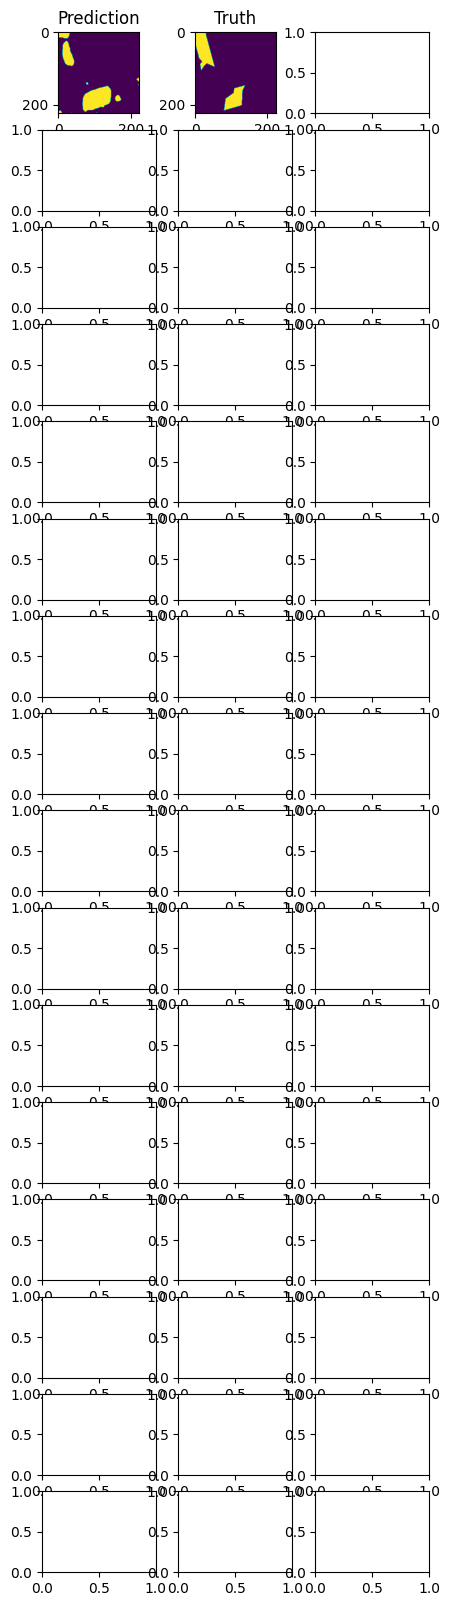

In [5]:
# Zusammenführen von Training- und Fine-Tuning-History
iou = model_history.history['binary_iou']
iou += history_fine.history['binary_iou']

val_iou = model_history.history['val_binary_iou']
val_iou += history_fine.history['val_binary_iou']

# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)

# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

eval_out_path = '../output/results.csv'

# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(eval_out_path):
    with open(eval_out_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['model_name', 'loss', 'accuracy', 'binary_iou', 'true_pos', 'false_pos', 'true_neg', 'false_neg', 'precision', 'recall', 'training_time [min]', 'max_val_iou', 'idx_max_val_iou' ]
        writer_object.writerow(header)

        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        # Einfügen der Trainingszeit in Minuten
        row.append(training_time/60)

        # Einfügen der maximalen Val-IoU
        row.append(max(val_iou))   

        # Einfügen des Index der maximalen Val-IoU
        row.append(np.argmax(val_iou))     

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(eval_out_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        # Einfügen der Trainingszeit in Minuten
        row.append(training_time/60)

        # Einfügen der maximalen Val-IoU
        row.append(max(val_iou))

        # Einfügen des Index der maximalen Val-IoU
        row.append(np.argmax(val_iou))

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)


# Plotten
epochs = range(1, len(iou)+1)

plt.plot(epochs, iou, 'g', label= 'Training IoU')
plt.plot(epochs, val_iou, 'b', label= 'Validation IoU')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

# Erstellen des IoU-Plot-Ordners
if not os.path.isdir(f'../output/plots/IoU'):
    os.makedirs(f'../output/plots/IoU')
    
plt.savefig(f'../output/plots/IoU/iou_{model_name}.png', bbox_inches='tight', dpi= 500)
plt.clf()

loss = model_history.history['loss']
loss += history_fine.history['loss']

val_loss = model_history.history['val_loss']
val_loss += history_fine.history['val_loss']

plt.plot(epochs, loss, 'g', label= 'Training Loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Erstellen des Loss-Plot-Ordners
if not os.path.isdir(f'../output/plots/Loss'):
    os.makedirs(f'../output/plots/Loss')

plt.savefig(f'../output/plots/Loss/loss_{model_name}.png', bbox_inches='tight', dpi= 500)
plt.clf()

# Prognose mit Hilfe des geladenen besten Modells
prediction = unet.predict(test_data_generator)

# Erstellung einer binären Maske aus den wahrscheinlichkeiten, Schwellwert 0.5
out = (prediction > 0.5).astype(np.uint8)

# lediglich halbe Batch Size in eine Abbildung wegen Übersichtlichkeit
rows = int(batch_size / 2)
columns = 3

# Anzahl verfügbarer Batches des Data-Generators
no_of_batches = test_data_generator.__len__()

# Prognose kommt als Tensor mit der Länge der Anzahl der Beispiele
out_idx = 0

# Erstellen des Prognosen-Ordners
if not os.path.isdir(f'../output/predictions/{model_name}'):
    os.makedirs(f'../output/predictions/{model_name}')

# Input und Masken kommen als Batches, über die iteriert wird
for batch_no in range(0, no_of_batches):

    # iterieren über erste Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_I.png', bbox_inches='tight')
    plt.close(fig)

    # iterieren über zweite Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][rows + i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][rows + i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    print(batch_no)
    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_II.png', bbox_inches='tight', dpi= 400)
    plt.close(fig)

# Zusammenführen der .log-Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
combine_log_files(output_folder_prefix, model_name)